# Imports

In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler
from tpot.builtins import StackingEstimator, ZeroCount
from tpot.export_utils import set_param_recursive
import pickle
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.datasets import make_classification
from scipy.stats import mannwhitneyu

# Loading

In [71]:
r1 = pd.read_csv('data-Round2/Round1_Diagnostic_32.csv')


1. id: Loan identifier.
2. own: Interest rate offered by your team.
3. competing2: Interest rate offered by lender 2.
4. competing3: Interest rate offered by lender 3. Missing interest rate means no offer.
5. borrowertype: =1,2,3 indicates the lender for which the borrower is ready to pay 2%
extra.
6. accepted: =1 if the borrower takes your loan offer; =0 if the borrower does not take yourloan offer. Note that you can reconstruct this variable using the information about thethree interest rates and the borrower’s type.
7. default: =1 if the borrower defaults on the loan; =0 if the borrower repays the loan.
8. profit: Your profit on this loan. The profit if your loan offer is accepted is equal to interest rate times 10,000 if the borrower repays, and to negative 10,000 if the borrower defaults.

In [109]:
past_loans = pd.read_csv("data-Round1/PastLoans.csv")

In [72]:
r1.head()

,id,own,competing1,competing2,borrowertype,accepted,default,profit
0,1,0.130412,0.059363,0.099252,3,0,0,NaN
1,2,NaN,0.273359,0.238307,1,0,0,NaN
2,3,0.128495,0.103130,0.218632,3,0,0,NaN
3,4,NaN,0.454960,0.101320,3,0,0,NaN
4,5,NaN,NaN,0.281806,1,0,1,NaN


In [108]:
past_loans.head()

,sex,employment,married,income,digital1,digital2,digital3,default
0,1,employed,1,33610,0.705613,0.068107,0.167038,0
1,1,employed,1,20650,0.000000,0.091152,0.000000,1
2,1,employed,1,8504,0.637625,0.000000,0.066207,0
3,1,employed,1,18460,0.276120,0.548380,0.625448,0
4,0,employed,0,8811,0.001974,0.500731,0.000000,1


# EDA

In [73]:
r1['accepted'].value_counts()

0    86240
1    13760
Name: accepted, dtype: int64

In [74]:
total_offers = r1.shape[0] - r1['own'].isna().sum()
offer_accepted = r1[r1['accepted'] == 1].shape[0]
defaulters_accepted = r1['default'][r1['accepted'] == 1].sum()
borrower_type_accepted = r1['borrowertype'][r1['accepted'] == 1].value_counts()
defaulter_not_accepted = r1['default'][r1['accepted'] == 0].sum()
non_defaulter_not_accepted = r1[r1['accepted'] == 0].shape[0] - defaulter_not_accepted
avg_int_rate = r1['own'].mean()
avg_int_rate_C1 = r1['competing1'].mean()
avg_int_rate_C2 = r1['competing2'].mean()
avg_int_rate_own_def = r1['own'][r1['default'] == 0].mean()
avg_int_rate_own_ndef = r1['own'][r1['default'] == 1].mean()
avg_int_rate_C1_def = r1['competing1'][r1['default'] == 1].mean()
avg_int_rate_C1_ndef = r1['competing1'][r1['default'] == 0].mean()
avg_int_rate_C2_def = r1['competing2'][r1['default'] == 1].mean()
avg_int_rate_C2_ndef = r1['competing2'][r1['default'] == 0].mean()
ndef_borrower_not_accepted = r1['accepted'][r1['default'] == 0][r1['borrowertype'] == 3].value_counts()[0]

In [75]:
print("Total Offers:", total_offers)
print("Offers Accepted:", offer_accepted)
print("Defaulters Accepted:", defaulters_accepted)
print("\nBreakdown of Borrower Types for Accepted Offers:")
print(borrower_type_accepted)
print("\nDefaulters Not Accepted:", defaulter_not_accepted)
print("Non-Defaulters Not Accepted:", non_defaulter_not_accepted)
print("\nNon-Defaulters of Borrower Type 3 Not Accepted:", ndef_borrower_not_accepted)

Total Offers: 34408
Offers Accepted: 13760
Defaulters Accepted: 1412

Breakdown of Borrower Types for Accepted Offers:
3    6568
2    3889
1    3303
Name: borrowertype, dtype: int64

Defaulters Not Accepted: 21312
Non-Defaulters Not Accepted: 64928

Non-Defaulters of Borrower Type 3 Not Accepted: 19778


In [76]:
print("Average Interest Rate for Own Offers:", avg_int_rate)
print("Average Interest Rate by lender 1:", avg_int_rate_C1)
print("Average Interest Rate by lender 2:", avg_int_rate_C2)
print("\nAverage Interest Rate for Defaulters lender 3:", avg_int_rate_own_def)
print("Average Interest Rate for Non-Defaulters lender 3:", avg_int_rate_own_ndef)
print("Average Interest Rate for Defaulters lender 1:", avg_int_rate_C1_def)
print("Average Interest Rate for Non-Defaulters lender 1:", avg_int_rate_C1_ndef)
print("Average Interest Rate for Defaulters lender 2:", avg_int_rate_C2_def)
print("Average Interest Rate for Non-Defaulters lender 2:", avg_int_rate_C2_ndef)

Average Interest Rate for Own Offers: 0.12808376754812834
Average Interest Rate by lender 1: 0.3084608351169663
Average Interest Rate by lender 2: 0.28354313266159636

Average Interest Rate for Defaulters lender 3: 0.12402526393257822
Average Interest Rate for Non-Defaulters lender 3: 0.1723453305083045
Average Interest Rate for Defaulters lender 1: 0.438227029118705
Average Interest Rate for Non-Defaulters lender 1: 0.2792577288859296
Average Interest Rate for Defaulters lender 2: 0.34359585706217155
Average Interest Rate for Non-Defaulters lender 2: 0.26847255934447467


In [77]:
r1['default'].value_counts()

0    77276
1    22724
Name: default, dtype: int64

1. The prediction for defaulter and non-defaulter are the same, the major problem is with the probability.How are we only getting 1/3 accepted if our interest is so low ?
2. Change in strategy and improvement in model.


1. Merge datasets
2. Higher digital footprint might result in them being our buyer
3. run a grid search or tpot
4. hybrid sampling

In [79]:
past_loans.head()

,sex,employment,married,income,digital1,digital2,digital3,default
0,1,employed,1,33610,0.705613,0.068107,0.167038,0
1,1,employed,1,20650,0.000000,0.091152,0.000000,1
2,1,employed,1,8504,0.637625,0.000000,0.066207,0
3,1,employed,1,18460,0.276120,0.548380,0.625448,0
4,0,employed,0,8811,0.001974,0.500731,0.000000,1


In [80]:
def preprocess(past_loans):
    # Make a deep copy to avoid modifying the original dataframe
    past_loans_copy = past_loans.copy()
    
    # Define income bins and labels
    income_bins = [-1, 5000, 20000, 50000, 1000000]
    income_labels = [0, 1, 2, 3]
    
    # Create a new column with income groups
    past_loans_copy['income_group'] = pd.cut(past_loans_copy['income'], bins=income_bins, labels=income_labels)
    
    # Convert 'income_group' to float type
    past_loans_copy['income_group'] = past_loans_copy['income_group'].astype(float)
    
    # One-hot encode the 'employment' column
    past_loans_copy = pd.get_dummies(past_loans_copy, columns=['employment'], drop_first=True)
    
    # Create an interaction term between 'income' and 'digital3'
    past_loans_copy['income_digital3'] = past_loans_copy['income'] * past_loans_copy['digital3']
    
    # Scale numeric features
    scaler = MinMaxScaler()
    numeric_features = ['income', 'digital3', 'income_digital3']
    past_loans_copy[numeric_features] = scaler.fit_transform(past_loans_copy[numeric_features])

    return past_loans_copy
past_loans_encoded = preprocess(past_loans)

In [81]:
past_loans_encoded.head()

,sex,married,income,digital1,digital2,digital3,default,income_group,employment_retired,employment_student,employment_unemployed,income_digital3
0,1,1,0.033610,0.705613,0.068107,0.167038,0,2.0,0,0,0,0.005660
1,1,1,0.020650,0.000000,0.091152,0.000000,1,2.0,0,0,0,0.000000
2,1,1,0.008504,0.637625,0.000000,0.066208,0,1.0,0,0,0,0.000568
3,1,1,0.018460,0.276120,0.548380,0.625450,0,1.0,0,0,0,0.011639
4,0,0,0.008811,0.001974,0.500731,0.000000,1,1.0,0,0,0,0.000000


In [82]:
past_loans_encoded['digital_avg'] = (past_loans_encoded['digital1'] + 
                                     past_loans_encoded['digital2'] + 
                                     past_loans_encoded['digital3']) / 3

w1,w2,w3= 0.25,0.25,0.5
    # Recalculate digital_weighted_avg using the given weights
past_loans_encoded['digital_weighted_avg'] = ((w1 * past_loans_encoded['digital1']) +
                                              (w2 * past_loans_encoded['digital2']) +
                                              (w3 * past_loans_encoded['digital3'])) / (w1 + w2 + w3)

past_loans_encoded.drop(['digital1','digital2','digital3','digital_avg'],inplace=True,axis=1)

In [83]:
past_loans_encoded.head()

,sex,married,income,default,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg
0,1,1,0.033610,0,2.0,0,0,0,0.005660,0.276949
1,1,1,0.020650,1,2.0,0,0,0,0.000000,0.022788
2,1,1,0.008504,0,1.0,0,0,0,0.000568,0.192510
3,1,1,0.018460,0,1.0,0,0,0,0.011639,0.518850
4,0,0,0.008811,1,1.0,0,0,0,0.000000,0.125676


In [84]:
inference = pd.read_csv("data-Round1/NewApplications_Lender3.csv", index_col="id")
inference.head()
df_inference = preprocess(inference) 
df_inference['digital_weighted_avg'] = df_inference['digital3']
df_inference.drop('digital3',inplace=True,axis=1)
df_inference.head()

,sex,married,income,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg
id,,,,,,,,,
1,1,1,0.016514,1.0,0,0,1,0.000000,0.000000
2,0,1,0.008842,1.0,0,0,0,0.000000,0.000000
3,0,0,0.019424,1.0,0,0,0,0.012321,0.596777
4,1,1,0.007418,1.0,0,0,1,0.004907,0.622316
5,1,0,0.000843,0.0,1,0,0,0.000348,0.388934


In [85]:
df_inference.reset_index(drop=True, inplace=True)
r1.reset_index(drop=True, inplace=True)
df_inference['default'] = r1['default']
df_inference.head(20)

,sex,married,income,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg,default
0,1,1,0.016514,1.0,0,0,1,0.000000,0.000000,0
1,0,1,0.008842,1.0,0,0,0,0.000000,0.000000,0
2,0,0,0.019424,1.0,0,0,0,0.012321,0.596777,0
3,1,1,0.007418,1.0,0,0,1,0.004907,0.622316,0
4,1,0,0.000843,0.0,1,0,0,0.000348,0.388934,1
5,1,1,0.005512,1.0,0,0,0,0.001947,0.332408,1
6,1,0,0.012344,1.0,0,0,0,0.000000,0.000000,0
7,1,0,0.011170,1.0,0,0,0,0.000000,0.000000,1
8,0,1,0.005045,1.0,0,0,0,0.004349,0.810963,0
9,1,0,0.000000,0.0,0,1,0,0.000000,0.671097,1


In [86]:
main_df = pd.concat([past_loans_encoded,df_inference]) #creating a joint dataset

In [87]:
main_df.head()

,sex,married,income,default,income_group,employment_retired,employment_student,employment_unemployed,income_digital3,digital_weighted_avg
0,1,1,0.033610,0,2.0,0,0,0,0.005660,0.276949
1,1,1,0.020650,1,2.0,0,0,0,0.000000,0.022788
2,1,1,0.008504,0,1.0,0,0,0,0.000568,0.192510
3,1,1,0.018460,0,1.0,0,0,0,0.011639,0.518850
4,0,0,0.008811,1,1.0,0,0,0,0.000000,0.125676


-0.06291041990705849

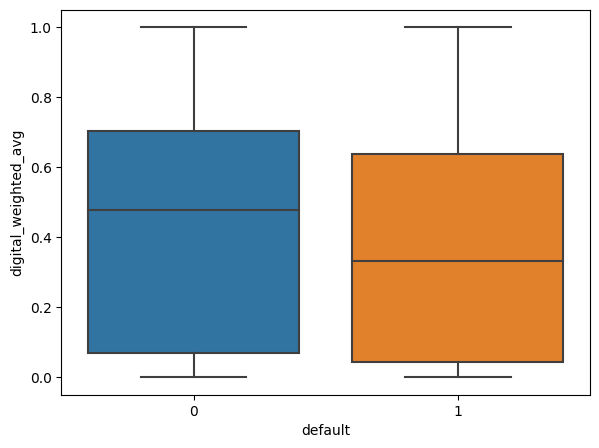

In [88]:
correlation = df_inference['digital_weighted_avg'].corr(df_inference['default'])

plt.figure(figsize=(15,5))

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x='default', y='digital_weighted_avg', data=df_inference)

correlation

In [89]:
main_df['default'].value_counts()

0    154784
1     45216
Name: default, dtype: int64

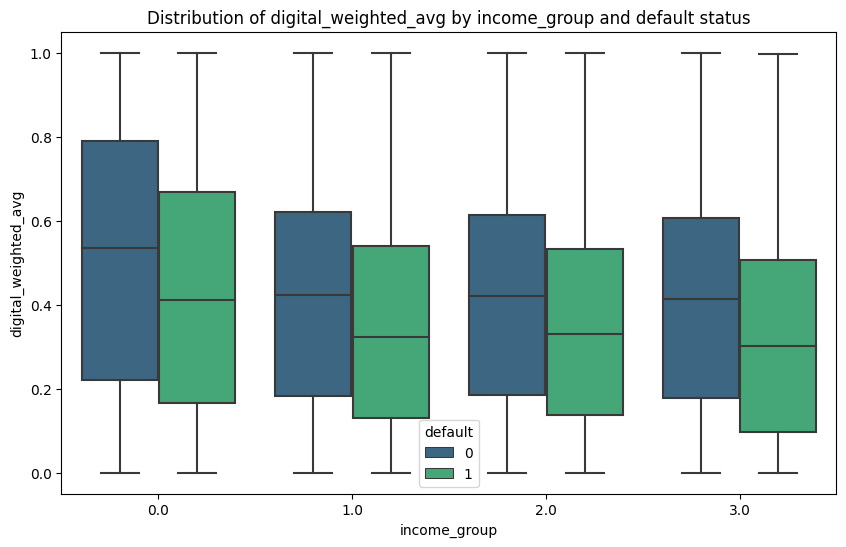

In [107]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=main_df, x='income_group', y='digital_weighted_avg', hue='default', palette="viridis")
plt.title('Distribution of digital_weighted_avg by income_group and default status')
plt.show()

In [105]:
def test_significance(data, group):
    group_data = data[data['income_group'] == group]
    default = group_data[group_data['default'] == 1]['digital_weighted_avg']
    no_default = group_data[group_data['default'] == 0]['digital_weighted_avg']
    stat, p = mannwhitneyu(default, no_default, alternative='two-sided')
    
    return p

income_groups = main_df['income_group'].unique()
results = {}

for group in income_groups:
    p_value = test_significance(main_df, group)
    results[group] = p_value
    if p_value < 0.05:
        print(f"For income group {group}, the difference is statistically significant with p-value {p_value:.4f}")
    else:
        print(f"For income group {group}, the difference is not statistically significant with p-value {p_value:.4f}")

For income group 2.0, the difference is statistically significant with p-value 0.0000
For income group 1.0, the difference is statistically significant with p-value 0.0000
For income group 0.0, the difference is statistically significant with p-value 0.0000
For income group 3.0, the difference is statistically significant with p-value 0.0000


In [106]:
def test_significance(data, group):
    group_data = data[data['income_group'] == group]
    default = group_data[group_data['default'] == 1]['digital_weighted_avg']
    no_default = group_data[group_data['default'] == 0]['digital_weighted_avg']
    stat, p = mannwhitneyu(default, no_default, alternative='two-sided')
    
    return p

income_groups = main_df['income_group'].unique()
results = {}

for group in income_groups:
    p_value = test_significance(main_df, group)
    results[group] = p_value
    if p_value < 0.05:
        print(f"For income group {group}, the difference is statistically significant with p-value {p_value:.4f}")
    else:
        print(f"For income group {group}, the difference is not statistically significant with p-value {p_value:.4f}")

For income group 2.0, the difference is statistically significant with p-value 0.0000
For income group 1.0, the difference is statistically significant with p-value 0.0000
For income group 0.0, the difference is statistically significant with p-value 0.0000
For income group 3.0, the difference is statistically significant with p-value 0.0000


# Data Preprocessing and Modeling

In [90]:
#main_df.drop(['income_group','income_digital3'],axis=1,inplace=True)

In [91]:
# use smotek to do hybrid sampling
X = main_df.drop('default',axis=1)
y= main_df['default']

smt = SMOTETomek(random_state=42)

X_resampled, y_resampled = smt.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

### Xgboost basic model

In [117]:
xgb.set_config(verbosity=1)

# Define a complex XGBoost classifier
model = XGBClassifier(
    tree_method="hist",
    device="cuda",
    eval_metric="auc",
    objective="binary:logistic",
    verbosity=1,
    max_depth=7,
    learning_rate=0.1,
    n_estimators=1000,
    gamma=.25,
    subsample=0.9,
    colsample_bytree=1.0
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

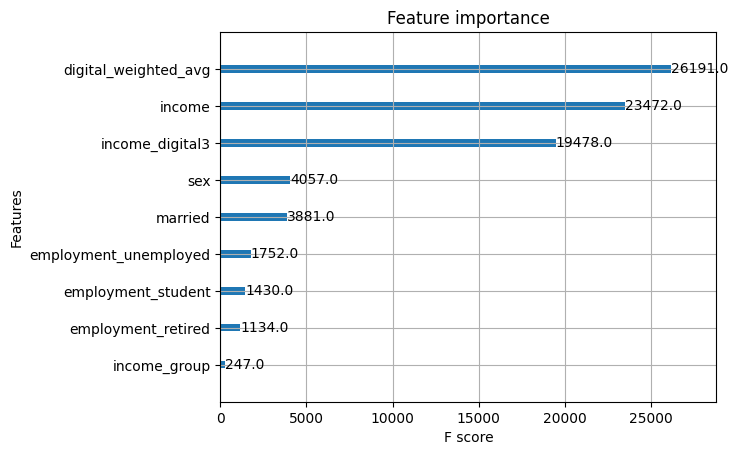

In [118]:
plot_importance(model)
plt.show()

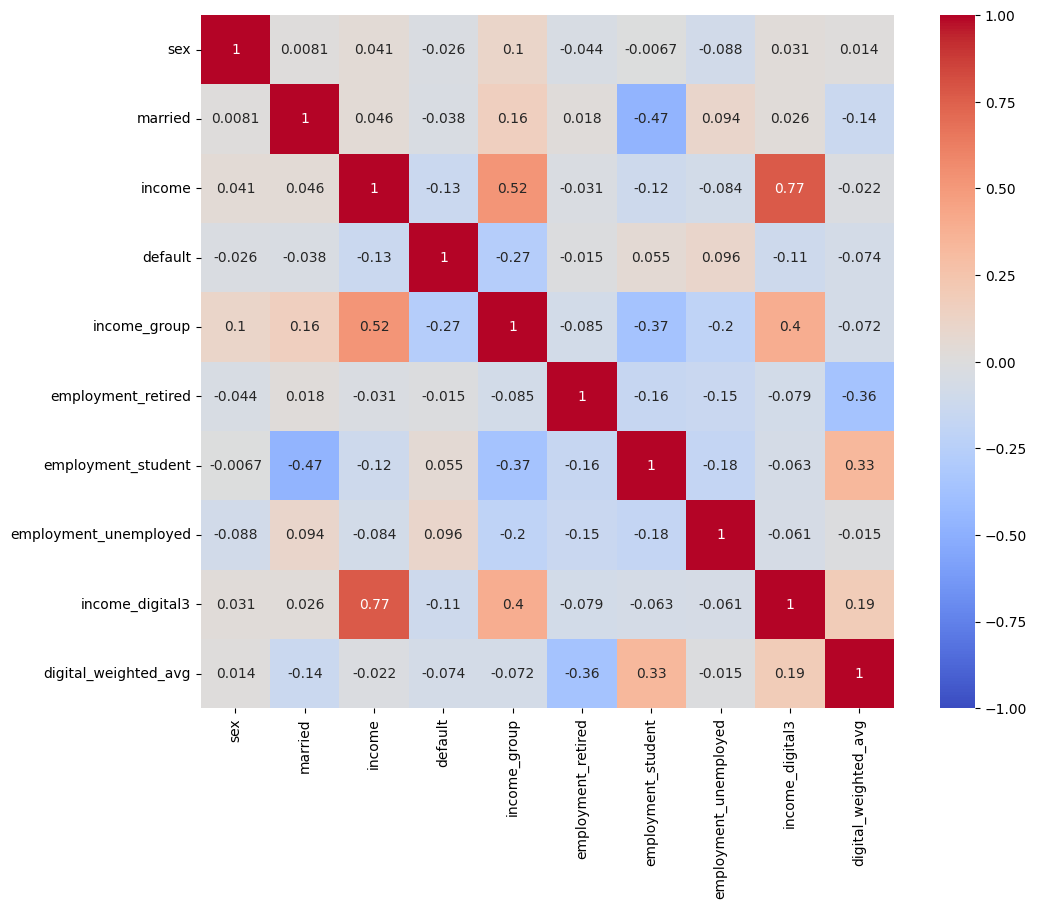

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = main_df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.show()


In [120]:
results = model.predict(X_test)
probabilities = model.predict_proba(X_test).T[1]
model.score(X_test, y_test)

0.735832388580515

In [121]:
from sklearn.metrics import auc,roc_curve
fpr, tpr, thresholds = roc_curve(y_test, results, pos_label = 1)
auc(fpr, tpr)

0.7358115769715584

In [122]:
f1_score(y_test, results)

0.7511856885314102

### Tpot Classifier

In [35]:
tpot = TPOTClassifier(generations=40,population_size=50,verbosity=3, scoring='roc_auc', random_state=42, n_jobs=-1)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/2050 [00:00<?, ?pipeline/s]

Skipped pipeline #16 due to time out. Continuing to the next pipeline.
_pre_test decorator: _mate_operator: num_test=0 'str' object has no attribute 'arity'.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only dual=False, got dual=True.
_pre_test decorator: _mate_operator: num_test=0 'str' object has no attribute 'arity'.
_pre_test decorator: _mate_operator: num_test=0 'str' object has no attribute 'arity'.
_pre_test decorator: _random_mutation_operator: num_test=0 (slice(None, None, None), 0).
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required by LinearSVC..
_pre_test decorator: _mate_operator: num_test=0 'str' object has no attribute 'arity'.
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False.
_

In [36]:
tpot.export('tpot_best_pipeline.py')
best_pipeline = tpot.fitted_pipeline_

In [37]:
best_pipeline

Pipeline(steps=[('zerocount', ZeroCount()),
                ('pca',
                 PCA(iterated_power=7, random_state=42,
                     svd_solver='randomized')),
                ('minmaxscaler', MinMaxScaler()),
                ('stackingestimator',
                 StackingEstimator(estimator=MultinomialNB(alpha=0.001,
                                                           fit_prior=False))),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=12, weights='distance'))])

### Xgboost GridSearch

In [30]:
# Define XGBoost parameters
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'tree_method':['hist'],
    'device':['cuda'],
}

xgb = XGBClassifier(objective='binary:logistic', tree_method='hist', eval_metric='auc')

scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc_score': make_scorer(roc_auc_score)
}

xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring=scorers, refit='roc_auc_score', n_jobs=-1, verbose=5)
xgb_grid.fit(X_train, y_train)

print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best AUC score: {xgb_grid.best_score_}")


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best XGBoost parameters: {'colsample_bytree': 1.0, 'device': 'cuda', 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000, 'subsample': 0.9, 'tree_method': 'hist'}
Best AUC score: 0.7337135494828425


In [34]:
best_pars = xgb_grid.best_params_
# Save model
pickle.dump(xgb_grid.best_params_, open("xgb_log_reg.pickle", "wb"))

In [35]:
best_pars

{'colsample_bytree': 1.0,
 'device': 'cuda',
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 1000,
 'subsample': 0.9,
 'tree_method': 'hist'}

### Catboost GridSearch

In [32]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, roc_auc_score

# Define CatBoost parameters
cat_params = {
    'learning_rate': [0.05 , 0.1],
    'iterations': [500, 1000],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32 , 128],
    'task_type':['GPU']
}


cat = CatBoostClassifier(verbose=5, loss_function='Logloss', eval_metric='AUC')

scorers = {
    'roc_auc_score': make_scorer(roc_auc_score)
}

cat_grid = GridSearchCV(cat, cat_params, cv=5, scoring=scorers, refit='roc_auc_score',verbose=1)
cat_grid.fit(X_train, y_train)

print(f"Best CatBoost parameters: {cat_grid.best_params_}")
print(f"Best AUC score: {cat_grid.best_score_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.3ms	remaining: 5.65s
5:	total: 56.8ms	remaining: 4.68s
10:	total: 100ms	remaining: 4.45s
15:	total: 142ms	remaining: 4.29s
20:	total: 186ms	remaining: 4.24s
25:	total: 230ms	remaining: 4.19s
30:	total: 274ms	remaining: 4.14s
35:	total: 316ms	remaining: 4.08s
40:	total: 357ms	remaining: 4s
45:	total: 402ms	remaining: 3.97s
50:	total: 445ms	remaining: 3.92s
55:	total: 490ms	remaining: 3.89s
60:	total: 535ms	remaining: 3.85s
65:	total: 579ms	remaining: 3.81s
70:	total: 622ms	remaining: 3.76s
75:	total: 668ms	remaining: 3.72s
80:	total: 711ms	remaining: 3.67s
85:	total: 755ms	remaining: 3.63s
90:	total: 798ms	remaining: 3.59s
95:	total: 842ms	remaining: 3.54s
100:	total: 884ms	remaining: 3.49s
105:	total: 930ms	remaining: 3.46s
110:	total: 976ms	remaining: 3.42s
115:	total: 1.02s	remaining: 3.37s
120:	total: 1.07s	remaining: 3.36s
125:	total: 1.12s	remaining: 3.31s
130:	total: 1.16s	remaining: 3.27s
135:	total: 1.21s	remaining: 3.23s
140:	total: 1.25s	remaining: 3.18s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.5ms	remaining: 6.25s
5:	total: 57.8ms	remaining: 4.75s
10:	total: 98.9ms	remaining: 4.4s
15:	total: 141ms	remaining: 4.27s
20:	total: 182ms	remaining: 4.16s
25:	total: 226ms	remaining: 4.12s
30:	total: 274ms	remaining: 4.14s
35:	total: 315ms	remaining: 4.05s
40:	total: 359ms	remaining: 4.02s
45:	total: 399ms	remaining: 3.94s
50:	total: 441ms	remaining: 3.88s
55:	total: 483ms	remaining: 3.83s
60:	total: 526ms	remaining: 3.79s
65:	total: 568ms	remaining: 3.73s
70:	total: 609ms	remaining: 3.68s
75:	total: 652ms	remaining: 3.64s
80:	total: 697ms	remaining: 3.6s
85:	total: 748ms	remaining: 3.6s
90:	total: 790ms	remaining: 3.55s
95:	total: 830ms	remaining: 3.49s
100:	total: 873ms	remaining: 3.45s
105:	total: 916ms	remaining: 3.4s
110:	total: 957ms	remaining: 3.35s
115:	total: 1s	remaining: 3.32s
120:	total: 1.06s	remaining: 3.32s
125:	total: 1.1s	remaining: 3.27s
130:	total: 1.15s	remaining: 3.23s
135:	total: 1.19s	remaining: 3.18s
140:	total: 1.23s	remaining: 3.13s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.8ms	remaining: 4.39s
5:	total: 49.4ms	remaining: 4.06s
10:	total: 97.5ms	remaining: 4.33s
15:	total: 139ms	remaining: 4.21s
20:	total: 180ms	remaining: 4.1s
25:	total: 220ms	remaining: 4.01s
30:	total: 263ms	remaining: 3.97s
35:	total: 304ms	remaining: 3.92s
40:	total: 346ms	remaining: 3.87s
45:	total: 386ms	remaining: 3.81s
50:	total: 426ms	remaining: 3.75s
55:	total: 469ms	remaining: 3.72s
60:	total: 512ms	remaining: 3.69s
65:	total: 553ms	remaining: 3.64s
70:	total: 596ms	remaining: 3.6s
75:	total: 637ms	remaining: 3.55s
80:	total: 678ms	remaining: 3.51s
85:	total: 721ms	remaining: 3.47s
90:	total: 765ms	remaining: 3.44s
95:	total: 807ms	remaining: 3.4s
100:	total: 850ms	remaining: 3.36s
105:	total: 890ms	remaining: 3.31s
110:	total: 934ms	remaining: 3.27s
115:	total: 977ms	remaining: 3.23s
120:	total: 1.02s	remaining: 3.19s
125:	total: 1.06s	remaining: 3.15s
130:	total: 1.1s	remaining: 3.1s
135:	total: 1.15s	remaining: 3.06s
140:	total: 1.19s	remaining: 3.02s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.19ms	remaining: 4.58s
5:	total: 51.3ms	remaining: 4.22s
10:	total: 90.3ms	remaining: 4.01s
15:	total: 132ms	remaining: 4s
20:	total: 171ms	remaining: 3.9s
25:	total: 210ms	remaining: 3.83s
30:	total: 264ms	remaining: 4s
35:	total: 306ms	remaining: 3.94s
40:	total: 350ms	remaining: 3.92s
45:	total: 392ms	remaining: 3.87s
50:	total: 435ms	remaining: 3.83s
55:	total: 479ms	remaining: 3.8s
60:	total: 521ms	remaining: 3.75s
65:	total: 563ms	remaining: 3.7s
70:	total: 604ms	remaining: 3.65s
75:	total: 647ms	remaining: 3.61s
80:	total: 688ms	remaining: 3.56s
85:	total: 730ms	remaining: 3.52s
90:	total: 770ms	remaining: 3.46s
95:	total: 815ms	remaining: 3.43s
100:	total: 859ms	remaining: 3.39s
105:	total: 901ms	remaining: 3.35s
110:	total: 945ms	remaining: 3.31s
115:	total: 988ms	remaining: 3.27s
120:	total: 1.03s	remaining: 3.23s
125:	total: 1.07s	remaining: 3.19s
130:	total: 1.12s	remaining: 3.15s
135:	total: 1.16s	remaining: 3.1s
140:	total: 1.2s	remaining: 3.06s
145:	total: 1.2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.43ms	remaining: 4.71s
5:	total: 49.6ms	remaining: 4.08s
10:	total: 90.8ms	remaining: 4.03s
15:	total: 133ms	remaining: 4.03s
20:	total: 175ms	remaining: 3.99s
25:	total: 219ms	remaining: 3.98s
30:	total: 261ms	remaining: 3.95s
35:	total: 303ms	remaining: 3.9s
40:	total: 345ms	remaining: 3.86s
45:	total: 386ms	remaining: 3.81s
50:	total: 427ms	remaining: 3.76s
55:	total: 470ms	remaining: 3.73s
60:	total: 511ms	remaining: 3.67s
65:	total: 554ms	remaining: 3.64s
70:	total: 596ms	remaining: 3.6s
75:	total: 637ms	remaining: 3.55s
80:	total: 676ms	remaining: 3.5s
85:	total: 719ms	remaining: 3.46s
90:	total: 759ms	remaining: 3.41s
95:	total: 801ms	remaining: 3.37s
100:	total: 844ms	remaining: 3.33s
105:	total: 883ms	remaining: 3.28s
110:	total: 923ms	remaining: 3.24s
115:	total: 966ms	remaining: 3.2s
120:	total: 1.01s	remaining: 3.17s
125:	total: 1.05s	remaining: 3.12s
130:	total: 1.09s	remaining: 3.08s
135:	total: 1.14s	remaining: 3.04s
140:	total: 1.19s	remaining: 3.03s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.81ms	remaining: 4.9s
5:	total: 51.6ms	remaining: 4.25s
10:	total: 99ms	remaining: 4.4s
15:	total: 148ms	remaining: 4.47s
20:	total: 189ms	remaining: 4.32s
25:	total: 237ms	remaining: 4.33s
30:	total: 287ms	remaining: 4.35s
35:	total: 327ms	remaining: 4.22s
40:	total: 369ms	remaining: 4.13s
45:	total: 408ms	remaining: 4.03s
50:	total: 449ms	remaining: 3.95s
55:	total: 490ms	remaining: 3.89s
60:	total: 532ms	remaining: 3.83s
65:	total: 573ms	remaining: 3.77s
70:	total: 615ms	remaining: 3.72s
75:	total: 657ms	remaining: 3.67s
80:	total: 699ms	remaining: 3.62s
85:	total: 740ms	remaining: 3.56s
90:	total: 783ms	remaining: 3.52s
95:	total: 824ms	remaining: 3.47s
100:	total: 872ms	remaining: 3.45s
105:	total: 921ms	remaining: 3.42s
110:	total: 963ms	remaining: 3.38s
115:	total: 1s	remaining: 3.33s
120:	total: 1.05s	remaining: 3.28s
125:	total: 1.09s	remaining: 3.23s
130:	total: 1.13s	remaining: 3.18s
135:	total: 1.17s	remaining: 3.14s
140:	total: 1.21s	remaining: 3.09s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.64ms	remaining: 4.81s
5:	total: 48.6ms	remaining: 4s
10:	total: 89.6ms	remaining: 3.98s
15:	total: 129ms	remaining: 3.91s
20:	total: 173ms	remaining: 3.94s
25:	total: 215ms	remaining: 3.92s
30:	total: 259ms	remaining: 3.92s
35:	total: 301ms	remaining: 3.88s
40:	total: 343ms	remaining: 3.83s
45:	total: 385ms	remaining: 3.8s
50:	total: 426ms	remaining: 3.75s
55:	total: 470ms	remaining: 3.73s
60:	total: 512ms	remaining: 3.68s
65:	total: 554ms	remaining: 3.64s
70:	total: 596ms	remaining: 3.6s
75:	total: 637ms	remaining: 3.55s
80:	total: 679ms	remaining: 3.51s
85:	total: 719ms	remaining: 3.46s
90:	total: 762ms	remaining: 3.42s
95:	total: 802ms	remaining: 3.37s
100:	total: 852ms	remaining: 3.37s
105:	total: 895ms	remaining: 3.33s
110:	total: 938ms	remaining: 3.29s
115:	total: 981ms	remaining: 3.25s
120:	total: 1.03s	remaining: 3.21s
125:	total: 1.07s	remaining: 3.17s
130:	total: 1.12s	remaining: 3.15s
135:	total: 1.16s	remaining: 3.11s
140:	total: 1.22s	remaining: 3.12s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.7ms	remaining: 4.84s
5:	total: 50.3ms	remaining: 4.14s
10:	total: 93ms	remaining: 4.13s
15:	total: 134ms	remaining: 4.05s
20:	total: 176ms	remaining: 4.02s
25:	total: 224ms	remaining: 4.08s
30:	total: 268ms	remaining: 4.06s
35:	total: 309ms	remaining: 3.98s
40:	total: 351ms	remaining: 3.93s
45:	total: 392ms	remaining: 3.87s
50:	total: 435ms	remaining: 3.83s
55:	total: 477ms	remaining: 3.78s
60:	total: 518ms	remaining: 3.73s
65:	total: 567ms	remaining: 3.73s
70:	total: 606ms	remaining: 3.66s
75:	total: 646ms	remaining: 3.6s
80:	total: 688ms	remaining: 3.56s
85:	total: 732ms	remaining: 3.52s
90:	total: 772ms	remaining: 3.47s
95:	total: 816ms	remaining: 3.43s
100:	total: 858ms	remaining: 3.39s
105:	total: 902ms	remaining: 3.35s
110:	total: 943ms	remaining: 3.3s
115:	total: 991ms	remaining: 3.28s
120:	total: 1.03s	remaining: 3.23s
125:	total: 1.07s	remaining: 3.18s
130:	total: 1.12s	remaining: 3.15s
135:	total: 1.16s	remaining: 3.1s
140:	total: 1.2s	remaining: 3.06s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.94ms	remaining: 4.46s
5:	total: 52.5ms	remaining: 4.33s
10:	total: 93ms	remaining: 4.13s
15:	total: 136ms	remaining: 4.1s
20:	total: 176ms	remaining: 4.02s
25:	total: 217ms	remaining: 3.96s
30:	total: 257ms	remaining: 3.89s
35:	total: 299ms	remaining: 3.85s
40:	total: 340ms	remaining: 3.81s
45:	total: 388ms	remaining: 3.83s
50:	total: 433ms	remaining: 3.81s
55:	total: 476ms	remaining: 3.77s
60:	total: 519ms	remaining: 3.73s
65:	total: 562ms	remaining: 3.69s
70:	total: 602ms	remaining: 3.64s
75:	total: 645ms	remaining: 3.6s
80:	total: 686ms	remaining: 3.55s
85:	total: 728ms	remaining: 3.5s
90:	total: 768ms	remaining: 3.45s
95:	total: 808ms	remaining: 3.4s
100:	total: 851ms	remaining: 3.36s
105:	total: 894ms	remaining: 3.32s
110:	total: 941ms	remaining: 3.3s
115:	total: 980ms	remaining: 3.25s
120:	total: 1.02s	remaining: 3.2s
125:	total: 1.06s	remaining: 3.15s
130:	total: 1.1s	remaining: 3.11s
135:	total: 1.15s	remaining: 3.07s
140:	total: 1.19s	remaining: 3.03s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.4ms	remaining: 6.68s
5:	total: 70.4ms	remaining: 5.79s
10:	total: 113ms	remaining: 5.01s
15:	total: 153ms	remaining: 4.62s
20:	total: 195ms	remaining: 4.44s
25:	total: 250ms	remaining: 4.56s
30:	total: 294ms	remaining: 4.45s
35:	total: 335ms	remaining: 4.32s
40:	total: 376ms	remaining: 4.21s
45:	total: 417ms	remaining: 4.11s
50:	total: 460ms	remaining: 4.05s
55:	total: 502ms	remaining: 3.98s
60:	total: 543ms	remaining: 3.91s
65:	total: 583ms	remaining: 3.83s
70:	total: 636ms	remaining: 3.84s
75:	total: 676ms	remaining: 3.77s
80:	total: 717ms	remaining: 3.71s
85:	total: 760ms	remaining: 3.66s
90:	total: 803ms	remaining: 3.61s
95:	total: 844ms	remaining: 3.55s
100:	total: 886ms	remaining: 3.5s
105:	total: 927ms	remaining: 3.44s
110:	total: 973ms	remaining: 3.41s
115:	total: 1.01s	remaining: 3.35s
120:	total: 1.05s	remaining: 3.3s
125:	total: 1.09s	remaining: 3.25s
130:	total: 1.14s	remaining: 3.21s
135:	total: 1.18s	remaining: 3.16s
140:	total: 1.22s	remaining: 3.11s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.38ms	remaining: 4.68s
5:	total: 50.7ms	remaining: 4.17s
10:	total: 91.4ms	remaining: 4.07s
15:	total: 133ms	remaining: 4.02s
20:	total: 174ms	remaining: 3.98s
25:	total: 217ms	remaining: 3.95s
30:	total: 258ms	remaining: 3.9s
35:	total: 299ms	remaining: 3.86s
40:	total: 340ms	remaining: 3.8s
45:	total: 382ms	remaining: 3.77s
50:	total: 423ms	remaining: 3.73s
55:	total: 465ms	remaining: 3.68s
60:	total: 507ms	remaining: 3.65s
65:	total: 567ms	remaining: 3.73s
70:	total: 607ms	remaining: 3.67s
75:	total: 648ms	remaining: 3.62s
80:	total: 689ms	remaining: 3.56s
85:	total: 733ms	remaining: 3.53s
90:	total: 773ms	remaining: 3.48s
95:	total: 814ms	remaining: 3.43s
100:	total: 864ms	remaining: 3.41s
105:	total: 905ms	remaining: 3.36s
110:	total: 949ms	remaining: 3.33s
115:	total: 989ms	remaining: 3.27s
120:	total: 1.03s	remaining: 3.23s
125:	total: 1.07s	remaining: 3.18s
130:	total: 1.11s	remaining: 3.14s
135:	total: 1.16s	remaining: 3.1s
140:	total: 1.2s	remaining: 3.05s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.76ms	remaining: 4.87s
5:	total: 49.6ms	remaining: 4.08s
10:	total: 92.2ms	remaining: 4.1s
15:	total: 133ms	remaining: 4.02s
20:	total: 174ms	remaining: 3.98s
25:	total: 215ms	remaining: 3.92s
30:	total: 259ms	remaining: 3.92s
35:	total: 304ms	remaining: 3.92s
40:	total: 345ms	remaining: 3.86s
45:	total: 387ms	remaining: 3.82s
50:	total: 429ms	remaining: 3.78s
55:	total: 471ms	remaining: 3.73s
60:	total: 514ms	remaining: 3.7s
65:	total: 555ms	remaining: 3.65s
70:	total: 597ms	remaining: 3.6s
75:	total: 639ms	remaining: 3.56s
80:	total: 681ms	remaining: 3.52s
85:	total: 724ms	remaining: 3.48s
90:	total: 767ms	remaining: 3.45s
95:	total: 808ms	remaining: 3.4s
100:	total: 852ms	remaining: 3.36s
105:	total: 894ms	remaining: 3.32s
110:	total: 937ms	remaining: 3.28s
115:	total: 980ms	remaining: 3.24s
120:	total: 1.02s	remaining: 3.2s
125:	total: 1.07s	remaining: 3.17s
130:	total: 1.11s	remaining: 3.13s
135:	total: 1.18s	remaining: 3.15s
140:	total: 1.22s	remaining: 3.1s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.7ms	remaining: 4.34s
5:	total: 50.1ms	remaining: 4.13s
10:	total: 90.3ms	remaining: 4.01s
15:	total: 133ms	remaining: 4.01s
20:	total: 180ms	remaining: 4.1s
25:	total: 222ms	remaining: 4.05s
30:	total: 268ms	remaining: 4.05s
35:	total: 315ms	remaining: 4.05s
40:	total: 356ms	remaining: 3.99s
45:	total: 399ms	remaining: 3.94s
50:	total: 440ms	remaining: 3.87s
55:	total: 485ms	remaining: 3.84s
60:	total: 527ms	remaining: 3.79s
65:	total: 567ms	remaining: 3.73s
70:	total: 608ms	remaining: 3.67s
75:	total: 650ms	remaining: 3.63s
80:	total: 693ms	remaining: 3.58s
85:	total: 734ms	remaining: 3.53s
90:	total: 776ms	remaining: 3.49s
95:	total: 818ms	remaining: 3.44s
100:	total: 861ms	remaining: 3.4s
105:	total: 900ms	remaining: 3.35s
110:	total: 944ms	remaining: 3.31s
115:	total: 983ms	remaining: 3.25s
120:	total: 1.03s	remaining: 3.22s
125:	total: 1.07s	remaining: 3.18s
130:	total: 1.11s	remaining: 3.14s
135:	total: 1.16s	remaining: 3.1s
140:	total: 1.2s	remaining: 3.05s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.06ms	remaining: 4.52s
5:	total: 50.4ms	remaining: 4.15s
10:	total: 91.4ms	remaining: 4.06s
15:	total: 134ms	remaining: 4.04s
20:	total: 186ms	remaining: 4.24s
25:	total: 229ms	remaining: 4.18s
30:	total: 270ms	remaining: 4.08s
35:	total: 310ms	remaining: 3.99s
40:	total: 351ms	remaining: 3.93s
45:	total: 397ms	remaining: 3.92s
50:	total: 439ms	remaining: 3.87s
55:	total: 481ms	remaining: 3.81s
60:	total: 523ms	remaining: 3.77s
65:	total: 567ms	remaining: 3.73s
70:	total: 609ms	remaining: 3.68s
75:	total: 650ms	remaining: 3.63s
80:	total: 693ms	remaining: 3.58s
85:	total: 732ms	remaining: 3.52s
90:	total: 775ms	remaining: 3.48s
95:	total: 819ms	remaining: 3.44s
100:	total: 861ms	remaining: 3.4s
105:	total: 905ms	remaining: 3.36s
110:	total: 946ms	remaining: 3.32s
115:	total: 989ms	remaining: 3.27s
120:	total: 1.03s	remaining: 3.23s
125:	total: 1.07s	remaining: 3.18s
130:	total: 1.11s	remaining: 3.14s
135:	total: 1.16s	remaining: 3.09s
140:	total: 1.2s	remaining: 3.05s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.8ms	remaining: 4.89s
5:	total: 49.6ms	remaining: 4.09s
10:	total: 92ms	remaining: 4.09s
15:	total: 133ms	remaining: 4.01s
20:	total: 174ms	remaining: 3.97s
25:	total: 217ms	remaining: 3.95s
30:	total: 269ms	remaining: 4.07s
35:	total: 312ms	remaining: 4.02s
40:	total: 354ms	remaining: 3.97s
45:	total: 396ms	remaining: 3.91s
50:	total: 438ms	remaining: 3.85s
55:	total: 483ms	remaining: 3.83s
60:	total: 524ms	remaining: 3.77s
65:	total: 564ms	remaining: 3.71s
70:	total: 604ms	remaining: 3.65s
75:	total: 644ms	remaining: 3.59s
80:	total: 685ms	remaining: 3.54s
85:	total: 726ms	remaining: 3.5s
90:	total: 769ms	remaining: 3.46s
95:	total: 811ms	remaining: 3.41s
100:	total: 852ms	remaining: 3.37s
105:	total: 894ms	remaining: 3.32s
110:	total: 936ms	remaining: 3.28s
115:	total: 979ms	remaining: 3.24s
120:	total: 1.02s	remaining: 3.19s
125:	total: 1.06s	remaining: 3.15s
130:	total: 1.1s	remaining: 3.11s
135:	total: 1.15s	remaining: 3.07s
140:	total: 1.19s	remaining: 3.02s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.21ms	remaining: 4.1s
5:	total: 50.8ms	remaining: 4.18s
10:	total: 92.9ms	remaining: 4.13s
15:	total: 134ms	remaining: 4.04s
20:	total: 176ms	remaining: 4.03s
25:	total: 226ms	remaining: 4.13s
30:	total: 269ms	remaining: 4.07s
35:	total: 312ms	remaining: 4.02s
40:	total: 353ms	remaining: 3.96s
45:	total: 396ms	remaining: 3.91s
50:	total: 438ms	remaining: 3.86s
55:	total: 482ms	remaining: 3.82s
60:	total: 526ms	remaining: 3.79s
65:	total: 569ms	remaining: 3.74s
70:	total: 623ms	remaining: 3.77s
75:	total: 664ms	remaining: 3.71s
80:	total: 704ms	remaining: 3.64s
85:	total: 749ms	remaining: 3.6s
90:	total: 792ms	remaining: 3.56s
95:	total: 832ms	remaining: 3.5s
100:	total: 875ms	remaining: 3.46s
105:	total: 916ms	remaining: 3.41s
110:	total: 964ms	remaining: 3.38s
115:	total: 1.01s	remaining: 3.34s
120:	total: 1.05s	remaining: 3.29s
125:	total: 1.09s	remaining: 3.24s
130:	total: 1.13s	remaining: 3.19s
135:	total: 1.17s	remaining: 3.14s
140:	total: 1.22s	remaining: 3.1s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.14ms	remaining: 4.56s
5:	total: 49.3ms	remaining: 4.05s
10:	total: 90.5ms	remaining: 4.02s
15:	total: 131ms	remaining: 3.98s
20:	total: 174ms	remaining: 3.97s
25:	total: 216ms	remaining: 3.94s
30:	total: 257ms	remaining: 3.89s
35:	total: 302ms	remaining: 3.89s
40:	total: 353ms	remaining: 3.95s
45:	total: 395ms	remaining: 3.89s
50:	total: 444ms	remaining: 3.91s
55:	total: 494ms	remaining: 3.92s
60:	total: 537ms	remaining: 3.86s
65:	total: 579ms	remaining: 3.81s
70:	total: 620ms	remaining: 3.74s
75:	total: 661ms	remaining: 3.69s
80:	total: 704ms	remaining: 3.64s
85:	total: 746ms	remaining: 3.59s
90:	total: 787ms	remaining: 3.54s
95:	total: 829ms	remaining: 3.49s
100:	total: 876ms	remaining: 3.46s
105:	total: 918ms	remaining: 3.41s
110:	total: 961ms	remaining: 3.37s
115:	total: 1.01s	remaining: 3.34s
120:	total: 1.05s	remaining: 3.29s
125:	total: 1.09s	remaining: 3.24s
130:	total: 1.14s	remaining: 3.2s
135:	total: 1.18s	remaining: 3.15s
140:	total: 1.22s	remaining: 3.1s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.39ms	remaining: 4.19s
5:	total: 50.1ms	remaining: 4.13s
10:	total: 92.5ms	remaining: 4.11s
15:	total: 135ms	remaining: 4.08s
20:	total: 176ms	remaining: 4.01s
25:	total: 217ms	remaining: 3.96s
30:	total: 260ms	remaining: 3.94s
35:	total: 301ms	remaining: 3.88s
40:	total: 342ms	remaining: 3.82s
45:	total: 384ms	remaining: 3.79s
50:	total: 426ms	remaining: 3.75s
55:	total: 470ms	remaining: 3.73s
60:	total: 513ms	remaining: 3.69s
65:	total: 556ms	remaining: 3.65s
70:	total: 598ms	remaining: 3.62s
75:	total: 639ms	remaining: 3.56s
80:	total: 683ms	remaining: 3.53s
85:	total: 726ms	remaining: 3.5s
90:	total: 770ms	remaining: 3.46s
95:	total: 814ms	remaining: 3.43s
100:	total: 854ms	remaining: 3.37s
105:	total: 897ms	remaining: 3.33s
110:	total: 940ms	remaining: 3.29s
115:	total: 982ms	remaining: 3.25s
120:	total: 1.02s	remaining: 3.21s
125:	total: 1.07s	remaining: 3.17s
130:	total: 1.11s	remaining: 3.13s
135:	total: 1.15s	remaining: 3.09s
140:	total: 1.19s	remaining: 3.04s
145:	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.99ms	remaining: 4.98s
5:	total: 51.6ms	remaining: 4.25s
10:	total: 93.1ms	remaining: 4.14s
15:	total: 136ms	remaining: 4.11s
20:	total: 179ms	remaining: 4.07s
25:	total: 218ms	remaining: 3.98s
30:	total: 263ms	remaining: 3.98s
35:	total: 305ms	remaining: 3.93s
40:	total: 346ms	remaining: 3.87s
45:	total: 388ms	remaining: 3.83s
50:	total: 430ms	remaining: 3.78s
55:	total: 472ms	remaining: 3.75s
60:	total: 513ms	remaining: 3.69s
65:	total: 555ms	remaining: 3.65s
70:	total: 597ms	remaining: 3.61s
75:	total: 641ms	remaining: 3.57s
80:	total: 683ms	remaining: 3.53s
85:	total: 725ms	remaining: 3.49s
90:	total: 766ms	remaining: 3.44s
95:	total: 809ms	remaining: 3.41s
100:	total: 857ms	remaining: 3.38s
105:	total: 899ms	remaining: 3.34s
110:	total: 942ms	remaining: 3.3s
115:	total: 985ms	remaining: 3.26s
120:	total: 1.02s	remaining: 3.21s
125:	total: 1.07s	remaining: 3.16s
130:	total: 1.11s	remaining: 3.13s
135:	total: 1.15s	remaining: 3.09s
140:	total: 1.2s	remaining: 3.04s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.55ms	remaining: 4.76s
5:	total: 49.5ms	remaining: 4.07s
10:	total: 91.1ms	remaining: 4.05s
15:	total: 134ms	remaining: 4.04s
20:	total: 175ms	remaining: 4s
25:	total: 218ms	remaining: 3.98s
30:	total: 260ms	remaining: 3.94s
35:	total: 304ms	remaining: 3.92s
40:	total: 346ms	remaining: 3.88s
45:	total: 387ms	remaining: 3.82s
50:	total: 436ms	remaining: 3.83s
55:	total: 478ms	remaining: 3.79s
60:	total: 523ms	remaining: 3.76s
65:	total: 565ms	remaining: 3.72s
70:	total: 607ms	remaining: 3.67s
75:	total: 650ms	remaining: 3.63s
80:	total: 693ms	remaining: 3.58s
85:	total: 736ms	remaining: 3.54s
90:	total: 779ms	remaining: 3.5s
95:	total: 821ms	remaining: 3.45s
100:	total: 865ms	remaining: 3.42s
105:	total: 916ms	remaining: 3.4s
110:	total: 957ms	remaining: 3.35s
115:	total: 999ms	remaining: 3.31s
120:	total: 1.04s	remaining: 3.26s
125:	total: 1.08s	remaining: 3.21s
130:	total: 1.12s	remaining: 3.17s
135:	total: 1.17s	remaining: 3.12s
140:	total: 1.21s	remaining: 3.08s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.72ms	remaining: 4.85s
5:	total: 50.8ms	remaining: 4.19s
10:	total: 94.7ms	remaining: 4.21s
15:	total: 136ms	remaining: 4.11s
20:	total: 178ms	remaining: 4.07s
25:	total: 220ms	remaining: 4.02s
30:	total: 264ms	remaining: 4s
35:	total: 307ms	remaining: 3.96s
40:	total: 349ms	remaining: 3.91s
45:	total: 401ms	remaining: 3.96s
50:	total: 446ms	remaining: 3.93s
55:	total: 489ms	remaining: 3.88s
60:	total: 530ms	remaining: 3.81s
65:	total: 572ms	remaining: 3.76s
70:	total: 614ms	remaining: 3.71s
75:	total: 655ms	remaining: 3.66s
80:	total: 697ms	remaining: 3.6s
85:	total: 738ms	remaining: 3.55s
90:	total: 780ms	remaining: 3.5s
95:	total: 823ms	remaining: 3.46s
100:	total: 866ms	remaining: 3.42s
105:	total: 908ms	remaining: 3.38s
110:	total: 966ms	remaining: 3.39s
115:	total: 1.01s	remaining: 3.34s
120:	total: 1.05s	remaining: 3.29s
125:	total: 1.09s	remaining: 3.24s
130:	total: 1.14s	remaining: 3.2s
135:	total: 1.19s	remaining: 3.17s
140:	total: 1.23s	remaining: 3.13s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.1ms	remaining: 5.04s
5:	total: 51.2ms	remaining: 4.22s
10:	total: 92.1ms	remaining: 4.09s
15:	total: 133ms	remaining: 4.03s
20:	total: 177ms	remaining: 4.04s
25:	total: 218ms	remaining: 3.97s
30:	total: 259ms	remaining: 3.92s
35:	total: 302ms	remaining: 3.9s
40:	total: 345ms	remaining: 3.86s
45:	total: 385ms	remaining: 3.8s
50:	total: 428ms	remaining: 3.77s
55:	total: 477ms	remaining: 3.78s
60:	total: 517ms	remaining: 3.72s
65:	total: 560ms	remaining: 3.68s
70:	total: 602ms	remaining: 3.63s
75:	total: 644ms	remaining: 3.59s
80:	total: 684ms	remaining: 3.54s
85:	total: 727ms	remaining: 3.5s
90:	total: 769ms	remaining: 3.46s
95:	total: 811ms	remaining: 3.41s
100:	total: 853ms	remaining: 3.37s
105:	total: 895ms	remaining: 3.33s
110:	total: 938ms	remaining: 3.29s
115:	total: 978ms	remaining: 3.24s
120:	total: 1.02s	remaining: 3.2s
125:	total: 1.06s	remaining: 3.15s
130:	total: 1.1s	remaining: 3.11s
135:	total: 1.15s	remaining: 3.09s
140:	total: 1.2s	remaining: 3.05s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 17.4ms	remaining: 8.67s
5:	total: 66.7ms	remaining: 5.49s
10:	total: 108ms	remaining: 4.82s
15:	total: 158ms	remaining: 4.76s
20:	total: 200ms	remaining: 4.57s
25:	total: 250ms	remaining: 4.55s
30:	total: 294ms	remaining: 4.45s
35:	total: 340ms	remaining: 4.38s
40:	total: 385ms	remaining: 4.31s
45:	total: 429ms	remaining: 4.23s
50:	total: 472ms	remaining: 4.16s
55:	total: 517ms	remaining: 4.1s
60:	total: 563ms	remaining: 4.05s
65:	total: 607ms	remaining: 3.99s
70:	total: 648ms	remaining: 3.91s
75:	total: 689ms	remaining: 3.84s
80:	total: 731ms	remaining: 3.78s
85:	total: 773ms	remaining: 3.72s
90:	total: 821ms	remaining: 3.69s
95:	total: 863ms	remaining: 3.63s
100:	total: 903ms	remaining: 3.56s
105:	total: 944ms	remaining: 3.51s
110:	total: 987ms	remaining: 3.46s
115:	total: 1.03s	remaining: 3.4s
120:	total: 1.07s	remaining: 3.34s
125:	total: 1.11s	remaining: 3.29s
130:	total: 1.16s	remaining: 3.27s
135:	total: 1.2s	remaining: 3.22s
140:	total: 1.25s	remaining: 3.19s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.39ms	remaining: 4.19s
5:	total: 50.2ms	remaining: 4.13s
10:	total: 92.2ms	remaining: 4.1s
15:	total: 135ms	remaining: 4.09s
20:	total: 179ms	remaining: 4.09s
25:	total: 232ms	remaining: 4.23s
30:	total: 276ms	remaining: 4.18s
35:	total: 317ms	remaining: 4.08s
40:	total: 358ms	remaining: 4.01s
45:	total: 402ms	remaining: 3.97s
50:	total: 442ms	remaining: 3.89s
55:	total: 487ms	remaining: 3.86s
60:	total: 529ms	remaining: 3.81s
65:	total: 569ms	remaining: 3.74s
70:	total: 611ms	remaining: 3.69s
75:	total: 653ms	remaining: 3.64s
80:	total: 695ms	remaining: 3.6s
85:	total: 744ms	remaining: 3.58s
90:	total: 784ms	remaining: 3.52s
95:	total: 827ms	remaining: 3.48s
100:	total: 870ms	remaining: 3.44s
105:	total: 914ms	remaining: 3.4s
110:	total: 958ms	remaining: 3.36s
115:	total: 999ms	remaining: 3.31s
120:	total: 1.04s	remaining: 3.27s
125:	total: 1.08s	remaining: 3.22s
130:	total: 1.13s	remaining: 3.19s
135:	total: 1.18s	remaining: 3.15s
140:	total: 1.22s	remaining: 3.11s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.21ms	remaining: 4.59s
5:	total: 47.3ms	remaining: 3.9s
10:	total: 94.5ms	remaining: 4.2s
15:	total: 138ms	remaining: 4.19s
20:	total: 182ms	remaining: 4.14s
25:	total: 230ms	remaining: 4.19s
30:	total: 277ms	remaining: 4.2s
35:	total: 322ms	remaining: 4.14s
40:	total: 361ms	remaining: 4.04s
45:	total: 411ms	remaining: 4.05s
50:	total: 453ms	remaining: 3.98s
55:	total: 493ms	remaining: 3.91s
60:	total: 536ms	remaining: 3.85s
65:	total: 584ms	remaining: 3.84s
70:	total: 630ms	remaining: 3.81s
75:	total: 675ms	remaining: 3.77s
80:	total: 723ms	remaining: 3.74s
85:	total: 766ms	remaining: 3.69s
90:	total: 809ms	remaining: 3.64s
95:	total: 871ms	remaining: 3.66s
100:	total: 914ms	remaining: 3.61s
105:	total: 955ms	remaining: 3.55s
110:	total: 997ms	remaining: 3.49s
115:	total: 1.05s	remaining: 3.47s
120:	total: 1.09s	remaining: 3.43s
125:	total: 1.14s	remaining: 3.37s
130:	total: 1.18s	remaining: 3.32s
135:	total: 1.22s	remaining: 3.27s
140:	total: 1.26s	remaining: 3.22s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.78ms	remaining: 4.88s
5:	total: 48.5ms	remaining: 3.99s
10:	total: 90.4ms	remaining: 4.02s
15:	total: 132ms	remaining: 3.98s
20:	total: 175ms	remaining: 3.99s
25:	total: 218ms	remaining: 3.97s
30:	total: 262ms	remaining: 3.96s
35:	total: 311ms	remaining: 4s
40:	total: 352ms	remaining: 3.94s
45:	total: 394ms	remaining: 3.89s
50:	total: 437ms	remaining: 3.85s
55:	total: 481ms	remaining: 3.81s
60:	total: 523ms	remaining: 3.76s
65:	total: 567ms	remaining: 3.73s
70:	total: 609ms	remaining: 3.68s
75:	total: 654ms	remaining: 3.65s
80:	total: 695ms	remaining: 3.59s
85:	total: 736ms	remaining: 3.54s
90:	total: 778ms	remaining: 3.49s
95:	total: 818ms	remaining: 3.44s
100:	total: 858ms	remaining: 3.39s
105:	total: 901ms	remaining: 3.35s
110:	total: 944ms	remaining: 3.31s
115:	total: 985ms	remaining: 3.26s
120:	total: 1.02s	remaining: 3.21s
125:	total: 1.06s	remaining: 3.16s
130:	total: 1.1s	remaining: 3.11s
135:	total: 1.15s	remaining: 3.07s
140:	total: 1.19s	remaining: 3.03s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.4ms	remaining: 5.21s
5:	total: 53.3ms	remaining: 4.39s
10:	total: 94.1ms	remaining: 4.18s
15:	total: 134ms	remaining: 4.04s
20:	total: 177ms	remaining: 4.03s
25:	total: 219ms	remaining: 3.99s
30:	total: 264ms	remaining: 4s
35:	total: 309ms	remaining: 3.98s
40:	total: 357ms	remaining: 3.99s
45:	total: 397ms	remaining: 3.92s
50:	total: 439ms	remaining: 3.86s
55:	total: 482ms	remaining: 3.82s
60:	total: 523ms	remaining: 3.77s
65:	total: 565ms	remaining: 3.71s
70:	total: 607ms	remaining: 3.67s
75:	total: 650ms	remaining: 3.63s
80:	total: 692ms	remaining: 3.58s
85:	total: 734ms	remaining: 3.53s
90:	total: 774ms	remaining: 3.48s
95:	total: 825ms	remaining: 3.47s
100:	total: 867ms	remaining: 3.43s
105:	total: 909ms	remaining: 3.38s
110:	total: 955ms	remaining: 3.35s
115:	total: 1s	remaining: 3.31s
120:	total: 1.04s	remaining: 3.27s
125:	total: 1.09s	remaining: 3.23s
130:	total: 1.13s	remaining: 3.18s
135:	total: 1.17s	remaining: 3.13s
140:	total: 1.21s	remaining: 3.08s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.3ms	remaining: 5.12s
5:	total: 51.1ms	remaining: 4.21s
10:	total: 92.6ms	remaining: 4.12s
15:	total: 150ms	remaining: 4.55s
20:	total: 193ms	remaining: 4.4s
25:	total: 240ms	remaining: 4.38s
30:	total: 287ms	remaining: 4.35s
35:	total: 329ms	remaining: 4.24s
40:	total: 372ms	remaining: 4.17s
45:	total: 414ms	remaining: 4.08s
50:	total: 457ms	remaining: 4.02s
55:	total: 500ms	remaining: 3.97s
60:	total: 543ms	remaining: 3.91s
65:	total: 584ms	remaining: 3.84s
70:	total: 624ms	remaining: 3.77s
75:	total: 663ms	remaining: 3.7s
80:	total: 705ms	remaining: 3.65s
85:	total: 747ms	remaining: 3.6s
90:	total: 795ms	remaining: 3.57s
95:	total: 837ms	remaining: 3.52s
100:	total: 879ms	remaining: 3.47s
105:	total: 925ms	remaining: 3.44s
110:	total: 969ms	remaining: 3.4s
115:	total: 1.01s	remaining: 3.35s
120:	total: 1.05s	remaining: 3.29s
125:	total: 1.09s	remaining: 3.25s
130:	total: 1.14s	remaining: 3.2s
135:	total: 1.18s	remaining: 3.17s
140:	total: 1.23s	remaining: 3.13s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.02ms	remaining: 4.5s
5:	total: 48.4ms	remaining: 3.99s
10:	total: 90.3ms	remaining: 4.01s
15:	total: 131ms	remaining: 3.97s
20:	total: 174ms	remaining: 3.96s
25:	total: 215ms	remaining: 3.92s
30:	total: 261ms	remaining: 3.95s
35:	total: 305ms	remaining: 3.93s
40:	total: 347ms	remaining: 3.88s
45:	total: 389ms	remaining: 3.83s
50:	total: 428ms	remaining: 3.77s
55:	total: 471ms	remaining: 3.74s
60:	total: 515ms	remaining: 3.71s
65:	total: 555ms	remaining: 3.65s
70:	total: 596ms	remaining: 3.6s
75:	total: 639ms	remaining: 3.56s
80:	total: 681ms	remaining: 3.52s
85:	total: 724ms	remaining: 3.48s
90:	total: 765ms	remaining: 3.44s
95:	total: 806ms	remaining: 3.39s
100:	total: 845ms	remaining: 3.34s
105:	total: 888ms	remaining: 3.3s
110:	total: 931ms	remaining: 3.26s
115:	total: 974ms	remaining: 3.22s
120:	total: 1.01s	remaining: 3.18s
125:	total: 1.06s	remaining: 3.15s
130:	total: 1.1s	remaining: 3.11s
135:	total: 1.14s	remaining: 3.06s
140:	total: 1.19s	remaining: 3.02s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.38ms	remaining: 4.68s
5:	total: 50.7ms	remaining: 4.17s
10:	total: 93.8ms	remaining: 4.17s
15:	total: 132ms	remaining: 4s
20:	total: 176ms	remaining: 4.01s
25:	total: 220ms	remaining: 4.01s
30:	total: 275ms	remaining: 4.17s
35:	total: 317ms	remaining: 4.08s
40:	total: 362ms	remaining: 4.05s
45:	total: 403ms	remaining: 3.97s
50:	total: 442ms	remaining: 3.9s
55:	total: 485ms	remaining: 3.85s
60:	total: 532ms	remaining: 3.83s
65:	total: 586ms	remaining: 3.85s
70:	total: 626ms	remaining: 3.78s
75:	total: 667ms	remaining: 3.72s
80:	total: 711ms	remaining: 3.68s
85:	total: 755ms	remaining: 3.63s
90:	total: 793ms	remaining: 3.56s
95:	total: 835ms	remaining: 3.52s
100:	total: 876ms	remaining: 3.46s
105:	total: 919ms	remaining: 3.41s
110:	total: 960ms	remaining: 3.36s
115:	total: 1s	remaining: 3.31s
120:	total: 1.04s	remaining: 3.26s
125:	total: 1.08s	remaining: 3.21s
130:	total: 1.12s	remaining: 3.17s
135:	total: 1.18s	remaining: 3.16s
140:	total: 1.22s	remaining: 3.11s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.44ms	remaining: 9.43s
5:	total: 50ms	remaining: 8.28s
10:	total: 90.2ms	remaining: 8.11s
15:	total: 133ms	remaining: 8.18s
20:	total: 171ms	remaining: 7.95s
25:	total: 210ms	remaining: 7.88s
30:	total: 260ms	remaining: 8.13s
35:	total: 302ms	remaining: 8.08s
40:	total: 343ms	remaining: 8.02s
45:	total: 390ms	remaining: 8.08s
50:	total: 438ms	remaining: 8.15s
55:	total: 481ms	remaining: 8.12s
60:	total: 523ms	remaining: 8.05s
65:	total: 566ms	remaining: 8.01s
70:	total: 608ms	remaining: 7.95s
75:	total: 650ms	remaining: 7.9s
80:	total: 693ms	remaining: 7.86s
85:	total: 733ms	remaining: 7.79s
90:	total: 774ms	remaining: 7.73s
95:	total: 815ms	remaining: 7.68s
100:	total: 856ms	remaining: 7.62s
105:	total: 895ms	remaining: 7.55s
110:	total: 938ms	remaining: 7.51s
115:	total: 978ms	remaining: 7.46s
120:	total: 1.02s	remaining: 7.45s
125:	total: 1.07s	remaining: 7.4s
130:	total: 1.11s	remaining: 7.35s
135:	total: 1.15s	remaining: 7.29s
140:	total: 1.19s	remaining: 7.25s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.93ms	remaining: 9.92s
5:	total: 52ms	remaining: 8.62s
10:	total: 97.5ms	remaining: 8.77s
15:	total: 139ms	remaining: 8.53s
20:	total: 182ms	remaining: 8.48s
25:	total: 223ms	remaining: 8.36s
30:	total: 274ms	remaining: 8.57s
35:	total: 319ms	remaining: 8.53s
40:	total: 363ms	remaining: 8.49s
45:	total: 422ms	remaining: 8.76s
50:	total: 467ms	remaining: 8.68s
55:	total: 509ms	remaining: 8.57s
60:	total: 550ms	remaining: 8.47s
65:	total: 593ms	remaining: 8.4s
70:	total: 636ms	remaining: 8.32s
75:	total: 678ms	remaining: 8.25s
80:	total: 720ms	remaining: 8.17s
85:	total: 761ms	remaining: 8.09s
90:	total: 805ms	remaining: 8.04s
95:	total: 847ms	remaining: 7.97s
100:	total: 888ms	remaining: 7.91s
105:	total: 930ms	remaining: 7.84s
110:	total: 971ms	remaining: 7.78s
115:	total: 1.01s	remaining: 7.73s
120:	total: 1.05s	remaining: 7.66s
125:	total: 1.1s	remaining: 7.64s
130:	total: 1.15s	remaining: 7.61s
135:	total: 1.19s	remaining: 7.55s
140:	total: 1.23s	remaining: 7.47s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.4ms	remaining: 10.4s
5:	total: 54.3ms	remaining: 9s
10:	total: 95.5ms	remaining: 8.59s
15:	total: 136ms	remaining: 8.38s
20:	total: 177ms	remaining: 8.23s
25:	total: 219ms	remaining: 8.2s
30:	total: 262ms	remaining: 8.18s
35:	total: 304ms	remaining: 8.14s
40:	total: 348ms	remaining: 8.14s
45:	total: 391ms	remaining: 8.12s
50:	total: 436ms	remaining: 8.11s
55:	total: 479ms	remaining: 8.07s
60:	total: 523ms	remaining: 8.05s
65:	total: 567ms	remaining: 8.02s
70:	total: 611ms	remaining: 8s
75:	total: 656ms	remaining: 7.97s
80:	total: 702ms	remaining: 7.96s
85:	total: 755ms	remaining: 8.02s
90:	total: 799ms	remaining: 7.98s
95:	total: 841ms	remaining: 7.92s
100:	total: 883ms	remaining: 7.86s
105:	total: 927ms	remaining: 7.82s
110:	total: 969ms	remaining: 7.76s
115:	total: 1.01s	remaining: 7.71s
120:	total: 1.05s	remaining: 7.64s
125:	total: 1.09s	remaining: 7.6s
130:	total: 1.14s	remaining: 7.58s
135:	total: 1.2s	remaining: 7.61s
140:	total: 1.24s	remaining: 7.57s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.3ms	remaining: 10.3s
5:	total: 53.5ms	remaining: 8.86s
10:	total: 98.7ms	remaining: 8.87s
15:	total: 146ms	remaining: 8.96s
20:	total: 191ms	remaining: 8.9s
25:	total: 233ms	remaining: 8.74s
30:	total: 306ms	remaining: 9.58s
35:	total: 360ms	remaining: 9.65s
40:	total: 402ms	remaining: 9.4s
45:	total: 450ms	remaining: 9.33s
50:	total: 498ms	remaining: 9.27s
55:	total: 542ms	remaining: 9.13s
60:	total: 587ms	remaining: 9.03s
65:	total: 629ms	remaining: 8.9s
70:	total: 671ms	remaining: 8.78s
75:	total: 719ms	remaining: 8.74s
80:	total: 764ms	remaining: 8.67s
85:	total: 807ms	remaining: 8.57s
90:	total: 848ms	remaining: 8.47s
95:	total: 887ms	remaining: 8.36s
100:	total: 930ms	remaining: 8.27s
105:	total: 972ms	remaining: 8.2s
110:	total: 1.02s	remaining: 8.18s
115:	total: 1.06s	remaining: 8.09s
120:	total: 1.11s	remaining: 8.04s
125:	total: 1.15s	remaining: 8.01s
130:	total: 1.2s	remaining: 7.95s
135:	total: 1.24s	remaining: 7.88s
140:	total: 1.29s	remaining: 7.83s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.81ms	remaining: 8.8s
5:	total: 50.5ms	remaining: 8.37s
10:	total: 95.2ms	remaining: 8.55s
15:	total: 140ms	remaining: 8.59s
20:	total: 183ms	remaining: 8.55s
25:	total: 227ms	remaining: 8.51s
30:	total: 269ms	remaining: 8.39s
35:	total: 312ms	remaining: 8.35s
40:	total: 354ms	remaining: 8.27s
45:	total: 404ms	remaining: 8.38s
50:	total: 447ms	remaining: 8.31s
55:	total: 490ms	remaining: 8.25s
60:	total: 533ms	remaining: 8.2s
65:	total: 576ms	remaining: 8.15s
70:	total: 617ms	remaining: 8.07s
75:	total: 659ms	remaining: 8.01s
80:	total: 703ms	remaining: 7.98s
85:	total: 745ms	remaining: 7.92s
90:	total: 788ms	remaining: 7.87s
95:	total: 833ms	remaining: 7.84s
100:	total: 884ms	remaining: 7.86s
105:	total: 926ms	remaining: 7.81s
110:	total: 971ms	remaining: 7.77s
115:	total: 1.02s	remaining: 7.77s
120:	total: 1.06s	remaining: 7.71s
125:	total: 1.1s	remaining: 7.66s
130:	total: 1.15s	remaining: 7.6s
135:	total: 1.19s	remaining: 7.56s
140:	total: 1.23s	remaining: 7.49s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.81ms	remaining: 7.8s
5:	total: 48.2ms	remaining: 7.99s
10:	total: 93.2ms	remaining: 8.38s
15:	total: 136ms	remaining: 8.37s
20:	total: 178ms	remaining: 8.29s
25:	total: 221ms	remaining: 8.28s
30:	total: 264ms	remaining: 8.24s
35:	total: 307ms	remaining: 8.21s
40:	total: 349ms	remaining: 8.16s
45:	total: 389ms	remaining: 8.06s
50:	total: 432ms	remaining: 8.04s
55:	total: 471ms	remaining: 7.94s
60:	total: 514ms	remaining: 7.92s
65:	total: 556ms	remaining: 7.87s
70:	total: 599ms	remaining: 7.84s
75:	total: 643ms	remaining: 7.82s
80:	total: 684ms	remaining: 7.76s
85:	total: 725ms	remaining: 7.71s
90:	total: 766ms	remaining: 7.66s
95:	total: 811ms	remaining: 7.64s
100:	total: 852ms	remaining: 7.58s
105:	total: 893ms	remaining: 7.53s
110:	total: 933ms	remaining: 7.47s
115:	total: 979ms	remaining: 7.46s
120:	total: 1.02s	remaining: 7.42s
125:	total: 1.06s	remaining: 7.37s
130:	total: 1.1s	remaining: 7.31s
135:	total: 1.14s	remaining: 7.27s
140:	total: 1.2s	remaining: 7.3s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.89ms	remaining: 7.88s
5:	total: 50ms	remaining: 8.28s
10:	total: 89.9ms	remaining: 8.09s
15:	total: 130ms	remaining: 8.01s
20:	total: 172ms	remaining: 8s
25:	total: 216ms	remaining: 8.09s
30:	total: 263ms	remaining: 8.22s
35:	total: 306ms	remaining: 8.18s
40:	total: 347ms	remaining: 8.12s
45:	total: 393ms	remaining: 8.16s
50:	total: 433ms	remaining: 8.05s
55:	total: 475ms	remaining: 8.01s
60:	total: 518ms	remaining: 7.97s
65:	total: 561ms	remaining: 7.94s
70:	total: 600ms	remaining: 7.85s
75:	total: 641ms	remaining: 7.79s
80:	total: 680ms	remaining: 7.71s
85:	total: 721ms	remaining: 7.67s
90:	total: 765ms	remaining: 7.64s
95:	total: 806ms	remaining: 7.59s
100:	total: 846ms	remaining: 7.53s
105:	total: 888ms	remaining: 7.49s
110:	total: 930ms	remaining: 7.45s
115:	total: 972ms	remaining: 7.4s
120:	total: 1.01s	remaining: 7.35s
125:	total: 1.05s	remaining: 7.3s
130:	total: 1.09s	remaining: 7.26s
135:	total: 1.14s	remaining: 7.23s
140:	total: 1.18s	remaining: 7.2s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.36ms	remaining: 8.35s
5:	total: 50.3ms	remaining: 8.34s
10:	total: 91.3ms	remaining: 8.21s
15:	total: 133ms	remaining: 8.19s
20:	total: 174ms	remaining: 8.13s
25:	total: 219ms	remaining: 8.22s
30:	total: 264ms	remaining: 8.25s
35:	total: 309ms	remaining: 8.26s
40:	total: 350ms	remaining: 8.19s
45:	total: 394ms	remaining: 8.17s
50:	total: 436ms	remaining: 8.11s
55:	total: 478ms	remaining: 8.06s
60:	total: 523ms	remaining: 8.04s
65:	total: 566ms	remaining: 8.01s
70:	total: 607ms	remaining: 7.94s
75:	total: 648ms	remaining: 7.88s
80:	total: 690ms	remaining: 7.83s
85:	total: 732ms	remaining: 7.78s
90:	total: 775ms	remaining: 7.74s
95:	total: 814ms	remaining: 7.66s
100:	total: 853ms	remaining: 7.59s
105:	total: 895ms	remaining: 7.55s
110:	total: 936ms	remaining: 7.5s
115:	total: 977ms	remaining: 7.45s
120:	total: 1.02s	remaining: 7.39s
125:	total: 1.05s	remaining: 7.32s
130:	total: 1.1s	remaining: 7.29s
135:	total: 1.14s	remaining: 7.25s
140:	total: 1.18s	remaining: 7.21s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.96ms	remaining: 9.95s
5:	total: 51ms	remaining: 8.44s
10:	total: 93.6ms	remaining: 8.41s
15:	total: 135ms	remaining: 8.31s
20:	total: 178ms	remaining: 8.3s
25:	total: 219ms	remaining: 8.2s
30:	total: 263ms	remaining: 8.23s
35:	total: 310ms	remaining: 8.31s
40:	total: 352ms	remaining: 8.23s
45:	total: 394ms	remaining: 8.18s
50:	total: 437ms	remaining: 8.13s
55:	total: 480ms	remaining: 8.1s
60:	total: 520ms	remaining: 8.01s
65:	total: 560ms	remaining: 7.92s
70:	total: 599ms	remaining: 7.84s
75:	total: 656ms	remaining: 7.98s
80:	total: 698ms	remaining: 7.92s
85:	total: 740ms	remaining: 7.87s
90:	total: 780ms	remaining: 7.79s
95:	total: 822ms	remaining: 7.74s
100:	total: 861ms	remaining: 7.66s
105:	total: 904ms	remaining: 7.62s
110:	total: 945ms	remaining: 7.57s
115:	total: 993ms	remaining: 7.56s
120:	total: 1.03s	remaining: 7.5s
125:	total: 1.07s	remaining: 7.46s
130:	total: 1.12s	remaining: 7.41s
135:	total: 1.16s	remaining: 7.35s
140:	total: 1.2s	remaining: 7.3s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 7.53ms	remaining: 7.53s
5:	total: 49.5ms	remaining: 8.2s
10:	total: 89.1ms	remaining: 8.01s
15:	total: 132ms	remaining: 8.11s
20:	total: 173ms	remaining: 8.09s
25:	total: 218ms	remaining: 8.17s
30:	total: 267ms	remaining: 8.34s
35:	total: 314ms	remaining: 8.4s
40:	total: 355ms	remaining: 8.3s
45:	total: 396ms	remaining: 8.22s
50:	total: 437ms	remaining: 8.13s
55:	total: 479ms	remaining: 8.07s
60:	total: 520ms	remaining: 8.01s
65:	total: 563ms	remaining: 7.97s
70:	total: 605ms	remaining: 7.91s
75:	total: 648ms	remaining: 7.88s
80:	total: 691ms	remaining: 7.84s
85:	total: 742ms	remaining: 7.89s
90:	total: 782ms	remaining: 7.81s
95:	total: 822ms	remaining: 7.74s
100:	total: 863ms	remaining: 7.68s
105:	total: 905ms	remaining: 7.63s
110:	total: 948ms	remaining: 7.59s
115:	total: 992ms	remaining: 7.56s
120:	total: 1.03s	remaining: 7.51s
125:	total: 1.08s	remaining: 7.47s
130:	total: 1.12s	remaining: 7.42s
135:	total: 1.17s	remaining: 7.41s
140:	total: 1.21s	remaining: 7.35s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 11.9s
5:	total: 61.9ms	remaining: 10.3s
10:	total: 103ms	remaining: 9.28s
15:	total: 144ms	remaining: 8.87s
20:	total: 199ms	remaining: 9.29s
25:	total: 247ms	remaining: 9.26s
30:	total: 291ms	remaining: 9.09s
35:	total: 336ms	remaining: 8.99s
40:	total: 376ms	remaining: 8.79s
45:	total: 420ms	remaining: 8.71s
50:	total: 466ms	remaining: 8.68s
55:	total: 512ms	remaining: 8.63s
60:	total: 553ms	remaining: 8.52s
65:	total: 594ms	remaining: 8.41s
70:	total: 638ms	remaining: 8.35s
75:	total: 686ms	remaining: 8.33s
80:	total: 729ms	remaining: 8.27s
85:	total: 776ms	remaining: 8.24s
90:	total: 817ms	remaining: 8.16s
95:	total: 860ms	remaining: 8.1s
100:	total: 904ms	remaining: 8.05s
105:	total: 953ms	remaining: 8.03s
110:	total: 996ms	remaining: 7.98s
115:	total: 1.04s	remaining: 7.89s
120:	total: 1.08s	remaining: 7.82s
125:	total: 1.12s	remaining: 7.79s
130:	total: 1.17s	remaining: 7.78s
135:	total: 1.22s	remaining: 7.73s
140:	total: 1.26s	remaining: 7.68s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.02ms	remaining: 9.01s
5:	total: 52ms	remaining: 8.61s
10:	total: 92.3ms	remaining: 8.3s
15:	total: 133ms	remaining: 8.18s
20:	total: 175ms	remaining: 8.13s
25:	total: 244ms	remaining: 9.13s
30:	total: 289ms	remaining: 9.03s
35:	total: 331ms	remaining: 8.88s
40:	total: 372ms	remaining: 8.7s
45:	total: 415ms	remaining: 8.61s
50:	total: 460ms	remaining: 8.56s
55:	total: 502ms	remaining: 8.46s
60:	total: 554ms	remaining: 8.52s
65:	total: 597ms	remaining: 8.45s
70:	total: 640ms	remaining: 8.37s
75:	total: 683ms	remaining: 8.3s
80:	total: 723ms	remaining: 8.21s
85:	total: 766ms	remaining: 8.14s
90:	total: 810ms	remaining: 8.09s
95:	total: 853ms	remaining: 8.04s
100:	total: 892ms	remaining: 7.94s
105:	total: 940ms	remaining: 7.93s
110:	total: 984ms	remaining: 7.88s
115:	total: 1.04s	remaining: 7.92s
120:	total: 1.08s	remaining: 7.83s
125:	total: 1.12s	remaining: 7.78s
130:	total: 1.16s	remaining: 7.71s
135:	total: 1.21s	remaining: 7.69s
140:	total: 1.25s	remaining: 7.64s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.43ms	remaining: 9.43s
5:	total: 50.8ms	remaining: 8.41s
10:	total: 90.9ms	remaining: 8.17s
15:	total: 130ms	remaining: 8.01s
20:	total: 172ms	remaining: 8.01s
25:	total: 212ms	remaining: 7.93s
30:	total: 264ms	remaining: 8.24s
35:	total: 305ms	remaining: 8.16s
40:	total: 348ms	remaining: 8.14s
45:	total: 390ms	remaining: 8.09s
50:	total: 435ms	remaining: 8.09s
55:	total: 482ms	remaining: 8.13s
60:	total: 522ms	remaining: 8.04s
65:	total: 564ms	remaining: 7.98s
70:	total: 605ms	remaining: 7.92s
75:	total: 648ms	remaining: 7.88s
80:	total: 690ms	remaining: 7.83s
85:	total: 733ms	remaining: 7.79s
90:	total: 774ms	remaining: 7.73s
95:	total: 817ms	remaining: 7.69s
100:	total: 858ms	remaining: 7.64s
105:	total: 899ms	remaining: 7.58s
110:	total: 941ms	remaining: 7.53s
115:	total: 982ms	remaining: 7.48s
120:	total: 1.02s	remaining: 7.42s
125:	total: 1.06s	remaining: 7.37s
130:	total: 1.1s	remaining: 7.33s
135:	total: 1.15s	remaining: 7.29s
140:	total: 1.19s	remaining: 7.24s
145:	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.46ms	remaining: 9.45s
5:	total: 50.1ms	remaining: 8.3s
10:	total: 89.8ms	remaining: 8.07s
15:	total: 131ms	remaining: 8.03s
20:	total: 171ms	remaining: 7.97s
25:	total: 212ms	remaining: 7.94s
30:	total: 256ms	remaining: 8.01s
35:	total: 299ms	remaining: 8s
40:	total: 342ms	remaining: 7.99s
45:	total: 382ms	remaining: 7.92s
50:	total: 426ms	remaining: 7.93s
55:	total: 466ms	remaining: 7.86s
60:	total: 510ms	remaining: 7.85s
65:	total: 551ms	remaining: 7.79s
70:	total: 592ms	remaining: 7.75s
75:	total: 635ms	remaining: 7.72s
80:	total: 677ms	remaining: 7.68s
85:	total: 721ms	remaining: 7.66s
90:	total: 764ms	remaining: 7.63s
95:	total: 811ms	remaining: 7.63s
100:	total: 854ms	remaining: 7.6s
105:	total: 897ms	remaining: 7.57s
110:	total: 939ms	remaining: 7.52s
115:	total: 980ms	remaining: 7.46s
120:	total: 1.02s	remaining: 7.42s
125:	total: 1.06s	remaining: 7.38s
130:	total: 1.11s	remaining: 7.34s
135:	total: 1.15s	remaining: 7.31s
140:	total: 1.19s	remaining: 7.27s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.12ms	remaining: 9.11s
5:	total: 52.2ms	remaining: 8.65s
10:	total: 93.9ms	remaining: 8.44s
15:	total: 135ms	remaining: 8.32s
20:	total: 177ms	remaining: 8.27s
25:	total: 221ms	remaining: 8.27s
30:	total: 263ms	remaining: 8.22s
35:	total: 303ms	remaining: 8.12s
40:	total: 346ms	remaining: 8.09s
45:	total: 388ms	remaining: 8.05s
50:	total: 431ms	remaining: 8.03s
55:	total: 475ms	remaining: 8.02s
60:	total: 517ms	remaining: 7.96s
65:	total: 560ms	remaining: 7.92s
70:	total: 601ms	remaining: 7.86s
75:	total: 640ms	remaining: 7.79s
80:	total: 683ms	remaining: 7.75s
85:	total: 726ms	remaining: 7.71s
90:	total: 768ms	remaining: 7.67s
95:	total: 811ms	remaining: 7.63s
100:	total: 853ms	remaining: 7.59s
105:	total: 896ms	remaining: 7.55s
110:	total: 936ms	remaining: 7.5s
115:	total: 978ms	remaining: 7.45s
120:	total: 1.02s	remaining: 7.4s
125:	total: 1.06s	remaining: 7.36s
130:	total: 1.1s	remaining: 7.32s
135:	total: 1.15s	remaining: 7.28s
140:	total: 1.19s	remaining: 7.24s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.43ms	remaining: 9.43s
5:	total: 48.1ms	remaining: 7.97s
10:	total: 87.7ms	remaining: 7.89s
15:	total: 141ms	remaining: 8.64s
20:	total: 187ms	remaining: 8.71s
25:	total: 229ms	remaining: 8.57s
30:	total: 271ms	remaining: 8.46s
35:	total: 313ms	remaining: 8.38s
40:	total: 353ms	remaining: 8.26s
45:	total: 400ms	remaining: 8.29s
50:	total: 459ms	remaining: 8.54s
55:	total: 502ms	remaining: 8.46s
60:	total: 543ms	remaining: 8.36s
65:	total: 584ms	remaining: 8.27s
70:	total: 626ms	remaining: 8.19s
75:	total: 668ms	remaining: 8.12s
80:	total: 709ms	remaining: 8.04s
85:	total: 750ms	remaining: 7.97s
90:	total: 793ms	remaining: 7.92s
95:	total: 834ms	remaining: 7.86s
100:	total: 874ms	remaining: 7.78s
105:	total: 914ms	remaining: 7.71s
110:	total: 957ms	remaining: 7.67s
115:	total: 1s	remaining: 7.62s
120:	total: 1.04s	remaining: 7.55s
125:	total: 1.08s	remaining: 7.48s
130:	total: 1.12s	remaining: 7.43s
135:	total: 1.17s	remaining: 7.41s
140:	total: 1.21s	remaining: 7.35s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.87ms	remaining: 8.87s
5:	total: 57.6ms	remaining: 9.55s
10:	total: 99.7ms	remaining: 8.96s
15:	total: 139ms	remaining: 8.55s
20:	total: 183ms	remaining: 8.55s
25:	total: 225ms	remaining: 8.42s
30:	total: 268ms	remaining: 8.37s
35:	total: 307ms	remaining: 8.23s
40:	total: 348ms	remaining: 8.15s
45:	total: 390ms	remaining: 8.08s
50:	total: 434ms	remaining: 8.08s
55:	total: 479ms	remaining: 8.07s
60:	total: 521ms	remaining: 8.02s
65:	total: 561ms	remaining: 7.93s
70:	total: 603ms	remaining: 7.89s
75:	total: 645ms	remaining: 7.84s
80:	total: 689ms	remaining: 7.82s
85:	total: 730ms	remaining: 7.76s
90:	total: 771ms	remaining: 7.7s
95:	total: 820ms	remaining: 7.72s
100:	total: 861ms	remaining: 7.66s
105:	total: 902ms	remaining: 7.61s
110:	total: 943ms	remaining: 7.55s
115:	total: 985ms	remaining: 7.5s
120:	total: 1.03s	remaining: 7.47s
125:	total: 1.07s	remaining: 7.44s
130:	total: 1.11s	remaining: 7.39s
135:	total: 1.16s	remaining: 7.37s
140:	total: 1.2s	remaining: 7.33s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.43ms	remaining: 9.42s
5:	total: 48.4ms	remaining: 8.01s
10:	total: 90ms	remaining: 8.09s
15:	total: 130ms	remaining: 8.02s
20:	total: 170ms	remaining: 7.95s
25:	total: 212ms	remaining: 7.95s
30:	total: 256ms	remaining: 8.01s
35:	total: 299ms	remaining: 8.01s
40:	total: 341ms	remaining: 7.99s
45:	total: 383ms	remaining: 7.94s
50:	total: 426ms	remaining: 7.92s
55:	total: 468ms	remaining: 7.88s
60:	total: 510ms	remaining: 7.85s
65:	total: 552ms	remaining: 7.8s
70:	total: 594ms	remaining: 7.77s
75:	total: 634ms	remaining: 7.71s
80:	total: 675ms	remaining: 7.66s
85:	total: 716ms	remaining: 7.61s
90:	total: 761ms	remaining: 7.6s
95:	total: 804ms	remaining: 7.57s
100:	total: 849ms	remaining: 7.56s
105:	total: 891ms	remaining: 7.51s
110:	total: 932ms	remaining: 7.47s
115:	total: 974ms	remaining: 7.42s
120:	total: 1.01s	remaining: 7.38s
125:	total: 1.05s	remaining: 7.32s
130:	total: 1.1s	remaining: 7.27s
135:	total: 1.14s	remaining: 7.23s
140:	total: 1.18s	remaining: 7.18s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.67ms	remaining: 9.66s
5:	total: 50.2ms	remaining: 8.31s
10:	total: 89.5ms	remaining: 8.05s
15:	total: 133ms	remaining: 8.19s
20:	total: 176ms	remaining: 8.2s
25:	total: 218ms	remaining: 8.16s
30:	total: 264ms	remaining: 8.24s
35:	total: 304ms	remaining: 8.15s
40:	total: 347ms	remaining: 8.11s
45:	total: 389ms	remaining: 8.07s
50:	total: 429ms	remaining: 7.98s
55:	total: 469ms	remaining: 7.91s
60:	total: 511ms	remaining: 7.86s
65:	total: 553ms	remaining: 7.83s
70:	total: 600ms	remaining: 7.85s
75:	total: 643ms	remaining: 7.81s
80:	total: 684ms	remaining: 7.76s
85:	total: 726ms	remaining: 7.71s
90:	total: 770ms	remaining: 7.69s
95:	total: 817ms	remaining: 7.69s
100:	total: 858ms	remaining: 7.64s
105:	total: 900ms	remaining: 7.59s
110:	total: 942ms	remaining: 7.55s
115:	total: 985ms	remaining: 7.5s
120:	total: 1.02s	remaining: 7.45s
125:	total: 1.07s	remaining: 7.4s
130:	total: 1.11s	remaining: 7.36s
135:	total: 1.15s	remaining: 7.33s
140:	total: 1.19s	remaining: 7.27s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.03ms	remaining: 9.02s
5:	total: 50.4ms	remaining: 8.34s
10:	total: 94.2ms	remaining: 8.46s
15:	total: 135ms	remaining: 8.28s
20:	total: 175ms	remaining: 8.16s
25:	total: 217ms	remaining: 8.11s
30:	total: 260ms	remaining: 8.11s
35:	total: 300ms	remaining: 8.04s
40:	total: 342ms	remaining: 7.99s
45:	total: 382ms	remaining: 7.91s
50:	total: 421ms	remaining: 7.84s
55:	total: 464ms	remaining: 7.82s
60:	total: 505ms	remaining: 7.78s
65:	total: 546ms	remaining: 7.73s
70:	total: 587ms	remaining: 7.68s
75:	total: 630ms	remaining: 7.65s
80:	total: 673ms	remaining: 7.63s
85:	total: 718ms	remaining: 7.63s
90:	total: 761ms	remaining: 7.6s
95:	total: 804ms	remaining: 7.57s
100:	total: 846ms	remaining: 7.53s
105:	total: 889ms	remaining: 7.5s
110:	total: 932ms	remaining: 7.46s
115:	total: 975ms	remaining: 7.43s
120:	total: 1.02s	remaining: 7.39s
125:	total: 1.06s	remaining: 7.34s
130:	total: 1.1s	remaining: 7.32s
135:	total: 1.14s	remaining: 7.27s
140:	total: 1.19s	remaining: 7.23s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.94ms	remaining: 8.94s
5:	total: 50.5ms	remaining: 8.37s
10:	total: 92.6ms	remaining: 8.32s
15:	total: 140ms	remaining: 8.62s
20:	total: 183ms	remaining: 8.53s
25:	total: 241ms	remaining: 9.02s
30:	total: 282ms	remaining: 8.81s
35:	total: 322ms	remaining: 8.63s
40:	total: 364ms	remaining: 8.51s
45:	total: 406ms	remaining: 8.42s
50:	total: 448ms	remaining: 8.34s
55:	total: 495ms	remaining: 8.34s
60:	total: 536ms	remaining: 8.24s
65:	total: 577ms	remaining: 8.17s
70:	total: 619ms	remaining: 8.1s
75:	total: 660ms	remaining: 8.03s
80:	total: 702ms	remaining: 7.96s
85:	total: 746ms	remaining: 7.93s
90:	total: 789ms	remaining: 7.88s
95:	total: 830ms	remaining: 7.81s
100:	total: 873ms	remaining: 7.77s
105:	total: 913ms	remaining: 7.7s
110:	total: 955ms	remaining: 7.65s
115:	total: 999ms	remaining: 7.61s
120:	total: 1.04s	remaining: 7.55s
125:	total: 1.08s	remaining: 7.49s
130:	total: 1.12s	remaining: 7.45s
135:	total: 1.17s	remaining: 7.41s
140:	total: 1.21s	remaining: 7.37s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.63ms	remaining: 8.62s
5:	total: 51.3ms	remaining: 8.5s
10:	total: 92ms	remaining: 8.27s
15:	total: 134ms	remaining: 8.26s
20:	total: 175ms	remaining: 8.17s
25:	total: 217ms	remaining: 8.15s
30:	total: 259ms	remaining: 8.09s
35:	total: 304ms	remaining: 8.15s
40:	total: 346ms	remaining: 8.09s
45:	total: 385ms	remaining: 7.98s
50:	total: 427ms	remaining: 7.94s
55:	total: 470ms	remaining: 7.92s
60:	total: 512ms	remaining: 7.89s
65:	total: 552ms	remaining: 7.81s
70:	total: 593ms	remaining: 7.76s
75:	total: 634ms	remaining: 7.71s
80:	total: 674ms	remaining: 7.64s
85:	total: 716ms	remaining: 7.61s
90:	total: 757ms	remaining: 7.57s
95:	total: 799ms	remaining: 7.52s
100:	total: 842ms	remaining: 7.49s
105:	total: 884ms	remaining: 7.46s
110:	total: 927ms	remaining: 7.42s
115:	total: 969ms	remaining: 7.38s
120:	total: 1.01s	remaining: 7.34s
125:	total: 1.05s	remaining: 7.3s
130:	total: 1.09s	remaining: 7.26s
135:	total: 1.14s	remaining: 7.23s
140:	total: 1.19s	remaining: 7.23s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.48ms	remaining: 8.47s
5:	total: 50.4ms	remaining: 8.36s
10:	total: 90.9ms	remaining: 8.17s
15:	total: 131ms	remaining: 8.08s
20:	total: 174ms	remaining: 8.1s
25:	total: 217ms	remaining: 8.14s
30:	total: 261ms	remaining: 8.15s
35:	total: 303ms	remaining: 8.12s
40:	total: 344ms	remaining: 8.04s
45:	total: 386ms	remaining: 8s
50:	total: 428ms	remaining: 7.96s
55:	total: 469ms	remaining: 7.91s
60:	total: 512ms	remaining: 7.89s
65:	total: 554ms	remaining: 7.83s
70:	total: 596ms	remaining: 7.8s
75:	total: 637ms	remaining: 7.75s
80:	total: 678ms	remaining: 7.7s
85:	total: 719ms	remaining: 7.64s
90:	total: 760ms	remaining: 7.6s
95:	total: 801ms	remaining: 7.55s
100:	total: 842ms	remaining: 7.5s
105:	total: 886ms	remaining: 7.47s
110:	total: 929ms	remaining: 7.44s
115:	total: 969ms	remaining: 7.39s
120:	total: 1.01s	remaining: 7.33s
125:	total: 1.05s	remaining: 7.29s
130:	total: 1.09s	remaining: 7.26s
135:	total: 1.14s	remaining: 7.23s
140:	total: 1.18s	remaining: 7.18s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.58ms	remaining: 9.57s
5:	total: 49.7ms	remaining: 8.23s
10:	total: 96.2ms	remaining: 8.65s
15:	total: 140ms	remaining: 8.6s
20:	total: 181ms	remaining: 8.44s
25:	total: 224ms	remaining: 8.4s
30:	total: 269ms	remaining: 8.39s
35:	total: 310ms	remaining: 8.3s
40:	total: 352ms	remaining: 8.23s
45:	total: 393ms	remaining: 8.14s
50:	total: 436ms	remaining: 8.11s
55:	total: 475ms	remaining: 8.01s
60:	total: 517ms	remaining: 7.96s
65:	total: 557ms	remaining: 7.89s
70:	total: 599ms	remaining: 7.84s
75:	total: 639ms	remaining: 7.77s
80:	total: 688ms	remaining: 7.81s
85:	total: 731ms	remaining: 7.76s
90:	total: 772ms	remaining: 7.71s
95:	total: 814ms	remaining: 7.66s
100:	total: 854ms	remaining: 7.61s
105:	total: 897ms	remaining: 7.57s
110:	total: 939ms	remaining: 7.52s
115:	total: 981ms	remaining: 7.47s
120:	total: 1.02s	remaining: 7.44s
125:	total: 1.06s	remaining: 7.39s
130:	total: 1.11s	remaining: 7.34s
135:	total: 1.15s	remaining: 7.32s
140:	total: 1.19s	remaining: 7.28s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.37ms	remaining: 8.36s
5:	total: 47.4ms	remaining: 7.85s
10:	total: 87.2ms	remaining: 7.84s
15:	total: 135ms	remaining: 8.31s
20:	total: 178ms	remaining: 8.31s
25:	total: 219ms	remaining: 8.21s
30:	total: 265ms	remaining: 8.29s
35:	total: 307ms	remaining: 8.21s
40:	total: 349ms	remaining: 8.17s
45:	total: 391ms	remaining: 8.11s
50:	total: 431ms	remaining: 8.02s
55:	total: 471ms	remaining: 7.94s
60:	total: 514ms	remaining: 7.91s
65:	total: 558ms	remaining: 7.9s
70:	total: 598ms	remaining: 7.83s
75:	total: 639ms	remaining: 7.77s
80:	total: 679ms	remaining: 7.7s
85:	total: 720ms	remaining: 7.65s
90:	total: 761ms	remaining: 7.61s
95:	total: 802ms	remaining: 7.55s
100:	total: 862ms	remaining: 7.67s
105:	total: 903ms	remaining: 7.61s
110:	total: 946ms	remaining: 7.57s
115:	total: 989ms	remaining: 7.54s
120:	total: 1.03s	remaining: 7.48s
125:	total: 1.07s	remaining: 7.43s
130:	total: 1.11s	remaining: 7.38s
135:	total: 1.15s	remaining: 7.33s
140:	total: 1.2s	remaining: 7.3s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.3ms	remaining: 10.3s
5:	total: 51.7ms	remaining: 8.56s
10:	total: 94.3ms	remaining: 8.48s
15:	total: 135ms	remaining: 8.28s
20:	total: 177ms	remaining: 8.23s
25:	total: 223ms	remaining: 8.36s
30:	total: 267ms	remaining: 8.34s
35:	total: 308ms	remaining: 8.26s
40:	total: 349ms	remaining: 8.17s
45:	total: 391ms	remaining: 8.1s
50:	total: 433ms	remaining: 8.06s
55:	total: 476ms	remaining: 8.02s
60:	total: 515ms	remaining: 7.93s
65:	total: 558ms	remaining: 7.89s
70:	total: 598ms	remaining: 7.82s
75:	total: 639ms	remaining: 7.77s
80:	total: 682ms	remaining: 7.74s
85:	total: 726ms	remaining: 7.71s
90:	total: 771ms	remaining: 7.7s
95:	total: 811ms	remaining: 7.64s
100:	total: 854ms	remaining: 7.6s
105:	total: 895ms	remaining: 7.54s
110:	total: 940ms	remaining: 7.53s
115:	total: 992ms	remaining: 7.56s
120:	total: 1.03s	remaining: 7.51s
125:	total: 1.07s	remaining: 7.45s
130:	total: 1.11s	remaining: 7.4s
135:	total: 1.16s	remaining: 7.35s
140:	total: 1.2s	remaining: 7.31s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.55ms	remaining: 8.54s
5:	total: 48.6ms	remaining: 8.05s
10:	total: 89.4ms	remaining: 8.04s
15:	total: 132ms	remaining: 8.13s
20:	total: 174ms	remaining: 8.11s
25:	total: 217ms	remaining: 8.11s
30:	total: 273ms	remaining: 8.53s
35:	total: 316ms	remaining: 8.46s
40:	total: 357ms	remaining: 8.36s
45:	total: 400ms	remaining: 8.29s
50:	total: 444ms	remaining: 8.26s
55:	total: 485ms	remaining: 8.18s
60:	total: 526ms	remaining: 8.1s
65:	total: 567ms	remaining: 8.03s
70:	total: 609ms	remaining: 7.97s
75:	total: 652ms	remaining: 7.92s
80:	total: 697ms	remaining: 7.9s
85:	total: 739ms	remaining: 7.86s
90:	total: 781ms	remaining: 7.8s
95:	total: 822ms	remaining: 7.74s
100:	total: 862ms	remaining: 7.67s
105:	total: 905ms	remaining: 7.63s
110:	total: 946ms	remaining: 7.58s
115:	total: 988ms	remaining: 7.53s
120:	total: 1.03s	remaining: 7.48s
125:	total: 1.07s	remaining: 7.41s
130:	total: 1.11s	remaining: 7.35s
135:	total: 1.15s	remaining: 7.31s
140:	total: 1.19s	remaining: 7.28s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.04ms	remaining: 9.03s
5:	total: 49ms	remaining: 8.11s
10:	total: 90ms	remaining: 8.09s
15:	total: 131ms	remaining: 8.03s
20:	total: 172ms	remaining: 8s
25:	total: 214ms	remaining: 8.01s
30:	total: 258ms	remaining: 8.07s
35:	total: 301ms	remaining: 8.05s
40:	total: 342ms	remaining: 8s
45:	total: 382ms	remaining: 7.92s
50:	total: 423ms	remaining: 7.88s
55:	total: 466ms	remaining: 7.86s
60:	total: 510ms	remaining: 7.84s
65:	total: 551ms	remaining: 7.8s
70:	total: 593ms	remaining: 7.76s
75:	total: 634ms	remaining: 7.7s
80:	total: 691ms	remaining: 7.84s
85:	total: 732ms	remaining: 7.78s
90:	total: 774ms	remaining: 7.73s
95:	total: 813ms	remaining: 7.66s
100:	total: 855ms	remaining: 7.61s
105:	total: 896ms	remaining: 7.56s
110:	total: 940ms	remaining: 7.53s
115:	total: 985ms	remaining: 7.51s
120:	total: 1.03s	remaining: 7.45s
125:	total: 1.07s	remaining: 7.4s
130:	total: 1.11s	remaining: 7.35s
135:	total: 1.15s	remaining: 7.31s
140:	total: 1.19s	remaining: 7.27s
145:	total: 1.24s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9ms	remaining: 8.99s
5:	total: 51.1ms	remaining: 8.46s
10:	total: 91.4ms	remaining: 8.22s
15:	total: 133ms	remaining: 8.21s
20:	total: 173ms	remaining: 8.05s
25:	total: 212ms	remaining: 7.95s
30:	total: 254ms	remaining: 7.94s
35:	total: 298ms	remaining: 7.99s
40:	total: 341ms	remaining: 7.98s
45:	total: 384ms	remaining: 7.96s
50:	total: 426ms	remaining: 7.92s
55:	total: 467ms	remaining: 7.88s
60:	total: 507ms	remaining: 7.8s
65:	total: 548ms	remaining: 7.75s
70:	total: 588ms	remaining: 7.69s
75:	total: 629ms	remaining: 7.65s
80:	total: 669ms	remaining: 7.59s
85:	total: 712ms	remaining: 7.57s
90:	total: 753ms	remaining: 7.52s
95:	total: 807ms	remaining: 7.6s
100:	total: 849ms	remaining: 7.55s
105:	total: 888ms	remaining: 7.49s
110:	total: 930ms	remaining: 7.45s
115:	total: 972ms	remaining: 7.41s
120:	total: 1.01s	remaining: 7.36s
125:	total: 1.05s	remaining: 7.32s
130:	total: 1.1s	remaining: 7.28s
135:	total: 1.14s	remaining: 7.23s
140:	total: 1.18s	remaining: 7.2s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.84ms	remaining: 8.84s
5:	total: 49.2ms	remaining: 8.15s
10:	total: 91.4ms	remaining: 8.22s
15:	total: 134ms	remaining: 8.25s
20:	total: 174ms	remaining: 8.13s
25:	total: 217ms	remaining: 8.13s
30:	total: 260ms	remaining: 8.12s
35:	total: 301ms	remaining: 8.07s
40:	total: 342ms	remaining: 7.99s
45:	total: 383ms	remaining: 7.95s
50:	total: 424ms	remaining: 7.88s
55:	total: 468ms	remaining: 7.89s
60:	total: 507ms	remaining: 7.81s
65:	total: 549ms	remaining: 7.77s
70:	total: 592ms	remaining: 7.74s
75:	total: 631ms	remaining: 7.68s
80:	total: 672ms	remaining: 7.63s
85:	total: 714ms	remaining: 7.59s
90:	total: 753ms	remaining: 7.52s
95:	total: 794ms	remaining: 7.48s
100:	total: 836ms	remaining: 7.44s
105:	total: 878ms	remaining: 7.4s
110:	total: 923ms	remaining: 7.39s
115:	total: 970ms	remaining: 7.39s
120:	total: 1.01s	remaining: 7.35s
125:	total: 1.05s	remaining: 7.32s
130:	total: 1.1s	remaining: 7.27s
135:	total: 1.14s	remaining: 7.24s
140:	total: 1.18s	remaining: 7.21s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.5ms	remaining: 6.75s
5:	total: 72.3ms	remaining: 5.95s
10:	total: 131ms	remaining: 5.81s
15:	total: 193ms	remaining: 5.83s
20:	total: 255ms	remaining: 5.81s
25:	total: 317ms	remaining: 5.77s
30:	total: 376ms	remaining: 5.7s
35:	total: 437ms	remaining: 5.64s
40:	total: 498ms	remaining: 5.57s
45:	total: 558ms	remaining: 5.51s
50:	total: 616ms	remaining: 5.42s
55:	total: 675ms	remaining: 5.35s
60:	total: 736ms	remaining: 5.3s
65:	total: 799ms	remaining: 5.26s
70:	total: 859ms	remaining: 5.19s
75:	total: 925ms	remaining: 5.16s
80:	total: 987ms	remaining: 5.1s
85:	total: 1.05s	remaining: 5.05s
90:	total: 1.11s	remaining: 4.98s
95:	total: 1.17s	remaining: 4.92s
100:	total: 1.23s	remaining: 4.86s
105:	total: 1.28s	remaining: 4.77s
110:	total: 1.34s	remaining: 4.71s
115:	total: 1.4s	remaining: 4.64s
120:	total: 1.46s	remaining: 4.58s
125:	total: 1.52s	remaining: 4.52s
130:	total: 1.58s	remaining: 4.46s
135:	total: 1.64s	remaining: 4.38s
140:	total: 1.7s	remaining: 4.32s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.3ms	remaining: 6.14s
5:	total: 70.9ms	remaining: 5.84s
10:	total: 132ms	remaining: 5.85s
15:	total: 191ms	remaining: 5.78s
20:	total: 254ms	remaining: 5.79s
25:	total: 314ms	remaining: 5.72s
30:	total: 373ms	remaining: 5.65s
35:	total: 434ms	remaining: 5.6s
40:	total: 495ms	remaining: 5.54s
45:	total: 553ms	remaining: 5.46s
50:	total: 612ms	remaining: 5.39s
55:	total: 670ms	remaining: 5.31s
60:	total: 737ms	remaining: 5.3s
65:	total: 796ms	remaining: 5.24s
70:	total: 857ms	remaining: 5.18s
75:	total: 918ms	remaining: 5.12s
80:	total: 976ms	remaining: 5.05s
85:	total: 1.03s	remaining: 4.98s
90:	total: 1.1s	remaining: 4.93s
95:	total: 1.16s	remaining: 4.88s
100:	total: 1.22s	remaining: 4.82s
105:	total: 1.28s	remaining: 4.76s
110:	total: 1.34s	remaining: 4.7s
115:	total: 1.4s	remaining: 4.64s
120:	total: 1.46s	remaining: 4.59s
125:	total: 1.53s	remaining: 4.54s
130:	total: 1.59s	remaining: 4.48s
135:	total: 1.65s	remaining: 4.42s
140:	total: 1.71s	remaining: 4.36s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.6ms	remaining: 6.81s
5:	total: 71.7ms	remaining: 5.91s
10:	total: 138ms	remaining: 6.12s
15:	total: 210ms	remaining: 6.35s
20:	total: 283ms	remaining: 6.45s
25:	total: 342ms	remaining: 6.24s
30:	total: 419ms	remaining: 6.34s
35:	total: 475ms	remaining: 6.13s
40:	total: 534ms	remaining: 5.98s
45:	total: 594ms	remaining: 5.87s
50:	total: 657ms	remaining: 5.78s
55:	total: 717ms	remaining: 5.68s
60:	total: 773ms	remaining: 5.57s
65:	total: 833ms	remaining: 5.47s
70:	total: 891ms	remaining: 5.38s
75:	total: 952ms	remaining: 5.31s
80:	total: 1.01s	remaining: 5.22s
85:	total: 1.07s	remaining: 5.15s
90:	total: 1.13s	remaining: 5.07s
95:	total: 1.19s	remaining: 5s
100:	total: 1.25s	remaining: 4.93s
105:	total: 1.3s	remaining: 4.85s
110:	total: 1.36s	remaining: 4.78s
115:	total: 1.42s	remaining: 4.71s
120:	total: 1.48s	remaining: 4.64s
125:	total: 1.54s	remaining: 4.57s
130:	total: 1.6s	remaining: 4.51s
135:	total: 1.66s	remaining: 4.44s
140:	total: 1.72s	remaining: 4.37s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12ms	remaining: 6s
5:	total: 69.7ms	remaining: 5.74s
10:	total: 128ms	remaining: 5.67s
15:	total: 187ms	remaining: 5.67s
20:	total: 249ms	remaining: 5.68s
25:	total: 310ms	remaining: 5.66s
30:	total: 368ms	remaining: 5.57s
35:	total: 431ms	remaining: 5.55s
40:	total: 492ms	remaining: 5.51s
45:	total: 554ms	remaining: 5.47s
50:	total: 615ms	remaining: 5.42s
55:	total: 674ms	remaining: 5.34s
60:	total: 735ms	remaining: 5.29s
65:	total: 796ms	remaining: 5.24s
70:	total: 856ms	remaining: 5.17s
75:	total: 915ms	remaining: 5.1s
80:	total: 975ms	remaining: 5.04s
85:	total: 1.03s	remaining: 4.99s
90:	total: 1.1s	remaining: 4.93s
95:	total: 1.16s	remaining: 4.86s
100:	total: 1.22s	remaining: 4.8s
105:	total: 1.27s	remaining: 4.74s
110:	total: 1.33s	remaining: 4.68s
115:	total: 1.39s	remaining: 4.61s
120:	total: 1.46s	remaining: 4.56s
125:	total: 1.52s	remaining: 4.5s
130:	total: 1.57s	remaining: 4.44s
135:	total: 1.63s	remaining: 4.37s
140:	total: 1.7s	remaining: 4.32s
145:	total: 1.7

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.9ms	remaining: 6.44s
5:	total: 72.3ms	remaining: 5.95s
10:	total: 130ms	remaining: 5.77s
15:	total: 189ms	remaining: 5.7s
20:	total: 249ms	remaining: 5.69s
25:	total: 318ms	remaining: 5.8s
30:	total: 378ms	remaining: 5.71s
35:	total: 438ms	remaining: 5.64s
40:	total: 501ms	remaining: 5.61s
45:	total: 561ms	remaining: 5.54s
50:	total: 622ms	remaining: 5.47s
55:	total: 679ms	remaining: 5.39s
60:	total: 740ms	remaining: 5.33s
65:	total: 802ms	remaining: 5.27s
70:	total: 862ms	remaining: 5.21s
75:	total: 921ms	remaining: 5.14s
80:	total: 980ms	remaining: 5.07s
85:	total: 1.04s	remaining: 5s
90:	total: 1.1s	remaining: 4.94s
95:	total: 1.16s	remaining: 4.87s
100:	total: 1.22s	remaining: 4.82s
105:	total: 1.28s	remaining: 4.75s
110:	total: 1.33s	remaining: 4.68s
115:	total: 1.39s	remaining: 4.62s
120:	total: 1.46s	remaining: 4.56s
125:	total: 1.52s	remaining: 4.5s
130:	total: 1.58s	remaining: 4.44s
135:	total: 1.63s	remaining: 4.37s
140:	total: 1.69s	remaining: 4.31s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 10.9s
5:	total: 90ms	remaining: 7.41s
10:	total: 163ms	remaining: 7.25s
15:	total: 240ms	remaining: 7.25s
20:	total: 326ms	remaining: 7.44s
25:	total: 393ms	remaining: 7.16s
30:	total: 458ms	remaining: 6.92s
35:	total: 527ms	remaining: 6.79s
40:	total: 586ms	remaining: 6.56s
45:	total: 645ms	remaining: 6.37s
50:	total: 705ms	remaining: 6.21s
55:	total: 765ms	remaining: 6.07s
60:	total: 825ms	remaining: 5.94s
65:	total: 890ms	remaining: 5.85s
70:	total: 952ms	remaining: 5.75s
75:	total: 1.01s	remaining: 5.66s
80:	total: 1.07s	remaining: 5.56s
85:	total: 1.13s	remaining: 5.46s
90:	total: 1.2s	remaining: 5.41s
95:	total: 1.27s	remaining: 5.34s
100:	total: 1.33s	remaining: 5.24s
105:	total: 1.38s	remaining: 5.13s
110:	total: 1.44s	remaining: 5.05s
115:	total: 1.5s	remaining: 4.98s
120:	total: 1.57s	remaining: 4.91s
125:	total: 1.63s	remaining: 4.84s
130:	total: 1.69s	remaining: 4.77s
135:	total: 1.75s	remaining: 4.69s
140:	total: 1.81s	remaining: 4.62s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.4ms	remaining: 6.69s
5:	total: 73.1ms	remaining: 6.02s
10:	total: 135ms	remaining: 6.02s
15:	total: 195ms	remaining: 5.9s
20:	total: 259ms	remaining: 5.91s
25:	total: 323ms	remaining: 5.88s
30:	total: 386ms	remaining: 5.84s
35:	total: 450ms	remaining: 5.79s
40:	total: 529ms	remaining: 5.92s
45:	total: 589ms	remaining: 5.81s
50:	total: 657ms	remaining: 5.78s
55:	total: 719ms	remaining: 5.7s
60:	total: 778ms	remaining: 5.6s
65:	total: 840ms	remaining: 5.52s
70:	total: 898ms	remaining: 5.42s
75:	total: 956ms	remaining: 5.33s
80:	total: 1.01s	remaining: 5.25s
85:	total: 1.07s	remaining: 5.18s
90:	total: 1.13s	remaining: 5.09s
95:	total: 1.19s	remaining: 5.01s
100:	total: 1.25s	remaining: 4.96s
105:	total: 1.31s	remaining: 4.86s
110:	total: 1.36s	remaining: 4.78s
115:	total: 1.42s	remaining: 4.71s
120:	total: 1.48s	remaining: 4.64s
125:	total: 1.54s	remaining: 4.58s
130:	total: 1.6s	remaining: 4.51s
135:	total: 1.66s	remaining: 4.45s
140:	total: 1.72s	remaining: 4.38s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.4ms	remaining: 6.71s
5:	total: 72.6ms	remaining: 5.98s
10:	total: 131ms	remaining: 5.83s
15:	total: 191ms	remaining: 5.78s
20:	total: 251ms	remaining: 5.72s
25:	total: 311ms	remaining: 5.66s
30:	total: 371ms	remaining: 5.62s
35:	total: 429ms	remaining: 5.53s
40:	total: 489ms	remaining: 5.47s
45:	total: 553ms	remaining: 5.46s
50:	total: 613ms	remaining: 5.4s
55:	total: 673ms	remaining: 5.33s
60:	total: 735ms	remaining: 5.29s
65:	total: 798ms	remaining: 5.25s
70:	total: 859ms	remaining: 5.19s
75:	total: 914ms	remaining: 5.1s
80:	total: 974ms	remaining: 5.04s
85:	total: 1.04s	remaining: 4.99s
90:	total: 1.1s	remaining: 4.93s
95:	total: 1.16s	remaining: 4.86s
100:	total: 1.22s	remaining: 4.8s
105:	total: 1.28s	remaining: 4.75s
110:	total: 1.34s	remaining: 4.69s
115:	total: 1.4s	remaining: 4.63s
120:	total: 1.46s	remaining: 4.57s
125:	total: 1.52s	remaining: 4.51s
130:	total: 1.58s	remaining: 4.44s
135:	total: 1.63s	remaining: 4.38s
140:	total: 1.7s	remaining: 4.32s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.4ms	remaining: 5.68s
5:	total: 68.4ms	remaining: 5.63s
10:	total: 126ms	remaining: 5.62s
15:	total: 187ms	remaining: 5.65s
20:	total: 249ms	remaining: 5.68s
25:	total: 313ms	remaining: 5.7s
30:	total: 371ms	remaining: 5.62s
35:	total: 431ms	remaining: 5.56s
40:	total: 489ms	remaining: 5.47s
45:	total: 551ms	remaining: 5.43s
50:	total: 610ms	remaining: 5.37s
55:	total: 669ms	remaining: 5.3s
60:	total: 729ms	remaining: 5.25s
65:	total: 789ms	remaining: 5.18s
70:	total: 847ms	remaining: 5.12s
75:	total: 908ms	remaining: 5.06s
80:	total: 970ms	remaining: 5.02s
85:	total: 1.03s	remaining: 4.97s
90:	total: 1.09s	remaining: 4.89s
95:	total: 1.15s	remaining: 4.83s
100:	total: 1.21s	remaining: 4.77s
105:	total: 1.26s	remaining: 4.69s
110:	total: 1.32s	remaining: 4.63s
115:	total: 1.38s	remaining: 4.57s
120:	total: 1.44s	remaining: 4.5s
125:	total: 1.5s	remaining: 4.45s
130:	total: 1.56s	remaining: 4.38s
135:	total: 1.61s	remaining: 4.32s
140:	total: 1.68s	remaining: 4.27s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.8ms	remaining: 6.4s
5:	total: 71.5ms	remaining: 5.89s
10:	total: 130ms	remaining: 5.76s
15:	total: 188ms	remaining: 5.69s
20:	total: 264ms	remaining: 6.02s
25:	total: 321ms	remaining: 5.85s
30:	total: 379ms	remaining: 5.74s
35:	total: 437ms	remaining: 5.63s
40:	total: 498ms	remaining: 5.57s
45:	total: 558ms	remaining: 5.51s
50:	total: 618ms	remaining: 5.44s
55:	total: 676ms	remaining: 5.36s
60:	total: 740ms	remaining: 5.32s
65:	total: 799ms	remaining: 5.25s
70:	total: 857ms	remaining: 5.18s
75:	total: 919ms	remaining: 5.13s
80:	total: 979ms	remaining: 5.07s
85:	total: 1.04s	remaining: 5s
90:	total: 1.1s	remaining: 4.93s
95:	total: 1.16s	remaining: 4.86s
100:	total: 1.22s	remaining: 4.82s
105:	total: 1.27s	remaining: 4.73s
110:	total: 1.33s	remaining: 4.66s
115:	total: 1.39s	remaining: 4.6s
120:	total: 1.45s	remaining: 4.55s
125:	total: 1.51s	remaining: 4.5s
130:	total: 1.58s	remaining: 4.44s
135:	total: 1.63s	remaining: 4.37s
140:	total: 1.69s	remaining: 4.31s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 6.05s
5:	total: 70.7ms	remaining: 5.82s
10:	total: 149ms	remaining: 6.63s
15:	total: 209ms	remaining: 6.32s
20:	total: 268ms	remaining: 6.12s
25:	total: 336ms	remaining: 6.13s
30:	total: 395ms	remaining: 5.98s
35:	total: 457ms	remaining: 5.89s
40:	total: 517ms	remaining: 5.79s
45:	total: 580ms	remaining: 5.73s
50:	total: 648ms	remaining: 5.7s
55:	total: 708ms	remaining: 5.61s
60:	total: 770ms	remaining: 5.54s
65:	total: 831ms	remaining: 5.46s
70:	total: 890ms	remaining: 5.38s
75:	total: 950ms	remaining: 5.3s
80:	total: 1.01s	remaining: 5.25s
85:	total: 1.07s	remaining: 5.17s
90:	total: 1.13s	remaining: 5.09s
95:	total: 1.19s	remaining: 5.02s
100:	total: 1.26s	remaining: 4.97s
105:	total: 1.32s	remaining: 4.89s
110:	total: 1.39s	remaining: 4.86s
115:	total: 1.45s	remaining: 4.79s
120:	total: 1.51s	remaining: 4.72s
125:	total: 1.57s	remaining: 4.65s
130:	total: 1.63s	remaining: 4.59s
135:	total: 1.69s	remaining: 4.51s
140:	total: 1.75s	remaining: 4.45s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.9ms	remaining: 6.45s
5:	total: 71.9ms	remaining: 5.92s
10:	total: 131ms	remaining: 5.83s
15:	total: 190ms	remaining: 5.74s
20:	total: 252ms	remaining: 5.75s
25:	total: 312ms	remaining: 5.68s
30:	total: 371ms	remaining: 5.61s
35:	total: 428ms	remaining: 5.52s
40:	total: 490ms	remaining: 5.48s
45:	total: 552ms	remaining: 5.45s
50:	total: 612ms	remaining: 5.39s
55:	total: 670ms	remaining: 5.31s
60:	total: 728ms	remaining: 5.24s
65:	total: 785ms	remaining: 5.16s
70:	total: 848ms	remaining: 5.13s
75:	total: 908ms	remaining: 5.06s
80:	total: 968ms	remaining: 5.01s
85:	total: 1.03s	remaining: 4.94s
90:	total: 1.08s	remaining: 4.87s
95:	total: 1.15s	remaining: 4.82s
100:	total: 1.21s	remaining: 4.77s
105:	total: 1.27s	remaining: 4.71s
110:	total: 1.33s	remaining: 4.65s
115:	total: 1.39s	remaining: 4.59s
120:	total: 1.45s	remaining: 4.53s
125:	total: 1.51s	remaining: 4.47s
130:	total: 1.58s	remaining: 4.45s
135:	total: 1.64s	remaining: 4.39s
140:	total: 1.71s	remaining: 4.36s
145:	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.1ms	remaining: 6.55s
5:	total: 72ms	remaining: 5.93s
10:	total: 129ms	remaining: 5.75s
15:	total: 191ms	remaining: 5.79s
20:	total: 266ms	remaining: 6.08s
25:	total: 326ms	remaining: 5.95s
30:	total: 389ms	remaining: 5.89s
35:	total: 449ms	remaining: 5.79s
40:	total: 507ms	remaining: 5.68s
45:	total: 575ms	remaining: 5.67s
50:	total: 635ms	remaining: 5.59s
55:	total: 699ms	remaining: 5.54s
60:	total: 760ms	remaining: 5.47s
65:	total: 819ms	remaining: 5.39s
70:	total: 884ms	remaining: 5.34s
75:	total: 945ms	remaining: 5.27s
80:	total: 1s	remaining: 5.19s
85:	total: 1.06s	remaining: 5.13s
90:	total: 1.12s	remaining: 5.05s
95:	total: 1.18s	remaining: 4.98s
100:	total: 1.24s	remaining: 4.92s
105:	total: 1.3s	remaining: 4.84s
110:	total: 1.37s	remaining: 4.79s
115:	total: 1.43s	remaining: 4.72s
120:	total: 1.49s	remaining: 4.66s
125:	total: 1.55s	remaining: 4.6s
130:	total: 1.61s	remaining: 4.53s
135:	total: 1.67s	remaining: 4.46s
140:	total: 1.73s	remaining: 4.39s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.1ms	remaining: 6.54s
5:	total: 70.6ms	remaining: 5.81s
10:	total: 131ms	remaining: 5.81s
15:	total: 188ms	remaining: 5.69s
20:	total: 250ms	remaining: 5.7s
25:	total: 314ms	remaining: 5.72s
30:	total: 373ms	remaining: 5.65s
35:	total: 444ms	remaining: 5.72s
40:	total: 507ms	remaining: 5.68s
45:	total: 569ms	remaining: 5.61s
50:	total: 629ms	remaining: 5.54s
55:	total: 692ms	remaining: 5.48s
60:	total: 753ms	remaining: 5.42s
65:	total: 815ms	remaining: 5.36s
70:	total: 874ms	remaining: 5.28s
75:	total: 933ms	remaining: 5.21s
80:	total: 995ms	remaining: 5.15s
85:	total: 1.05s	remaining: 5.08s
90:	total: 1.11s	remaining: 5s
95:	total: 1.17s	remaining: 4.93s
100:	total: 1.23s	remaining: 4.86s
105:	total: 1.29s	remaining: 4.79s
110:	total: 1.35s	remaining: 4.72s
115:	total: 1.41s	remaining: 4.66s
120:	total: 1.47s	remaining: 4.61s
125:	total: 1.53s	remaining: 4.54s
130:	total: 1.59s	remaining: 4.48s
135:	total: 1.65s	remaining: 4.41s
140:	total: 1.71s	remaining: 4.35s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.8ms	remaining: 6.38s
5:	total: 72ms	remaining: 5.93s
10:	total: 130ms	remaining: 5.8s
15:	total: 191ms	remaining: 5.77s
20:	total: 250ms	remaining: 5.71s
25:	total: 311ms	remaining: 5.66s
30:	total: 370ms	remaining: 5.6s
35:	total: 430ms	remaining: 5.54s
40:	total: 497ms	remaining: 5.57s
45:	total: 559ms	remaining: 5.51s
50:	total: 618ms	remaining: 5.44s
55:	total: 675ms	remaining: 5.35s
60:	total: 734ms	remaining: 5.28s
65:	total: 793ms	remaining: 5.21s
70:	total: 855ms	remaining: 5.17s
75:	total: 918ms	remaining: 5.12s
80:	total: 982ms	remaining: 5.08s
85:	total: 1.04s	remaining: 5.01s
90:	total: 1.1s	remaining: 4.95s
95:	total: 1.16s	remaining: 4.88s
100:	total: 1.24s	remaining: 4.89s
105:	total: 1.3s	remaining: 4.83s
110:	total: 1.36s	remaining: 4.76s
115:	total: 1.42s	remaining: 4.7s
120:	total: 1.48s	remaining: 4.64s
125:	total: 1.54s	remaining: 4.56s
130:	total: 1.6s	remaining: 4.5s
135:	total: 1.67s	remaining: 4.46s
140:	total: 1.73s	remaining: 4.39s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.1ms	remaining: 6.56s
5:	total: 72.7ms	remaining: 5.98s
10:	total: 131ms	remaining: 5.8s
15:	total: 200ms	remaining: 6.04s
20:	total: 259ms	remaining: 5.91s
25:	total: 317ms	remaining: 5.79s
30:	total: 391ms	remaining: 5.92s
35:	total: 453ms	remaining: 5.84s
40:	total: 517ms	remaining: 5.79s
45:	total: 582ms	remaining: 5.74s
50:	total: 642ms	remaining: 5.65s
55:	total: 699ms	remaining: 5.54s
60:	total: 758ms	remaining: 5.45s
65:	total: 820ms	remaining: 5.39s
70:	total: 879ms	remaining: 5.31s
75:	total: 943ms	remaining: 5.26s
80:	total: 1s	remaining: 5.19s
85:	total: 1.07s	remaining: 5.15s
90:	total: 1.13s	remaining: 5.07s
95:	total: 1.2s	remaining: 5.04s
100:	total: 1.26s	remaining: 4.98s
105:	total: 1.31s	remaining: 4.88s
110:	total: 1.37s	remaining: 4.8s
115:	total: 1.43s	remaining: 4.73s
120:	total: 1.5s	remaining: 4.7s
125:	total: 1.56s	remaining: 4.64s
130:	total: 1.62s	remaining: 4.57s
135:	total: 1.68s	remaining: 4.5s
140:	total: 1.74s	remaining: 4.43s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.5ms	remaining: 5.72s
5:	total: 70.1ms	remaining: 5.77s
10:	total: 129ms	remaining: 5.75s
15:	total: 193ms	remaining: 5.82s
20:	total: 253ms	remaining: 5.76s
25:	total: 313ms	remaining: 5.7s
30:	total: 371ms	remaining: 5.61s
35:	total: 431ms	remaining: 5.56s
40:	total: 493ms	remaining: 5.52s
45:	total: 553ms	remaining: 5.46s
50:	total: 614ms	remaining: 5.4s
55:	total: 673ms	remaining: 5.33s
60:	total: 730ms	remaining: 5.25s
65:	total: 787ms	remaining: 5.18s
70:	total: 846ms	remaining: 5.11s
75:	total: 905ms	remaining: 5.05s
80:	total: 966ms	remaining: 5s
85:	total: 1.03s	remaining: 4.94s
90:	total: 1.09s	remaining: 4.91s
95:	total: 1.15s	remaining: 4.84s
100:	total: 1.21s	remaining: 4.79s
105:	total: 1.26s	remaining: 4.7s
110:	total: 1.32s	remaining: 4.64s
115:	total: 1.39s	remaining: 4.61s
120:	total: 1.45s	remaining: 4.54s
125:	total: 1.51s	remaining: 4.48s
130:	total: 1.57s	remaining: 4.42s
135:	total: 1.63s	remaining: 4.37s
140:	total: 1.69s	remaining: 4.31s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 6.31s
5:	total: 68.8ms	remaining: 5.67s
10:	total: 127ms	remaining: 5.64s
15:	total: 184ms	remaining: 5.55s
20:	total: 245ms	remaining: 5.59s
25:	total: 334ms	remaining: 6.08s
30:	total: 393ms	remaining: 5.95s
35:	total: 451ms	remaining: 5.81s
40:	total: 510ms	remaining: 5.71s
45:	total: 572ms	remaining: 5.64s
50:	total: 632ms	remaining: 5.56s
55:	total: 692ms	remaining: 5.49s
60:	total: 753ms	remaining: 5.42s
65:	total: 810ms	remaining: 5.33s
70:	total: 869ms	remaining: 5.25s
75:	total: 926ms	remaining: 5.16s
80:	total: 998ms	remaining: 5.16s
85:	total: 1.06s	remaining: 5.1s
90:	total: 1.12s	remaining: 5.03s
95:	total: 1.18s	remaining: 4.95s
100:	total: 1.24s	remaining: 4.88s
105:	total: 1.3s	remaining: 4.82s
110:	total: 1.36s	remaining: 4.78s
115:	total: 1.42s	remaining: 4.71s
120:	total: 1.48s	remaining: 4.64s
125:	total: 1.54s	remaining: 4.58s
130:	total: 1.61s	remaining: 4.53s
135:	total: 1.67s	remaining: 4.46s
140:	total: 1.73s	remaining: 4.41s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.2ms	remaining: 6.6s
5:	total: 78.7ms	remaining: 6.48s
10:	total: 138ms	remaining: 6.12s
15:	total: 196ms	remaining: 5.94s
20:	total: 255ms	remaining: 5.81s
25:	total: 314ms	remaining: 5.73s
30:	total: 374ms	remaining: 5.66s
35:	total: 432ms	remaining: 5.57s
40:	total: 491ms	remaining: 5.5s
45:	total: 555ms	remaining: 5.47s
50:	total: 614ms	remaining: 5.41s
55:	total: 671ms	remaining: 5.32s
60:	total: 732ms	remaining: 5.27s
65:	total: 792ms	remaining: 5.21s
70:	total: 851ms	remaining: 5.14s
75:	total: 911ms	remaining: 5.08s
80:	total: 973ms	remaining: 5.03s
85:	total: 1.03s	remaining: 4.97s
90:	total: 1.09s	remaining: 4.92s
95:	total: 1.15s	remaining: 4.85s
100:	total: 1.22s	remaining: 4.8s
105:	total: 1.27s	remaining: 4.71s
110:	total: 1.33s	remaining: 4.65s
115:	total: 1.39s	remaining: 4.59s
120:	total: 1.45s	remaining: 4.54s
125:	total: 1.51s	remaining: 4.48s
130:	total: 1.57s	remaining: 4.43s
135:	total: 1.63s	remaining: 4.37s
140:	total: 1.69s	remaining: 4.31s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 5.92s
5:	total: 70.2ms	remaining: 5.78s
10:	total: 127ms	remaining: 5.66s
15:	total: 191ms	remaining: 5.76s
20:	total: 252ms	remaining: 5.74s
25:	total: 314ms	remaining: 5.73s
30:	total: 374ms	remaining: 5.65s
35:	total: 434ms	remaining: 5.59s
40:	total: 498ms	remaining: 5.58s
45:	total: 558ms	remaining: 5.5s
50:	total: 617ms	remaining: 5.43s
55:	total: 678ms	remaining: 5.37s
60:	total: 736ms	remaining: 5.3s
65:	total: 798ms	remaining: 5.25s
70:	total: 858ms	remaining: 5.19s
75:	total: 917ms	remaining: 5.12s
80:	total: 980ms	remaining: 5.07s
85:	total: 1.04s	remaining: 5.01s
90:	total: 1.1s	remaining: 4.95s
95:	total: 1.16s	remaining: 4.89s
100:	total: 1.23s	remaining: 4.84s
105:	total: 1.28s	remaining: 4.76s
110:	total: 1.34s	remaining: 4.69s
115:	total: 1.4s	remaining: 4.63s
120:	total: 1.46s	remaining: 4.57s
125:	total: 1.52s	remaining: 4.52s
130:	total: 1.59s	remaining: 4.47s
135:	total: 1.65s	remaining: 4.4s
140:	total: 1.71s	remaining: 4.34s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.3ms	remaining: 6.62s
5:	total: 71ms	remaining: 5.84s
10:	total: 128ms	remaining: 5.7s
15:	total: 188ms	remaining: 5.68s
20:	total: 259ms	remaining: 5.9s
25:	total: 319ms	remaining: 5.81s
30:	total: 394ms	remaining: 5.97s
35:	total: 455ms	remaining: 5.86s
40:	total: 515ms	remaining: 5.76s
45:	total: 573ms	remaining: 5.66s
50:	total: 649ms	remaining: 5.71s
55:	total: 707ms	remaining: 5.61s
60:	total: 768ms	remaining: 5.53s
65:	total: 828ms	remaining: 5.44s
70:	total: 886ms	remaining: 5.35s
75:	total: 944ms	remaining: 5.27s
80:	total: 1s	remaining: 5.19s
85:	total: 1.06s	remaining: 5.12s
90:	total: 1.12s	remaining: 5.03s
95:	total: 1.18s	remaining: 4.97s
100:	total: 1.24s	remaining: 4.9s
105:	total: 1.3s	remaining: 4.84s
110:	total: 1.36s	remaining: 4.77s
115:	total: 1.42s	remaining: 4.7s
120:	total: 1.48s	remaining: 4.63s
125:	total: 1.54s	remaining: 4.57s
130:	total: 1.6s	remaining: 4.5s
135:	total: 1.66s	remaining: 4.44s
140:	total: 1.72s	remaining: 4.37s
145:	total: 1.77s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.8ms	remaining: 6.38s
5:	total: 72.2ms	remaining: 5.95s
10:	total: 131ms	remaining: 5.81s
15:	total: 190ms	remaining: 5.75s
20:	total: 250ms	remaining: 5.69s
25:	total: 308ms	remaining: 5.62s
30:	total: 367ms	remaining: 5.55s
35:	total: 425ms	remaining: 5.48s
40:	total: 485ms	remaining: 5.43s
45:	total: 549ms	remaining: 5.41s
50:	total: 608ms	remaining: 5.35s
55:	total: 673ms	remaining: 5.33s
60:	total: 733ms	remaining: 5.28s
65:	total: 793ms	remaining: 5.21s
70:	total: 858ms	remaining: 5.18s
75:	total: 914ms	remaining: 5.1s
80:	total: 973ms	remaining: 5.03s
85:	total: 1.04s	remaining: 4.99s
90:	total: 1.11s	remaining: 4.97s
95:	total: 1.18s	remaining: 4.96s
100:	total: 1.24s	remaining: 4.89s
105:	total: 1.3s	remaining: 4.83s
110:	total: 1.37s	remaining: 4.81s
115:	total: 1.43s	remaining: 4.74s
120:	total: 1.49s	remaining: 4.67s
125:	total: 1.55s	remaining: 4.61s
130:	total: 1.61s	remaining: 4.54s
135:	total: 1.67s	remaining: 4.47s
140:	total: 1.73s	remaining: 4.41s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.2ms	remaining: 6.09s
5:	total: 70ms	remaining: 5.76s
10:	total: 127ms	remaining: 5.64s
15:	total: 188ms	remaining: 5.69s
20:	total: 248ms	remaining: 5.66s
25:	total: 304ms	remaining: 5.55s
30:	total: 365ms	remaining: 5.52s
35:	total: 425ms	remaining: 5.47s
40:	total: 487ms	remaining: 5.45s
45:	total: 546ms	remaining: 5.39s
50:	total: 608ms	remaining: 5.35s
55:	total: 676ms	remaining: 5.36s
60:	total: 737ms	remaining: 5.3s
65:	total: 797ms	remaining: 5.24s
70:	total: 859ms	remaining: 5.19s
75:	total: 931ms	remaining: 5.19s
80:	total: 990ms	remaining: 5.12s
85:	total: 1.05s	remaining: 5.05s
90:	total: 1.11s	remaining: 4.99s
95:	total: 1.17s	remaining: 4.92s
100:	total: 1.23s	remaining: 4.86s
105:	total: 1.29s	remaining: 4.79s
110:	total: 1.35s	remaining: 4.72s
115:	total: 1.41s	remaining: 4.66s
120:	total: 1.47s	remaining: 4.59s
125:	total: 1.52s	remaining: 4.53s
130:	total: 1.58s	remaining: 4.46s
135:	total: 1.64s	remaining: 4.4s
140:	total: 1.7s	remaining: 4.33s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 5.92s
5:	total: 68.7ms	remaining: 5.65s
10:	total: 126ms	remaining: 5.59s
15:	total: 183ms	remaining: 5.55s
20:	total: 241ms	remaining: 5.5s
25:	total: 297ms	remaining: 5.41s
30:	total: 359ms	remaining: 5.43s
35:	total: 425ms	remaining: 5.48s
40:	total: 487ms	remaining: 5.45s
45:	total: 550ms	remaining: 5.43s
50:	total: 611ms	remaining: 5.38s
55:	total: 671ms	remaining: 5.32s
60:	total: 730ms	remaining: 5.26s
65:	total: 790ms	remaining: 5.19s
70:	total: 849ms	remaining: 5.13s
75:	total: 909ms	remaining: 5.07s
80:	total: 968ms	remaining: 5.01s
85:	total: 1.03s	remaining: 4.95s
90:	total: 1.09s	remaining: 4.89s
95:	total: 1.15s	remaining: 4.82s
100:	total: 1.2s	remaining: 4.75s
105:	total: 1.26s	remaining: 4.69s
110:	total: 1.32s	remaining: 4.64s
115:	total: 1.38s	remaining: 4.58s
120:	total: 1.44s	remaining: 4.52s
125:	total: 1.5s	remaining: 4.47s
130:	total: 1.56s	remaining: 4.41s
135:	total: 1.63s	remaining: 4.36s
140:	total: 1.69s	remaining: 4.3s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 19ms	remaining: 9.47s
5:	total: 75.8ms	remaining: 6.24s
10:	total: 134ms	remaining: 5.97s
15:	total: 214ms	remaining: 6.46s
20:	total: 281ms	remaining: 6.4s
25:	total: 340ms	remaining: 6.2s
30:	total: 401ms	remaining: 6.06s
35:	total: 464ms	remaining: 5.98s
40:	total: 529ms	remaining: 5.92s
45:	total: 590ms	remaining: 5.82s
50:	total: 660ms	remaining: 5.81s
55:	total: 719ms	remaining: 5.7s
60:	total: 781ms	remaining: 5.62s
65:	total: 842ms	remaining: 5.53s
70:	total: 903ms	remaining: 5.46s
75:	total: 965ms	remaining: 5.38s
80:	total: 1.03s	remaining: 5.31s
85:	total: 1.09s	remaining: 5.24s
90:	total: 1.15s	remaining: 5.16s
95:	total: 1.22s	remaining: 5.12s
100:	total: 1.28s	remaining: 5.04s
105:	total: 1.34s	remaining: 4.98s
110:	total: 1.4s	remaining: 4.91s
115:	total: 1.49s	remaining: 4.92s
120:	total: 1.55s	remaining: 4.86s
125:	total: 1.61s	remaining: 4.78s
130:	total: 1.68s	remaining: 4.73s
135:	total: 1.75s	remaining: 4.68s
140:	total: 1.8s	remaining: 4.59s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.8ms	remaining: 6.39s
5:	total: 72.1ms	remaining: 5.94s
10:	total: 131ms	remaining: 5.84s
15:	total: 192ms	remaining: 5.82s
20:	total: 255ms	remaining: 5.81s
25:	total: 317ms	remaining: 5.77s
30:	total: 377ms	remaining: 5.7s
35:	total: 435ms	remaining: 5.61s
40:	total: 495ms	remaining: 5.54s
45:	total: 554ms	remaining: 5.47s
50:	total: 619ms	remaining: 5.45s
55:	total: 688ms	remaining: 5.45s
60:	total: 748ms	remaining: 5.38s
65:	total: 808ms	remaining: 5.31s
70:	total: 867ms	remaining: 5.24s
75:	total: 931ms	remaining: 5.19s
80:	total: 994ms	remaining: 5.14s
85:	total: 1.05s	remaining: 5.08s
90:	total: 1.11s	remaining: 5s
95:	total: 1.18s	remaining: 4.96s
100:	total: 1.24s	remaining: 4.89s
105:	total: 1.29s	remaining: 4.8s
110:	total: 1.35s	remaining: 4.73s
115:	total: 1.41s	remaining: 4.66s
120:	total: 1.47s	remaining: 4.6s
125:	total: 1.53s	remaining: 4.54s
130:	total: 1.59s	remaining: 4.47s
135:	total: 1.65s	remaining: 4.41s
140:	total: 1.71s	remaining: 4.36s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 6.35s
5:	total: 69.7ms	remaining: 5.74s
10:	total: 129ms	remaining: 5.73s
15:	total: 198ms	remaining: 5.97s
20:	total: 259ms	remaining: 5.9s
25:	total: 318ms	remaining: 5.8s
30:	total: 380ms	remaining: 5.75s
35:	total: 441ms	remaining: 5.68s
40:	total: 503ms	remaining: 5.63s
45:	total: 563ms	remaining: 5.56s
50:	total: 638ms	remaining: 5.62s
55:	total: 697ms	remaining: 5.52s
60:	total: 757ms	remaining: 5.45s
65:	total: 817ms	remaining: 5.37s
70:	total: 877ms	remaining: 5.3s
75:	total: 939ms	remaining: 5.24s
80:	total: 999ms	remaining: 5.17s
85:	total: 1.06s	remaining: 5.1s
90:	total: 1.12s	remaining: 5.03s
95:	total: 1.18s	remaining: 4.96s
100:	total: 1.24s	remaining: 4.89s
105:	total: 1.29s	remaining: 4.8s
110:	total: 1.35s	remaining: 4.74s
115:	total: 1.41s	remaining: 4.67s
120:	total: 1.49s	remaining: 4.65s
125:	total: 1.55s	remaining: 4.6s
130:	total: 1.61s	remaining: 4.54s
135:	total: 1.67s	remaining: 4.47s
140:	total: 1.73s	remaining: 4.41s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 6.29s
5:	total: 75.4ms	remaining: 6.21s
10:	total: 137ms	remaining: 6.11s
15:	total: 198ms	remaining: 5.99s
20:	total: 261ms	remaining: 5.96s
25:	total: 324ms	remaining: 5.9s
30:	total: 388ms	remaining: 5.87s
35:	total: 448ms	remaining: 5.77s
40:	total: 508ms	remaining: 5.68s
45:	total: 567ms	remaining: 5.59s
50:	total: 633ms	remaining: 5.57s
55:	total: 692ms	remaining: 5.49s
60:	total: 753ms	remaining: 5.42s
65:	total: 813ms	remaining: 5.35s
70:	total: 873ms	remaining: 5.27s
75:	total: 927ms	remaining: 5.17s
80:	total: 989ms	remaining: 5.11s
85:	total: 1.05s	remaining: 5.04s
90:	total: 1.1s	remaining: 4.97s
95:	total: 1.17s	remaining: 4.91s
100:	total: 1.23s	remaining: 4.85s
105:	total: 1.29s	remaining: 4.8s
110:	total: 1.35s	remaining: 4.73s
115:	total: 1.41s	remaining: 4.67s
120:	total: 1.47s	remaining: 4.6s
125:	total: 1.53s	remaining: 4.54s
130:	total: 1.59s	remaining: 4.48s
135:	total: 1.65s	remaining: 4.42s
140:	total: 1.71s	remaining: 4.36s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.4ms	remaining: 6.7s
5:	total: 70.7ms	remaining: 5.82s
10:	total: 129ms	remaining: 5.73s
15:	total: 186ms	remaining: 5.64s
20:	total: 246ms	remaining: 5.6s
25:	total: 306ms	remaining: 5.58s
30:	total: 377ms	remaining: 5.71s
35:	total: 438ms	remaining: 5.64s
40:	total: 499ms	remaining: 5.59s
45:	total: 561ms	remaining: 5.54s
50:	total: 622ms	remaining: 5.47s
55:	total: 682ms	remaining: 5.4s
60:	total: 741ms	remaining: 5.33s
65:	total: 797ms	remaining: 5.24s
70:	total: 857ms	remaining: 5.18s
75:	total: 915ms	remaining: 5.1s
80:	total: 975ms	remaining: 5.04s
85:	total: 1.03s	remaining: 4.98s
90:	total: 1.09s	remaining: 4.92s
95:	total: 1.16s	remaining: 4.86s
100:	total: 1.22s	remaining: 4.8s
105:	total: 1.27s	remaining: 4.72s
110:	total: 1.34s	remaining: 4.69s
115:	total: 1.41s	remaining: 4.65s
120:	total: 1.47s	remaining: 4.59s
125:	total: 1.53s	remaining: 4.53s
130:	total: 1.59s	remaining: 4.47s
135:	total: 1.65s	remaining: 4.41s
140:	total: 1.71s	remaining: 4.35s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.5ms	remaining: 6.75s
5:	total: 73.3ms	remaining: 6.03s
10:	total: 132ms	remaining: 5.89s
15:	total: 192ms	remaining: 5.79s
20:	total: 254ms	remaining: 5.79s
25:	total: 313ms	remaining: 5.71s
30:	total: 374ms	remaining: 5.65s
35:	total: 431ms	remaining: 5.56s
40:	total: 494ms	remaining: 5.53s
45:	total: 559ms	remaining: 5.52s
50:	total: 619ms	remaining: 5.45s
55:	total: 679ms	remaining: 5.38s
60:	total: 742ms	remaining: 5.34s
65:	total: 809ms	remaining: 5.32s
70:	total: 870ms	remaining: 5.26s
75:	total: 930ms	remaining: 5.19s
80:	total: 989ms	remaining: 5.11s
85:	total: 1.04s	remaining: 5.03s
90:	total: 1.1s	remaining: 4.96s
95:	total: 1.16s	remaining: 4.89s
100:	total: 1.23s	remaining: 4.84s
105:	total: 1.29s	remaining: 4.79s
110:	total: 1.34s	remaining: 4.71s
115:	total: 1.4s	remaining: 4.65s
120:	total: 1.46s	remaining: 4.58s
125:	total: 1.53s	remaining: 4.53s
130:	total: 1.59s	remaining: 4.47s
135:	total: 1.65s	remaining: 4.41s
140:	total: 1.71s	remaining: 4.34s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13ms	remaining: 13s
5:	total: 71.9ms	remaining: 11.9s
10:	total: 131ms	remaining: 11.8s
15:	total: 187ms	remaining: 11.5s
20:	total: 247ms	remaining: 11.5s
25:	total: 305ms	remaining: 11.4s
30:	total: 367ms	remaining: 11.5s
35:	total: 425ms	remaining: 11.4s
40:	total: 495ms	remaining: 11.6s
45:	total: 556ms	remaining: 11.5s
50:	total: 617ms	remaining: 11.5s
55:	total: 674ms	remaining: 11.4s
60:	total: 735ms	remaining: 11.3s
65:	total: 800ms	remaining: 11.3s
70:	total: 859ms	remaining: 11.2s
75:	total: 918ms	remaining: 11.2s
80:	total: 978ms	remaining: 11.1s
85:	total: 1.04s	remaining: 11s
90:	total: 1.1s	remaining: 11s
95:	total: 1.16s	remaining: 10.9s
100:	total: 1.22s	remaining: 10.8s
105:	total: 1.27s	remaining: 10.7s
110:	total: 1.33s	remaining: 10.6s
115:	total: 1.39s	remaining: 10.6s
120:	total: 1.45s	remaining: 10.5s
125:	total: 1.51s	remaining: 10.5s
130:	total: 1.56s	remaining: 10.4s
135:	total: 1.62s	remaining: 10.3s
140:	total: 1.67s	remaining: 10.2s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.4ms	remaining: 13.4s
5:	total: 73.5ms	remaining: 12.2s
10:	total: 132ms	remaining: 11.9s
15:	total: 191ms	remaining: 11.7s
20:	total: 248ms	remaining: 11.6s
25:	total: 309ms	remaining: 11.6s
30:	total: 369ms	remaining: 11.5s
35:	total: 428ms	remaining: 11.5s
40:	total: 488ms	remaining: 11.4s
45:	total: 547ms	remaining: 11.3s
50:	total: 606ms	remaining: 11.3s
55:	total: 666ms	remaining: 11.2s
60:	total: 731ms	remaining: 11.3s
65:	total: 791ms	remaining: 11.2s
70:	total: 849ms	remaining: 11.1s
75:	total: 907ms	remaining: 11s
80:	total: 962ms	remaining: 10.9s
85:	total: 1.02s	remaining: 10.9s
90:	total: 1.08s	remaining: 10.8s
95:	total: 1.15s	remaining: 10.8s
100:	total: 1.21s	remaining: 10.8s
105:	total: 1.27s	remaining: 10.7s
110:	total: 1.33s	remaining: 10.7s
115:	total: 1.39s	remaining: 10.6s
120:	total: 1.45s	remaining: 10.5s
125:	total: 1.51s	remaining: 10.5s
130:	total: 1.57s	remaining: 10.4s
135:	total: 1.62s	remaining: 10.3s
140:	total: 1.68s	remaining: 10.3s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.2ms	remaining: 12.2s
5:	total: 70ms	remaining: 11.6s
10:	total: 127ms	remaining: 11.4s
15:	total: 191ms	remaining: 11.8s
20:	total: 257ms	remaining: 12s
25:	total: 329ms	remaining: 12.3s
30:	total: 396ms	remaining: 12.4s
35:	total: 456ms	remaining: 12.2s
40:	total: 515ms	remaining: 12.1s
45:	total: 576ms	remaining: 11.9s
50:	total: 636ms	remaining: 11.8s
55:	total: 695ms	remaining: 11.7s
60:	total: 758ms	remaining: 11.7s
65:	total: 820ms	remaining: 11.6s
70:	total: 881ms	remaining: 11.5s
75:	total: 938ms	remaining: 11.4s
80:	total: 999ms	remaining: 11.3s
85:	total: 1.07s	remaining: 11.4s
90:	total: 1.13s	remaining: 11.3s
95:	total: 1.19s	remaining: 11.2s
100:	total: 1.25s	remaining: 11.2s
105:	total: 1.31s	remaining: 11.1s
110:	total: 1.37s	remaining: 11s
115:	total: 1.43s	remaining: 10.9s
120:	total: 1.5s	remaining: 10.9s
125:	total: 1.56s	remaining: 10.9s
130:	total: 1.62s	remaining: 10.8s
135:	total: 1.68s	remaining: 10.7s
140:	total: 1.74s	remaining: 10.6s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 12.7s
5:	total: 71.1ms	remaining: 11.8s
10:	total: 130ms	remaining: 11.7s
15:	total: 190ms	remaining: 11.7s
20:	total: 252ms	remaining: 11.7s
25:	total: 309ms	remaining: 11.6s
30:	total: 369ms	remaining: 11.5s
35:	total: 428ms	remaining: 11.5s
40:	total: 489ms	remaining: 11.4s
45:	total: 549ms	remaining: 11.4s
50:	total: 610ms	remaining: 11.3s
55:	total: 669ms	remaining: 11.3s
60:	total: 730ms	remaining: 11.2s
65:	total: 790ms	remaining: 11.2s
70:	total: 849ms	remaining: 11.1s
75:	total: 907ms	remaining: 11s
80:	total: 969ms	remaining: 11s
85:	total: 1.03s	remaining: 10.9s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.15s	remaining: 10.8s
100:	total: 1.21s	remaining: 10.7s
105:	total: 1.27s	remaining: 10.7s
110:	total: 1.32s	remaining: 10.6s
115:	total: 1.38s	remaining: 10.5s
120:	total: 1.44s	remaining: 10.5s
125:	total: 1.5s	remaining: 10.4s
130:	total: 1.56s	remaining: 10.4s
135:	total: 1.62s	remaining: 10.3s
140:	total: 1.68s	remaining: 10.3s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 14.6ms	remaining: 14.6s
5:	total: 80.5ms	remaining: 13.3s
10:	total: 139ms	remaining: 12.5s
15:	total: 199ms	remaining: 12.2s
20:	total: 259ms	remaining: 12.1s
25:	total: 316ms	remaining: 11.8s
30:	total: 377ms	remaining: 11.8s
35:	total: 437ms	remaining: 11.7s
40:	total: 497ms	remaining: 11.6s
45:	total: 556ms	remaining: 11.5s
50:	total: 616ms	remaining: 11.5s
55:	total: 675ms	remaining: 11.4s
60:	total: 734ms	remaining: 11.3s
65:	total: 793ms	remaining: 11.2s
70:	total: 851ms	remaining: 11.1s
75:	total: 908ms	remaining: 11s
80:	total: 968ms	remaining: 11s
85:	total: 1.03s	remaining: 10.9s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.15s	remaining: 10.8s
100:	total: 1.21s	remaining: 10.8s
105:	total: 1.27s	remaining: 10.7s
110:	total: 1.33s	remaining: 10.6s
115:	total: 1.38s	remaining: 10.5s
120:	total: 1.44s	remaining: 10.5s
125:	total: 1.51s	remaining: 10.5s
130:	total: 1.57s	remaining: 10.4s
135:	total: 1.64s	remaining: 10.4s
140:	total: 1.7s	remaining: 10.4s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 19.1ms	remaining: 19.1s
5:	total: 95.7ms	remaining: 15.8s
10:	total: 154ms	remaining: 13.8s
15:	total: 213ms	remaining: 13.1s
20:	total: 272ms	remaining: 12.7s
25:	total: 334ms	remaining: 12.5s
30:	total: 394ms	remaining: 12.3s
35:	total: 451ms	remaining: 12.1s
40:	total: 517ms	remaining: 12.1s
45:	total: 579ms	remaining: 12s
50:	total: 654ms	remaining: 12.2s
55:	total: 713ms	remaining: 12s
60:	total: 770ms	remaining: 11.8s
65:	total: 830ms	remaining: 11.7s
70:	total: 889ms	remaining: 11.6s
75:	total: 953ms	remaining: 11.6s
80:	total: 1.02s	remaining: 11.6s
85:	total: 1.08s	remaining: 11.5s
90:	total: 1.14s	remaining: 11.4s
95:	total: 1.2s	remaining: 11.3s
100:	total: 1.26s	remaining: 11.3s
105:	total: 1.32s	remaining: 11.1s
110:	total: 1.38s	remaining: 11s
115:	total: 1.45s	remaining: 11.1s
120:	total: 1.51s	remaining: 11s
125:	total: 1.57s	remaining: 10.9s
130:	total: 1.63s	remaining: 10.8s
135:	total: 1.69s	remaining: 10.8s
140:	total: 1.75s	remaining: 10.7s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 12.5s
5:	total: 74.3ms	remaining: 12.3s
10:	total: 151ms	remaining: 13.6s
15:	total: 208ms	remaining: 12.8s
20:	total: 268ms	remaining: 12.5s
25:	total: 331ms	remaining: 12.4s
30:	total: 390ms	remaining: 12.2s
35:	total: 451ms	remaining: 12.1s
40:	total: 510ms	remaining: 11.9s
45:	total: 580ms	remaining: 12s
50:	total: 638ms	remaining: 11.9s
55:	total: 700ms	remaining: 11.8s
60:	total: 761ms	remaining: 11.7s
65:	total: 822ms	remaining: 11.6s
70:	total: 882ms	remaining: 11.5s
75:	total: 957ms	remaining: 11.6s
80:	total: 1.01s	remaining: 11.5s
85:	total: 1.07s	remaining: 11.4s
90:	total: 1.13s	remaining: 11.3s
95:	total: 1.19s	remaining: 11.2s
100:	total: 1.25s	remaining: 11.2s
105:	total: 1.31s	remaining: 11s
110:	total: 1.36s	remaining: 10.9s
115:	total: 1.42s	remaining: 10.8s
120:	total: 1.49s	remaining: 10.8s
125:	total: 1.56s	remaining: 10.8s
130:	total: 1.65s	remaining: 10.9s
135:	total: 1.71s	remaining: 10.9s
140:	total: 1.77s	remaining: 10.8s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.5ms	remaining: 12.5s
5:	total: 69.8ms	remaining: 11.6s
10:	total: 128ms	remaining: 11.5s
15:	total: 185ms	remaining: 11.4s
20:	total: 249ms	remaining: 11.6s
25:	total: 311ms	remaining: 11.6s
30:	total: 369ms	remaining: 11.5s
35:	total: 425ms	remaining: 11.4s
40:	total: 482ms	remaining: 11.3s
45:	total: 546ms	remaining: 11.3s
50:	total: 605ms	remaining: 11.2s
55:	total: 663ms	remaining: 11.2s
60:	total: 724ms	remaining: 11.1s
65:	total: 785ms	remaining: 11.1s
70:	total: 845ms	remaining: 11.1s
75:	total: 898ms	remaining: 10.9s
80:	total: 969ms	remaining: 11s
85:	total: 1.03s	remaining: 10.9s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.15s	remaining: 10.8s
100:	total: 1.22s	remaining: 10.8s
105:	total: 1.28s	remaining: 10.8s
110:	total: 1.34s	remaining: 10.8s
115:	total: 1.4s	remaining: 10.7s
120:	total: 1.46s	remaining: 10.6s
125:	total: 1.53s	remaining: 10.6s
130:	total: 1.59s	remaining: 10.5s
135:	total: 1.65s	remaining: 10.5s
140:	total: 1.71s	remaining: 10.4s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.4ms	remaining: 12.4s
5:	total: 70.7ms	remaining: 11.7s
10:	total: 130ms	remaining: 11.7s
15:	total: 186ms	remaining: 11.5s
20:	total: 246ms	remaining: 11.5s
25:	total: 302ms	remaining: 11.3s
30:	total: 362ms	remaining: 11.3s
35:	total: 422ms	remaining: 11.3s
40:	total: 483ms	remaining: 11.3s
45:	total: 554ms	remaining: 11.5s
50:	total: 611ms	remaining: 11.4s
55:	total: 670ms	remaining: 11.3s
60:	total: 730ms	remaining: 11.2s
65:	total: 792ms	remaining: 11.2s
70:	total: 851ms	remaining: 11.1s
75:	total: 924ms	remaining: 11.2s
80:	total: 984ms	remaining: 11.2s
85:	total: 1.04s	remaining: 11.1s
90:	total: 1.1s	remaining: 11s
95:	total: 1.16s	remaining: 10.9s
100:	total: 1.22s	remaining: 10.9s
105:	total: 1.28s	remaining: 10.8s
110:	total: 1.34s	remaining: 10.7s
115:	total: 1.4s	remaining: 10.7s
120:	total: 1.46s	remaining: 10.6s
125:	total: 1.52s	remaining: 10.5s
130:	total: 1.57s	remaining: 10.5s
135:	total: 1.64s	remaining: 10.4s
140:	total: 1.69s	remaining: 10.3s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 12.1s
5:	total: 69.6ms	remaining: 11.5s
10:	total: 130ms	remaining: 11.7s
15:	total: 189ms	remaining: 11.6s
20:	total: 254ms	remaining: 11.8s
25:	total: 313ms	remaining: 11.7s
30:	total: 375ms	remaining: 11.7s
35:	total: 435ms	remaining: 11.6s
40:	total: 497ms	remaining: 11.6s
45:	total: 559ms	remaining: 11.6s
50:	total: 620ms	remaining: 11.5s
55:	total: 680ms	remaining: 11.5s
60:	total: 747ms	remaining: 11.5s
65:	total: 808ms	remaining: 11.4s
70:	total: 869ms	remaining: 11.4s
75:	total: 928ms	remaining: 11.3s
80:	total: 989ms	remaining: 11.2s
85:	total: 1.04s	remaining: 11.1s
90:	total: 1.11s	remaining: 11.1s
95:	total: 1.17s	remaining: 11s
100:	total: 1.23s	remaining: 10.9s
105:	total: 1.28s	remaining: 10.8s
110:	total: 1.34s	remaining: 10.7s
115:	total: 1.4s	remaining: 10.7s
120:	total: 1.46s	remaining: 10.6s
125:	total: 1.51s	remaining: 10.5s
130:	total: 1.57s	remaining: 10.5s
135:	total: 1.64s	remaining: 10.4s
140:	total: 1.7s	remaining: 10.3s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13ms	remaining: 13s
5:	total: 69.9ms	remaining: 11.6s
10:	total: 127ms	remaining: 11.5s
15:	total: 186ms	remaining: 11.5s
20:	total: 246ms	remaining: 11.5s
25:	total: 315ms	remaining: 11.8s
30:	total: 375ms	remaining: 11.7s
35:	total: 434ms	remaining: 11.6s
40:	total: 505ms	remaining: 11.8s
45:	total: 566ms	remaining: 11.7s
50:	total: 624ms	remaining: 11.6s
55:	total: 685ms	remaining: 11.5s
60:	total: 746ms	remaining: 11.5s
65:	total: 814ms	remaining: 11.5s
70:	total: 874ms	remaining: 11.4s
75:	total: 931ms	remaining: 11.3s
80:	total: 991ms	remaining: 11.2s
85:	total: 1.05s	remaining: 11.2s
90:	total: 1.11s	remaining: 11.1s
95:	total: 1.17s	remaining: 11s
100:	total: 1.24s	remaining: 11s
105:	total: 1.3s	remaining: 11s
110:	total: 1.38s	remaining: 11.1s
115:	total: 1.45s	remaining: 11.1s
120:	total: 1.51s	remaining: 11s
125:	total: 1.57s	remaining: 10.9s
130:	total: 1.63s	remaining: 10.8s
135:	total: 1.69s	remaining: 10.7s
140:	total: 1.75s	remaining: 10.7s
145:	total: 1.81s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 15.8ms	remaining: 15.8s
5:	total: 78.7ms	remaining: 13s
10:	total: 137ms	remaining: 12.3s
15:	total: 197ms	remaining: 12.1s
20:	total: 257ms	remaining: 12s
25:	total: 320ms	remaining: 12s
30:	total: 378ms	remaining: 11.8s
35:	total: 436ms	remaining: 11.7s
40:	total: 495ms	remaining: 11.6s
45:	total: 554ms	remaining: 11.5s
50:	total: 614ms	remaining: 11.4s
55:	total: 675ms	remaining: 11.4s
60:	total: 735ms	remaining: 11.3s
65:	total: 796ms	remaining: 11.3s
70:	total: 854ms	remaining: 11.2s
75:	total: 913ms	remaining: 11.1s
80:	total: 972ms	remaining: 11s
85:	total: 1.03s	remaining: 11s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.15s	remaining: 10.8s
100:	total: 1.21s	remaining: 10.8s
105:	total: 1.27s	remaining: 10.7s
110:	total: 1.33s	remaining: 10.7s
115:	total: 1.39s	remaining: 10.6s
120:	total: 1.45s	remaining: 10.5s
125:	total: 1.51s	remaining: 10.5s
130:	total: 1.57s	remaining: 10.4s
135:	total: 1.63s	remaining: 10.4s
140:	total: 1.69s	remaining: 10.3s
145:	total: 1.7

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 12.7s
5:	total: 72.5ms	remaining: 12s
10:	total: 134ms	remaining: 12.1s
15:	total: 193ms	remaining: 11.9s
20:	total: 254ms	remaining: 11.8s
25:	total: 313ms	remaining: 11.7s
30:	total: 380ms	remaining: 11.9s
35:	total: 436ms	remaining: 11.7s
40:	total: 498ms	remaining: 11.6s
45:	total: 561ms	remaining: 11.6s
50:	total: 620ms	remaining: 11.5s
55:	total: 680ms	remaining: 11.5s
60:	total: 740ms	remaining: 11.4s
65:	total: 800ms	remaining: 11.3s
70:	total: 861ms	remaining: 11.3s
75:	total: 920ms	remaining: 11.2s
80:	total: 981ms	remaining: 11.1s
85:	total: 1.04s	remaining: 11.1s
90:	total: 1.1s	remaining: 11s
95:	total: 1.16s	remaining: 10.9s
100:	total: 1.23s	remaining: 10.9s
105:	total: 1.29s	remaining: 10.9s
110:	total: 1.35s	remaining: 10.8s
115:	total: 1.41s	remaining: 10.8s
120:	total: 1.47s	remaining: 10.7s
125:	total: 1.53s	remaining: 10.6s
130:	total: 1.59s	remaining: 10.6s
135:	total: 1.65s	remaining: 10.5s
140:	total: 1.71s	remaining: 10.4s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.9ms	remaining: 12.9s
5:	total: 72.8ms	remaining: 12.1s
10:	total: 131ms	remaining: 11.8s
15:	total: 192ms	remaining: 11.8s
20:	total: 266ms	remaining: 12.4s
25:	total: 326ms	remaining: 12.2s
30:	total: 385ms	remaining: 12s
35:	total: 444ms	remaining: 11.9s
40:	total: 503ms	remaining: 11.8s
45:	total: 564ms	remaining: 11.7s
50:	total: 625ms	remaining: 11.6s
55:	total: 682ms	remaining: 11.5s
60:	total: 739ms	remaining: 11.4s
65:	total: 798ms	remaining: 11.3s
70:	total: 856ms	remaining: 11.2s
75:	total: 914ms	remaining: 11.1s
80:	total: 974ms	remaining: 11.1s
85:	total: 1.03s	remaining: 11s
90:	total: 1.1s	remaining: 11s
95:	total: 1.16s	remaining: 10.9s
100:	total: 1.23s	remaining: 10.9s
105:	total: 1.29s	remaining: 10.9s
110:	total: 1.35s	remaining: 10.8s
115:	total: 1.41s	remaining: 10.7s
120:	total: 1.47s	remaining: 10.7s
125:	total: 1.53s	remaining: 10.7s
130:	total: 1.59s	remaining: 10.6s
135:	total: 1.65s	remaining: 10.5s
140:	total: 1.71s	remaining: 10.4s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13ms	remaining: 13s
5:	total: 71.3ms	remaining: 11.8s
10:	total: 130ms	remaining: 11.7s
15:	total: 188ms	remaining: 11.6s
20:	total: 244ms	remaining: 11.4s
25:	total: 304ms	remaining: 11.4s
30:	total: 364ms	remaining: 11.4s
35:	total: 421ms	remaining: 11.3s
40:	total: 485ms	remaining: 11.3s
45:	total: 544ms	remaining: 11.3s
50:	total: 607ms	remaining: 11.3s
55:	total: 665ms	remaining: 11.2s
60:	total: 725ms	remaining: 11.2s
65:	total: 784ms	remaining: 11.1s
70:	total: 844ms	remaining: 11s
75:	total: 909ms	remaining: 11s
80:	total: 966ms	remaining: 11s
85:	total: 1.03s	remaining: 10.9s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.15s	remaining: 10.8s
100:	total: 1.21s	remaining: 10.8s
105:	total: 1.26s	remaining: 10.7s
110:	total: 1.33s	remaining: 10.6s
115:	total: 1.39s	remaining: 10.6s
120:	total: 1.45s	remaining: 10.6s
125:	total: 1.51s	remaining: 10.5s
130:	total: 1.57s	remaining: 10.4s
135:	total: 1.63s	remaining: 10.3s
140:	total: 1.69s	remaining: 10.3s
145:	total: 1.7

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13ms	remaining: 13s
5:	total: 69.1ms	remaining: 11.4s
10:	total: 127ms	remaining: 11.4s
15:	total: 186ms	remaining: 11.4s
20:	total: 252ms	remaining: 11.7s
25:	total: 310ms	remaining: 11.6s
30:	total: 372ms	remaining: 11.6s
35:	total: 429ms	remaining: 11.5s
40:	total: 485ms	remaining: 11.3s
45:	total: 544ms	remaining: 11.3s
50:	total: 605ms	remaining: 11.3s
55:	total: 662ms	remaining: 11.2s
60:	total: 723ms	remaining: 11.1s
65:	total: 780ms	remaining: 11s
70:	total: 841ms	remaining: 11s
75:	total: 901ms	remaining: 11s
80:	total: 966ms	remaining: 11s
85:	total: 1.03s	remaining: 10.9s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.16s	remaining: 10.9s
100:	total: 1.22s	remaining: 10.8s
105:	total: 1.27s	remaining: 10.7s
110:	total: 1.33s	remaining: 10.6s
115:	total: 1.39s	remaining: 10.6s
120:	total: 1.45s	remaining: 10.5s
125:	total: 1.5s	remaining: 10.4s
130:	total: 1.56s	remaining: 10.4s
135:	total: 1.62s	remaining: 10.3s
140:	total: 1.68s	remaining: 10.2s
145:	total: 1.75s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 14.6ms	remaining: 14.6s
5:	total: 73.8ms	remaining: 12.2s
10:	total: 133ms	remaining: 12s
15:	total: 194ms	remaining: 11.9s
20:	total: 262ms	remaining: 12.2s
25:	total: 323ms	remaining: 12.1s
30:	total: 386ms	remaining: 12.1s
35:	total: 455ms	remaining: 12.2s
40:	total: 521ms	remaining: 12.2s
45:	total: 581ms	remaining: 12s
50:	total: 639ms	remaining: 11.9s
55:	total: 698ms	remaining: 11.8s
60:	total: 759ms	remaining: 11.7s
65:	total: 818ms	remaining: 11.6s
70:	total: 877ms	remaining: 11.5s
75:	total: 942ms	remaining: 11.5s
80:	total: 999ms	remaining: 11.3s
85:	total: 1.06s	remaining: 11.3s
90:	total: 1.12s	remaining: 11.2s
95:	total: 1.18s	remaining: 11.1s
100:	total: 1.24s	remaining: 11s
105:	total: 1.29s	remaining: 10.9s
110:	total: 1.35s	remaining: 10.8s
115:	total: 1.41s	remaining: 10.7s
120:	total: 1.47s	remaining: 10.7s
125:	total: 1.53s	remaining: 10.6s
130:	total: 1.6s	remaining: 10.6s
135:	total: 1.66s	remaining: 10.5s
140:	total: 1.72s	remaining: 10.5s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12ms	remaining: 12s
5:	total: 69ms	remaining: 11.4s
10:	total: 125ms	remaining: 11.2s
15:	total: 190ms	remaining: 11.7s
20:	total: 256ms	remaining: 11.9s
25:	total: 319ms	remaining: 12s
30:	total: 379ms	remaining: 11.8s
35:	total: 437ms	remaining: 11.7s
40:	total: 500ms	remaining: 11.7s
45:	total: 565ms	remaining: 11.7s
50:	total: 626ms	remaining: 11.7s
55:	total: 687ms	remaining: 11.6s
60:	total: 744ms	remaining: 11.5s
65:	total: 808ms	remaining: 11.4s
70:	total: 873ms	remaining: 11.4s
75:	total: 926ms	remaining: 11.3s
80:	total: 987ms	remaining: 11.2s
85:	total: 1.05s	remaining: 11.2s
90:	total: 1.11s	remaining: 11.1s
95:	total: 1.17s	remaining: 11s
100:	total: 1.24s	remaining: 11s
105:	total: 1.3s	remaining: 11s
110:	total: 1.36s	remaining: 10.9s
115:	total: 1.42s	remaining: 10.8s
120:	total: 1.48s	remaining: 10.7s
125:	total: 1.53s	remaining: 10.6s
130:	total: 1.59s	remaining: 10.6s
135:	total: 1.65s	remaining: 10.5s
140:	total: 1.71s	remaining: 10.4s
145:	total: 1.77s	re

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 12.1s
5:	total: 69.8ms	remaining: 11.6s
10:	total: 128ms	remaining: 11.5s
15:	total: 195ms	remaining: 12s
20:	total: 253ms	remaining: 11.8s
25:	total: 312ms	remaining: 11.7s
30:	total: 374ms	remaining: 11.7s
35:	total: 435ms	remaining: 11.6s
40:	total: 495ms	remaining: 11.6s
45:	total: 551ms	remaining: 11.4s
50:	total: 612ms	remaining: 11.4s
55:	total: 671ms	remaining: 11.3s
60:	total: 730ms	remaining: 11.2s
65:	total: 789ms	remaining: 11.2s
70:	total: 850ms	remaining: 11.1s
75:	total: 910ms	remaining: 11.1s
80:	total: 972ms	remaining: 11s
85:	total: 1.03s	remaining: 11s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.15s	remaining: 10.8s
100:	total: 1.21s	remaining: 10.7s
105:	total: 1.26s	remaining: 10.6s
110:	total: 1.32s	remaining: 10.6s
115:	total: 1.38s	remaining: 10.5s
120:	total: 1.44s	remaining: 10.5s
125:	total: 1.51s	remaining: 10.5s
130:	total: 1.57s	remaining: 10.4s
135:	total: 1.63s	remaining: 10.3s
140:	total: 1.69s	remaining: 10.3s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 16ms	remaining: 16s
5:	total: 76.8ms	remaining: 12.7s
10:	total: 135ms	remaining: 12.1s
15:	total: 195ms	remaining: 12s
20:	total: 254ms	remaining: 11.9s
25:	total: 319ms	remaining: 12s
30:	total: 380ms	remaining: 11.9s
35:	total: 440ms	remaining: 11.8s
40:	total: 498ms	remaining: 11.7s
45:	total: 562ms	remaining: 11.7s
50:	total: 622ms	remaining: 11.6s
55:	total: 680ms	remaining: 11.5s
60:	total: 753ms	remaining: 11.6s
65:	total: 817ms	remaining: 11.6s
70:	total: 877ms	remaining: 11.5s
75:	total: 935ms	remaining: 11.4s
80:	total: 997ms	remaining: 11.3s
85:	total: 1.06s	remaining: 11.3s
90:	total: 1.12s	remaining: 11.2s
95:	total: 1.18s	remaining: 11.1s
100:	total: 1.24s	remaining: 11.1s
105:	total: 1.3s	remaining: 10.9s
110:	total: 1.35s	remaining: 10.9s
115:	total: 1.42s	remaining: 10.8s
120:	total: 1.48s	remaining: 10.8s
125:	total: 1.54s	remaining: 10.7s
130:	total: 1.6s	remaining: 10.6s
135:	total: 1.66s	remaining: 10.5s
140:	total: 1.72s	remaining: 10.5s
145:	total: 1.7

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 14ms	remaining: 14s
5:	total: 71.8ms	remaining: 11.9s
10:	total: 132ms	remaining: 11.8s
15:	total: 190ms	remaining: 11.7s
20:	total: 250ms	remaining: 11.7s
25:	total: 322ms	remaining: 12.1s
30:	total: 386ms	remaining: 12.1s
35:	total: 445ms	remaining: 11.9s
40:	total: 508ms	remaining: 11.9s
45:	total: 570ms	remaining: 11.8s
50:	total: 630ms	remaining: 11.7s
55:	total: 691ms	remaining: 11.6s
60:	total: 750ms	remaining: 11.5s
65:	total: 810ms	remaining: 11.5s
70:	total: 870ms	remaining: 11.4s
75:	total: 931ms	remaining: 11.3s
80:	total: 991ms	remaining: 11.2s
85:	total: 1.05s	remaining: 11.2s
90:	total: 1.11s	remaining: 11.1s
95:	total: 1.17s	remaining: 11.1s
100:	total: 1.23s	remaining: 11s
105:	total: 1.29s	remaining: 10.9s
110:	total: 1.36s	remaining: 10.9s
115:	total: 1.41s	remaining: 10.8s
120:	total: 1.47s	remaining: 10.7s
125:	total: 1.53s	remaining: 10.6s
130:	total: 1.59s	remaining: 10.6s
135:	total: 1.65s	remaining: 10.5s
140:	total: 1.71s	remaining: 10.4s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.9ms	remaining: 12.9s
5:	total: 72.1ms	remaining: 11.9s
10:	total: 131ms	remaining: 11.7s
15:	total: 191ms	remaining: 11.8s
20:	total: 253ms	remaining: 11.8s
25:	total: 314ms	remaining: 11.8s
30:	total: 372ms	remaining: 11.6s
35:	total: 435ms	remaining: 11.6s
40:	total: 496ms	remaining: 11.6s
45:	total: 558ms	remaining: 11.6s
50:	total: 616ms	remaining: 11.5s
55:	total: 675ms	remaining: 11.4s
60:	total: 731ms	remaining: 11.3s
65:	total: 790ms	remaining: 11.2s
70:	total: 849ms	remaining: 11.1s
75:	total: 912ms	remaining: 11.1s
80:	total: 971ms	remaining: 11s
85:	total: 1.03s	remaining: 11s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.16s	remaining: 10.9s
100:	total: 1.21s	remaining: 10.8s
105:	total: 1.27s	remaining: 10.7s
110:	total: 1.33s	remaining: 10.7s
115:	total: 1.39s	remaining: 10.6s
120:	total: 1.45s	remaining: 10.6s
125:	total: 1.51s	remaining: 10.5s
130:	total: 1.57s	remaining: 10.4s
135:	total: 1.63s	remaining: 10.4s
140:	total: 1.69s	remaining: 10.3s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.8ms	remaining: 11.8s
5:	total: 68.9ms	remaining: 11.4s
10:	total: 123ms	remaining: 11.1s
15:	total: 182ms	remaining: 11.2s
20:	total: 239ms	remaining: 11.2s
25:	total: 297ms	remaining: 11.1s
30:	total: 367ms	remaining: 11.5s
35:	total: 424ms	remaining: 11.4s
40:	total: 484ms	remaining: 11.3s
45:	total: 542ms	remaining: 11.2s
50:	total: 601ms	remaining: 11.2s
55:	total: 659ms	remaining: 11.1s
60:	total: 721ms	remaining: 11.1s
65:	total: 783ms	remaining: 11.1s
70:	total: 840ms	remaining: 11s
75:	total: 897ms	remaining: 10.9s
80:	total: 954ms	remaining: 10.8s
85:	total: 1.01s	remaining: 10.8s
90:	total: 1.07s	remaining: 10.7s
95:	total: 1.13s	remaining: 10.7s
100:	total: 1.19s	remaining: 10.6s
105:	total: 1.25s	remaining: 10.5s
110:	total: 1.3s	remaining: 10.4s
115:	total: 1.36s	remaining: 10.4s
120:	total: 1.42s	remaining: 10.3s
125:	total: 1.48s	remaining: 10.3s
130:	total: 1.54s	remaining: 10.2s
135:	total: 1.6s	remaining: 10.2s
140:	total: 1.66s	remaining: 10.1s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 12.5s
5:	total: 70.8ms	remaining: 11.7s
10:	total: 129ms	remaining: 11.6s
15:	total: 188ms	remaining: 11.6s
20:	total: 246ms	remaining: 11.5s
25:	total: 302ms	remaining: 11.3s
30:	total: 367ms	remaining: 11.5s
35:	total: 433ms	remaining: 11.6s
40:	total: 494ms	remaining: 11.6s
45:	total: 556ms	remaining: 11.5s
50:	total: 615ms	remaining: 11.4s
55:	total: 675ms	remaining: 11.4s
60:	total: 736ms	remaining: 11.3s
65:	total: 794ms	remaining: 11.2s
70:	total: 854ms	remaining: 11.2s
75:	total: 912ms	remaining: 11.1s
80:	total: 973ms	remaining: 11s
85:	total: 1.03s	remaining: 11s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.16s	remaining: 11s
100:	total: 1.23s	remaining: 10.9s
105:	total: 1.28s	remaining: 10.8s
110:	total: 1.34s	remaining: 10.7s
115:	total: 1.4s	remaining: 10.7s
120:	total: 1.46s	remaining: 10.6s
125:	total: 1.52s	remaining: 10.5s
130:	total: 1.58s	remaining: 10.5s
135:	total: 1.64s	remaining: 10.4s
140:	total: 1.7s	remaining: 10.3s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 11.9s
5:	total: 67ms	remaining: 11.1s
10:	total: 125ms	remaining: 11.3s
15:	total: 184ms	remaining: 11.3s
20:	total: 252ms	remaining: 11.7s
25:	total: 317ms	remaining: 11.9s
30:	total: 380ms	remaining: 11.9s
35:	total: 445ms	remaining: 11.9s
40:	total: 507ms	remaining: 11.9s
45:	total: 568ms	remaining: 11.8s
50:	total: 627ms	remaining: 11.7s
55:	total: 686ms	remaining: 11.6s
60:	total: 748ms	remaining: 11.5s
65:	total: 816ms	remaining: 11.5s
70:	total: 877ms	remaining: 11.5s
75:	total: 936ms	remaining: 11.4s
80:	total: 1s	remaining: 11.4s
85:	total: 1.06s	remaining: 11.2s
90:	total: 1.12s	remaining: 11.2s
95:	total: 1.18s	remaining: 11.1s
100:	total: 1.25s	remaining: 11.1s
105:	total: 1.31s	remaining: 11s
110:	total: 1.37s	remaining: 10.9s
115:	total: 1.43s	remaining: 10.9s
120:	total: 1.49s	remaining: 10.8s
125:	total: 1.55s	remaining: 10.7s
130:	total: 1.61s	remaining: 10.7s
135:	total: 1.67s	remaining: 10.6s
140:	total: 1.73s	remaining: 10.5s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.9ms	remaining: 12.9s
5:	total: 73ms	remaining: 12.1s
10:	total: 137ms	remaining: 12.3s
15:	total: 195ms	remaining: 12s
20:	total: 258ms	remaining: 12s
25:	total: 321ms	remaining: 12s
30:	total: 382ms	remaining: 11.9s
35:	total: 442ms	remaining: 11.8s
40:	total: 506ms	remaining: 11.8s
45:	total: 581ms	remaining: 12s
50:	total: 657ms	remaining: 12.2s
55:	total: 716ms	remaining: 12.1s
60:	total: 777ms	remaining: 12s
65:	total: 838ms	remaining: 11.9s
70:	total: 897ms	remaining: 11.7s
75:	total: 957ms	remaining: 11.6s
80:	total: 1.02s	remaining: 11.6s
85:	total: 1.08s	remaining: 11.5s
90:	total: 1.14s	remaining: 11.4s
95:	total: 1.2s	remaining: 11.3s
100:	total: 1.27s	remaining: 11.3s
105:	total: 1.32s	remaining: 11.2s
110:	total: 1.39s	remaining: 11.1s
115:	total: 1.45s	remaining: 11s
120:	total: 1.52s	remaining: 11s
125:	total: 1.58s	remaining: 11s
130:	total: 1.64s	remaining: 10.9s
135:	total: 1.7s	remaining: 10.8s
140:	total: 1.77s	remaining: 10.8s
145:	total: 1.83s	remaini

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 14.3ms	remaining: 14.3s
5:	total: 73.4ms	remaining: 12.2s
10:	total: 131ms	remaining: 11.8s
15:	total: 197ms	remaining: 12.1s
20:	total: 257ms	remaining: 12s
25:	total: 320ms	remaining: 12s
30:	total: 384ms	remaining: 12s
35:	total: 443ms	remaining: 11.9s
40:	total: 505ms	remaining: 11.8s
45:	total: 564ms	remaining: 11.7s
50:	total: 622ms	remaining: 11.6s
55:	total: 682ms	remaining: 11.5s
60:	total: 746ms	remaining: 11.5s
65:	total: 807ms	remaining: 11.4s
70:	total: 872ms	remaining: 11.4s
75:	total: 931ms	remaining: 11.3s
80:	total: 991ms	remaining: 11.2s
85:	total: 1.05s	remaining: 11.2s
90:	total: 1.11s	remaining: 11.1s
95:	total: 1.18s	remaining: 11.1s
100:	total: 1.23s	remaining: 11s
105:	total: 1.29s	remaining: 10.9s
110:	total: 1.36s	remaining: 10.9s
115:	total: 1.43s	remaining: 10.9s
120:	total: 1.49s	remaining: 10.8s
125:	total: 1.55s	remaining: 10.7s
130:	total: 1.61s	remaining: 10.7s
135:	total: 1.67s	remaining: 10.6s
140:	total: 1.73s	remaining: 10.5s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.4ms	remaining: 12.4s
5:	total: 71.2ms	remaining: 11.8s
10:	total: 132ms	remaining: 11.9s
15:	total: 190ms	remaining: 11.7s
20:	total: 249ms	remaining: 11.6s
25:	total: 310ms	remaining: 11.6s
30:	total: 366ms	remaining: 11.4s
35:	total: 429ms	remaining: 11.5s
40:	total: 488ms	remaining: 11.4s
45:	total: 546ms	remaining: 11.3s
50:	total: 607ms	remaining: 11.3s
55:	total: 666ms	remaining: 11.2s
60:	total: 727ms	remaining: 11.2s
65:	total: 791ms	remaining: 11.2s
70:	total: 852ms	remaining: 11.2s
75:	total: 908ms	remaining: 11s
80:	total: 982ms	remaining: 11.1s
85:	total: 1.04s	remaining: 11.1s
90:	total: 1.11s	remaining: 11.1s
95:	total: 1.17s	remaining: 11s
100:	total: 1.23s	remaining: 10.9s
105:	total: 1.29s	remaining: 10.9s
110:	total: 1.35s	remaining: 10.8s
115:	total: 1.41s	remaining: 10.7s
120:	total: 1.48s	remaining: 10.7s
125:	total: 1.53s	remaining: 10.6s
130:	total: 1.6s	remaining: 10.6s
135:	total: 1.66s	remaining: 10.6s
140:	total: 1.73s	remaining: 10.5s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 12.1s
5:	total: 72.7ms	remaining: 12s
10:	total: 132ms	remaining: 11.9s
15:	total: 189ms	remaining: 11.6s
20:	total: 280ms	remaining: 13s
25:	total: 352ms	remaining: 13.2s
30:	total: 416ms	remaining: 13s
35:	total: 477ms	remaining: 12.8s
40:	total: 536ms	remaining: 12.5s
45:	total: 598ms	remaining: 12.4s
50:	total: 659ms	remaining: 12.3s
55:	total: 717ms	remaining: 12.1s
60:	total: 781ms	remaining: 12s
65:	total: 843ms	remaining: 11.9s
70:	total: 903ms	remaining: 11.8s
75:	total: 964ms	remaining: 11.7s
80:	total: 1.02s	remaining: 11.6s
85:	total: 1.09s	remaining: 11.6s
90:	total: 1.15s	remaining: 11.5s
95:	total: 1.21s	remaining: 11.4s
100:	total: 1.27s	remaining: 11.3s
105:	total: 1.33s	remaining: 11.2s
110:	total: 1.39s	remaining: 11.1s
115:	total: 1.45s	remaining: 11s
120:	total: 1.51s	remaining: 11s
125:	total: 1.57s	remaining: 10.9s
130:	total: 1.64s	remaining: 10.9s
135:	total: 1.7s	remaining: 10.8s
140:	total: 1.76s	remaining: 10.7s
145:	total: 1.82s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.3ms	remaining: 12.3s
5:	total: 79ms	remaining: 13.1s
10:	total: 149ms	remaining: 13.4s
15:	total: 211ms	remaining: 13s
20:	total: 277ms	remaining: 12.9s
25:	total: 345ms	remaining: 12.9s
30:	total: 406ms	remaining: 12.7s
35:	total: 466ms	remaining: 12.5s
40:	total: 532ms	remaining: 12.4s
45:	total: 592ms	remaining: 12.3s
50:	total: 651ms	remaining: 12.1s
55:	total: 714ms	remaining: 12s
60:	total: 780ms	remaining: 12s
65:	total: 840ms	remaining: 11.9s
70:	total: 904ms	remaining: 11.8s
75:	total: 963ms	remaining: 11.7s
80:	total: 1.02s	remaining: 11.6s
85:	total: 1.08s	remaining: 11.4s
90:	total: 1.14s	remaining: 11.4s
95:	total: 1.2s	remaining: 11.3s
100:	total: 1.26s	remaining: 11.2s
105:	total: 1.32s	remaining: 11.1s
110:	total: 1.38s	remaining: 11s
115:	total: 1.44s	remaining: 11s
120:	total: 1.5s	remaining: 10.9s
125:	total: 1.56s	remaining: 10.8s
130:	total: 1.62s	remaining: 10.8s
135:	total: 1.68s	remaining: 10.7s
140:	total: 1.75s	remaining: 10.6s
145:	total: 1.81s	r

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.5ms	remaining: 11.7s
5:	total: 130ms	remaining: 10.7s
10:	total: 237ms	remaining: 10.6s
15:	total: 350ms	remaining: 10.6s
20:	total: 457ms	remaining: 10.4s
25:	total: 564ms	remaining: 10.3s
30:	total: 673ms	remaining: 10.2s
35:	total: 785ms	remaining: 10.1s
40:	total: 896ms	remaining: 10s
45:	total: 1.01s	remaining: 9.94s
50:	total: 1.11s	remaining: 9.81s
55:	total: 1.23s	remaining: 9.76s
60:	total: 1.34s	remaining: 9.63s
65:	total: 1.45s	remaining: 9.52s
70:	total: 1.56s	remaining: 9.42s
75:	total: 1.67s	remaining: 9.31s
80:	total: 1.78s	remaining: 9.19s
85:	total: 1.89s	remaining: 9.08s
90:	total: 1.99s	remaining: 8.95s
95:	total: 2.1s	remaining: 8.86s
100:	total: 2.21s	remaining: 8.74s
105:	total: 2.32s	remaining: 8.63s
110:	total: 2.43s	remaining: 8.51s
115:	total: 2.55s	remaining: 8.43s
120:	total: 2.65s	remaining: 8.31s
125:	total: 2.76s	remaining: 8.2s
130:	total: 2.87s	remaining: 8.09s
135:	total: 2.98s	remaining: 7.98s
140:	total: 3.09s	remaining: 7.87s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.5ms	remaining: 11.7s
5:	total: 129ms	remaining: 10.6s
10:	total: 238ms	remaining: 10.6s
15:	total: 349ms	remaining: 10.5s
20:	total: 465ms	remaining: 10.6s
25:	total: 573ms	remaining: 10.4s
30:	total: 692ms	remaining: 10.5s
35:	total: 806ms	remaining: 10.4s
40:	total: 915ms	remaining: 10.2s
45:	total: 1.02s	remaining: 10.1s
50:	total: 1.13s	remaining: 9.96s
55:	total: 1.24s	remaining: 9.84s
60:	total: 1.35s	remaining: 9.71s
65:	total: 1.46s	remaining: 9.6s
70:	total: 1.57s	remaining: 9.47s
75:	total: 1.67s	remaining: 9.34s
80:	total: 1.78s	remaining: 9.22s
85:	total: 1.89s	remaining: 9.1s
90:	total: 2s	remaining: 9s
95:	total: 2.11s	remaining: 8.87s
100:	total: 2.22s	remaining: 8.76s
105:	total: 2.33s	remaining: 8.65s
110:	total: 2.43s	remaining: 8.53s
115:	total: 2.55s	remaining: 8.43s
120:	total: 2.65s	remaining: 8.31s
125:	total: 2.77s	remaining: 8.21s
130:	total: 2.87s	remaining: 8.09s
135:	total: 2.96s	remaining: 7.94s
140:	total: 3.07s	remaining: 7.83s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.3ms	remaining: 11.1s
5:	total: 140ms	remaining: 11.5s
10:	total: 272ms	remaining: 12.1s
15:	total: 388ms	remaining: 11.7s
20:	total: 504ms	remaining: 11.5s
25:	total: 619ms	remaining: 11.3s
30:	total: 734ms	remaining: 11.1s
35:	total: 852ms	remaining: 11s
40:	total: 966ms	remaining: 10.8s
45:	total: 1.09s	remaining: 10.7s
50:	total: 1.2s	remaining: 10.6s
55:	total: 1.32s	remaining: 10.5s
60:	total: 1.44s	remaining: 10.3s
65:	total: 1.55s	remaining: 10.2s
70:	total: 1.67s	remaining: 10.1s
75:	total: 1.77s	remaining: 9.91s
80:	total: 1.9s	remaining: 9.83s
85:	total: 2.02s	remaining: 9.73s
90:	total: 2.14s	remaining: 9.6s
95:	total: 2.26s	remaining: 9.49s
100:	total: 2.37s	remaining: 9.37s
105:	total: 2.49s	remaining: 9.26s
110:	total: 2.6s	remaining: 9.13s
115:	total: 2.72s	remaining: 9.01s
120:	total: 2.84s	remaining: 8.91s
125:	total: 2.97s	remaining: 8.81s
130:	total: 3.08s	remaining: 8.69s
135:	total: 3.2s	remaining: 8.58s
140:	total: 3.32s	remaining: 8.45s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.8ms	remaining: 11.4s
5:	total: 133ms	remaining: 10.9s
10:	total: 247ms	remaining: 11s
15:	total: 362ms	remaining: 11s
20:	total: 477ms	remaining: 10.9s
25:	total: 585ms	remaining: 10.7s
30:	total: 703ms	remaining: 10.6s
35:	total: 827ms	remaining: 10.7s
40:	total: 937ms	remaining: 10.5s
45:	total: 1.06s	remaining: 10.4s
50:	total: 1.17s	remaining: 10.3s
55:	total: 1.29s	remaining: 10.2s
60:	total: 1.4s	remaining: 10.1s
65:	total: 1.52s	remaining: 9.99s
70:	total: 1.63s	remaining: 9.87s
75:	total: 1.76s	remaining: 9.82s
80:	total: 1.88s	remaining: 9.71s
85:	total: 1.99s	remaining: 9.57s
90:	total: 2.1s	remaining: 9.45s
95:	total: 2.22s	remaining: 9.35s
100:	total: 2.34s	remaining: 9.24s
105:	total: 2.45s	remaining: 9.1s
110:	total: 2.56s	remaining: 8.96s
115:	total: 2.67s	remaining: 8.84s
120:	total: 2.78s	remaining: 8.7s
125:	total: 2.9s	remaining: 8.6s
130:	total: 3.01s	remaining: 8.47s
135:	total: 3.13s	remaining: 8.37s
140:	total: 3.24s	remaining: 8.25s
145:	total: 3.36

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 29.4ms	remaining: 14.7s
5:	total: 142ms	remaining: 11.7s
10:	total: 250ms	remaining: 11.1s
15:	total: 361ms	remaining: 10.9s
20:	total: 468ms	remaining: 10.7s
25:	total: 579ms	remaining: 10.5s
30:	total: 686ms	remaining: 10.4s
35:	total: 798ms	remaining: 10.3s
40:	total: 913ms	remaining: 10.2s
45:	total: 1.03s	remaining: 10.1s
50:	total: 1.14s	remaining: 10s
55:	total: 1.24s	remaining: 9.86s
60:	total: 1.36s	remaining: 9.77s
65:	total: 1.47s	remaining: 9.66s
70:	total: 1.58s	remaining: 9.53s
75:	total: 1.69s	remaining: 9.4s
80:	total: 1.79s	remaining: 9.28s
85:	total: 1.91s	remaining: 9.18s
90:	total: 2.01s	remaining: 9.05s
95:	total: 2.12s	remaining: 8.94s
100:	total: 2.23s	remaining: 8.82s
105:	total: 2.34s	remaining: 8.71s
110:	total: 2.45s	remaining: 8.59s
115:	total: 2.56s	remaining: 8.49s
120:	total: 2.67s	remaining: 8.36s
125:	total: 2.78s	remaining: 8.25s
130:	total: 2.89s	remaining: 8.15s
135:	total: 3.01s	remaining: 8.05s
140:	total: 3.11s	remaining: 7.93s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.9ms	remaining: 11.9s
5:	total: 137ms	remaining: 11.3s
10:	total: 248ms	remaining: 11s
15:	total: 361ms	remaining: 10.9s
20:	total: 471ms	remaining: 10.8s
25:	total: 581ms	remaining: 10.6s
30:	total: 694ms	remaining: 10.5s
35:	total: 806ms	remaining: 10.4s
40:	total: 916ms	remaining: 10.3s
45:	total: 1.03s	remaining: 10.2s
50:	total: 1.14s	remaining: 10s
55:	total: 1.25s	remaining: 9.93s
60:	total: 1.36s	remaining: 9.81s
65:	total: 1.47s	remaining: 9.68s
70:	total: 1.58s	remaining: 9.58s
75:	total: 1.7s	remaining: 9.46s
80:	total: 1.8s	remaining: 9.34s
85:	total: 1.92s	remaining: 9.24s
90:	total: 2.03s	remaining: 9.12s
95:	total: 2.14s	remaining: 9.01s
100:	total: 2.25s	remaining: 8.9s
105:	total: 2.36s	remaining: 8.78s
110:	total: 2.47s	remaining: 8.67s
115:	total: 2.58s	remaining: 8.55s
120:	total: 2.69s	remaining: 8.43s
125:	total: 2.8s	remaining: 8.32s
130:	total: 2.91s	remaining: 8.21s
135:	total: 3.02s	remaining: 8.09s
140:	total: 3.13s	remaining: 7.97s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.1ms	remaining: 11.5s
5:	total: 132ms	remaining: 10.9s
10:	total: 239ms	remaining: 10.6s
15:	total: 355ms	remaining: 10.7s
20:	total: 475ms	remaining: 10.8s
25:	total: 595ms	remaining: 10.8s
30:	total: 706ms	remaining: 10.7s
35:	total: 815ms	remaining: 10.5s
40:	total: 923ms	remaining: 10.3s
45:	total: 1.04s	remaining: 10.2s
50:	total: 1.14s	remaining: 10.1s
55:	total: 1.24s	remaining: 9.86s
60:	total: 1.35s	remaining: 9.74s
65:	total: 1.47s	remaining: 9.65s
70:	total: 1.57s	remaining: 9.52s
75:	total: 1.68s	remaining: 9.4s
80:	total: 1.8s	remaining: 9.32s
85:	total: 1.91s	remaining: 9.2s
90:	total: 2.05s	remaining: 9.2s
95:	total: 2.16s	remaining: 9.07s
100:	total: 2.26s	remaining: 8.95s
105:	total: 2.37s	remaining: 8.83s
110:	total: 2.48s	remaining: 8.7s
115:	total: 2.6s	remaining: 8.6s
120:	total: 2.71s	remaining: 8.48s
125:	total: 2.82s	remaining: 8.38s
130:	total: 2.93s	remaining: 8.26s
135:	total: 3.04s	remaining: 8.15s
140:	total: 3.15s	remaining: 8.03s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23ms	remaining: 11.5s
5:	total: 126ms	remaining: 10.4s
10:	total: 236ms	remaining: 10.5s
15:	total: 347ms	remaining: 10.5s
20:	total: 454ms	remaining: 10.4s
25:	total: 568ms	remaining: 10.4s
30:	total: 675ms	remaining: 10.2s
35:	total: 785ms	remaining: 10.1s
40:	total: 892ms	remaining: 9.99s
45:	total: 1s	remaining: 9.88s
50:	total: 1.11s	remaining: 9.76s
55:	total: 1.22s	remaining: 9.66s
60:	total: 1.33s	remaining: 9.6s
65:	total: 1.44s	remaining: 9.48s
70:	total: 1.55s	remaining: 9.39s
75:	total: 1.66s	remaining: 9.28s
80:	total: 1.77s	remaining: 9.17s
85:	total: 1.88s	remaining: 9.06s
90:	total: 1.99s	remaining: 8.94s
95:	total: 2.1s	remaining: 8.86s
100:	total: 2.22s	remaining: 8.76s
105:	total: 2.33s	remaining: 8.65s
110:	total: 2.44s	remaining: 8.57s
115:	total: 2.55s	remaining: 8.46s
120:	total: 2.66s	remaining: 8.34s
125:	total: 2.77s	remaining: 8.23s
130:	total: 2.88s	remaining: 8.12s
135:	total: 2.99s	remaining: 8.01s
140:	total: 3.1s	remaining: 7.89s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.2ms	remaining: 11.1s
5:	total: 127ms	remaining: 10.4s
10:	total: 239ms	remaining: 10.6s
15:	total: 349ms	remaining: 10.5s
20:	total: 457ms	remaining: 10.4s
25:	total: 565ms	remaining: 10.3s
30:	total: 673ms	remaining: 10.2s
35:	total: 782ms	remaining: 10.1s
40:	total: 898ms	remaining: 10.1s
45:	total: 1.01s	remaining: 10s
50:	total: 1.12s	remaining: 9.87s
55:	total: 1.23s	remaining: 9.76s
60:	total: 1.35s	remaining: 9.7s
65:	total: 1.46s	remaining: 9.57s
70:	total: 1.57s	remaining: 9.49s
75:	total: 1.69s	remaining: 9.4s
80:	total: 1.79s	remaining: 9.28s
85:	total: 1.9s	remaining: 9.16s
90:	total: 2.01s	remaining: 9.03s
95:	total: 2.13s	remaining: 8.95s
100:	total: 2.24s	remaining: 8.84s
105:	total: 2.35s	remaining: 8.75s
110:	total: 2.46s	remaining: 8.63s
115:	total: 2.58s	remaining: 8.55s
120:	total: 2.69s	remaining: 8.44s
125:	total: 2.8s	remaining: 8.32s
130:	total: 2.91s	remaining: 8.21s
135:	total: 3.02s	remaining: 8.09s
140:	total: 3.13s	remaining: 7.97s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.1ms	remaining: 11.5s
5:	total: 130ms	remaining: 10.7s
10:	total: 240ms	remaining: 10.6s
15:	total: 352ms	remaining: 10.6s
20:	total: 459ms	remaining: 10.5s
25:	total: 571ms	remaining: 10.4s
30:	total: 683ms	remaining: 10.3s
35:	total: 790ms	remaining: 10.2s
40:	total: 896ms	remaining: 10s
45:	total: 1s	remaining: 9.91s
50:	total: 1.11s	remaining: 9.78s
55:	total: 1.22s	remaining: 9.71s
60:	total: 1.34s	remaining: 9.64s
65:	total: 1.44s	remaining: 9.5s
70:	total: 1.56s	remaining: 9.44s
75:	total: 1.68s	remaining: 9.39s
80:	total: 1.79s	remaining: 9.28s
85:	total: 1.9s	remaining: 9.16s
90:	total: 2.01s	remaining: 9.04s
95:	total: 2.12s	remaining: 8.92s
100:	total: 2.23s	remaining: 8.81s
105:	total: 2.34s	remaining: 8.71s
110:	total: 2.46s	remaining: 8.61s
115:	total: 2.57s	remaining: 8.5s
120:	total: 2.68s	remaining: 8.38s
125:	total: 2.78s	remaining: 8.26s
130:	total: 2.89s	remaining: 8.13s
135:	total: 3s	remaining: 8.02s
140:	total: 3.1s	remaining: 7.9s
145:	total: 3.21s	r

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.3ms	remaining: 11.6s
5:	total: 134ms	remaining: 11.1s
10:	total: 249ms	remaining: 11.1s
15:	total: 356ms	remaining: 10.8s
20:	total: 471ms	remaining: 10.8s
25:	total: 586ms	remaining: 10.7s
30:	total: 695ms	remaining: 10.5s
35:	total: 811ms	remaining: 10.5s
40:	total: 927ms	remaining: 10.4s
45:	total: 1.03s	remaining: 10.2s
50:	total: 1.14s	remaining: 10s
55:	total: 1.25s	remaining: 9.93s
60:	total: 1.36s	remaining: 9.77s
65:	total: 1.47s	remaining: 9.68s
70:	total: 1.58s	remaining: 9.54s
75:	total: 1.69s	remaining: 9.42s
80:	total: 1.79s	remaining: 9.28s
85:	total: 1.91s	remaining: 9.17s
90:	total: 2.03s	remaining: 9.11s
95:	total: 2.14s	remaining: 9s
100:	total: 2.25s	remaining: 8.88s
105:	total: 2.37s	remaining: 8.81s
110:	total: 2.49s	remaining: 8.71s
115:	total: 2.6s	remaining: 8.61s
120:	total: 2.71s	remaining: 8.48s
125:	total: 2.83s	remaining: 8.39s
130:	total: 2.94s	remaining: 8.27s
135:	total: 3.05s	remaining: 8.17s
140:	total: 3.16s	remaining: 8.05s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.3ms	remaining: 11.1s
5:	total: 131ms	remaining: 10.8s
10:	total: 253ms	remaining: 11.2s
15:	total: 374ms	remaining: 11.3s
20:	total: 484ms	remaining: 11s
25:	total: 592ms	remaining: 10.8s
30:	total: 698ms	remaining: 10.6s
35:	total: 807ms	remaining: 10.4s
40:	total: 923ms	remaining: 10.3s
45:	total: 1.03s	remaining: 10.2s
50:	total: 1.14s	remaining: 10.1s
55:	total: 1.25s	remaining: 9.95s
60:	total: 1.36s	remaining: 9.81s
65:	total: 1.47s	remaining: 9.68s
70:	total: 1.58s	remaining: 9.54s
75:	total: 1.69s	remaining: 9.42s
80:	total: 1.8s	remaining: 9.31s
85:	total: 1.91s	remaining: 9.18s
90:	total: 2.02s	remaining: 9.06s
95:	total: 2.12s	remaining: 8.94s
100:	total: 2.23s	remaining: 8.82s
105:	total: 2.35s	remaining: 8.72s
110:	total: 2.45s	remaining: 8.6s
115:	total: 2.56s	remaining: 8.48s
120:	total: 2.68s	remaining: 8.39s
125:	total: 2.79s	remaining: 8.29s
130:	total: 2.92s	remaining: 8.22s
135:	total: 3.01s	remaining: 8.06s
140:	total: 3.12s	remaining: 7.94s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 10.9s
5:	total: 125ms	remaining: 10.3s
10:	total: 226ms	remaining: 10s
15:	total: 336ms	remaining: 10.2s
20:	total: 444ms	remaining: 10.1s
25:	total: 550ms	remaining: 10s
30:	total: 656ms	remaining: 9.92s
35:	total: 763ms	remaining: 9.83s
40:	total: 898ms	remaining: 10.1s
45:	total: 1.01s	remaining: 9.94s
50:	total: 1.11s	remaining: 9.8s
55:	total: 1.23s	remaining: 9.74s
60:	total: 1.33s	remaining: 9.6s
65:	total: 1.44s	remaining: 9.45s
70:	total: 1.55s	remaining: 9.36s
75:	total: 1.67s	remaining: 9.32s
80:	total: 1.78s	remaining: 9.21s
85:	total: 1.89s	remaining: 9.08s
90:	total: 1.99s	remaining: 8.96s
95:	total: 2.1s	remaining: 8.84s
100:	total: 2.22s	remaining: 8.78s
105:	total: 2.33s	remaining: 8.66s
110:	total: 2.44s	remaining: 8.55s
115:	total: 2.55s	remaining: 8.44s
120:	total: 2.66s	remaining: 8.32s
125:	total: 2.77s	remaining: 8.22s
130:	total: 2.88s	remaining: 8.12s
135:	total: 2.98s	remaining: 7.99s
140:	total: 3.09s	remaining: 7.87s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.7ms	remaining: 10.8s
5:	total: 123ms	remaining: 10.1s
10:	total: 225ms	remaining: 10s
15:	total: 329ms	remaining: 9.94s
20:	total: 429ms	remaining: 9.79s
25:	total: 533ms	remaining: 9.72s
30:	total: 635ms	remaining: 9.61s
35:	total: 736ms	remaining: 9.48s
40:	total: 839ms	remaining: 9.39s
45:	total: 943ms	remaining: 9.31s
50:	total: 1.05s	remaining: 9.23s
55:	total: 1.15s	remaining: 9.16s
60:	total: 1.26s	remaining: 9.06s
65:	total: 1.37s	remaining: 9.01s
70:	total: 1.47s	remaining: 8.91s
75:	total: 1.58s	remaining: 8.8s
80:	total: 1.68s	remaining: 8.71s
85:	total: 1.79s	remaining: 8.63s
90:	total: 1.9s	remaining: 8.54s
95:	total: 2s	remaining: 8.42s
100:	total: 2.1s	remaining: 8.3s
105:	total: 2.2s	remaining: 8.19s
110:	total: 2.3s	remaining: 8.07s
115:	total: 2.41s	remaining: 7.96s
120:	total: 2.51s	remaining: 7.86s
125:	total: 2.61s	remaining: 7.76s
130:	total: 2.72s	remaining: 7.66s
135:	total: 2.83s	remaining: 7.56s
140:	total: 2.93s	remaining: 7.46s
145:	total: 3.03s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21ms	remaining: 10.5s
5:	total: 121ms	remaining: 9.99s
10:	total: 224ms	remaining: 9.96s
15:	total: 326ms	remaining: 9.86s
20:	total: 425ms	remaining: 9.7s
25:	total: 526ms	remaining: 9.6s
30:	total: 627ms	remaining: 9.48s
35:	total: 728ms	remaining: 9.39s
40:	total: 828ms	remaining: 9.27s
45:	total: 930ms	remaining: 9.17s
50:	total: 1.03s	remaining: 9.07s
55:	total: 1.13s	remaining: 8.97s
60:	total: 1.24s	remaining: 8.91s
65:	total: 1.34s	remaining: 8.81s
70:	total: 1.44s	remaining: 8.7s
75:	total: 1.54s	remaining: 8.6s
80:	total: 1.64s	remaining: 8.49s
85:	total: 1.75s	remaining: 8.4s
90:	total: 1.85s	remaining: 8.31s
95:	total: 1.95s	remaining: 8.22s
100:	total: 2.06s	remaining: 8.12s
105:	total: 2.16s	remaining: 8.04s
110:	total: 2.27s	remaining: 7.95s
115:	total: 2.37s	remaining: 7.84s
120:	total: 2.47s	remaining: 7.74s
125:	total: 2.57s	remaining: 7.64s
130:	total: 2.67s	remaining: 7.54s
135:	total: 2.78s	remaining: 7.44s
140:	total: 2.88s	remaining: 7.34s
145:	total: 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 10.9s
5:	total: 124ms	remaining: 10.2s
10:	total: 228ms	remaining: 10.1s
15:	total: 332ms	remaining: 10.1s
20:	total: 462ms	remaining: 10.5s
25:	total: 573ms	remaining: 10.4s
30:	total: 675ms	remaining: 10.2s
35:	total: 777ms	remaining: 10s
40:	total: 881ms	remaining: 9.87s
45:	total: 987ms	remaining: 9.74s
50:	total: 1.09s	remaining: 9.61s
55:	total: 1.2s	remaining: 9.48s
60:	total: 1.3s	remaining: 9.35s
65:	total: 1.41s	remaining: 9.25s
70:	total: 1.52s	remaining: 9.22s
75:	total: 1.65s	remaining: 9.19s
80:	total: 1.76s	remaining: 9.1s
85:	total: 1.87s	remaining: 8.99s
90:	total: 1.97s	remaining: 8.86s
95:	total: 2.08s	remaining: 8.74s
100:	total: 2.16s	remaining: 8.55s
105:	total: 2.27s	remaining: 8.43s
110:	total: 2.38s	remaining: 8.33s
115:	total: 2.51s	remaining: 8.3s
120:	total: 2.61s	remaining: 8.19s
125:	total: 2.72s	remaining: 8.07s
130:	total: 2.83s	remaining: 7.97s
135:	total: 2.93s	remaining: 7.85s
140:	total: 3.04s	remaining: 7.74s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 10.9s
5:	total: 126ms	remaining: 10.4s
10:	total: 231ms	remaining: 10.3s
15:	total: 353ms	remaining: 10.7s
20:	total: 457ms	remaining: 10.4s
25:	total: 561ms	remaining: 10.2s
30:	total: 664ms	remaining: 10s
35:	total: 770ms	remaining: 9.92s
40:	total: 873ms	remaining: 9.78s
45:	total: 976ms	remaining: 9.64s
50:	total: 1.08s	remaining: 9.5s
55:	total: 1.18s	remaining: 9.37s
60:	total: 1.29s	remaining: 9.27s
65:	total: 1.39s	remaining: 9.15s
70:	total: 1.5s	remaining: 9.08s
75:	total: 1.61s	remaining: 8.96s
80:	total: 1.71s	remaining: 8.83s
85:	total: 1.81s	remaining: 8.72s
90:	total: 1.9s	remaining: 8.53s
95:	total: 2s	remaining: 8.41s
100:	total: 2.1s	remaining: 8.31s
105:	total: 2.21s	remaining: 8.2s
110:	total: 2.31s	remaining: 8.11s
115:	total: 2.42s	remaining: 8.01s
120:	total: 2.52s	remaining: 7.9s
125:	total: 2.63s	remaining: 7.8s
130:	total: 2.73s	remaining: 7.7s
135:	total: 2.84s	remaining: 7.59s
140:	total: 2.94s	remaining: 7.49s
145:	total: 3.05s	r

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 20.9ms	remaining: 10.4s
5:	total: 139ms	remaining: 11.5s
10:	total: 262ms	remaining: 11.6s
15:	total: 366ms	remaining: 11.1s
20:	total: 469ms	remaining: 10.7s
25:	total: 577ms	remaining: 10.5s
30:	total: 679ms	remaining: 10.3s
35:	total: 780ms	remaining: 10.1s
40:	total: 882ms	remaining: 9.87s
45:	total: 983ms	remaining: 9.7s
50:	total: 1.08s	remaining: 9.53s
55:	total: 1.19s	remaining: 9.46s
60:	total: 1.31s	remaining: 9.43s
65:	total: 1.42s	remaining: 9.31s
70:	total: 1.52s	remaining: 9.21s
75:	total: 1.63s	remaining: 9.1s
80:	total: 1.74s	remaining: 8.99s
85:	total: 1.85s	remaining: 8.92s
90:	total: 1.96s	remaining: 8.81s
95:	total: 2.06s	remaining: 8.69s
100:	total: 2.17s	remaining: 8.59s
105:	total: 2.28s	remaining: 8.47s
110:	total: 2.38s	remaining: 8.36s
115:	total: 2.5s	remaining: 8.26s
120:	total: 2.61s	remaining: 8.18s
125:	total: 2.72s	remaining: 8.07s
130:	total: 2.82s	remaining: 7.96s
135:	total: 2.94s	remaining: 7.87s
140:	total: 3.04s	remaining: 7.75s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22ms	remaining: 11s
5:	total: 126ms	remaining: 10.3s
10:	total: 235ms	remaining: 10.5s
15:	total: 338ms	remaining: 10.2s
20:	total: 439ms	remaining: 10s
25:	total: 542ms	remaining: 9.88s
30:	total: 646ms	remaining: 9.77s
35:	total: 750ms	remaining: 9.67s
40:	total: 855ms	remaining: 9.57s
45:	total: 959ms	remaining: 9.46s
50:	total: 1.06s	remaining: 9.36s
55:	total: 1.17s	remaining: 9.25s
60:	total: 1.27s	remaining: 9.15s
65:	total: 1.37s	remaining: 9.04s
70:	total: 1.47s	remaining: 8.91s
75:	total: 1.58s	remaining: 8.8s
80:	total: 1.68s	remaining: 8.69s
85:	total: 1.78s	remaining: 8.58s
90:	total: 1.89s	remaining: 8.48s
95:	total: 2s	remaining: 8.4s
100:	total: 2.11s	remaining: 8.34s
105:	total: 2.22s	remaining: 8.25s
110:	total: 2.32s	remaining: 8.14s
115:	total: 2.43s	remaining: 8.04s
120:	total: 2.54s	remaining: 7.95s
125:	total: 2.66s	remaining: 7.89s
130:	total: 2.77s	remaining: 7.81s
135:	total: 2.88s	remaining: 7.71s
140:	total: 2.98s	remaining: 7.59s
145:	total: 3.08s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.2ms	remaining: 11.1s
5:	total: 131ms	remaining: 10.8s
10:	total: 265ms	remaining: 11.8s
15:	total: 368ms	remaining: 11.1s
20:	total: 472ms	remaining: 10.8s
25:	total: 583ms	remaining: 10.6s
30:	total: 687ms	remaining: 10.4s
35:	total: 787ms	remaining: 10.1s
40:	total: 889ms	remaining: 9.95s
45:	total: 993ms	remaining: 9.8s
50:	total: 1.09s	remaining: 9.63s
55:	total: 1.2s	remaining: 9.49s
60:	total: 1.3s	remaining: 9.36s
65:	total: 1.41s	remaining: 9.24s
70:	total: 1.5s	remaining: 9.04s
75:	total: 1.6s	remaining: 8.93s
80:	total: 1.71s	remaining: 8.82s
85:	total: 1.81s	remaining: 8.72s
90:	total: 1.92s	remaining: 8.61s
95:	total: 2.02s	remaining: 8.5s
100:	total: 2.12s	remaining: 8.39s
105:	total: 2.23s	remaining: 8.29s
110:	total: 2.33s	remaining: 8.18s
115:	total: 2.44s	remaining: 8.07s
120:	total: 2.54s	remaining: 7.96s
125:	total: 2.65s	remaining: 7.85s
130:	total: 2.75s	remaining: 7.75s
135:	total: 2.86s	remaining: 7.64s
140:	total: 2.96s	remaining: 7.54s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22ms	remaining: 11s
5:	total: 127ms	remaining: 10.5s
10:	total: 233ms	remaining: 10.4s
15:	total: 338ms	remaining: 10.2s
20:	total: 441ms	remaining: 10.1s
25:	total: 545ms	remaining: 9.94s
30:	total: 652ms	remaining: 9.86s
35:	total: 757ms	remaining: 9.75s
40:	total: 860ms	remaining: 9.63s
45:	total: 968ms	remaining: 9.56s
50:	total: 1.07s	remaining: 9.44s
55:	total: 1.18s	remaining: 9.33s
60:	total: 1.28s	remaining: 9.21s
65:	total: 1.38s	remaining: 9.09s
70:	total: 1.49s	remaining: 8.97s
75:	total: 1.6s	remaining: 8.91s
80:	total: 1.7s	remaining: 8.79s
85:	total: 1.8s	remaining: 8.69s
90:	total: 1.91s	remaining: 8.56s
95:	total: 2s	remaining: 8.44s
100:	total: 2.11s	remaining: 8.32s
105:	total: 2.21s	remaining: 8.21s
110:	total: 2.33s	remaining: 8.17s
115:	total: 2.44s	remaining: 8.06s
120:	total: 2.54s	remaining: 7.96s
125:	total: 2.65s	remaining: 7.86s
130:	total: 2.75s	remaining: 7.76s
135:	total: 2.86s	remaining: 7.66s
140:	total: 2.96s	remaining: 7.55s
145:	total: 3.07

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 10.9s
5:	total: 130ms	remaining: 10.7s
10:	total: 234ms	remaining: 10.4s
15:	total: 339ms	remaining: 10.3s
20:	total: 442ms	remaining: 10.1s
25:	total: 562ms	remaining: 10.3s
30:	total: 674ms	remaining: 10.2s
35:	total: 779ms	remaining: 10s
40:	total: 883ms	remaining: 9.89s
45:	total: 993ms	remaining: 9.8s
50:	total: 1.1s	remaining: 9.65s
55:	total: 1.23s	remaining: 9.76s
60:	total: 1.33s	remaining: 9.6s
65:	total: 1.44s	remaining: 9.46s
70:	total: 1.54s	remaining: 9.33s
75:	total: 1.66s	remaining: 9.24s
80:	total: 1.76s	remaining: 9.12s
85:	total: 1.87s	remaining: 8.99s
90:	total: 1.97s	remaining: 8.86s
95:	total: 2.08s	remaining: 8.73s
100:	total: 2.18s	remaining: 8.61s
105:	total: 2.28s	remaining: 8.49s
110:	total: 2.38s	remaining: 8.36s
115:	total: 2.49s	remaining: 8.24s
120:	total: 2.59s	remaining: 8.12s
125:	total: 2.69s	remaining: 7.99s
130:	total: 2.79s	remaining: 7.87s
135:	total: 2.88s	remaining: 7.72s
140:	total: 2.99s	remaining: 7.61s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 10.9s
5:	total: 125ms	remaining: 10.3s
10:	total: 242ms	remaining: 10.7s
15:	total: 349ms	remaining: 10.6s
20:	total: 468ms	remaining: 10.7s
25:	total: 572ms	remaining: 10.4s
30:	total: 677ms	remaining: 10.2s
35:	total: 781ms	remaining: 10.1s
40:	total: 886ms	remaining: 9.92s
45:	total: 989ms	remaining: 9.76s
50:	total: 1.09s	remaining: 9.63s
55:	total: 1.2s	remaining: 9.52s
60:	total: 1.31s	remaining: 9.41s
65:	total: 1.43s	remaining: 9.38s
70:	total: 1.53s	remaining: 9.24s
75:	total: 1.63s	remaining: 9.11s
80:	total: 1.74s	remaining: 8.99s
85:	total: 1.84s	remaining: 8.87s
90:	total: 1.94s	remaining: 8.74s
95:	total: 2.05s	remaining: 8.64s
100:	total: 2.16s	remaining: 8.54s
105:	total: 2.26s	remaining: 8.42s
110:	total: 2.37s	remaining: 8.3s
115:	total: 2.47s	remaining: 8.18s
120:	total: 2.58s	remaining: 8.07s
125:	total: 2.67s	remaining: 7.94s
130:	total: 2.78s	remaining: 7.82s
135:	total: 2.91s	remaining: 7.78s
140:	total: 3.02s	remaining: 7.68s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.6ms	remaining: 10.8s
5:	total: 125ms	remaining: 10.3s
10:	total: 229ms	remaining: 10.2s
15:	total: 332ms	remaining: 10s
20:	total: 435ms	remaining: 9.93s
25:	total: 545ms	remaining: 9.94s
30:	total: 647ms	remaining: 9.78s
35:	total: 751ms	remaining: 9.68s
40:	total: 855ms	remaining: 9.57s
45:	total: 959ms	remaining: 9.46s
50:	total: 1.06s	remaining: 9.37s
55:	total: 1.17s	remaining: 9.27s
60:	total: 1.28s	remaining: 9.2s
65:	total: 1.39s	remaining: 9.13s
70:	total: 1.49s	remaining: 9s
75:	total: 1.59s	remaining: 8.89s
80:	total: 1.71s	remaining: 8.82s
85:	total: 1.81s	remaining: 8.7s
90:	total: 1.91s	remaining: 8.59s
95:	total: 2.01s	remaining: 8.48s
100:	total: 2.12s	remaining: 8.37s
105:	total: 2.22s	remaining: 8.26s
110:	total: 2.33s	remaining: 8.15s
115:	total: 2.43s	remaining: 8.04s
120:	total: 2.55s	remaining: 7.98s
125:	total: 2.65s	remaining: 7.87s
130:	total: 2.75s	remaining: 7.76s
135:	total: 2.86s	remaining: 7.66s
140:	total: 2.97s	remaining: 7.55s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22ms	remaining: 11s
5:	total: 124ms	remaining: 10.2s
10:	total: 227ms	remaining: 10.1s
15:	total: 331ms	remaining: 10s
20:	total: 433ms	remaining: 9.88s
25:	total: 535ms	remaining: 9.75s
30:	total: 639ms	remaining: 9.67s
35:	total: 769ms	remaining: 9.92s
40:	total: 870ms	remaining: 9.74s
45:	total: 979ms	remaining: 9.67s
50:	total: 1.09s	remaining: 9.57s
55:	total: 1.19s	remaining: 9.44s
60:	total: 1.29s	remaining: 9.32s
65:	total: 1.4s	remaining: 9.22s
70:	total: 1.52s	remaining: 9.22s
75:	total: 1.63s	remaining: 9.08s
80:	total: 1.73s	remaining: 8.95s
85:	total: 1.83s	remaining: 8.81s
90:	total: 1.93s	remaining: 8.67s
95:	total: 2.03s	remaining: 8.54s
100:	total: 2.13s	remaining: 8.43s
105:	total: 2.23s	remaining: 8.3s
110:	total: 2.34s	remaining: 8.19s
115:	total: 2.44s	remaining: 8.07s
120:	total: 2.54s	remaining: 7.96s
125:	total: 2.64s	remaining: 7.84s
130:	total: 2.75s	remaining: 7.74s
135:	total: 2.85s	remaining: 7.63s
140:	total: 2.96s	remaining: 7.52s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.6ms	remaining: 10.8s
5:	total: 123ms	remaining: 10.2s
10:	total: 226ms	remaining: 10s
15:	total: 333ms	remaining: 10.1s
20:	total: 445ms	remaining: 10.1s
25:	total: 546ms	remaining: 9.96s
30:	total: 647ms	remaining: 9.78s
35:	total: 748ms	remaining: 9.64s
40:	total: 847ms	remaining: 9.48s
45:	total: 949ms	remaining: 9.36s
50:	total: 1.05s	remaining: 9.24s
55:	total: 1.15s	remaining: 9.13s
60:	total: 1.25s	remaining: 9s
65:	total: 1.35s	remaining: 8.9s
70:	total: 1.46s	remaining: 8.79s
75:	total: 1.55s	remaining: 8.68s
80:	total: 1.66s	remaining: 8.57s
85:	total: 1.76s	remaining: 8.46s
90:	total: 1.86s	remaining: 8.37s
95:	total: 1.97s	remaining: 8.28s
100:	total: 2.07s	remaining: 8.18s
105:	total: 2.18s	remaining: 8.1s
110:	total: 2.28s	remaining: 8s
115:	total: 2.4s	remaining: 7.93s
120:	total: 2.5s	remaining: 7.82s
125:	total: 2.6s	remaining: 7.72s
130:	total: 2.7s	remaining: 7.61s
135:	total: 2.8s	remaining: 7.5s
140:	total: 2.91s	remaining: 7.41s
145:	total: 3.01s	rema

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 29.3ms	remaining: 14.6s
5:	total: 142ms	remaining: 11.7s
10:	total: 246ms	remaining: 10.9s
15:	total: 349ms	remaining: 10.5s
20:	total: 451ms	remaining: 10.3s
25:	total: 555ms	remaining: 10.1s
30:	total: 658ms	remaining: 9.96s
35:	total: 763ms	remaining: 9.83s
40:	total: 866ms	remaining: 9.7s
45:	total: 972ms	remaining: 9.59s
50:	total: 1.07s	remaining: 9.46s
55:	total: 1.16s	remaining: 9.23s
60:	total: 1.28s	remaining: 9.2s
65:	total: 1.38s	remaining: 9.09s
70:	total: 1.49s	remaining: 8.98s
75:	total: 1.59s	remaining: 8.87s
80:	total: 1.7s	remaining: 8.79s
85:	total: 1.79s	remaining: 8.61s
90:	total: 1.89s	remaining: 8.49s
95:	total: 1.99s	remaining: 8.38s
100:	total: 2.09s	remaining: 8.27s
105:	total: 2.18s	remaining: 8.1s
110:	total: 2.3s	remaining: 8.05s
115:	total: 2.4s	remaining: 7.96s
120:	total: 2.51s	remaining: 7.86s
125:	total: 2.62s	remaining: 7.76s
130:	total: 2.72s	remaining: 7.67s
135:	total: 2.83s	remaining: 7.56s
140:	total: 2.93s	remaining: 7.46s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.7ms	remaining: 10.8s
5:	total: 125ms	remaining: 10.3s
10:	total: 228ms	remaining: 10.1s
15:	total: 333ms	remaining: 10.1s
20:	total: 436ms	remaining: 9.96s
25:	total: 541ms	remaining: 9.87s
30:	total: 645ms	remaining: 9.76s
35:	total: 750ms	remaining: 9.66s
40:	total: 853ms	remaining: 9.55s
45:	total: 957ms	remaining: 9.44s
50:	total: 1.06s	remaining: 9.35s
55:	total: 1.17s	remaining: 9.27s
60:	total: 1.3s	remaining: 9.33s
65:	total: 1.41s	remaining: 9.25s
70:	total: 1.51s	remaining: 9.13s
75:	total: 1.61s	remaining: 9.01s
80:	total: 1.72s	remaining: 8.88s
85:	total: 1.83s	remaining: 8.83s
90:	total: 1.93s	remaining: 8.68s
95:	total: 2.04s	remaining: 8.59s
100:	total: 2.15s	remaining: 8.48s
105:	total: 2.25s	remaining: 8.38s
110:	total: 2.36s	remaining: 8.27s
115:	total: 2.47s	remaining: 8.16s
120:	total: 2.57s	remaining: 8.06s
125:	total: 2.68s	remaining: 7.95s
130:	total: 2.79s	remaining: 7.84s
135:	total: 2.89s	remaining: 7.73s
140:	total: 2.99s	remaining: 7.61s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 24.7ms	remaining: 12.3s
5:	total: 148ms	remaining: 12.2s
10:	total: 263ms	remaining: 11.7s
15:	total: 375ms	remaining: 11.3s
20:	total: 486ms	remaining: 11.1s
25:	total: 596ms	remaining: 10.9s
30:	total: 705ms	remaining: 10.7s
35:	total: 824ms	remaining: 10.6s
40:	total: 933ms	remaining: 10.4s
45:	total: 1.04s	remaining: 10.3s
50:	total: 1.15s	remaining: 10.1s
55:	total: 1.26s	remaining: 10s
60:	total: 1.37s	remaining: 9.86s
65:	total: 1.48s	remaining: 9.75s
70:	total: 1.59s	remaining: 9.64s
75:	total: 1.71s	remaining: 9.52s
80:	total: 1.81s	remaining: 9.39s
85:	total: 1.93s	remaining: 9.3s
90:	total: 2.04s	remaining: 9.16s
95:	total: 2.15s	remaining: 9.06s
100:	total: 2.27s	remaining: 8.96s
105:	total: 2.38s	remaining: 8.84s
110:	total: 2.48s	remaining: 8.71s
115:	total: 2.6s	remaining: 8.6s
120:	total: 2.7s	remaining: 8.47s
125:	total: 2.81s	remaining: 8.35s
130:	total: 2.93s	remaining: 8.24s
135:	total: 3.04s	remaining: 8.12s
140:	total: 3.14s	remaining: 8s
145:	total: 3.2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 24.3ms	remaining: 12.1s
5:	total: 140ms	remaining: 11.5s
10:	total: 249ms	remaining: 11.1s
15:	total: 358ms	remaining: 10.8s
20:	total: 466ms	remaining: 10.6s
25:	total: 577ms	remaining: 10.5s
30:	total: 685ms	remaining: 10.4s
35:	total: 795ms	remaining: 10.2s
40:	total: 904ms	remaining: 10.1s
45:	total: 1.01s	remaining: 10s
50:	total: 1.13s	remaining: 9.91s
55:	total: 1.24s	remaining: 9.81s
60:	total: 1.34s	remaining: 9.68s
65:	total: 1.46s	remaining: 9.57s
70:	total: 1.56s	remaining: 9.46s
75:	total: 1.67s	remaining: 9.34s
80:	total: 1.79s	remaining: 9.24s
85:	total: 1.9s	remaining: 9.13s
90:	total: 2s	remaining: 9.01s
95:	total: 2.12s	remaining: 8.91s
100:	total: 2.23s	remaining: 8.79s
105:	total: 2.34s	remaining: 8.71s
110:	total: 2.45s	remaining: 8.6s
115:	total: 2.56s	remaining: 8.49s
120:	total: 2.67s	remaining: 8.38s
125:	total: 2.79s	remaining: 8.27s
130:	total: 2.9s	remaining: 8.16s
135:	total: 3.01s	remaining: 8.05s
140:	total: 3.12s	remaining: 7.94s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.6ms	remaining: 22.6s
5:	total: 136ms	remaining: 22.6s
10:	total: 248ms	remaining: 22.3s
15:	total: 356ms	remaining: 21.9s
20:	total: 463ms	remaining: 21.6s
25:	total: 571ms	remaining: 21.4s
30:	total: 681ms	remaining: 21.3s
35:	total: 795ms	remaining: 21.3s
40:	total: 902ms	remaining: 21.1s
45:	total: 1.01s	remaining: 21s
50:	total: 1.12s	remaining: 20.9s
55:	total: 1.23s	remaining: 20.8s
60:	total: 1.34s	remaining: 20.6s
65:	total: 1.45s	remaining: 20.5s
70:	total: 1.56s	remaining: 20.4s
75:	total: 1.67s	remaining: 20.3s
80:	total: 1.78s	remaining: 20.2s
85:	total: 1.89s	remaining: 20.1s
90:	total: 2s	remaining: 20s
95:	total: 2.11s	remaining: 19.9s
100:	total: 2.23s	remaining: 19.9s
105:	total: 2.35s	remaining: 19.8s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.68s	remaining: 19.5s
125:	total: 2.8s	remaining: 19.4s
130:	total: 2.91s	remaining: 19.3s
135:	total: 3.02s	remaining: 19.2s
140:	total: 3.13s	remaining: 19.1s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.3ms	remaining: 22.3s
5:	total: 130ms	remaining: 21.5s
10:	total: 247ms	remaining: 22.2s
15:	total: 357ms	remaining: 22s
20:	total: 469ms	remaining: 21.9s
25:	total: 579ms	remaining: 21.7s
30:	total: 687ms	remaining: 21.5s
35:	total: 796ms	remaining: 21.3s
40:	total: 904ms	remaining: 21.2s
45:	total: 1.01s	remaining: 21s
50:	total: 1.12s	remaining: 20.9s
55:	total: 1.23s	remaining: 20.8s
60:	total: 1.34s	remaining: 20.6s
65:	total: 1.45s	remaining: 20.5s
70:	total: 1.56s	remaining: 20.4s
75:	total: 1.67s	remaining: 20.3s
80:	total: 1.78s	remaining: 20.2s
85:	total: 1.89s	remaining: 20.1s
90:	total: 2s	remaining: 19.9s
95:	total: 2.1s	remaining: 19.8s
100:	total: 2.21s	remaining: 19.7s
105:	total: 2.32s	remaining: 19.6s
110:	total: 2.44s	remaining: 19.5s
115:	total: 2.55s	remaining: 19.4s
120:	total: 2.66s	remaining: 19.3s
125:	total: 2.77s	remaining: 19.2s
130:	total: 2.88s	remaining: 19.1s
135:	total: 2.98s	remaining: 18.9s
140:	total: 3.09s	remaining: 18.8s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.8ms	remaining: 21.8s
5:	total: 133ms	remaining: 22s
10:	total: 240ms	remaining: 21.6s
15:	total: 354ms	remaining: 21.8s
20:	total: 464ms	remaining: 21.6s
25:	total: 580ms	remaining: 21.7s
30:	total: 698ms	remaining: 21.8s
35:	total: 806ms	remaining: 21.6s
40:	total: 916ms	remaining: 21.4s
45:	total: 1.02s	remaining: 21.3s
50:	total: 1.13s	remaining: 21.1s
55:	total: 1.25s	remaining: 21.1s
60:	total: 1.36s	remaining: 20.9s
65:	total: 1.47s	remaining: 20.8s
70:	total: 1.58s	remaining: 20.6s
75:	total: 1.69s	remaining: 20.5s
80:	total: 1.79s	remaining: 20.4s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.01s	remaining: 20.1s
95:	total: 2.12s	remaining: 20s
100:	total: 2.24s	remaining: 19.9s
105:	total: 2.35s	remaining: 19.8s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.59s	remaining: 19.7s
120:	total: 2.69s	remaining: 19.6s
125:	total: 2.8s	remaining: 19.4s
130:	total: 2.91s	remaining: 19.3s
135:	total: 3.02s	remaining: 19.2s
140:	total: 3.13s	remaining: 19.1s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.2ms	remaining: 22.2s
5:	total: 129ms	remaining: 21.4s
10:	total: 234ms	remaining: 21s
15:	total: 346ms	remaining: 21.2s
20:	total: 452ms	remaining: 21.1s
25:	total: 561ms	remaining: 21s
30:	total: 667ms	remaining: 20.9s
35:	total: 776ms	remaining: 20.8s
40:	total: 883ms	remaining: 20.7s
45:	total: 993ms	remaining: 20.6s
50:	total: 1.1s	remaining: 20.5s
55:	total: 1.21s	remaining: 20.4s
60:	total: 1.32s	remaining: 20.3s
65:	total: 1.43s	remaining: 20.2s
70:	total: 1.54s	remaining: 20.1s
75:	total: 1.65s	remaining: 20s
80:	total: 1.75s	remaining: 19.9s
85:	total: 1.86s	remaining: 19.8s
90:	total: 1.97s	remaining: 19.7s
95:	total: 2.08s	remaining: 19.6s
100:	total: 2.2s	remaining: 19.6s
105:	total: 2.31s	remaining: 19.5s
110:	total: 2.42s	remaining: 19.4s
115:	total: 2.55s	remaining: 19.4s
120:	total: 2.66s	remaining: 19.3s
125:	total: 2.77s	remaining: 19.2s
130:	total: 2.88s	remaining: 19.1s
135:	total: 3s	remaining: 19s
140:	total: 3.11s	remaining: 18.9s
145:	total: 3.22s	r

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.8ms	remaining: 22.8s
5:	total: 138ms	remaining: 22.8s
10:	total: 255ms	remaining: 22.9s
15:	total: 375ms	remaining: 23s
20:	total: 483ms	remaining: 22.5s
25:	total: 591ms	remaining: 22.1s
30:	total: 702ms	remaining: 22s
35:	total: 811ms	remaining: 21.7s
40:	total: 920ms	remaining: 21.5s
45:	total: 1.03s	remaining: 21.4s
50:	total: 1.14s	remaining: 21.3s
55:	total: 1.26s	remaining: 21.2s
60:	total: 1.38s	remaining: 21.3s
65:	total: 1.49s	remaining: 21.1s
70:	total: 1.61s	remaining: 21s
75:	total: 1.72s	remaining: 20.9s
80:	total: 1.83s	remaining: 20.8s
85:	total: 1.94s	remaining: 20.6s
90:	total: 2.05s	remaining: 20.5s
95:	total: 2.18s	remaining: 20.5s
100:	total: 2.3s	remaining: 20.4s
105:	total: 2.41s	remaining: 20.3s
110:	total: 2.52s	remaining: 20.2s
115:	total: 2.63s	remaining: 20.1s
120:	total: 2.75s	remaining: 19.9s
125:	total: 2.85s	remaining: 19.8s
130:	total: 2.96s	remaining: 19.7s
135:	total: 3.07s	remaining: 19.5s
140:	total: 3.18s	remaining: 19.4s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.3ms	remaining: 23.2s
5:	total: 130ms	remaining: 21.6s
10:	total: 238ms	remaining: 21.4s
15:	total: 348ms	remaining: 21.4s
20:	total: 456ms	remaining: 21.3s
25:	total: 565ms	remaining: 21.2s
30:	total: 676ms	remaining: 21.1s
35:	total: 785ms	remaining: 21s
40:	total: 892ms	remaining: 20.9s
45:	total: 1s	remaining: 20.8s
50:	total: 1.11s	remaining: 20.7s
55:	total: 1.22s	remaining: 20.6s
60:	total: 1.34s	remaining: 20.6s
65:	total: 1.45s	remaining: 20.5s
70:	total: 1.56s	remaining: 20.4s
75:	total: 1.67s	remaining: 20.3s
80:	total: 1.78s	remaining: 20.2s
85:	total: 1.89s	remaining: 20.1s
90:	total: 2s	remaining: 20s
95:	total: 2.11s	remaining: 19.9s
100:	total: 2.22s	remaining: 19.7s
105:	total: 2.33s	remaining: 19.7s
110:	total: 2.44s	remaining: 19.6s
115:	total: 2.55s	remaining: 19.5s
120:	total: 2.67s	remaining: 19.4s
125:	total: 2.78s	remaining: 19.3s
130:	total: 2.9s	remaining: 19.2s
135:	total: 3.01s	remaining: 19.1s
140:	total: 3.11s	remaining: 19s
145:	total: 3.23s	r

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.3ms	remaining: 22.3s
5:	total: 131ms	remaining: 21.6s
10:	total: 240ms	remaining: 21.5s
15:	total: 352ms	remaining: 21.7s
20:	total: 462ms	remaining: 21.5s
25:	total: 575ms	remaining: 21.5s
30:	total: 683ms	remaining: 21.3s
35:	total: 792ms	remaining: 21.2s
40:	total: 900ms	remaining: 21s
45:	total: 1.02s	remaining: 21.1s
50:	total: 1.13s	remaining: 21s
55:	total: 1.23s	remaining: 20.7s
60:	total: 1.34s	remaining: 20.6s
65:	total: 1.45s	remaining: 20.5s
70:	total: 1.56s	remaining: 20.4s
75:	total: 1.67s	remaining: 20.2s
80:	total: 1.78s	remaining: 20.2s
85:	total: 1.9s	remaining: 20.2s
90:	total: 2.01s	remaining: 20.1s
95:	total: 2.13s	remaining: 20.1s
100:	total: 2.25s	remaining: 20s
105:	total: 2.36s	remaining: 19.9s
110:	total: 2.47s	remaining: 19.8s
115:	total: 2.58s	remaining: 19.6s
120:	total: 2.68s	remaining: 19.5s
125:	total: 2.79s	remaining: 19.4s
130:	total: 2.91s	remaining: 19.3s
135:	total: 3.02s	remaining: 19.2s
140:	total: 3.13s	remaining: 19s
145:	total: 3.2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23ms	remaining: 22.9s
5:	total: 132ms	remaining: 21.9s
10:	total: 242ms	remaining: 21.7s
15:	total: 359ms	remaining: 22.1s
20:	total: 472ms	remaining: 22s
25:	total: 586ms	remaining: 22s
30:	total: 696ms	remaining: 21.8s
35:	total: 829ms	remaining: 22.2s
40:	total: 939ms	remaining: 22s
45:	total: 1.04s	remaining: 21.7s
50:	total: 1.15s	remaining: 21.5s
55:	total: 1.27s	remaining: 21.4s
60:	total: 1.38s	remaining: 21.3s
65:	total: 1.49s	remaining: 21.1s
70:	total: 1.6s	remaining: 21s
75:	total: 1.72s	remaining: 20.9s
80:	total: 1.83s	remaining: 20.7s
85:	total: 1.94s	remaining: 20.6s
90:	total: 2.05s	remaining: 20.5s
95:	total: 2.16s	remaining: 20.3s
100:	total: 2.27s	remaining: 20.2s
105:	total: 2.39s	remaining: 20.1s
110:	total: 2.5s	remaining: 20s
115:	total: 2.61s	remaining: 19.9s
120:	total: 2.72s	remaining: 19.8s
125:	total: 2.83s	remaining: 19.6s
130:	total: 2.94s	remaining: 19.5s
135:	total: 3.05s	remaining: 19.4s
140:	total: 3.16s	remaining: 19.2s
145:	total: 3.27s	re

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.8ms	remaining: 21.8s
5:	total: 130ms	remaining: 21.6s
10:	total: 238ms	remaining: 21.4s
15:	total: 350ms	remaining: 21.5s
20:	total: 463ms	remaining: 21.6s
25:	total: 578ms	remaining: 21.6s
30:	total: 686ms	remaining: 21.4s
35:	total: 803ms	remaining: 21.5s
40:	total: 912ms	remaining: 21.3s
45:	total: 1.02s	remaining: 21.2s
50:	total: 1.13s	remaining: 21.1s
55:	total: 1.25s	remaining: 21s
60:	total: 1.36s	remaining: 20.9s
65:	total: 1.47s	remaining: 20.7s
70:	total: 1.58s	remaining: 20.6s
75:	total: 1.69s	remaining: 20.5s
80:	total: 1.8s	remaining: 20.4s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.02s	remaining: 20.1s
95:	total: 2.13s	remaining: 20s
100:	total: 2.25s	remaining: 20s
105:	total: 2.36s	remaining: 19.9s
110:	total: 2.47s	remaining: 19.8s
115:	total: 2.59s	remaining: 19.7s
120:	total: 2.69s	remaining: 19.6s
125:	total: 2.81s	remaining: 19.5s
130:	total: 2.92s	remaining: 19.4s
135:	total: 3.03s	remaining: 19.2s
140:	total: 3.14s	remaining: 19.1s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.1ms	remaining: 22.1s
5:	total: 132ms	remaining: 21.9s
10:	total: 240ms	remaining: 21.6s
15:	total: 349ms	remaining: 21.4s
20:	total: 457ms	remaining: 21.3s
25:	total: 589ms	remaining: 22s
30:	total: 696ms	remaining: 21.8s
35:	total: 811ms	remaining: 21.7s
40:	total: 925ms	remaining: 21.6s
45:	total: 1.03s	remaining: 21.5s
50:	total: 1.15s	remaining: 21.3s
55:	total: 1.25s	remaining: 21.2s
60:	total: 1.36s	remaining: 21s
65:	total: 1.47s	remaining: 20.9s
70:	total: 1.58s	remaining: 20.7s
75:	total: 1.7s	remaining: 20.6s
80:	total: 1.8s	remaining: 20.5s
85:	total: 1.92s	remaining: 20.4s
90:	total: 2.03s	remaining: 20.3s
95:	total: 2.14s	remaining: 20.1s
100:	total: 2.25s	remaining: 20s
105:	total: 2.36s	remaining: 19.9s
110:	total: 2.47s	remaining: 19.8s
115:	total: 2.58s	remaining: 19.7s
120:	total: 2.7s	remaining: 19.6s
125:	total: 2.82s	remaining: 19.5s
130:	total: 2.93s	remaining: 19.4s
135:	total: 3.04s	remaining: 19.3s
140:	total: 3.15s	remaining: 19.2s
145:	total: 3.2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.5ms	remaining: 22.5s
5:	total: 140ms	remaining: 23.2s
10:	total: 251ms	remaining: 22.6s
15:	total: 361ms	remaining: 22.2s
20:	total: 468ms	remaining: 21.8s
25:	total: 579ms	remaining: 21.7s
30:	total: 687ms	remaining: 21.5s
35:	total: 796ms	remaining: 21.3s
40:	total: 906ms	remaining: 21.2s
45:	total: 1.02s	remaining: 21.1s
50:	total: 1.14s	remaining: 21.1s
55:	total: 1.25s	remaining: 21s
60:	total: 1.35s	remaining: 20.9s
65:	total: 1.46s	remaining: 20.7s
70:	total: 1.59s	remaining: 20.8s
75:	total: 1.71s	remaining: 20.8s
80:	total: 1.82s	remaining: 20.6s
85:	total: 1.93s	remaining: 20.5s
90:	total: 2.04s	remaining: 20.4s
95:	total: 2.15s	remaining: 20.3s
100:	total: 2.27s	remaining: 20.2s
105:	total: 2.38s	remaining: 20.1s
110:	total: 2.49s	remaining: 19.9s
115:	total: 2.6s	remaining: 19.8s
120:	total: 2.7s	remaining: 19.6s
125:	total: 2.81s	remaining: 19.5s
130:	total: 2.92s	remaining: 19.4s
135:	total: 3.04s	remaining: 19.3s
140:	total: 3.16s	remaining: 19.3s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.1ms	remaining: 22.1s
5:	total: 128ms	remaining: 21.3s
10:	total: 250ms	remaining: 22.5s
15:	total: 361ms	remaining: 22.2s
20:	total: 470ms	remaining: 21.9s
25:	total: 586ms	remaining: 22s
30:	total: 695ms	remaining: 21.7s
35:	total: 803ms	remaining: 21.5s
40:	total: 912ms	remaining: 21.3s
45:	total: 1.02s	remaining: 21.2s
50:	total: 1.13s	remaining: 21s
55:	total: 1.24s	remaining: 21s
60:	total: 1.35s	remaining: 20.8s
65:	total: 1.47s	remaining: 20.8s
70:	total: 1.57s	remaining: 20.6s
75:	total: 1.68s	remaining: 20.5s
80:	total: 1.79s	remaining: 20.3s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.01s	remaining: 20.1s
95:	total: 2.13s	remaining: 20s
100:	total: 2.24s	remaining: 19.9s
105:	total: 2.35s	remaining: 19.8s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.68s	remaining: 19.5s
125:	total: 2.79s	remaining: 19.3s
130:	total: 2.9s	remaining: 19.3s
135:	total: 3s	remaining: 19.1s
140:	total: 3.11s	remaining: 19s
145:	total: 3.22s	re

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.7ms	remaining: 21.7s
5:	total: 131ms	remaining: 21.6s
10:	total: 245ms	remaining: 22.1s
15:	total: 355ms	remaining: 21.8s
20:	total: 466ms	remaining: 21.7s
25:	total: 579ms	remaining: 21.7s
30:	total: 686ms	remaining: 21.5s
35:	total: 812ms	remaining: 21.7s
40:	total: 924ms	remaining: 21.6s
45:	total: 1.03s	remaining: 21.5s
50:	total: 1.14s	remaining: 21.3s
55:	total: 1.25s	remaining: 21.2s
60:	total: 1.36s	remaining: 21s
65:	total: 1.47s	remaining: 20.9s
70:	total: 1.58s	remaining: 20.7s
75:	total: 1.69s	remaining: 20.5s
80:	total: 1.8s	remaining: 20.4s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.02s	remaining: 20.1s
95:	total: 2.13s	remaining: 20s
100:	total: 2.23s	remaining: 19.9s
105:	total: 2.35s	remaining: 19.8s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.68s	remaining: 19.5s
125:	total: 2.8s	remaining: 19.4s
130:	total: 2.91s	remaining: 19.3s
135:	total: 3.02s	remaining: 19.2s
140:	total: 3.13s	remaining: 19.1s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.6ms	remaining: 21.5s
5:	total: 127ms	remaining: 21.1s
10:	total: 239ms	remaining: 21.5s
15:	total: 348ms	remaining: 21.4s
20:	total: 454ms	remaining: 21.2s
25:	total: 564ms	remaining: 21.1s
30:	total: 672ms	remaining: 21s
35:	total: 783ms	remaining: 21s
40:	total: 894ms	remaining: 20.9s
45:	total: 1s	remaining: 20.8s
50:	total: 1.11s	remaining: 20.7s
55:	total: 1.24s	remaining: 20.8s
60:	total: 1.34s	remaining: 20.7s
65:	total: 1.45s	remaining: 20.6s
70:	total: 1.57s	remaining: 20.6s
75:	total: 1.68s	remaining: 20.4s
80:	total: 1.79s	remaining: 20.3s
85:	total: 1.9s	remaining: 20.2s
90:	total: 2.01s	remaining: 20.1s
95:	total: 2.13s	remaining: 20s
100:	total: 2.24s	remaining: 20s
105:	total: 2.35s	remaining: 19.8s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.67s	remaining: 19.4s
125:	total: 2.79s	remaining: 19.3s
130:	total: 2.9s	remaining: 19.2s
135:	total: 3.01s	remaining: 19.1s
140:	total: 3.12s	remaining: 19s
145:	total: 3.24s	rem

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.8ms	remaining: 22.8s
5:	total: 130ms	remaining: 21.5s
10:	total: 248ms	remaining: 22.3s
15:	total: 361ms	remaining: 22.2s
20:	total: 466ms	remaining: 21.7s
25:	total: 580ms	remaining: 21.7s
30:	total: 691ms	remaining: 21.6s
35:	total: 800ms	remaining: 21.4s
40:	total: 907ms	remaining: 21.2s
45:	total: 1.01s	remaining: 21s
50:	total: 1.12s	remaining: 20.9s
55:	total: 1.23s	remaining: 20.8s
60:	total: 1.34s	remaining: 20.7s
65:	total: 1.47s	remaining: 20.8s
70:	total: 1.58s	remaining: 20.7s
75:	total: 1.69s	remaining: 20.5s
80:	total: 1.8s	remaining: 20.4s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.02s	remaining: 20.2s
95:	total: 2.13s	remaining: 20.1s
100:	total: 2.25s	remaining: 20s
105:	total: 2.35s	remaining: 19.9s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.69s	remaining: 19.5s
125:	total: 2.8s	remaining: 19.4s
130:	total: 2.92s	remaining: 19.3s
135:	total: 3.03s	remaining: 19.2s
140:	total: 3.15s	remaining: 19.2s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.8ms	remaining: 23.8s
5:	total: 131ms	remaining: 21.6s
10:	total: 245ms	remaining: 22s
15:	total: 356ms	remaining: 21.9s
20:	total: 464ms	remaining: 21.6s
25:	total: 576ms	remaining: 21.6s
30:	total: 685ms	remaining: 21.4s
35:	total: 796ms	remaining: 21.3s
40:	total: 907ms	remaining: 21.2s
45:	total: 1.02s	remaining: 21.1s
50:	total: 1.13s	remaining: 20.9s
55:	total: 1.24s	remaining: 21s
60:	total: 1.35s	remaining: 20.8s
65:	total: 1.46s	remaining: 20.7s
70:	total: 1.57s	remaining: 20.6s
75:	total: 1.68s	remaining: 20.4s
80:	total: 1.79s	remaining: 20.3s
85:	total: 1.9s	remaining: 20.2s
90:	total: 2.01s	remaining: 20.1s
95:	total: 2.12s	remaining: 20s
100:	total: 2.22s	remaining: 19.8s
105:	total: 2.34s	remaining: 19.7s
110:	total: 2.45s	remaining: 19.6s
115:	total: 2.56s	remaining: 19.5s
120:	total: 2.67s	remaining: 19.4s
125:	total: 2.78s	remaining: 19.3s
130:	total: 2.89s	remaining: 19.2s
135:	total: 3s	remaining: 19.1s
140:	total: 3.11s	remaining: 19s
145:	total: 3.22s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22ms	remaining: 22s
5:	total: 130ms	remaining: 21.5s
10:	total: 242ms	remaining: 21.7s
15:	total: 354ms	remaining: 21.7s
20:	total: 466ms	remaining: 21.7s
25:	total: 578ms	remaining: 21.6s
30:	total: 689ms	remaining: 21.5s
35:	total: 799ms	remaining: 21.4s
40:	total: 910ms	remaining: 21.3s
45:	total: 1.02s	remaining: 21.1s
50:	total: 1.13s	remaining: 21s
55:	total: 1.24s	remaining: 20.9s
60:	total: 1.35s	remaining: 20.8s
65:	total: 1.46s	remaining: 20.7s
70:	total: 1.58s	remaining: 20.7s
75:	total: 1.69s	remaining: 20.5s
80:	total: 1.8s	remaining: 20.4s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2s	remaining: 20s
95:	total: 2.12s	remaining: 20s
100:	total: 2.24s	remaining: 20s
105:	total: 2.35s	remaining: 19.9s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.58s	remaining: 19.6s
120:	total: 2.69s	remaining: 19.5s
125:	total: 2.8s	remaining: 19.4s
130:	total: 2.91s	remaining: 19.3s
135:	total: 3.02s	remaining: 19.2s
140:	total: 3.13s	remaining: 19.1s
145:	total: 3.24s	remai

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.7ms	remaining: 23.7s
5:	total: 139ms	remaining: 23s
10:	total: 261ms	remaining: 23.5s
15:	total: 413ms	remaining: 25.4s
20:	total: 541ms	remaining: 25.2s
25:	total: 647ms	remaining: 24.3s
30:	total: 751ms	remaining: 23.5s
35:	total: 855ms	remaining: 22.9s
40:	total: 959ms	remaining: 22.4s
45:	total: 1.06s	remaining: 22s
50:	total: 1.17s	remaining: 21.7s
55:	total: 1.27s	remaining: 21.4s
60:	total: 1.37s	remaining: 21.1s
65:	total: 1.48s	remaining: 20.9s
70:	total: 1.58s	remaining: 20.7s
75:	total: 1.7s	remaining: 20.7s
80:	total: 1.81s	remaining: 20.5s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.01s	remaining: 20.1s
95:	total: 2.11s	remaining: 19.9s
100:	total: 2.21s	remaining: 19.7s
105:	total: 2.32s	remaining: 19.5s
110:	total: 2.42s	remaining: 19.4s
115:	total: 2.52s	remaining: 19.2s
120:	total: 2.63s	remaining: 19.1s
125:	total: 2.73s	remaining: 19s
130:	total: 2.84s	remaining: 18.8s
135:	total: 2.94s	remaining: 18.7s
140:	total: 3.04s	remaining: 18.5s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.8ms	remaining: 21.8s
5:	total: 121ms	remaining: 20s
10:	total: 221ms	remaining: 19.9s
15:	total: 327ms	remaining: 20.1s
20:	total: 431ms	remaining: 20.1s
25:	total: 535ms	remaining: 20s
30:	total: 637ms	remaining: 19.9s
35:	total: 740ms	remaining: 19.8s
40:	total: 846ms	remaining: 19.8s
45:	total: 951ms	remaining: 19.7s
50:	total: 1.05s	remaining: 19.6s
55:	total: 1.16s	remaining: 19.5s
60:	total: 1.26s	remaining: 19.4s
65:	total: 1.36s	remaining: 19.3s
70:	total: 1.47s	remaining: 19.2s
75:	total: 1.57s	remaining: 19.1s
80:	total: 1.67s	remaining: 19s
85:	total: 1.77s	remaining: 18.9s
90:	total: 1.88s	remaining: 18.7s
95:	total: 1.98s	remaining: 18.6s
100:	total: 2.08s	remaining: 18.5s
105:	total: 2.18s	remaining: 18.4s
110:	total: 2.28s	remaining: 18.3s
115:	total: 2.38s	remaining: 18.2s
120:	total: 2.48s	remaining: 18.1s
125:	total: 2.59s	remaining: 18s
130:	total: 2.69s	remaining: 17.9s
135:	total: 2.79s	remaining: 17.7s
140:	total: 2.9s	remaining: 17.6s
145:	total: 3s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 20.7ms	remaining: 20.7s
5:	total: 124ms	remaining: 20.6s
10:	total: 246ms	remaining: 22.1s
15:	total: 366ms	remaining: 22.5s
20:	total: 467ms	remaining: 21.8s
25:	total: 568ms	remaining: 21.3s
30:	total: 672ms	remaining: 21s
35:	total: 777ms	remaining: 20.8s
40:	total: 882ms	remaining: 20.6s
45:	total: 988ms	remaining: 20.5s
50:	total: 1.09s	remaining: 20.3s
55:	total: 1.2s	remaining: 20.1s
60:	total: 1.32s	remaining: 20.3s
65:	total: 1.44s	remaining: 20.4s
70:	total: 1.53s	remaining: 20s
75:	total: 1.64s	remaining: 19.9s
80:	total: 1.74s	remaining: 19.7s
85:	total: 1.84s	remaining: 19.6s
90:	total: 1.94s	remaining: 19.4s
95:	total: 2.04s	remaining: 19.3s
100:	total: 2.15s	remaining: 19.1s
105:	total: 2.25s	remaining: 19s
110:	total: 2.36s	remaining: 18.9s
115:	total: 2.46s	remaining: 18.8s
120:	total: 2.57s	remaining: 18.7s
125:	total: 2.67s	remaining: 18.5s
130:	total: 2.78s	remaining: 18.4s
135:	total: 2.88s	remaining: 18.3s
140:	total: 2.99s	remaining: 18.2s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.3ms	remaining: 22.3s
5:	total: 124ms	remaining: 20.5s
10:	total: 228ms	remaining: 20.5s
15:	total: 331ms	remaining: 20.4s
20:	total: 434ms	remaining: 20.2s
25:	total: 539ms	remaining: 20.2s
30:	total: 642ms	remaining: 20.1s
35:	total: 742ms	remaining: 19.9s
40:	total: 864ms	remaining: 20.2s
45:	total: 967ms	remaining: 20.1s
50:	total: 1.07s	remaining: 19.9s
55:	total: 1.17s	remaining: 19.8s
60:	total: 1.28s	remaining: 19.7s
65:	total: 1.38s	remaining: 19.6s
70:	total: 1.49s	remaining: 19.4s
75:	total: 1.59s	remaining: 19.3s
80:	total: 1.69s	remaining: 19.2s
85:	total: 1.8s	remaining: 19.1s
90:	total: 1.9s	remaining: 19s
95:	total: 2s	remaining: 18.9s
100:	total: 2.11s	remaining: 18.8s
105:	total: 2.21s	remaining: 18.7s
110:	total: 2.32s	remaining: 18.6s
115:	total: 2.43s	remaining: 18.5s
120:	total: 2.57s	remaining: 18.6s
125:	total: 2.67s	remaining: 18.5s
130:	total: 2.79s	remaining: 18.5s
135:	total: 2.9s	remaining: 18.5s
140:	total: 3.01s	remaining: 18.3s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21ms	remaining: 21s
5:	total: 119ms	remaining: 19.8s
10:	total: 218ms	remaining: 19.6s
15:	total: 322ms	remaining: 19.8s
20:	total: 425ms	remaining: 19.8s
25:	total: 526ms	remaining: 19.7s
30:	total: 625ms	remaining: 19.5s
35:	total: 730ms	remaining: 19.5s
40:	total: 834ms	remaining: 19.5s
45:	total: 938ms	remaining: 19.4s
50:	total: 1.04s	remaining: 19.4s
55:	total: 1.14s	remaining: 19.2s
60:	total: 1.24s	remaining: 19.1s
65:	total: 1.34s	remaining: 19s
70:	total: 1.45s	remaining: 18.9s
75:	total: 1.55s	remaining: 18.8s
80:	total: 1.65s	remaining: 18.7s
85:	total: 1.75s	remaining: 18.6s
90:	total: 1.85s	remaining: 18.5s
95:	total: 1.95s	remaining: 18.4s
100:	total: 2.05s	remaining: 18.3s
105:	total: 2.15s	remaining: 18.1s
110:	total: 2.25s	remaining: 18s
115:	total: 2.35s	remaining: 17.9s
120:	total: 2.46s	remaining: 17.9s
125:	total: 2.56s	remaining: 17.8s
130:	total: 2.67s	remaining: 17.7s
135:	total: 2.75s	remaining: 17.5s
140:	total: 2.86s	remaining: 17.4s
145:	total: 2.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.7ms	remaining: 21.7s
5:	total: 122ms	remaining: 20.2s
10:	total: 222ms	remaining: 19.9s
15:	total: 331ms	remaining: 20.3s
20:	total: 434ms	remaining: 20.2s
25:	total: 537ms	remaining: 20.1s
30:	total: 640ms	remaining: 20s
35:	total: 744ms	remaining: 19.9s
40:	total: 851ms	remaining: 19.9s
45:	total: 965ms	remaining: 20s
50:	total: 1.07s	remaining: 19.9s
55:	total: 1.17s	remaining: 19.8s
60:	total: 1.28s	remaining: 19.7s
65:	total: 1.38s	remaining: 19.6s
70:	total: 1.49s	remaining: 19.4s
75:	total: 1.59s	remaining: 19.3s
80:	total: 1.69s	remaining: 19.2s
85:	total: 1.79s	remaining: 19.1s
90:	total: 1.9s	remaining: 18.9s
95:	total: 2s	remaining: 18.8s
100:	total: 2.11s	remaining: 18.8s
105:	total: 2.21s	remaining: 18.7s
110:	total: 2.31s	remaining: 18.5s
115:	total: 2.42s	remaining: 18.4s
120:	total: 2.52s	remaining: 18.3s
125:	total: 2.62s	remaining: 18.2s
130:	total: 2.72s	remaining: 18.1s
135:	total: 2.83s	remaining: 18s
140:	total: 2.93s	remaining: 17.9s
145:	total: 3.03

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.5ms	remaining: 21.5s
5:	total: 123ms	remaining: 20.3s
10:	total: 225ms	remaining: 20.2s
15:	total: 329ms	remaining: 20.2s
20:	total: 428ms	remaining: 20s
25:	total: 527ms	remaining: 19.7s
30:	total: 627ms	remaining: 19.6s
35:	total: 727ms	remaining: 19.5s
40:	total: 831ms	remaining: 19.4s
45:	total: 935ms	remaining: 19.4s
50:	total: 1.06s	remaining: 19.7s
55:	total: 1.19s	remaining: 20s
60:	total: 1.29s	remaining: 19.8s
65:	total: 1.39s	remaining: 19.6s
70:	total: 1.49s	remaining: 19.5s
75:	total: 1.59s	remaining: 19.3s
80:	total: 1.69s	remaining: 19.2s
85:	total: 1.79s	remaining: 19.1s
90:	total: 1.9s	remaining: 19s
95:	total: 2s	remaining: 18.9s
100:	total: 2.11s	remaining: 18.8s
105:	total: 2.21s	remaining: 18.7s
110:	total: 2.32s	remaining: 18.6s
115:	total: 2.42s	remaining: 18.4s
120:	total: 2.53s	remaining: 18.4s
125:	total: 2.63s	remaining: 18.3s
130:	total: 2.74s	remaining: 18.2s
135:	total: 2.84s	remaining: 18.1s
140:	total: 2.95s	remaining: 18s
145:	total: 3.05s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 20.6ms	remaining: 20.6s
5:	total: 120ms	remaining: 20s
10:	total: 221ms	remaining: 19.9s
15:	total: 324ms	remaining: 19.9s
20:	total: 426ms	remaining: 19.8s
25:	total: 526ms	remaining: 19.7s
30:	total: 626ms	remaining: 19.6s
35:	total: 728ms	remaining: 19.5s
40:	total: 830ms	remaining: 19.4s
45:	total: 931ms	remaining: 19.3s
50:	total: 1.03s	remaining: 19.2s
55:	total: 1.13s	remaining: 19.1s
60:	total: 1.24s	remaining: 19s
65:	total: 1.35s	remaining: 19.1s
70:	total: 1.47s	remaining: 19.2s
75:	total: 1.57s	remaining: 19.1s
80:	total: 1.67s	remaining: 19s
85:	total: 1.77s	remaining: 18.8s
90:	total: 1.89s	remaining: 18.8s
95:	total: 2s	remaining: 18.8s
100:	total: 2.1s	remaining: 18.7s
105:	total: 2.21s	remaining: 18.6s
110:	total: 2.31s	remaining: 18.5s
115:	total: 2.42s	remaining: 18.4s
120:	total: 2.52s	remaining: 18.3s
125:	total: 2.64s	remaining: 18.3s
130:	total: 2.75s	remaining: 18.2s
135:	total: 2.85s	remaining: 18.1s
140:	total: 2.96s	remaining: 18s
145:	total: 3.07s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.1ms	remaining: 21.1s
5:	total: 121ms	remaining: 20s
10:	total: 222ms	remaining: 20s
15:	total: 333ms	remaining: 20.5s
20:	total: 440ms	remaining: 20.5s
25:	total: 561ms	remaining: 21s
30:	total: 705ms	remaining: 22s
35:	total: 849ms	remaining: 22.7s
40:	total: 952ms	remaining: 22.3s
45:	total: 1.06s	remaining: 21.9s
50:	total: 1.16s	remaining: 21.6s
55:	total: 1.27s	remaining: 21.4s
60:	total: 1.37s	remaining: 21.1s
65:	total: 1.47s	remaining: 20.9s
70:	total: 1.58s	remaining: 20.6s
75:	total: 1.68s	remaining: 20.5s
80:	total: 1.82s	remaining: 20.6s
85:	total: 1.95s	remaining: 20.7s
90:	total: 2.05s	remaining: 20.5s
95:	total: 2.17s	remaining: 20.5s
100:	total: 2.28s	remaining: 20.3s
105:	total: 2.38s	remaining: 20.1s
110:	total: 2.49s	remaining: 19.9s
115:	total: 2.6s	remaining: 19.8s
120:	total: 2.7s	remaining: 19.6s
125:	total: 2.81s	remaining: 19.5s
130:	total: 2.91s	remaining: 19.3s
135:	total: 3.02s	remaining: 19.2s
140:	total: 3.12s	remaining: 19s
145:	total: 3.22s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21ms	remaining: 21s
5:	total: 121ms	remaining: 20s
10:	total: 223ms	remaining: 20s
15:	total: 328ms	remaining: 20.1s
20:	total: 433ms	remaining: 20.2s
25:	total: 545ms	remaining: 20.4s
30:	total: 652ms	remaining: 20.4s
35:	total: 753ms	remaining: 20.2s
40:	total: 859ms	remaining: 20.1s
45:	total: 963ms	remaining: 20s
50:	total: 1.06s	remaining: 19.8s
55:	total: 1.15s	remaining: 19.4s
60:	total: 1.26s	remaining: 19.4s
65:	total: 1.38s	remaining: 19.5s
70:	total: 1.5s	remaining: 19.6s
75:	total: 1.6s	remaining: 19.5s
80:	total: 1.7s	remaining: 19.3s
85:	total: 1.8s	remaining: 19.2s
90:	total: 1.91s	remaining: 19s
95:	total: 2s	remaining: 18.9s
100:	total: 2.11s	remaining: 18.8s
105:	total: 2.19s	remaining: 18.5s
110:	total: 2.3s	remaining: 18.4s
115:	total: 2.4s	remaining: 18.3s
120:	total: 2.51s	remaining: 18.2s
125:	total: 2.61s	remaining: 18.1s
130:	total: 2.72s	remaining: 18s
135:	total: 2.82s	remaining: 17.9s
140:	total: 2.93s	remaining: 17.9s
145:	total: 3.03s	remaining: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 21.8s
5:	total: 124ms	remaining: 20.5s
10:	total: 228ms	remaining: 20.5s
15:	total: 333ms	remaining: 20.5s
20:	total: 436ms	remaining: 20.3s
25:	total: 540ms	remaining: 20.2s
30:	total: 644ms	remaining: 20.1s
35:	total: 760ms	remaining: 20.3s
40:	total: 903ms	remaining: 21.1s
45:	total: 1.01s	remaining: 21s
50:	total: 1.13s	remaining: 21s
55:	total: 1.23s	remaining: 20.7s
60:	total: 1.33s	remaining: 20.6s
65:	total: 1.44s	remaining: 20.4s
70:	total: 1.54s	remaining: 20.2s
75:	total: 1.65s	remaining: 20s
80:	total: 1.75s	remaining: 19.9s
85:	total: 1.85s	remaining: 19.7s
90:	total: 1.94s	remaining: 19.4s
95:	total: 2.05s	remaining: 19.3s
100:	total: 2.15s	remaining: 19.2s
105:	total: 2.26s	remaining: 19.1s
110:	total: 2.36s	remaining: 18.9s
115:	total: 2.46s	remaining: 18.8s
120:	total: 2.57s	remaining: 18.6s
125:	total: 2.67s	remaining: 18.5s
130:	total: 2.77s	remaining: 18.4s
135:	total: 2.88s	remaining: 18.3s
140:	total: 2.99s	remaining: 18.2s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.8ms	remaining: 22.8s
5:	total: 131ms	remaining: 21.6s
10:	total: 236ms	remaining: 21.2s
15:	total: 338ms	remaining: 20.8s
20:	total: 443ms	remaining: 20.7s
25:	total: 548ms	remaining: 20.5s
30:	total: 668ms	remaining: 20.9s
35:	total: 778ms	remaining: 20.8s
40:	total: 881ms	remaining: 20.6s
45:	total: 982ms	remaining: 20.4s
50:	total: 1.08s	remaining: 20.1s
55:	total: 1.18s	remaining: 19.9s
60:	total: 1.28s	remaining: 19.7s
65:	total: 1.38s	remaining: 19.6s
70:	total: 1.49s	remaining: 19.4s
75:	total: 1.59s	remaining: 19.3s
80:	total: 1.7s	remaining: 19.2s
85:	total: 1.8s	remaining: 19.1s
90:	total: 1.9s	remaining: 19s
95:	total: 2s	remaining: 18.9s
100:	total: 2.11s	remaining: 18.8s
105:	total: 2.21s	remaining: 18.7s
110:	total: 2.32s	remaining: 18.6s
115:	total: 2.42s	remaining: 18.5s
120:	total: 2.53s	remaining: 18.4s
125:	total: 2.63s	remaining: 18.3s
130:	total: 2.73s	remaining: 18.1s
135:	total: 2.83s	remaining: 18s
140:	total: 2.94s	remaining: 17.9s
145:	total: 3.04

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 20.8ms	remaining: 20.8s
5:	total: 121ms	remaining: 20s
10:	total: 221ms	remaining: 19.9s
15:	total: 326ms	remaining: 20s
20:	total: 427ms	remaining: 19.9s
25:	total: 528ms	remaining: 19.8s
30:	total: 627ms	remaining: 19.6s
35:	total: 728ms	remaining: 19.5s
40:	total: 829ms	remaining: 19.4s
45:	total: 931ms	remaining: 19.3s
50:	total: 1.03s	remaining: 19.2s
55:	total: 1.13s	remaining: 19.1s
60:	total: 1.24s	remaining: 19s
65:	total: 1.34s	remaining: 19s
70:	total: 1.44s	remaining: 18.9s
75:	total: 1.54s	remaining: 18.8s
80:	total: 1.65s	remaining: 18.7s
85:	total: 1.75s	remaining: 18.6s
90:	total: 1.85s	remaining: 18.5s
95:	total: 1.97s	remaining: 18.5s
100:	total: 2.11s	remaining: 18.8s
105:	total: 2.22s	remaining: 18.7s
110:	total: 2.33s	remaining: 18.7s
115:	total: 2.45s	remaining: 18.7s
120:	total: 2.56s	remaining: 18.6s
125:	total: 2.66s	remaining: 18.4s
130:	total: 2.76s	remaining: 18.3s
135:	total: 2.87s	remaining: 18.2s
140:	total: 2.97s	remaining: 18.1s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.59ms	remaining: 4.79s
5:	total: 48.6ms	remaining: 4s
10:	total: 86.2ms	remaining: 3.83s
15:	total: 124ms	remaining: 3.75s
20:	total: 161ms	remaining: 3.68s
25:	total: 200ms	remaining: 3.64s
30:	total: 243ms	remaining: 3.67s
35:	total: 281ms	remaining: 3.63s
40:	total: 322ms	remaining: 3.6s
45:	total: 363ms	remaining: 3.58s
50:	total: 403ms	remaining: 3.55s
55:	total: 444ms	remaining: 3.52s
60:	total: 484ms	remaining: 3.49s
65:	total: 524ms	remaining: 3.45s
70:	total: 569ms	remaining: 3.44s
75:	total: 623ms	remaining: 3.47s
80:	total: 669ms	remaining: 3.46s
85:	total: 714ms	remaining: 3.44s
90:	total: 760ms	remaining: 3.42s
95:	total: 806ms	remaining: 3.39s
100:	total: 847ms	remaining: 3.35s
105:	total: 888ms	remaining: 3.3s
110:	total: 928ms	remaining: 3.25s
115:	total: 968ms	remaining: 3.21s
120:	total: 1.01s	remaining: 3.16s
125:	total: 1.05s	remaining: 3.11s
130:	total: 1.09s	remaining: 3.07s
135:	total: 1.13s	remaining: 3.03s
140:	total: 1.17s	remaining: 2.98s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.15ms	remaining: 4.57s
5:	total: 49.3ms	remaining: 4.06s
10:	total: 89.6ms	remaining: 3.98s
15:	total: 129ms	remaining: 3.92s
20:	total: 169ms	remaining: 3.86s
25:	total: 209ms	remaining: 3.81s
30:	total: 250ms	remaining: 3.78s
35:	total: 291ms	remaining: 3.75s
40:	total: 344ms	remaining: 3.85s
45:	total: 390ms	remaining: 3.85s
50:	total: 429ms	remaining: 3.78s
55:	total: 467ms	remaining: 3.71s
60:	total: 506ms	remaining: 3.64s
65:	total: 544ms	remaining: 3.57s
70:	total: 582ms	remaining: 3.51s
75:	total: 620ms	remaining: 3.46s
80:	total: 659ms	remaining: 3.41s
85:	total: 696ms	remaining: 3.35s
90:	total: 735ms	remaining: 3.3s
95:	total: 781ms	remaining: 3.29s
100:	total: 826ms	remaining: 3.26s
105:	total: 872ms	remaining: 3.24s
110:	total: 916ms	remaining: 3.21s
115:	total: 955ms	remaining: 3.16s
120:	total: 996ms	remaining: 3.12s
125:	total: 1.03s	remaining: 3.07s
130:	total: 1.07s	remaining: 3.02s
135:	total: 1.11s	remaining: 2.98s
140:	total: 1.15s	remaining: 2.93s
145:	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.36ms	remaining: 4.67s
5:	total: 54.2ms	remaining: 4.46s
10:	total: 100ms	remaining: 4.46s
15:	total: 147ms	remaining: 4.43s
20:	total: 193ms	remaining: 4.41s
25:	total: 237ms	remaining: 4.32s
30:	total: 283ms	remaining: 4.28s
35:	total: 329ms	remaining: 4.25s
40:	total: 376ms	remaining: 4.21s
45:	total: 421ms	remaining: 4.16s
50:	total: 463ms	remaining: 4.08s
55:	total: 500ms	remaining: 3.97s
60:	total: 540ms	remaining: 3.88s
65:	total: 580ms	remaining: 3.82s
70:	total: 620ms	remaining: 3.75s
75:	total: 658ms	remaining: 3.67s
80:	total: 699ms	remaining: 3.62s
85:	total: 738ms	remaining: 3.55s
90:	total: 777ms	remaining: 3.49s
95:	total: 814ms	remaining: 3.43s
100:	total: 853ms	remaining: 3.37s
105:	total: 892ms	remaining: 3.31s
110:	total: 931ms	remaining: 3.26s
115:	total: 969ms	remaining: 3.21s
120:	total: 1.01s	remaining: 3.15s
125:	total: 1.04s	remaining: 3.1s
130:	total: 1.08s	remaining: 3.05s
135:	total: 1.12s	remaining: 3s
140:	total: 1.16s	remaining: 2.95s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.09ms	remaining: 4.54s
5:	total: 49.3ms	remaining: 4.06s
10:	total: 88ms	remaining: 3.91s
15:	total: 128ms	remaining: 3.88s
20:	total: 170ms	remaining: 3.87s
25:	total: 212ms	remaining: 3.87s
30:	total: 255ms	remaining: 3.85s
35:	total: 295ms	remaining: 3.8s
40:	total: 334ms	remaining: 3.74s
45:	total: 374ms	remaining: 3.69s
50:	total: 416ms	remaining: 3.66s
55:	total: 456ms	remaining: 3.62s
60:	total: 496ms	remaining: 3.57s
65:	total: 536ms	remaining: 3.53s
70:	total: 580ms	remaining: 3.5s
75:	total: 640ms	remaining: 3.57s
80:	total: 703ms	remaining: 3.64s
85:	total: 743ms	remaining: 3.58s
90:	total: 785ms	remaining: 3.53s
95:	total: 825ms	remaining: 3.47s
100:	total: 866ms	remaining: 3.42s
105:	total: 906ms	remaining: 3.37s
110:	total: 948ms	remaining: 3.32s
115:	total: 990ms	remaining: 3.28s
120:	total: 1.03s	remaining: 3.23s
125:	total: 1.07s	remaining: 3.18s
130:	total: 1.11s	remaining: 3.13s
135:	total: 1.15s	remaining: 3.08s
140:	total: 1.19s	remaining: 3.04s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.81ms	remaining: 4.4s
5:	total: 48.5ms	remaining: 4s
10:	total: 88.2ms	remaining: 3.92s
15:	total: 130ms	remaining: 3.93s
20:	total: 172ms	remaining: 3.92s
25:	total: 214ms	remaining: 3.9s
30:	total: 275ms	remaining: 4.16s
35:	total: 315ms	remaining: 4.06s
40:	total: 355ms	remaining: 3.97s
45:	total: 394ms	remaining: 3.89s
50:	total: 436ms	remaining: 3.83s
55:	total: 476ms	remaining: 3.77s
60:	total: 516ms	remaining: 3.71s
65:	total: 556ms	remaining: 3.66s
70:	total: 594ms	remaining: 3.59s
75:	total: 637ms	remaining: 3.55s
80:	total: 680ms	remaining: 3.52s
85:	total: 718ms	remaining: 3.46s
90:	total: 757ms	remaining: 3.4s
95:	total: 796ms	remaining: 3.35s
100:	total: 835ms	remaining: 3.3s
105:	total: 874ms	remaining: 3.25s
110:	total: 912ms	remaining: 3.2s
115:	total: 951ms	remaining: 3.15s
120:	total: 989ms	remaining: 3.1s
125:	total: 1.03s	remaining: 3.05s
130:	total: 1.06s	remaining: 3s
135:	total: 1.11s	remaining: 2.96s
140:	total: 1.15s	remaining: 2.92s
145:	total: 1.19

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 16ms	remaining: 7.99s
5:	total: 89ms	remaining: 7.33s
10:	total: 146ms	remaining: 6.48s
15:	total: 186ms	remaining: 5.63s
20:	total: 229ms	remaining: 5.21s
25:	total: 270ms	remaining: 4.92s
30:	total: 310ms	remaining: 4.69s
35:	total: 351ms	remaining: 4.52s
40:	total: 391ms	remaining: 4.38s
45:	total: 445ms	remaining: 4.4s
50:	total: 484ms	remaining: 4.26s
55:	total: 523ms	remaining: 4.14s
60:	total: 561ms	remaining: 4.04s
65:	total: 600ms	remaining: 3.94s
70:	total: 638ms	remaining: 3.85s
75:	total: 684ms	remaining: 3.82s
80:	total: 724ms	remaining: 3.74s
85:	total: 762ms	remaining: 3.67s
90:	total: 799ms	remaining: 3.59s
95:	total: 838ms	remaining: 3.52s
100:	total: 876ms	remaining: 3.46s
105:	total: 914ms	remaining: 3.4s
110:	total: 952ms	remaining: 3.33s
115:	total: 991ms	remaining: 3.28s
120:	total: 1.03s	remaining: 3.22s
125:	total: 1.07s	remaining: 3.17s
130:	total: 1.1s	remaining: 3.11s
135:	total: 1.15s	remaining: 3.07s
140:	total: 1.19s	remaining: 3.04s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.11ms	remaining: 4.54s
5:	total: 49ms	remaining: 4.03s
10:	total: 88.7ms	remaining: 3.94s
15:	total: 128ms	remaining: 3.88s
20:	total: 168ms	remaining: 3.83s
25:	total: 222ms	remaining: 4.04s
30:	total: 262ms	remaining: 3.96s
35:	total: 301ms	remaining: 3.88s
40:	total: 339ms	remaining: 3.79s
45:	total: 377ms	remaining: 3.72s
50:	total: 415ms	remaining: 3.65s
55:	total: 454ms	remaining: 3.6s
60:	total: 492ms	remaining: 3.54s
65:	total: 532ms	remaining: 3.5s
70:	total: 572ms	remaining: 3.46s
75:	total: 613ms	remaining: 3.42s
80:	total: 654ms	remaining: 3.38s
85:	total: 692ms	remaining: 3.33s
90:	total: 730ms	remaining: 3.28s
95:	total: 771ms	remaining: 3.24s
100:	total: 812ms	remaining: 3.21s
105:	total: 853ms	remaining: 3.17s
110:	total: 894ms	remaining: 3.13s
115:	total: 935ms	remaining: 3.09s
120:	total: 975ms	remaining: 3.05s
125:	total: 1.01s	remaining: 3.01s
130:	total: 1.05s	remaining: 2.97s
135:	total: 1.1s	remaining: 2.93s
140:	total: 1.14s	remaining: 2.9s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.63ms	remaining: 4.81s
5:	total: 55.7ms	remaining: 4.58s
10:	total: 100ms	remaining: 4.46s
15:	total: 140ms	remaining: 4.24s
20:	total: 180ms	remaining: 4.11s
25:	total: 221ms	remaining: 4.03s
30:	total: 264ms	remaining: 3.99s
35:	total: 310ms	remaining: 4s
40:	total: 358ms	remaining: 4s
45:	total: 422ms	remaining: 4.16s
50:	total: 461ms	remaining: 4.06s
55:	total: 507ms	remaining: 4.02s
60:	total: 553ms	remaining: 3.98s
65:	total: 599ms	remaining: 3.94s
70:	total: 641ms	remaining: 3.88s
75:	total: 681ms	remaining: 3.8s
80:	total: 720ms	remaining: 3.72s
85:	total: 760ms	remaining: 3.66s
90:	total: 801ms	remaining: 3.6s
95:	total: 842ms	remaining: 3.54s
100:	total: 887ms	remaining: 3.5s
105:	total: 931ms	remaining: 3.46s
110:	total: 969ms	remaining: 3.4s
115:	total: 1.01s	remaining: 3.34s
120:	total: 1.05s	remaining: 3.28s
125:	total: 1.08s	remaining: 3.22s
130:	total: 1.13s	remaining: 3.17s
135:	total: 1.17s	remaining: 3.13s
140:	total: 1.21s	remaining: 3.07s
145:	total: 1.2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.74ms	remaining: 4.36s
5:	total: 47.9ms	remaining: 3.95s
10:	total: 88.2ms	remaining: 3.92s
15:	total: 128ms	remaining: 3.88s
20:	total: 169ms	remaining: 3.85s
25:	total: 210ms	remaining: 3.82s
30:	total: 257ms	remaining: 3.89s
35:	total: 298ms	remaining: 3.84s
40:	total: 338ms	remaining: 3.79s
45:	total: 379ms	remaining: 3.74s
50:	total: 421ms	remaining: 3.7s
55:	total: 462ms	remaining: 3.66s
60:	total: 502ms	remaining: 3.61s
65:	total: 541ms	remaining: 3.56s
70:	total: 583ms	remaining: 3.52s
75:	total: 623ms	remaining: 3.48s
80:	total: 664ms	remaining: 3.43s
85:	total: 703ms	remaining: 3.38s
90:	total: 742ms	remaining: 3.33s
95:	total: 780ms	remaining: 3.28s
100:	total: 819ms	remaining: 3.23s
105:	total: 858ms	remaining: 3.19s
110:	total: 895ms	remaining: 3.14s
115:	total: 933ms	remaining: 3.09s
120:	total: 971ms	remaining: 3.04s
125:	total: 1.01s	remaining: 3s
130:	total: 1.05s	remaining: 2.95s
135:	total: 1.09s	remaining: 2.91s
140:	total: 1.13s	remaining: 2.87s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9ms	remaining: 4.49s
5:	total: 47.3ms	remaining: 3.89s
10:	total: 84.8ms	remaining: 3.77s
15:	total: 123ms	remaining: 3.72s
20:	total: 161ms	remaining: 3.67s
25:	total: 199ms	remaining: 3.62s
30:	total: 239ms	remaining: 3.61s
35:	total: 279ms	remaining: 3.59s
40:	total: 319ms	remaining: 3.57s
45:	total: 360ms	remaining: 3.55s
50:	total: 401ms	remaining: 3.53s
55:	total: 442ms	remaining: 3.5s
60:	total: 481ms	remaining: 3.46s
65:	total: 523ms	remaining: 3.44s
70:	total: 564ms	remaining: 3.41s
75:	total: 604ms	remaining: 3.37s
80:	total: 643ms	remaining: 3.33s
85:	total: 682ms	remaining: 3.28s
90:	total: 719ms	remaining: 3.23s
95:	total: 758ms	remaining: 3.19s
100:	total: 795ms	remaining: 3.14s
105:	total: 836ms	remaining: 3.11s
110:	total: 875ms	remaining: 3.07s
115:	total: 913ms	remaining: 3.02s
120:	total: 951ms	remaining: 2.98s
125:	total: 990ms	remaining: 2.94s
130:	total: 1.03s	remaining: 2.9s
135:	total: 1.07s	remaining: 2.85s
140:	total: 1.1s	remaining: 2.81s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.2ms	remaining: 4.59s
5:	total: 48.1ms	remaining: 3.96s
10:	total: 87.5ms	remaining: 3.89s
15:	total: 128ms	remaining: 3.87s
20:	total: 168ms	remaining: 3.83s
25:	total: 209ms	remaining: 3.8s
30:	total: 250ms	remaining: 3.79s
35:	total: 291ms	remaining: 3.75s
40:	total: 331ms	remaining: 3.7s
45:	total: 371ms	remaining: 3.67s
50:	total: 411ms	remaining: 3.62s
55:	total: 452ms	remaining: 3.58s
60:	total: 492ms	remaining: 3.54s
65:	total: 533ms	remaining: 3.5s
70:	total: 573ms	remaining: 3.46s
75:	total: 612ms	remaining: 3.42s
80:	total: 652ms	remaining: 3.37s
85:	total: 695ms	remaining: 3.35s
90:	total: 739ms	remaining: 3.32s
95:	total: 779ms	remaining: 3.28s
100:	total: 820ms	remaining: 3.24s
105:	total: 860ms	remaining: 3.19s
110:	total: 900ms	remaining: 3.15s
115:	total: 940ms	remaining: 3.11s
120:	total: 980ms	remaining: 3.07s
125:	total: 1.02s	remaining: 3.03s
130:	total: 1.06s	remaining: 2.99s
135:	total: 1.1s	remaining: 2.94s
140:	total: 1.14s	remaining: 2.9s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.93ms	remaining: 4.95s
5:	total: 49.8ms	remaining: 4.1s
10:	total: 90.3ms	remaining: 4.01s
15:	total: 130ms	remaining: 3.94s
20:	total: 170ms	remaining: 3.88s
25:	total: 210ms	remaining: 3.83s
30:	total: 254ms	remaining: 3.84s
35:	total: 294ms	remaining: 3.79s
40:	total: 333ms	remaining: 3.73s
45:	total: 374ms	remaining: 3.69s
50:	total: 415ms	remaining: 3.65s
55:	total: 456ms	remaining: 3.62s
60:	total: 496ms	remaining: 3.57s
65:	total: 536ms	remaining: 3.53s
70:	total: 577ms	remaining: 3.48s
75:	total: 617ms	remaining: 3.44s
80:	total: 668ms	remaining: 3.45s
85:	total: 738ms	remaining: 3.55s
90:	total: 786ms	remaining: 3.53s
95:	total: 826ms	remaining: 3.48s
100:	total: 867ms	remaining: 3.42s
105:	total: 908ms	remaining: 3.38s
110:	total: 948ms	remaining: 3.32s
115:	total: 988ms	remaining: 3.27s
120:	total: 1.03s	remaining: 3.22s
125:	total: 1.07s	remaining: 3.17s
130:	total: 1.11s	remaining: 3.12s
135:	total: 1.15s	remaining: 3.07s
140:	total: 1.19s	remaining: 3.02s
145:	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.58ms	remaining: 4.28s
5:	total: 51ms	remaining: 4.2s
10:	total: 97.1ms	remaining: 4.32s
15:	total: 143ms	remaining: 4.32s
20:	total: 189ms	remaining: 4.32s
25:	total: 234ms	remaining: 4.27s
30:	total: 275ms	remaining: 4.15s
35:	total: 314ms	remaining: 4.05s
40:	total: 355ms	remaining: 3.97s
45:	total: 395ms	remaining: 3.89s
50:	total: 436ms	remaining: 3.84s
55:	total: 477ms	remaining: 3.78s
60:	total: 517ms	remaining: 3.72s
65:	total: 558ms	remaining: 3.67s
70:	total: 598ms	remaining: 3.61s
75:	total: 638ms	remaining: 3.56s
80:	total: 679ms	remaining: 3.51s
85:	total: 719ms	remaining: 3.46s
90:	total: 759ms	remaining: 3.41s
95:	total: 799ms	remaining: 3.36s
100:	total: 840ms	remaining: 3.32s
105:	total: 880ms	remaining: 3.27s
110:	total: 920ms	remaining: 3.23s
115:	total: 961ms	remaining: 3.18s
120:	total: 1s	remaining: 3.13s
125:	total: 1.04s	remaining: 3.09s
130:	total: 1.08s	remaining: 3.05s
135:	total: 1.12s	remaining: 3s
140:	total: 1.16s	remaining: 2.96s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.93ms	remaining: 4.45s
5:	total: 47.3ms	remaining: 3.9s
10:	total: 85.2ms	remaining: 3.79s
15:	total: 123ms	remaining: 3.71s
20:	total: 161ms	remaining: 3.67s
25:	total: 199ms	remaining: 3.64s
30:	total: 239ms	remaining: 3.62s
35:	total: 277ms	remaining: 3.58s
40:	total: 315ms	remaining: 3.52s
45:	total: 353ms	remaining: 3.49s
50:	total: 392ms	remaining: 3.45s
55:	total: 433ms	remaining: 3.44s
60:	total: 472ms	remaining: 3.4s
65:	total: 510ms	remaining: 3.35s
70:	total: 549ms	remaining: 3.32s
75:	total: 587ms	remaining: 3.27s
80:	total: 625ms	remaining: 3.23s
85:	total: 669ms	remaining: 3.22s
90:	total: 716ms	remaining: 3.22s
95:	total: 762ms	remaining: 3.21s
100:	total: 807ms	remaining: 3.19s
105:	total: 848ms	remaining: 3.15s
110:	total: 889ms	remaining: 3.12s
115:	total: 929ms	remaining: 3.07s
120:	total: 969ms	remaining: 3.03s
125:	total: 1.01s	remaining: 3s
130:	total: 1.05s	remaining: 2.96s
135:	total: 1.09s	remaining: 2.92s
140:	total: 1.13s	remaining: 2.88s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.83ms	remaining: 4.41s
5:	total: 47ms	remaining: 3.87s
10:	total: 85.2ms	remaining: 3.79s
15:	total: 123ms	remaining: 3.73s
20:	total: 165ms	remaining: 3.76s
25:	total: 204ms	remaining: 3.71s
30:	total: 245ms	remaining: 3.71s
35:	total: 286ms	remaining: 3.69s
40:	total: 325ms	remaining: 3.64s
45:	total: 365ms	remaining: 3.6s
50:	total: 405ms	remaining: 3.57s
55:	total: 446ms	remaining: 3.53s
60:	total: 484ms	remaining: 3.48s
65:	total: 525ms	remaining: 3.45s
70:	total: 564ms	remaining: 3.41s
75:	total: 604ms	remaining: 3.37s
80:	total: 645ms	remaining: 3.33s
85:	total: 701ms	remaining: 3.38s
90:	total: 747ms	remaining: 3.36s
95:	total: 787ms	remaining: 3.31s
100:	total: 827ms	remaining: 3.27s
105:	total: 868ms	remaining: 3.23s
110:	total: 909ms	remaining: 3.19s
115:	total: 950ms	remaining: 3.14s
120:	total: 990ms	remaining: 3.1s
125:	total: 1.03s	remaining: 3.06s
130:	total: 1.07s	remaining: 3.02s
135:	total: 1.11s	remaining: 2.98s
140:	total: 1.15s	remaining: 2.93s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.43ms	remaining: 4.71s
5:	total: 49.3ms	remaining: 4.06s
10:	total: 89.5ms	remaining: 3.98s
15:	total: 129ms	remaining: 3.9s
20:	total: 170ms	remaining: 3.87s
25:	total: 211ms	remaining: 3.85s
30:	total: 256ms	remaining: 3.88s
35:	total: 298ms	remaining: 3.84s
40:	total: 336ms	remaining: 3.76s
45:	total: 374ms	remaining: 3.69s
50:	total: 414ms	remaining: 3.64s
55:	total: 456ms	remaining: 3.62s
60:	total: 497ms	remaining: 3.58s
65:	total: 537ms	remaining: 3.53s
70:	total: 581ms	remaining: 3.51s
75:	total: 647ms	remaining: 3.61s
80:	total: 687ms	remaining: 3.56s
85:	total: 728ms	remaining: 3.51s
90:	total: 769ms	remaining: 3.45s
95:	total: 808ms	remaining: 3.4s
100:	total: 848ms	remaining: 3.35s
105:	total: 889ms	remaining: 3.3s
110:	total: 927ms	remaining: 3.25s
115:	total: 967ms	remaining: 3.2s
120:	total: 1.01s	remaining: 3.15s
125:	total: 1.05s	remaining: 3.1s
130:	total: 1.09s	remaining: 3.06s
135:	total: 1.13s	remaining: 3.02s
140:	total: 1.17s	remaining: 2.97s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.8ms	remaining: 4.39s
5:	total: 48.8ms	remaining: 4.02s
10:	total: 88.9ms	remaining: 3.95s
15:	total: 129ms	remaining: 3.9s
20:	total: 169ms	remaining: 3.85s
25:	total: 209ms	remaining: 3.82s
30:	total: 253ms	remaining: 3.82s
35:	total: 293ms	remaining: 3.77s
40:	total: 333ms	remaining: 3.73s
45:	total: 374ms	remaining: 3.69s
50:	total: 414ms	remaining: 3.64s
55:	total: 455ms	remaining: 3.6s
60:	total: 494ms	remaining: 3.55s
65:	total: 534ms	remaining: 3.51s
70:	total: 575ms	remaining: 3.47s
75:	total: 616ms	remaining: 3.44s
80:	total: 663ms	remaining: 3.43s
85:	total: 714ms	remaining: 3.44s
90:	total: 760ms	remaining: 3.42s
95:	total: 806ms	remaining: 3.39s
100:	total: 853ms	remaining: 3.37s
105:	total: 900ms	remaining: 3.34s
110:	total: 949ms	remaining: 3.33s
115:	total: 1.01s	remaining: 3.36s
120:	total: 1.08s	remaining: 3.4s
125:	total: 1.13s	remaining: 3.34s
130:	total: 1.17s	remaining: 3.28s
135:	total: 1.21s	remaining: 3.23s
140:	total: 1.25s	remaining: 3.17s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.88ms	remaining: 4.43s
5:	total: 46ms	remaining: 3.78s
10:	total: 84.1ms	remaining: 3.74s
15:	total: 122ms	remaining: 3.68s
20:	total: 160ms	remaining: 3.65s
25:	total: 197ms	remaining: 3.6s
30:	total: 238ms	remaining: 3.6s
35:	total: 279ms	remaining: 3.6s
40:	total: 320ms	remaining: 3.58s
45:	total: 361ms	remaining: 3.56s
50:	total: 402ms	remaining: 3.54s
55:	total: 450ms	remaining: 3.56s
60:	total: 490ms	remaining: 3.53s
65:	total: 528ms	remaining: 3.47s
70:	total: 567ms	remaining: 3.42s
75:	total: 607ms	remaining: 3.39s
80:	total: 647ms	remaining: 3.35s
85:	total: 688ms	remaining: 3.31s
90:	total: 728ms	remaining: 3.27s
95:	total: 769ms	remaining: 3.24s
100:	total: 810ms	remaining: 3.2s
105:	total: 850ms	remaining: 3.16s
110:	total: 890ms	remaining: 3.12s
115:	total: 931ms	remaining: 3.08s
120:	total: 972ms	remaining: 3.04s
125:	total: 1.01s	remaining: 3s
130:	total: 1.05s	remaining: 2.96s
135:	total: 1.09s	remaining: 2.92s
140:	total: 1.13s	remaining: 2.88s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.12ms	remaining: 4.55s
5:	total: 48.8ms	remaining: 4.01s
10:	total: 88.6ms	remaining: 3.94s
15:	total: 128ms	remaining: 3.88s
20:	total: 169ms	remaining: 3.85s
25:	total: 209ms	remaining: 3.8s
30:	total: 251ms	remaining: 3.8s
35:	total: 291ms	remaining: 3.75s
40:	total: 332ms	remaining: 3.71s
45:	total: 371ms	remaining: 3.66s
50:	total: 410ms	remaining: 3.61s
55:	total: 450ms	remaining: 3.57s
60:	total: 490ms	remaining: 3.52s
65:	total: 530ms	remaining: 3.49s
70:	total: 571ms	remaining: 3.45s
75:	total: 611ms	remaining: 3.41s
80:	total: 653ms	remaining: 3.38s
85:	total: 698ms	remaining: 3.36s
90:	total: 737ms	remaining: 3.31s
95:	total: 776ms	remaining: 3.27s
100:	total: 815ms	remaining: 3.22s
105:	total: 854ms	remaining: 3.17s
110:	total: 892ms	remaining: 3.13s
115:	total: 931ms	remaining: 3.08s
120:	total: 969ms	remaining: 3.04s
125:	total: 1.01s	remaining: 2.99s
130:	total: 1.04s	remaining: 2.94s
135:	total: 1.08s	remaining: 2.9s
140:	total: 1.12s	remaining: 2.85s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.19ms	remaining: 4.58s
5:	total: 49.3ms	remaining: 4.06s
10:	total: 88.9ms	remaining: 3.95s
15:	total: 129ms	remaining: 3.91s
20:	total: 169ms	remaining: 3.85s
25:	total: 207ms	remaining: 3.78s
30:	total: 254ms	remaining: 3.84s
35:	total: 297ms	remaining: 3.83s
40:	total: 345ms	remaining: 3.87s
45:	total: 389ms	remaining: 3.84s
50:	total: 430ms	remaining: 3.79s
55:	total: 472ms	remaining: 3.74s
60:	total: 512ms	remaining: 3.69s
65:	total: 553ms	remaining: 3.64s
70:	total: 594ms	remaining: 3.59s
75:	total: 635ms	remaining: 3.54s
80:	total: 675ms	remaining: 3.49s
85:	total: 716ms	remaining: 3.45s
90:	total: 756ms	remaining: 3.4s
95:	total: 796ms	remaining: 3.35s
100:	total: 836ms	remaining: 3.3s
105:	total: 874ms	remaining: 3.25s
110:	total: 914ms	remaining: 3.2s
115:	total: 953ms	remaining: 3.15s
120:	total: 996ms	remaining: 3.12s
125:	total: 1.04s	remaining: 3.09s
130:	total: 1.08s	remaining: 3.05s
135:	total: 1.12s	remaining: 3s
140:	total: 1.16s	remaining: 2.96s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.02ms	remaining: 4.5s
5:	total: 49.2ms	remaining: 4.05s
10:	total: 90.5ms	remaining: 4.02s
15:	total: 132ms	remaining: 4s
20:	total: 171ms	remaining: 3.9s
25:	total: 209ms	remaining: 3.81s
30:	total: 250ms	remaining: 3.78s
35:	total: 289ms	remaining: 3.72s
40:	total: 330ms	remaining: 3.69s
45:	total: 372ms	remaining: 3.67s
50:	total: 416ms	remaining: 3.66s
55:	total: 455ms	remaining: 3.61s
60:	total: 495ms	remaining: 3.56s
65:	total: 536ms	remaining: 3.52s
70:	total: 578ms	remaining: 3.49s
75:	total: 618ms	remaining: 3.45s
80:	total: 660ms	remaining: 3.41s
85:	total: 699ms	remaining: 3.36s
90:	total: 740ms	remaining: 3.33s
95:	total: 781ms	remaining: 3.29s
100:	total: 821ms	remaining: 3.24s
105:	total: 861ms	remaining: 3.2s
110:	total: 902ms	remaining: 3.16s
115:	total: 944ms	remaining: 3.12s
120:	total: 986ms	remaining: 3.09s
125:	total: 1.03s	remaining: 3.05s
130:	total: 1.06s	remaining: 3s
135:	total: 1.1s	remaining: 2.96s
140:	total: 1.15s	remaining: 2.92s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.76ms	remaining: 4.37s
5:	total: 46.5ms	remaining: 3.83s
10:	total: 84.7ms	remaining: 3.77s
15:	total: 123ms	remaining: 3.73s
20:	total: 162ms	remaining: 3.69s
25:	total: 224ms	remaining: 4.09s
30:	total: 270ms	remaining: 4.09s
35:	total: 310ms	remaining: 4s
40:	total: 356ms	remaining: 3.98s
45:	total: 401ms	remaining: 3.95s
50:	total: 450ms	remaining: 3.96s
55:	total: 507ms	remaining: 4.02s
60:	total: 548ms	remaining: 3.95s
65:	total: 589ms	remaining: 3.87s
70:	total: 629ms	remaining: 3.8s
75:	total: 669ms	remaining: 3.73s
80:	total: 710ms	remaining: 3.67s
85:	total: 751ms	remaining: 3.61s
90:	total: 797ms	remaining: 3.58s
95:	total: 847ms	remaining: 3.56s
100:	total: 892ms	remaining: 3.52s
105:	total: 933ms	remaining: 3.47s
110:	total: 973ms	remaining: 3.41s
115:	total: 1.01s	remaining: 3.35s
120:	total: 1.05s	remaining: 3.3s
125:	total: 1.09s	remaining: 3.24s
130:	total: 1.13s	remaining: 3.19s
135:	total: 1.17s	remaining: 3.13s
140:	total: 1.21s	remaining: 3.08s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.95ms	remaining: 4.47s
5:	total: 48.1ms	remaining: 3.96s
10:	total: 105ms	remaining: 4.68s
15:	total: 146ms	remaining: 4.4s
20:	total: 184ms	remaining: 4.19s
25:	total: 225ms	remaining: 4.1s
30:	total: 273ms	remaining: 4.13s
35:	total: 318ms	remaining: 4.1s
40:	total: 359ms	remaining: 4.01s
45:	total: 401ms	remaining: 3.95s
50:	total: 441ms	remaining: 3.88s
55:	total: 481ms	remaining: 3.81s
60:	total: 522ms	remaining: 3.75s
65:	total: 562ms	remaining: 3.69s
70:	total: 602ms	remaining: 3.64s
75:	total: 642ms	remaining: 3.58s
80:	total: 687ms	remaining: 3.55s
85:	total: 730ms	remaining: 3.52s
90:	total: 777ms	remaining: 3.49s
95:	total: 821ms	remaining: 3.46s
100:	total: 862ms	remaining: 3.4s
105:	total: 902ms	remaining: 3.35s
110:	total: 942ms	remaining: 3.3s
115:	total: 980ms	remaining: 3.25s
120:	total: 1.02s	remaining: 3.19s
125:	total: 1.06s	remaining: 3.14s
130:	total: 1.09s	remaining: 3.08s
135:	total: 1.13s	remaining: 3.04s
140:	total: 1.17s	remaining: 2.99s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.46ms	remaining: 4.72s
5:	total: 50.3ms	remaining: 4.14s
10:	total: 90.4ms	remaining: 4.02s
15:	total: 130ms	remaining: 3.94s
20:	total: 170ms	remaining: 3.88s
25:	total: 211ms	remaining: 3.84s
30:	total: 250ms	remaining: 3.79s
35:	total: 288ms	remaining: 3.71s
40:	total: 326ms	remaining: 3.65s
45:	total: 363ms	remaining: 3.58s
50:	total: 403ms	remaining: 3.55s
55:	total: 447ms	remaining: 3.54s
60:	total: 500ms	remaining: 3.6s
65:	total: 560ms	remaining: 3.68s
70:	total: 597ms	remaining: 3.61s
75:	total: 637ms	remaining: 3.56s
80:	total: 682ms	remaining: 3.53s
85:	total: 722ms	remaining: 3.48s
90:	total: 762ms	remaining: 3.42s
95:	total: 802ms	remaining: 3.38s
100:	total: 844ms	remaining: 3.33s
105:	total: 888ms	remaining: 3.3s
110:	total: 928ms	remaining: 3.25s
115:	total: 967ms	remaining: 3.2s
120:	total: 1.01s	remaining: 3.15s
125:	total: 1.05s	remaining: 3.11s
130:	total: 1.09s	remaining: 3.06s
135:	total: 1.14s	remaining: 3.05s
140:	total: 1.18s	remaining: 3s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.1ms	remaining: 5.03s
5:	total: 57.2ms	remaining: 4.71s
10:	total: 104ms	remaining: 4.62s
15:	total: 149ms	remaining: 4.51s
20:	total: 188ms	remaining: 4.29s
25:	total: 228ms	remaining: 4.16s
30:	total: 271ms	remaining: 4.09s
35:	total: 311ms	remaining: 4.01s
40:	total: 351ms	remaining: 3.93s
45:	total: 392ms	remaining: 3.87s
50:	total: 433ms	remaining: 3.81s
55:	total: 472ms	remaining: 3.75s
60:	total: 513ms	remaining: 3.69s
65:	total: 553ms	remaining: 3.64s
70:	total: 594ms	remaining: 3.59s
75:	total: 634ms	remaining: 3.54s
80:	total: 675ms	remaining: 3.49s
85:	total: 720ms	remaining: 3.46s
90:	total: 761ms	remaining: 3.42s
95:	total: 802ms	remaining: 3.38s
100:	total: 842ms	remaining: 3.33s
105:	total: 883ms	remaining: 3.28s
110:	total: 923ms	remaining: 3.23s
115:	total: 975ms	remaining: 3.23s
120:	total: 1.04s	remaining: 3.25s
125:	total: 1.08s	remaining: 3.21s
130:	total: 1.12s	remaining: 3.15s
135:	total: 1.16s	remaining: 3.1s
140:	total: 1.2s	remaining: 3.06s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.11ms	remaining: 4.54s
5:	total: 48.9ms	remaining: 4.03s
10:	total: 88.2ms	remaining: 3.92s
15:	total: 129ms	remaining: 3.9s
20:	total: 169ms	remaining: 3.86s
25:	total: 210ms	remaining: 3.83s
30:	total: 252ms	remaining: 3.81s
35:	total: 293ms	remaining: 3.77s
40:	total: 333ms	remaining: 3.73s
45:	total: 373ms	remaining: 3.68s
50:	total: 415ms	remaining: 3.65s
55:	total: 456ms	remaining: 3.61s
60:	total: 496ms	remaining: 3.57s
65:	total: 537ms	remaining: 3.53s
70:	total: 578ms	remaining: 3.49s
75:	total: 617ms	remaining: 3.44s
80:	total: 657ms	remaining: 3.4s
85:	total: 697ms	remaining: 3.36s
90:	total: 738ms	remaining: 3.32s
95:	total: 778ms	remaining: 3.27s
100:	total: 819ms	remaining: 3.23s
105:	total: 860ms	remaining: 3.2s
110:	total: 902ms	remaining: 3.16s
115:	total: 942ms	remaining: 3.12s
120:	total: 981ms	remaining: 3.07s
125:	total: 1.02s	remaining: 3.03s
130:	total: 1.06s	remaining: 2.99s
135:	total: 1.1s	remaining: 2.95s
140:	total: 1.14s	remaining: 2.91s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.94ms	remaining: 4.46s
5:	total: 48.5ms	remaining: 3.99s
10:	total: 93ms	remaining: 4.13s
15:	total: 132ms	remaining: 4s
20:	total: 171ms	remaining: 3.89s
25:	total: 210ms	remaining: 3.83s
30:	total: 255ms	remaining: 3.85s
35:	total: 293ms	remaining: 3.78s
40:	total: 331ms	remaining: 3.7s
45:	total: 370ms	remaining: 3.65s
50:	total: 411ms	remaining: 3.62s
55:	total: 453ms	remaining: 3.59s
60:	total: 493ms	remaining: 3.55s
65:	total: 532ms	remaining: 3.5s
70:	total: 574ms	remaining: 3.46s
75:	total: 629ms	remaining: 3.51s
80:	total: 669ms	remaining: 3.46s
85:	total: 710ms	remaining: 3.42s
90:	total: 750ms	remaining: 3.37s
95:	total: 791ms	remaining: 3.33s
100:	total: 832ms	remaining: 3.29s
105:	total: 872ms	remaining: 3.24s
110:	total: 913ms	remaining: 3.2s
115:	total: 953ms	remaining: 3.16s
120:	total: 992ms	remaining: 3.11s
125:	total: 1.03s	remaining: 3.06s
130:	total: 1.07s	remaining: 3.02s
135:	total: 1.11s	remaining: 2.98s
140:	total: 1.15s	remaining: 2.94s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.06ms	remaining: 4.52s
5:	total: 48.8ms	remaining: 4.01s
10:	total: 88.7ms	remaining: 3.94s
15:	total: 129ms	remaining: 3.91s
20:	total: 172ms	remaining: 3.92s
25:	total: 213ms	remaining: 3.89s
30:	total: 253ms	remaining: 3.83s
35:	total: 294ms	remaining: 3.79s
40:	total: 334ms	remaining: 3.74s
45:	total: 375ms	remaining: 3.7s
50:	total: 415ms	remaining: 3.66s
55:	total: 457ms	remaining: 3.62s
60:	total: 497ms	remaining: 3.57s
65:	total: 537ms	remaining: 3.53s
70:	total: 578ms	remaining: 3.49s
75:	total: 618ms	remaining: 3.45s
80:	total: 658ms	remaining: 3.4s
85:	total: 699ms	remaining: 3.36s
90:	total: 739ms	remaining: 3.32s
95:	total: 778ms	remaining: 3.27s
100:	total: 819ms	remaining: 3.24s
105:	total: 859ms	remaining: 3.19s
110:	total: 900ms	remaining: 3.15s
115:	total: 940ms	remaining: 3.11s
120:	total: 979ms	remaining: 3.07s
125:	total: 1.02s	remaining: 3.03s
130:	total: 1.06s	remaining: 2.99s
135:	total: 1.1s	remaining: 2.94s
140:	total: 1.14s	remaining: 2.9s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.29ms	remaining: 4.64s
5:	total: 49.9ms	remaining: 4.11s
10:	total: 90.1ms	remaining: 4.01s
15:	total: 144ms	remaining: 4.34s
20:	total: 181ms	remaining: 4.14s
25:	total: 221ms	remaining: 4.04s
30:	total: 261ms	remaining: 3.96s
35:	total: 302ms	remaining: 3.89s
40:	total: 342ms	remaining: 3.83s
45:	total: 383ms	remaining: 3.77s
50:	total: 423ms	remaining: 3.73s
55:	total: 462ms	remaining: 3.66s
60:	total: 500ms	remaining: 3.6s
65:	total: 539ms	remaining: 3.54s
70:	total: 577ms	remaining: 3.48s
75:	total: 615ms	remaining: 3.43s
80:	total: 654ms	remaining: 3.38s
85:	total: 693ms	remaining: 3.33s
90:	total: 731ms	remaining: 3.28s
95:	total: 770ms	remaining: 3.24s
100:	total: 809ms	remaining: 3.2s
105:	total: 847ms	remaining: 3.15s
110:	total: 885ms	remaining: 3.1s
115:	total: 924ms	remaining: 3.06s
120:	total: 963ms	remaining: 3.02s
125:	total: 1s	remaining: 2.98s
130:	total: 1.04s	remaining: 2.94s
135:	total: 1.08s	remaining: 2.9s
140:	total: 1.12s	remaining: 2.86s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.22ms	remaining: 4.6s
5:	total: 48.6ms	remaining: 4s
10:	total: 88.7ms	remaining: 3.94s
15:	total: 129ms	remaining: 3.89s
20:	total: 168ms	remaining: 3.84s
25:	total: 209ms	remaining: 3.8s
30:	total: 254ms	remaining: 3.84s
35:	total: 296ms	remaining: 3.81s
40:	total: 335ms	remaining: 3.75s
45:	total: 373ms	remaining: 3.68s
50:	total: 413ms	remaining: 3.64s
55:	total: 452ms	remaining: 3.58s
60:	total: 490ms	remaining: 3.52s
65:	total: 529ms	remaining: 3.48s
70:	total: 567ms	remaining: 3.43s
75:	total: 605ms	remaining: 3.37s
80:	total: 644ms	remaining: 3.33s
85:	total: 682ms	remaining: 3.28s
90:	total: 722ms	remaining: 3.25s
95:	total: 760ms	remaining: 3.2s
100:	total: 800ms	remaining: 3.16s
105:	total: 840ms	remaining: 3.12s
110:	total: 881ms	remaining: 3.08s
115:	total: 921ms	remaining: 3.05s
120:	total: 959ms	remaining: 3s
125:	total: 998ms	remaining: 2.96s
130:	total: 1.04s	remaining: 2.92s
135:	total: 1.07s	remaining: 2.87s
140:	total: 1.11s	remaining: 2.83s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.43ms	remaining: 8.42s
5:	total: 46.6ms	remaining: 7.72s
10:	total: 86.8ms	remaining: 7.8s
15:	total: 127ms	remaining: 7.8s
20:	total: 168ms	remaining: 7.81s
25:	total: 208ms	remaining: 7.8s
30:	total: 260ms	remaining: 8.13s
35:	total: 312ms	remaining: 8.36s
40:	total: 351ms	remaining: 8.21s
45:	total: 391ms	remaining: 8.11s
50:	total: 432ms	remaining: 8.04s
55:	total: 472ms	remaining: 7.96s
60:	total: 513ms	remaining: 7.9s
65:	total: 553ms	remaining: 7.82s
70:	total: 591ms	remaining: 7.74s
75:	total: 629ms	remaining: 7.65s
80:	total: 668ms	remaining: 7.58s
85:	total: 706ms	remaining: 7.5s
90:	total: 744ms	remaining: 7.44s
95:	total: 782ms	remaining: 7.37s
100:	total: 822ms	remaining: 7.32s
105:	total: 861ms	remaining: 7.26s
110:	total: 900ms	remaining: 7.21s
115:	total: 938ms	remaining: 7.15s
120:	total: 979ms	remaining: 7.11s
125:	total: 1.02s	remaining: 7.08s
130:	total: 1.06s	remaining: 7.04s
135:	total: 1.1s	remaining: 7s
140:	total: 1.14s	remaining: 6.95s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.77ms	remaining: 8.76s
5:	total: 52.9ms	remaining: 8.76s
10:	total: 98.8ms	remaining: 8.88s
15:	total: 150ms	remaining: 9.22s
20:	total: 221ms	remaining: 10.3s
25:	total: 271ms	remaining: 10.2s
30:	total: 317ms	remaining: 9.9s
35:	total: 363ms	remaining: 9.72s
40:	total: 406ms	remaining: 9.5s
45:	total: 446ms	remaining: 9.25s
50:	total: 488ms	remaining: 9.08s
55:	total: 529ms	remaining: 8.91s
60:	total: 570ms	remaining: 8.77s
65:	total: 611ms	remaining: 8.64s
70:	total: 650ms	remaining: 8.5s
75:	total: 691ms	remaining: 8.39s
80:	total: 731ms	remaining: 8.29s
85:	total: 771ms	remaining: 8.2s
90:	total: 812ms	remaining: 8.11s
95:	total: 852ms	remaining: 8.02s
100:	total: 890ms	remaining: 7.92s
105:	total: 928ms	remaining: 7.83s
110:	total: 968ms	remaining: 7.75s
115:	total: 1.01s	remaining: 7.68s
120:	total: 1.05s	remaining: 7.62s
125:	total: 1.09s	remaining: 7.56s
130:	total: 1.13s	remaining: 7.5s
135:	total: 1.17s	remaining: 7.44s
140:	total: 1.21s	remaining: 7.38s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.1ms	remaining: 9.1s
5:	total: 46.2ms	remaining: 7.65s
10:	total: 83.5ms	remaining: 7.51s
15:	total: 122ms	remaining: 7.47s
20:	total: 160ms	remaining: 7.47s
25:	total: 203ms	remaining: 7.62s
30:	total: 249ms	remaining: 7.78s
35:	total: 292ms	remaining: 7.82s
40:	total: 338ms	remaining: 7.92s
45:	total: 388ms	remaining: 8.05s
50:	total: 431ms	remaining: 8.01s
55:	total: 471ms	remaining: 7.94s
60:	total: 511ms	remaining: 7.86s
65:	total: 551ms	remaining: 7.8s
70:	total: 590ms	remaining: 7.72s
75:	total: 631ms	remaining: 7.67s
80:	total: 672ms	remaining: 7.63s
85:	total: 712ms	remaining: 7.57s
90:	total: 750ms	remaining: 7.5s
95:	total: 789ms	remaining: 7.42s
100:	total: 828ms	remaining: 7.37s
105:	total: 866ms	remaining: 7.3s
110:	total: 904ms	remaining: 7.24s
115:	total: 943ms	remaining: 7.18s
120:	total: 981ms	remaining: 7.13s
125:	total: 1.02s	remaining: 7.08s
130:	total: 1.06s	remaining: 7.02s
135:	total: 1.1s	remaining: 6.98s
140:	total: 1.14s	remaining: 6.96s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.27ms	remaining: 9.26s
5:	total: 49.4ms	remaining: 8.18s
10:	total: 89.6ms	remaining: 8.06s
15:	total: 131ms	remaining: 8.04s
20:	total: 171ms	remaining: 7.96s
25:	total: 211ms	remaining: 7.9s
30:	total: 253ms	remaining: 7.92s
35:	total: 293ms	remaining: 7.86s
40:	total: 333ms	remaining: 7.79s
45:	total: 371ms	remaining: 7.68s
50:	total: 411ms	remaining: 7.64s
55:	total: 451ms	remaining: 7.6s
60:	total: 491ms	remaining: 7.56s
65:	total: 531ms	remaining: 7.51s
70:	total: 570ms	remaining: 7.45s
75:	total: 607ms	remaining: 7.38s
80:	total: 646ms	remaining: 7.33s
85:	total: 683ms	remaining: 7.26s
90:	total: 721ms	remaining: 7.2s
95:	total: 759ms	remaining: 7.15s
100:	total: 797ms	remaining: 7.1s
105:	total: 837ms	remaining: 7.05s
110:	total: 875ms	remaining: 7.01s
115:	total: 913ms	remaining: 6.96s
120:	total: 951ms	remaining: 6.91s
125:	total: 990ms	remaining: 6.87s
130:	total: 1.03s	remaining: 6.82s
135:	total: 1.07s	remaining: 6.77s
140:	total: 1.1s	remaining: 6.73s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.95ms	remaining: 8.94s
5:	total: 46ms	remaining: 7.62s
10:	total: 83.6ms	remaining: 7.51s
15:	total: 121ms	remaining: 7.45s
20:	total: 160ms	remaining: 7.47s
25:	total: 199ms	remaining: 7.46s
30:	total: 240ms	remaining: 7.51s
35:	total: 282ms	remaining: 7.56s
40:	total: 322ms	remaining: 7.53s
45:	total: 362ms	remaining: 7.5s
50:	total: 403ms	remaining: 7.5s
55:	total: 444ms	remaining: 7.48s
60:	total: 484ms	remaining: 7.45s
65:	total: 524ms	remaining: 7.42s
70:	total: 565ms	remaining: 7.4s
75:	total: 606ms	remaining: 7.37s
80:	total: 647ms	remaining: 7.34s
85:	total: 692ms	remaining: 7.35s
90:	total: 740ms	remaining: 7.39s
95:	total: 788ms	remaining: 7.42s
100:	total: 833ms	remaining: 7.41s
105:	total: 890ms	remaining: 7.51s
110:	total: 962ms	remaining: 7.71s
115:	total: 1.03s	remaining: 7.88s
120:	total: 1.07s	remaining: 7.8s
125:	total: 1.11s	remaining: 7.72s
130:	total: 1.15s	remaining: 7.65s
135:	total: 1.19s	remaining: 7.58s
140:	total: 1.23s	remaining: 7.51s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.2ms	remaining: 9.19s
5:	total: 48.8ms	remaining: 8.09s
10:	total: 86.8ms	remaining: 7.8s
15:	total: 125ms	remaining: 7.7s
20:	total: 165ms	remaining: 7.68s
25:	total: 206ms	remaining: 7.73s
30:	total: 247ms	remaining: 7.73s
35:	total: 292ms	remaining: 7.81s
40:	total: 332ms	remaining: 7.78s
45:	total: 373ms	remaining: 7.74s
50:	total: 414ms	remaining: 7.71s
55:	total: 459ms	remaining: 7.74s
60:	total: 500ms	remaining: 7.69s
65:	total: 540ms	remaining: 7.64s
70:	total: 580ms	remaining: 7.59s
75:	total: 621ms	remaining: 7.54s
80:	total: 661ms	remaining: 7.5s
85:	total: 708ms	remaining: 7.52s
90:	total: 754ms	remaining: 7.53s
95:	total: 801ms	remaining: 7.54s
100:	total: 841ms	remaining: 7.49s
105:	total: 882ms	remaining: 7.44s
110:	total: 920ms	remaining: 7.37s
115:	total: 978ms	remaining: 7.46s
120:	total: 1.04s	remaining: 7.57s
125:	total: 1.08s	remaining: 7.51s
130:	total: 1.12s	remaining: 7.45s
135:	total: 1.16s	remaining: 7.39s
140:	total: 1.2s	remaining: 7.33s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.33ms	remaining: 9.32s
5:	total: 49.1ms	remaining: 8.13s
10:	total: 89.1ms	remaining: 8.01s
15:	total: 129ms	remaining: 7.91s
20:	total: 168ms	remaining: 7.82s
25:	total: 208ms	remaining: 7.81s
30:	total: 253ms	remaining: 7.92s
35:	total: 294ms	remaining: 7.88s
40:	total: 332ms	remaining: 7.76s
45:	total: 372ms	remaining: 7.72s
50:	total: 413ms	remaining: 7.68s
55:	total: 453ms	remaining: 7.64s
60:	total: 494ms	remaining: 7.61s
65:	total: 534ms	remaining: 7.55s
70:	total: 575ms	remaining: 7.52s
75:	total: 616ms	remaining: 7.5s
80:	total: 662ms	remaining: 7.5s
85:	total: 708ms	remaining: 7.53s
90:	total: 766ms	remaining: 7.65s
95:	total: 813ms	remaining: 7.66s
100:	total: 855ms	remaining: 7.61s
105:	total: 896ms	remaining: 7.56s
110:	total: 939ms	remaining: 7.52s
115:	total: 985ms	remaining: 7.5s
120:	total: 1.02s	remaining: 7.45s
125:	total: 1.06s	remaining: 7.38s
130:	total: 1.1s	remaining: 7.3s
135:	total: 1.14s	remaining: 7.24s
140:	total: 1.18s	remaining: 7.18s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.1ms	remaining: 10.1s
5:	total: 51.8ms	remaining: 8.59s
10:	total: 91.9ms	remaining: 8.26s
15:	total: 132ms	remaining: 8.12s
20:	total: 173ms	remaining: 8.04s
25:	total: 213ms	remaining: 7.97s
30:	total: 258ms	remaining: 8.06s
35:	total: 298ms	remaining: 7.97s
40:	total: 338ms	remaining: 7.9s
45:	total: 378ms	remaining: 7.84s
50:	total: 419ms	remaining: 7.8s
55:	total: 460ms	remaining: 7.76s
60:	total: 501ms	remaining: 7.71s
65:	total: 541ms	remaining: 7.66s
70:	total: 580ms	remaining: 7.58s
75:	total: 618ms	remaining: 7.51s
80:	total: 656ms	remaining: 7.44s
85:	total: 693ms	remaining: 7.37s
90:	total: 731ms	remaining: 7.3s
95:	total: 769ms	remaining: 7.24s
100:	total: 808ms	remaining: 7.19s
105:	total: 846ms	remaining: 7.14s
110:	total: 884ms	remaining: 7.08s
115:	total: 922ms	remaining: 7.03s
120:	total: 960ms	remaining: 6.97s
125:	total: 998ms	remaining: 6.92s
130:	total: 1.03s	remaining: 6.87s
135:	total: 1.07s	remaining: 6.82s
140:	total: 1.11s	remaining: 6.77s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.57ms	remaining: 8.56s
5:	total: 49.2ms	remaining: 8.14s
10:	total: 89.2ms	remaining: 8.02s
15:	total: 129ms	remaining: 7.93s
20:	total: 169ms	remaining: 7.88s
25:	total: 209ms	remaining: 7.84s
30:	total: 251ms	remaining: 7.84s
35:	total: 292ms	remaining: 7.82s
40:	total: 332ms	remaining: 7.77s
45:	total: 373ms	remaining: 7.73s
50:	total: 414ms	remaining: 7.7s
55:	total: 455ms	remaining: 7.67s
60:	total: 495ms	remaining: 7.63s
65:	total: 536ms	remaining: 7.58s
70:	total: 576ms	remaining: 7.53s
75:	total: 616ms	remaining: 7.49s
80:	total: 656ms	remaining: 7.45s
85:	total: 697ms	remaining: 7.41s
90:	total: 737ms	remaining: 7.36s
95:	total: 778ms	remaining: 7.32s
100:	total: 818ms	remaining: 7.28s
105:	total: 857ms	remaining: 7.23s
110:	total: 898ms	remaining: 7.19s
115:	total: 937ms	remaining: 7.14s
120:	total: 977ms	remaining: 7.09s
125:	total: 1.02s	remaining: 7.05s
130:	total: 1.05s	remaining: 7s
135:	total: 1.09s	remaining: 6.95s
140:	total: 1.13s	remaining: 6.89s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.4ms	remaining: 11.4s
5:	total: 50.9ms	remaining: 8.44s
10:	total: 90.1ms	remaining: 8.1s
15:	total: 130ms	remaining: 7.98s
20:	total: 171ms	remaining: 7.98s
25:	total: 212ms	remaining: 7.92s
30:	total: 253ms	remaining: 7.91s
35:	total: 293ms	remaining: 7.84s
40:	total: 333ms	remaining: 7.78s
45:	total: 373ms	remaining: 7.74s
50:	total: 422ms	remaining: 7.85s
55:	total: 471ms	remaining: 7.95s
60:	total: 511ms	remaining: 7.87s
65:	total: 554ms	remaining: 7.83s
70:	total: 597ms	remaining: 7.82s
75:	total: 637ms	remaining: 7.74s
80:	total: 678ms	remaining: 7.7s
85:	total: 719ms	remaining: 7.64s
90:	total: 759ms	remaining: 7.58s
95:	total: 799ms	remaining: 7.53s
100:	total: 840ms	remaining: 7.47s
105:	total: 880ms	remaining: 7.42s
110:	total: 920ms	remaining: 7.37s
115:	total: 966ms	remaining: 7.36s
120:	total: 1.01s	remaining: 7.31s
125:	total: 1.05s	remaining: 7.25s
130:	total: 1.08s	remaining: 7.2s
135:	total: 1.13s	remaining: 7.16s
140:	total: 1.17s	remaining: 7.13s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.92ms	remaining: 8.91s
5:	total: 49.2ms	remaining: 8.14s
10:	total: 88.7ms	remaining: 7.98s
15:	total: 130ms	remaining: 7.99s
20:	total: 174ms	remaining: 8.1s
25:	total: 214ms	remaining: 8.03s
30:	total: 258ms	remaining: 8.06s
35:	total: 299ms	remaining: 8s
40:	total: 339ms	remaining: 7.92s
45:	total: 379ms	remaining: 7.86s
50:	total: 419ms	remaining: 7.79s
55:	total: 458ms	remaining: 7.71s
60:	total: 495ms	remaining: 7.63s
65:	total: 534ms	remaining: 7.56s
70:	total: 572ms	remaining: 7.49s
75:	total: 610ms	remaining: 7.42s
80:	total: 648ms	remaining: 7.36s
85:	total: 687ms	remaining: 7.3s
90:	total: 725ms	remaining: 7.24s
95:	total: 764ms	remaining: 7.19s
100:	total: 802ms	remaining: 7.14s
105:	total: 841ms	remaining: 7.09s
110:	total: 878ms	remaining: 7.03s
115:	total: 916ms	remaining: 6.98s
120:	total: 954ms	remaining: 6.93s
125:	total: 995ms	remaining: 6.9s
130:	total: 1.04s	remaining: 6.88s
135:	total: 1.08s	remaining: 6.87s
140:	total: 1.13s	remaining: 6.89s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.13ms	remaining: 9.13s
5:	total: 48.9ms	remaining: 8.09s
10:	total: 89ms	remaining: 8s
15:	total: 129ms	remaining: 7.95s
20:	total: 175ms	remaining: 8.16s
25:	total: 243ms	remaining: 9.11s
30:	total: 313ms	remaining: 9.79s
35:	total: 384ms	remaining: 10.3s
40:	total: 433ms	remaining: 10.1s
45:	total: 474ms	remaining: 9.82s
50:	total: 514ms	remaining: 9.56s
55:	total: 553ms	remaining: 9.32s
60:	total: 593ms	remaining: 9.13s
65:	total: 633ms	remaining: 8.96s
70:	total: 673ms	remaining: 8.8s
75:	total: 713ms	remaining: 8.67s
80:	total: 753ms	remaining: 8.54s
85:	total: 793ms	remaining: 8.42s
90:	total: 839ms	remaining: 8.38s
95:	total: 884ms	remaining: 8.32s
100:	total: 923ms	remaining: 8.22s
105:	total: 961ms	remaining: 8.11s
110:	total: 999ms	remaining: 8s
115:	total: 1.04s	remaining: 7.9s
120:	total: 1.07s	remaining: 7.81s
125:	total: 1.11s	remaining: 7.72s
130:	total: 1.15s	remaining: 7.65s
135:	total: 1.19s	remaining: 7.59s
140:	total: 1.23s	remaining: 7.51s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.06ms	remaining: 9.05s
5:	total: 48.6ms	remaining: 8.05s
10:	total: 88.1ms	remaining: 7.92s
15:	total: 128ms	remaining: 7.84s
20:	total: 168ms	remaining: 7.81s
25:	total: 208ms	remaining: 7.78s
30:	total: 249ms	remaining: 7.78s
35:	total: 287ms	remaining: 7.68s
40:	total: 326ms	remaining: 7.64s
45:	total: 367ms	remaining: 7.61s
50:	total: 407ms	remaining: 7.58s
55:	total: 448ms	remaining: 7.56s
60:	total: 487ms	remaining: 7.49s
65:	total: 525ms	remaining: 7.43s
70:	total: 567ms	remaining: 7.41s
75:	total: 607ms	remaining: 7.38s
80:	total: 647ms	remaining: 7.35s
85:	total: 688ms	remaining: 7.31s
90:	total: 728ms	remaining: 7.27s
95:	total: 768ms	remaining: 7.24s
100:	total: 809ms	remaining: 7.2s
105:	total: 849ms	remaining: 7.16s
110:	total: 892ms	remaining: 7.14s
115:	total: 931ms	remaining: 7.1s
120:	total: 973ms	remaining: 7.07s
125:	total: 1.01s	remaining: 7.03s
130:	total: 1.05s	remaining: 6.99s
135:	total: 1.09s	remaining: 6.94s
140:	total: 1.13s	remaining: 6.91s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.34ms	remaining: 9.33s
5:	total: 48.9ms	remaining: 8.1s
10:	total: 89.2ms	remaining: 8.02s
15:	total: 129ms	remaining: 7.96s
20:	total: 169ms	remaining: 7.9s
25:	total: 210ms	remaining: 7.85s
30:	total: 251ms	remaining: 7.84s
35:	total: 290ms	remaining: 7.77s
40:	total: 329ms	remaining: 7.7s
45:	total: 367ms	remaining: 7.61s
50:	total: 406ms	remaining: 7.55s
55:	total: 445ms	remaining: 7.49s
60:	total: 483ms	remaining: 7.44s
65:	total: 522ms	remaining: 7.38s
70:	total: 560ms	remaining: 7.33s
75:	total: 603ms	remaining: 7.33s
80:	total: 649ms	remaining: 7.36s
85:	total: 695ms	remaining: 7.39s
90:	total: 740ms	remaining: 7.39s
95:	total: 784ms	remaining: 7.38s
100:	total: 826ms	remaining: 7.35s
105:	total: 867ms	remaining: 7.31s
110:	total: 907ms	remaining: 7.26s
115:	total: 948ms	remaining: 7.22s
120:	total: 988ms	remaining: 7.18s
125:	total: 1.03s	remaining: 7.13s
130:	total: 1.07s	remaining: 7.09s
135:	total: 1.11s	remaining: 7.05s
140:	total: 1.15s	remaining: 7.01s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.18ms	remaining: 9.17s
5:	total: 48.9ms	remaining: 8.1s
10:	total: 88.1ms	remaining: 7.92s
15:	total: 128ms	remaining: 7.88s
20:	total: 168ms	remaining: 7.84s
25:	total: 208ms	remaining: 7.8s
30:	total: 249ms	remaining: 7.8s
35:	total: 290ms	remaining: 7.76s
40:	total: 330ms	remaining: 7.72s
45:	total: 371ms	remaining: 7.68s
50:	total: 412ms	remaining: 7.67s
55:	total: 453ms	remaining: 7.63s
60:	total: 493ms	remaining: 7.59s
65:	total: 534ms	remaining: 7.55s
70:	total: 573ms	remaining: 7.5s
75:	total: 614ms	remaining: 7.46s
80:	total: 654ms	remaining: 7.42s
85:	total: 695ms	remaining: 7.38s
90:	total: 735ms	remaining: 7.35s
95:	total: 777ms	remaining: 7.31s
100:	total: 817ms	remaining: 7.27s
105:	total: 858ms	remaining: 7.24s
110:	total: 899ms	remaining: 7.2s
115:	total: 937ms	remaining: 7.14s
120:	total: 976ms	remaining: 7.09s
125:	total: 1.01s	remaining: 7.05s
130:	total: 1.05s	remaining: 6.99s
135:	total: 1.09s	remaining: 6.93s
140:	total: 1.13s	remaining: 6.88s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.41ms	remaining: 9.4s
5:	total: 49.8ms	remaining: 8.24s
10:	total: 89.5ms	remaining: 8.04s
15:	total: 130ms	remaining: 8s
20:	total: 170ms	remaining: 7.91s
25:	total: 210ms	remaining: 7.86s
30:	total: 251ms	remaining: 7.85s
35:	total: 292ms	remaining: 7.81s
40:	total: 332ms	remaining: 7.78s
45:	total: 372ms	remaining: 7.72s
50:	total: 413ms	remaining: 7.69s
55:	total: 455ms	remaining: 7.67s
60:	total: 494ms	remaining: 7.61s
65:	total: 535ms	remaining: 7.57s
70:	total: 575ms	remaining: 7.52s
75:	total: 615ms	remaining: 7.48s
80:	total: 656ms	remaining: 7.44s
85:	total: 696ms	remaining: 7.4s
90:	total: 737ms	remaining: 7.36s
95:	total: 777ms	remaining: 7.32s
100:	total: 818ms	remaining: 7.29s
105:	total: 859ms	remaining: 7.25s
110:	total: 899ms	remaining: 7.2s
115:	total: 939ms	remaining: 7.15s
120:	total: 979ms	remaining: 7.11s
125:	total: 1.02s	remaining: 7.06s
130:	total: 1.06s	remaining: 7.01s
135:	total: 1.1s	remaining: 6.97s
140:	total: 1.14s	remaining: 6.93s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.24ms	remaining: 9.23s
5:	total: 49.3ms	remaining: 8.16s
10:	total: 88.7ms	remaining: 7.98s
15:	total: 128ms	remaining: 7.86s
20:	total: 167ms	remaining: 7.8s
25:	total: 207ms	remaining: 7.76s
30:	total: 256ms	remaining: 7.99s
35:	total: 299ms	remaining: 8s
40:	total: 340ms	remaining: 7.95s
45:	total: 379ms	remaining: 7.87s
50:	total: 420ms	remaining: 7.81s
55:	total: 460ms	remaining: 7.75s
60:	total: 500ms	remaining: 7.7s
65:	total: 546ms	remaining: 7.72s
70:	total: 587ms	remaining: 7.68s
75:	total: 624ms	remaining: 7.59s
80:	total: 690ms	remaining: 7.83s
85:	total: 762ms	remaining: 8.09s
90:	total: 834ms	remaining: 8.33s
95:	total: 886ms	remaining: 8.34s
100:	total: 926ms	remaining: 8.24s
105:	total: 966ms	remaining: 8.14s
110:	total: 1.01s	remaining: 8.06s
115:	total: 1.05s	remaining: 7.98s
120:	total: 1.09s	remaining: 7.9s
125:	total: 1.13s	remaining: 7.82s
130:	total: 1.17s	remaining: 7.75s
135:	total: 1.21s	remaining: 7.67s
140:	total: 1.25s	remaining: 7.61s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.26ms	remaining: 9.25s
5:	total: 47ms	remaining: 7.78s
10:	total: 84.5ms	remaining: 7.6s
15:	total: 125ms	remaining: 7.67s
20:	total: 165ms	remaining: 7.71s
25:	total: 206ms	remaining: 7.73s
30:	total: 249ms	remaining: 7.79s
35:	total: 290ms	remaining: 7.77s
40:	total: 330ms	remaining: 7.71s
45:	total: 370ms	remaining: 7.68s
50:	total: 413ms	remaining: 7.69s
55:	total: 454ms	remaining: 7.65s
60:	total: 495ms	remaining: 7.62s
65:	total: 535ms	remaining: 7.58s
70:	total: 575ms	remaining: 7.52s
75:	total: 615ms	remaining: 7.48s
80:	total: 655ms	remaining: 7.43s
85:	total: 695ms	remaining: 7.39s
90:	total: 736ms	remaining: 7.35s
95:	total: 776ms	remaining: 7.31s
100:	total: 822ms	remaining: 7.32s
105:	total: 869ms	remaining: 7.33s
110:	total: 915ms	remaining: 7.33s
115:	total: 985ms	remaining: 7.5s
120:	total: 1.04s	remaining: 7.58s
125:	total: 1.08s	remaining: 7.52s
130:	total: 1.12s	remaining: 7.46s
135:	total: 1.16s	remaining: 7.4s
140:	total: 1.2s	remaining: 7.34s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.84ms	remaining: 8.83s
5:	total: 46.4ms	remaining: 7.69s
10:	total: 84.9ms	remaining: 7.64s
15:	total: 124ms	remaining: 7.61s
20:	total: 163ms	remaining: 7.58s
25:	total: 201ms	remaining: 7.53s
30:	total: 242ms	remaining: 7.55s
35:	total: 283ms	remaining: 7.57s
40:	total: 323ms	remaining: 7.56s
45:	total: 363ms	remaining: 7.53s
50:	total: 404ms	remaining: 7.52s
55:	total: 444ms	remaining: 7.48s
60:	total: 484ms	remaining: 7.45s
65:	total: 524ms	remaining: 7.42s
70:	total: 564ms	remaining: 7.38s
75:	total: 604ms	remaining: 7.34s
80:	total: 645ms	remaining: 7.32s
85:	total: 683ms	remaining: 7.26s
90:	total: 723ms	remaining: 7.22s
95:	total: 763ms	remaining: 7.19s
100:	total: 802ms	remaining: 7.14s
105:	total: 841ms	remaining: 7.09s
110:	total: 879ms	remaining: 7.04s
115:	total: 916ms	remaining: 6.98s
120:	total: 954ms	remaining: 6.93s
125:	total: 993ms	remaining: 6.89s
130:	total: 1.03s	remaining: 6.84s
135:	total: 1.07s	remaining: 6.79s
140:	total: 1.11s	remaining: 6.75s
145:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.4ms	remaining: 9.39s
5:	total: 49.6ms	remaining: 8.21s
10:	total: 89.6ms	remaining: 8.06s
15:	total: 130ms	remaining: 7.96s
20:	total: 169ms	remaining: 7.9s
25:	total: 210ms	remaining: 7.87s
30:	total: 252ms	remaining: 7.87s
35:	total: 291ms	remaining: 7.79s
40:	total: 329ms	remaining: 7.7s
45:	total: 368ms	remaining: 7.63s
50:	total: 408ms	remaining: 7.59s
55:	total: 449ms	remaining: 7.57s
60:	total: 489ms	remaining: 7.53s
65:	total: 530ms	remaining: 7.49s
70:	total: 570ms	remaining: 7.45s
75:	total: 610ms	remaining: 7.42s
80:	total: 650ms	remaining: 7.38s
85:	total: 691ms	remaining: 7.35s
90:	total: 732ms	remaining: 7.32s
95:	total: 772ms	remaining: 7.27s
100:	total: 812ms	remaining: 7.22s
105:	total: 850ms	remaining: 7.17s
110:	total: 892ms	remaining: 7.14s
115:	total: 931ms	remaining: 7.1s
120:	total: 970ms	remaining: 7.04s
125:	total: 1.01s	remaining: 6.99s
130:	total: 1.05s	remaining: 6.94s
135:	total: 1.08s	remaining: 6.89s
140:	total: 1.12s	remaining: 6.85s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 10.9ms	remaining: 10.8s
5:	total: 56.6ms	remaining: 9.37s
10:	total: 102ms	remaining: 9.2s
15:	total: 148ms	remaining: 9.1s
20:	total: 198ms	remaining: 9.24s
25:	total: 243ms	remaining: 9.11s
30:	total: 290ms	remaining: 9.05s
35:	total: 330ms	remaining: 8.84s
40:	total: 371ms	remaining: 8.67s
45:	total: 413ms	remaining: 8.56s
50:	total: 453ms	remaining: 8.42s
55:	total: 493ms	remaining: 8.3s
60:	total: 532ms	remaining: 8.19s
65:	total: 573ms	remaining: 8.1s
70:	total: 613ms	remaining: 8.02s
75:	total: 653ms	remaining: 7.93s
80:	total: 695ms	remaining: 7.89s
85:	total: 741ms	remaining: 7.88s
90:	total: 782ms	remaining: 7.82s
95:	total: 823ms	remaining: 7.75s
100:	total: 861ms	remaining: 7.66s
105:	total: 907ms	remaining: 7.65s
110:	total: 960ms	remaining: 7.69s
115:	total: 1.03s	remaining: 7.87s
120:	total: 1.1s	remaining: 8.03s
125:	total: 1.15s	remaining: 7.97s
130:	total: 1.19s	remaining: 7.88s
135:	total: 1.23s	remaining: 7.8s
140:	total: 1.27s	remaining: 7.73s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.04ms	remaining: 9.03s
5:	total: 47ms	remaining: 7.79s
10:	total: 85.3ms	remaining: 7.67s
15:	total: 123ms	remaining: 7.59s
20:	total: 161ms	remaining: 7.53s
25:	total: 203ms	remaining: 7.61s
30:	total: 242ms	remaining: 7.57s
35:	total: 281ms	remaining: 7.52s
40:	total: 318ms	remaining: 7.45s
45:	total: 375ms	remaining: 7.78s
50:	total: 413ms	remaining: 7.69s
55:	total: 454ms	remaining: 7.65s
60:	total: 494ms	remaining: 7.61s
65:	total: 535ms	remaining: 7.56s
70:	total: 575ms	remaining: 7.52s
75:	total: 615ms	remaining: 7.48s
80:	total: 655ms	remaining: 7.43s
85:	total: 697ms	remaining: 7.41s
90:	total: 736ms	remaining: 7.35s
95:	total: 773ms	remaining: 7.28s
100:	total: 812ms	remaining: 7.23s
105:	total: 851ms	remaining: 7.18s
110:	total: 889ms	remaining: 7.12s
115:	total: 928ms	remaining: 7.07s
120:	total: 967ms	remaining: 7.03s
125:	total: 1.01s	remaining: 6.99s
130:	total: 1.05s	remaining: 6.95s
135:	total: 1.09s	remaining: 6.92s
140:	total: 1.13s	remaining: 6.87s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.27ms	remaining: 9.26s
5:	total: 76.3ms	remaining: 12.6s
10:	total: 117ms	remaining: 10.5s
15:	total: 157ms	remaining: 9.65s
20:	total: 197ms	remaining: 9.2s
25:	total: 238ms	remaining: 8.91s
30:	total: 281ms	remaining: 8.77s
35:	total: 323ms	remaining: 8.64s
40:	total: 365ms	remaining: 8.54s
45:	total: 409ms	remaining: 8.48s
50:	total: 456ms	remaining: 8.49s
55:	total: 497ms	remaining: 8.38s
60:	total: 537ms	remaining: 8.27s
65:	total: 578ms	remaining: 8.18s
70:	total: 619ms	remaining: 8.09s
75:	total: 658ms	remaining: 8s
80:	total: 698ms	remaining: 7.92s
85:	total: 738ms	remaining: 7.85s
90:	total: 780ms	remaining: 7.79s
95:	total: 821ms	remaining: 7.73s
100:	total: 862ms	remaining: 7.67s
105:	total: 902ms	remaining: 7.61s
110:	total: 943ms	remaining: 7.55s
115:	total: 984ms	remaining: 7.5s
120:	total: 1.02s	remaining: 7.44s
125:	total: 1.06s	remaining: 7.39s
130:	total: 1.1s	remaining: 7.33s
135:	total: 1.15s	remaining: 7.28s
140:	total: 1.19s	remaining: 7.23s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.03ms	remaining: 9.02s
5:	total: 49.2ms	remaining: 8.14s
10:	total: 87.8ms	remaining: 7.89s
15:	total: 126ms	remaining: 7.73s
20:	total: 164ms	remaining: 7.64s
25:	total: 202ms	remaining: 7.58s
30:	total: 242ms	remaining: 7.55s
35:	total: 280ms	remaining: 7.49s
40:	total: 318ms	remaining: 7.44s
45:	total: 357ms	remaining: 7.39s
50:	total: 395ms	remaining: 7.34s
55:	total: 435ms	remaining: 7.33s
60:	total: 474ms	remaining: 7.3s
65:	total: 515ms	remaining: 7.29s
70:	total: 555ms	remaining: 7.26s
75:	total: 595ms	remaining: 7.24s
80:	total: 635ms	remaining: 7.2s
85:	total: 676ms	remaining: 7.18s
90:	total: 716ms	remaining: 7.16s
95:	total: 757ms	remaining: 7.13s
100:	total: 798ms	remaining: 7.1s
105:	total: 838ms	remaining: 7.07s
110:	total: 880ms	remaining: 7.05s
115:	total: 920ms	remaining: 7.01s
120:	total: 962ms	remaining: 6.99s
125:	total: 1s	remaining: 6.96s
130:	total: 1.04s	remaining: 6.92s
135:	total: 1.08s	remaining: 6.88s
140:	total: 1.12s	remaining: 6.85s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.55ms	remaining: 9.54s
5:	total: 47.5ms	remaining: 7.86s
10:	total: 85.8ms	remaining: 7.72s
15:	total: 124ms	remaining: 7.63s
20:	total: 162ms	remaining: 7.56s
25:	total: 200ms	remaining: 7.51s
30:	total: 245ms	remaining: 7.65s
35:	total: 285ms	remaining: 7.64s
40:	total: 325ms	remaining: 7.61s
45:	total: 365ms	remaining: 7.58s
50:	total: 404ms	remaining: 7.51s
55:	total: 445ms	remaining: 7.5s
60:	total: 483ms	remaining: 7.43s
65:	total: 521ms	remaining: 7.37s
70:	total: 559ms	remaining: 7.32s
75:	total: 600ms	remaining: 7.3s
80:	total: 651ms	remaining: 7.39s
85:	total: 690ms	remaining: 7.33s
90:	total: 729ms	remaining: 7.28s
95:	total: 767ms	remaining: 7.22s
100:	total: 806ms	remaining: 7.17s
105:	total: 844ms	remaining: 7.12s
110:	total: 892ms	remaining: 7.14s
115:	total: 931ms	remaining: 7.09s
120:	total: 969ms	remaining: 7.04s
125:	total: 1.01s	remaining: 7s
130:	total: 1.05s	remaining: 6.94s
135:	total: 1.09s	remaining: 6.91s
140:	total: 1.13s	remaining: 6.86s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.41ms	remaining: 9.4s
5:	total: 49.3ms	remaining: 8.16s
10:	total: 89ms	remaining: 8s
15:	total: 128ms	remaining: 7.9s
20:	total: 169ms	remaining: 7.89s
25:	total: 210ms	remaining: 7.88s
30:	total: 253ms	remaining: 7.92s
35:	total: 294ms	remaining: 7.88s
40:	total: 334ms	remaining: 7.8s
45:	total: 373ms	remaining: 7.73s
50:	total: 416ms	remaining: 7.74s
55:	total: 458ms	remaining: 7.72s
60:	total: 499ms	remaining: 7.69s
65:	total: 540ms	remaining: 7.64s
70:	total: 580ms	remaining: 7.59s
75:	total: 620ms	remaining: 7.54s
80:	total: 661ms	remaining: 7.5s
85:	total: 702ms	remaining: 7.46s
90:	total: 744ms	remaining: 7.43s
95:	total: 784ms	remaining: 7.38s
100:	total: 824ms	remaining: 7.33s
105:	total: 864ms	remaining: 7.29s
110:	total: 905ms	remaining: 7.25s
115:	total: 946ms	remaining: 7.21s
120:	total: 987ms	remaining: 7.17s
125:	total: 1.03s	remaining: 7.12s
130:	total: 1.07s	remaining: 7.08s
135:	total: 1.11s	remaining: 7.04s
140:	total: 1.17s	remaining: 7.12s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.78ms	remaining: 8.77s
5:	total: 52ms	remaining: 8.61s
10:	total: 97.3ms	remaining: 8.75s
15:	total: 142ms	remaining: 8.76s
20:	total: 184ms	remaining: 8.57s
25:	total: 227ms	remaining: 8.51s
30:	total: 269ms	remaining: 8.4s
35:	total: 309ms	remaining: 8.27s
40:	total: 348ms	remaining: 8.13s
45:	total: 388ms	remaining: 8.04s
50:	total: 431ms	remaining: 8.01s
55:	total: 472ms	remaining: 7.95s
60:	total: 512ms	remaining: 7.88s
65:	total: 552ms	remaining: 7.82s
70:	total: 597ms	remaining: 7.82s
75:	total: 635ms	remaining: 7.72s
80:	total: 674ms	remaining: 7.64s
85:	total: 712ms	remaining: 7.56s
90:	total: 749ms	remaining: 7.49s
95:	total: 787ms	remaining: 7.41s
100:	total: 825ms	remaining: 7.34s
105:	total: 864ms	remaining: 7.28s
110:	total: 902ms	remaining: 7.23s
115:	total: 941ms	remaining: 7.17s
120:	total: 980ms	remaining: 7.12s
125:	total: 1.02s	remaining: 7.06s
130:	total: 1.05s	remaining: 7s
135:	total: 1.09s	remaining: 6.95s
140:	total: 1.13s	remaining: 6.9s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 8.63ms	remaining: 8.62s
5:	total: 51ms	remaining: 8.44s
10:	total: 96.4ms	remaining: 8.67s
15:	total: 137ms	remaining: 8.4s
20:	total: 176ms	remaining: 8.2s
25:	total: 217ms	remaining: 8.13s
30:	total: 258ms	remaining: 8.07s
35:	total: 315ms	remaining: 8.42s
40:	total: 356ms	remaining: 8.32s
45:	total: 411ms	remaining: 8.52s
50:	total: 477ms	remaining: 8.88s
55:	total: 516ms	remaining: 8.69s
60:	total: 556ms	remaining: 8.56s
65:	total: 600ms	remaining: 8.49s
70:	total: 645ms	remaining: 8.44s
75:	total: 690ms	remaining: 8.38s
80:	total: 730ms	remaining: 8.29s
85:	total: 773ms	remaining: 8.21s
90:	total: 812ms	remaining: 8.11s
95:	total: 853ms	remaining: 8.03s
100:	total: 893ms	remaining: 7.95s
105:	total: 933ms	remaining: 7.87s
110:	total: 974ms	remaining: 7.8s
115:	total: 1.01s	remaining: 7.73s
120:	total: 1.05s	remaining: 7.67s
125:	total: 1.09s	remaining: 7.6s
130:	total: 1.14s	remaining: 7.53s
135:	total: 1.18s	remaining: 7.47s
140:	total: 1.22s	remaining: 7.41s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.43ms	remaining: 9.42s
5:	total: 50.9ms	remaining: 8.43s
10:	total: 91.6ms	remaining: 8.24s
15:	total: 132ms	remaining: 8.14s
20:	total: 173ms	remaining: 8.06s
25:	total: 213ms	remaining: 7.98s
30:	total: 261ms	remaining: 8.16s
35:	total: 311ms	remaining: 8.34s
40:	total: 352ms	remaining: 8.23s
45:	total: 392ms	remaining: 8.13s
50:	total: 435ms	remaining: 8.09s
55:	total: 475ms	remaining: 8.01s
60:	total: 516ms	remaining: 7.94s
65:	total: 557ms	remaining: 7.88s
70:	total: 597ms	remaining: 7.81s
75:	total: 637ms	remaining: 7.74s
80:	total: 677ms	remaining: 7.68s
85:	total: 717ms	remaining: 7.62s
90:	total: 756ms	remaining: 7.56s
95:	total: 797ms	remaining: 7.5s
100:	total: 838ms	remaining: 7.46s
105:	total: 878ms	remaining: 7.41s
110:	total: 919ms	remaining: 7.36s
115:	total: 959ms	remaining: 7.31s
120:	total: 1s	remaining: 7.26s
125:	total: 1.04s	remaining: 7.21s
130:	total: 1.08s	remaining: 7.17s
135:	total: 1.12s	remaining: 7.12s
140:	total: 1.16s	remaining: 7.07s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 9.11ms	remaining: 9.1s
5:	total: 49.2ms	remaining: 8.14s
10:	total: 89.2ms	remaining: 8.02s
15:	total: 130ms	remaining: 7.99s
20:	total: 170ms	remaining: 7.94s
25:	total: 211ms	remaining: 7.89s
30:	total: 252ms	remaining: 7.89s
35:	total: 293ms	remaining: 7.84s
40:	total: 350ms	remaining: 8.2s
45:	total: 423ms	remaining: 8.77s
50:	total: 469ms	remaining: 8.73s
55:	total: 508ms	remaining: 8.57s
60:	total: 546ms	remaining: 8.41s
65:	total: 585ms	remaining: 8.27s
70:	total: 623ms	remaining: 8.15s
75:	total: 662ms	remaining: 8.05s
80:	total: 701ms	remaining: 7.95s
85:	total: 739ms	remaining: 7.85s
90:	total: 778ms	remaining: 7.78s
95:	total: 821ms	remaining: 7.74s
100:	total: 867ms	remaining: 7.71s
105:	total: 907ms	remaining: 7.64s
110:	total: 948ms	remaining: 7.59s
115:	total: 987ms	remaining: 7.52s
120:	total: 1.03s	remaining: 7.46s
125:	total: 1.07s	remaining: 7.4s
130:	total: 1.11s	remaining: 7.35s
135:	total: 1.15s	remaining: 7.3s
140:	total: 1.19s	remaining: 7.25s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 6.28s
5:	total: 69.9ms	remaining: 5.75s
10:	total: 127ms	remaining: 5.66s
15:	total: 184ms	remaining: 5.58s
20:	total: 242ms	remaining: 5.51s
25:	total: 299ms	remaining: 5.46s
30:	total: 357ms	remaining: 5.4s
35:	total: 413ms	remaining: 5.33s
40:	total: 471ms	remaining: 5.27s
45:	total: 527ms	remaining: 5.2s
50:	total: 583ms	remaining: 5.13s
55:	total: 638ms	remaining: 5.05s
60:	total: 693ms	remaining: 4.99s
65:	total: 749ms	remaining: 4.92s
70:	total: 825ms	remaining: 4.98s
75:	total: 882ms	remaining: 4.92s
80:	total: 937ms	remaining: 4.84s
85:	total: 992ms	remaining: 4.77s
90:	total: 1.05s	remaining: 4.7s
95:	total: 1.1s	remaining: 4.64s
100:	total: 1.16s	remaining: 4.57s
105:	total: 1.24s	remaining: 4.61s
110:	total: 1.29s	remaining: 4.54s
115:	total: 1.35s	remaining: 4.47s
120:	total: 1.41s	remaining: 4.41s
125:	total: 1.46s	remaining: 4.34s
130:	total: 1.52s	remaining: 4.28s
135:	total: 1.58s	remaining: 4.23s
140:	total: 1.64s	remaining: 4.18s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 6.31s
5:	total: 69.5ms	remaining: 5.72s
10:	total: 126ms	remaining: 5.58s
15:	total: 180ms	remaining: 5.46s
20:	total: 239ms	remaining: 5.45s
25:	total: 303ms	remaining: 5.53s
30:	total: 366ms	remaining: 5.54s
35:	total: 432ms	remaining: 5.57s
40:	total: 491ms	remaining: 5.5s
45:	total: 548ms	remaining: 5.41s
50:	total: 605ms	remaining: 5.33s
55:	total: 661ms	remaining: 5.24s
60:	total: 720ms	remaining: 5.18s
65:	total: 776ms	remaining: 5.1s
70:	total: 833ms	remaining: 5.04s
75:	total: 894ms	remaining: 4.98s
80:	total: 952ms	remaining: 4.92s
85:	total: 1.01s	remaining: 4.86s
90:	total: 1.06s	remaining: 4.79s
95:	total: 1.12s	remaining: 4.73s
100:	total: 1.18s	remaining: 4.67s
105:	total: 1.24s	remaining: 4.61s
110:	total: 1.3s	remaining: 4.54s
115:	total: 1.35s	remaining: 4.48s
120:	total: 1.41s	remaining: 4.41s
125:	total: 1.46s	remaining: 4.34s
130:	total: 1.52s	remaining: 4.28s
135:	total: 1.57s	remaining: 4.21s
140:	total: 1.63s	remaining: 4.15s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.8ms	remaining: 6.9s
5:	total: 77.5ms	remaining: 6.38s
10:	total: 141ms	remaining: 6.26s
15:	total: 205ms	remaining: 6.21s
20:	total: 262ms	remaining: 5.98s
25:	total: 317ms	remaining: 5.77s
30:	total: 370ms	remaining: 5.6s
35:	total: 427ms	remaining: 5.5s
40:	total: 482ms	remaining: 5.4s
45:	total: 538ms	remaining: 5.31s
50:	total: 593ms	remaining: 5.22s
55:	total: 648ms	remaining: 5.14s
60:	total: 705ms	remaining: 5.07s
65:	total: 759ms	remaining: 4.99s
70:	total: 814ms	remaining: 4.92s
75:	total: 870ms	remaining: 4.86s
80:	total: 938ms	remaining: 4.85s
85:	total: 1s	remaining: 4.82s
90:	total: 1.06s	remaining: 4.76s
95:	total: 1.12s	remaining: 4.71s
100:	total: 1.18s	remaining: 4.65s
105:	total: 1.23s	remaining: 4.58s
110:	total: 1.29s	remaining: 4.52s
115:	total: 1.35s	remaining: 4.46s
120:	total: 1.41s	remaining: 4.4s
125:	total: 1.46s	remaining: 4.34s
130:	total: 1.52s	remaining: 4.28s
135:	total: 1.58s	remaining: 4.22s
140:	total: 1.64s	remaining: 4.16s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.4ms	remaining: 6.17s
5:	total: 66.1ms	remaining: 5.44s
10:	total: 119ms	remaining: 5.3s
15:	total: 173ms	remaining: 5.23s
20:	total: 227ms	remaining: 5.18s
25:	total: 284ms	remaining: 5.17s
30:	total: 338ms	remaining: 5.12s
35:	total: 393ms	remaining: 5.06s
40:	total: 450ms	remaining: 5.03s
45:	total: 505ms	remaining: 4.98s
50:	total: 560ms	remaining: 4.93s
55:	total: 614ms	remaining: 4.87s
60:	total: 669ms	remaining: 4.82s
65:	total: 725ms	remaining: 4.76s
70:	total: 779ms	remaining: 4.71s
75:	total: 835ms	remaining: 4.66s
80:	total: 890ms	remaining: 4.6s
85:	total: 947ms	remaining: 4.56s
90:	total: 1s	remaining: 4.51s
95:	total: 1.06s	remaining: 4.46s
100:	total: 1.12s	remaining: 4.42s
105:	total: 1.18s	remaining: 4.37s
110:	total: 1.23s	remaining: 4.32s
115:	total: 1.29s	remaining: 4.27s
120:	total: 1.35s	remaining: 4.22s
125:	total: 1.41s	remaining: 4.17s
130:	total: 1.46s	remaining: 4.12s
135:	total: 1.52s	remaining: 4.07s
140:	total: 1.58s	remaining: 4.02s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.5ms	remaining: 6.21s
5:	total: 68.3ms	remaining: 5.62s
10:	total: 131ms	remaining: 5.82s
15:	total: 185ms	remaining: 5.61s
20:	total: 243ms	remaining: 5.54s
25:	total: 304ms	remaining: 5.54s
30:	total: 361ms	remaining: 5.46s
35:	total: 418ms	remaining: 5.39s
40:	total: 473ms	remaining: 5.29s
45:	total: 528ms	remaining: 5.21s
50:	total: 583ms	remaining: 5.13s
55:	total: 642ms	remaining: 5.09s
60:	total: 709ms	remaining: 5.1s
65:	total: 772ms	remaining: 5.08s
70:	total: 831ms	remaining: 5.02s
75:	total: 886ms	remaining: 4.94s
80:	total: 943ms	remaining: 4.88s
85:	total: 1s	remaining: 4.82s
90:	total: 1.06s	remaining: 4.75s
95:	total: 1.11s	remaining: 4.69s
100:	total: 1.18s	remaining: 4.65s
105:	total: 1.27s	remaining: 4.71s
110:	total: 1.32s	remaining: 4.64s
115:	total: 1.38s	remaining: 4.57s
120:	total: 1.44s	remaining: 4.51s
125:	total: 1.5s	remaining: 4.44s
130:	total: 1.55s	remaining: 4.37s
135:	total: 1.61s	remaining: 4.31s
140:	total: 1.67s	remaining: 4.25s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 5.93s
5:	total: 64.9ms	remaining: 5.34s
10:	total: 122ms	remaining: 5.43s
15:	total: 183ms	remaining: 5.54s
20:	total: 247ms	remaining: 5.63s
25:	total: 311ms	remaining: 5.67s
30:	total: 366ms	remaining: 5.54s
35:	total: 423ms	remaining: 5.45s
40:	total: 479ms	remaining: 5.37s
45:	total: 535ms	remaining: 5.28s
50:	total: 590ms	remaining: 5.2s
55:	total: 678ms	remaining: 5.37s
60:	total: 735ms	remaining: 5.29s
65:	total: 792ms	remaining: 5.21s
70:	total: 851ms	remaining: 5.14s
75:	total: 909ms	remaining: 5.07s
80:	total: 965ms	remaining: 4.99s
85:	total: 1.02s	remaining: 4.91s
90:	total: 1.07s	remaining: 4.83s
95:	total: 1.13s	remaining: 4.77s
100:	total: 1.19s	remaining: 4.7s
105:	total: 1.24s	remaining: 4.62s
110:	total: 1.3s	remaining: 4.55s
115:	total: 1.36s	remaining: 4.49s
120:	total: 1.41s	remaining: 4.42s
125:	total: 1.47s	remaining: 4.35s
130:	total: 1.52s	remaining: 4.29s
135:	total: 1.58s	remaining: 4.23s
140:	total: 1.64s	remaining: 4.17s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 6.29s
5:	total: 68ms	remaining: 5.59s
10:	total: 130ms	remaining: 5.78s
15:	total: 191ms	remaining: 5.79s
20:	total: 267ms	remaining: 6.08s
25:	total: 334ms	remaining: 6.09s
30:	total: 390ms	remaining: 5.89s
35:	total: 446ms	remaining: 5.75s
40:	total: 502ms	remaining: 5.62s
45:	total: 557ms	remaining: 5.5s
50:	total: 613ms	remaining: 5.39s
55:	total: 668ms	remaining: 5.3s
60:	total: 724ms	remaining: 5.21s
65:	total: 780ms	remaining: 5.13s
70:	total: 836ms	remaining: 5.05s
75:	total: 895ms	remaining: 4.99s
80:	total: 951ms	remaining: 4.92s
85:	total: 1.01s	remaining: 4.85s
90:	total: 1.06s	remaining: 4.78s
95:	total: 1.12s	remaining: 4.71s
100:	total: 1.18s	remaining: 4.64s
105:	total: 1.23s	remaining: 4.57s
110:	total: 1.29s	remaining: 4.51s
115:	total: 1.34s	remaining: 4.45s
120:	total: 1.4s	remaining: 4.39s
125:	total: 1.46s	remaining: 4.35s
130:	total: 1.52s	remaining: 4.29s
135:	total: 1.58s	remaining: 4.22s
140:	total: 1.63s	remaining: 4.16s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13ms	remaining: 6.51s
5:	total: 68.6ms	remaining: 5.65s
10:	total: 125ms	remaining: 5.58s
15:	total: 187ms	remaining: 5.66s
20:	total: 258ms	remaining: 5.89s
25:	total: 325ms	remaining: 5.92s
30:	total: 381ms	remaining: 5.77s
35:	total: 438ms	remaining: 5.65s
40:	total: 500ms	remaining: 5.6s
45:	total: 567ms	remaining: 5.59s
50:	total: 631ms	remaining: 5.56s
55:	total: 687ms	remaining: 5.45s
60:	total: 743ms	remaining: 5.35s
65:	total: 802ms	remaining: 5.27s
70:	total: 859ms	remaining: 5.19s
75:	total: 921ms	remaining: 5.14s
80:	total: 986ms	remaining: 5.1s
85:	total: 1.05s	remaining: 5.04s
90:	total: 1.1s	remaining: 4.96s
95:	total: 1.16s	remaining: 4.89s
100:	total: 1.23s	remaining: 4.85s
105:	total: 1.29s	remaining: 4.8s
110:	total: 1.36s	remaining: 4.75s
115:	total: 1.42s	remaining: 4.7s
120:	total: 1.5s	remaining: 4.7s
125:	total: 1.59s	remaining: 4.72s
130:	total: 1.65s	remaining: 4.66s
135:	total: 1.73s	remaining: 4.64s
140:	total: 1.79s	remaining: 4.55s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 6.02s
5:	total: 69.3ms	remaining: 5.7s
10:	total: 126ms	remaining: 5.62s
15:	total: 184ms	remaining: 5.57s
20:	total: 247ms	remaining: 5.63s
25:	total: 305ms	remaining: 5.56s
30:	total: 362ms	remaining: 5.47s
35:	total: 418ms	remaining: 5.39s
40:	total: 476ms	remaining: 5.33s
45:	total: 534ms	remaining: 5.27s
50:	total: 592ms	remaining: 5.21s
55:	total: 647ms	remaining: 5.13s
60:	total: 703ms	remaining: 5.06s
65:	total: 759ms	remaining: 4.99s
70:	total: 814ms	remaining: 4.92s
75:	total: 868ms	remaining: 4.84s
80:	total: 923ms	remaining: 4.77s
85:	total: 979ms	remaining: 4.71s
90:	total: 1.04s	remaining: 4.66s
95:	total: 1.09s	remaining: 4.6s
100:	total: 1.15s	remaining: 4.55s
105:	total: 1.21s	remaining: 4.5s
110:	total: 1.27s	remaining: 4.44s
115:	total: 1.32s	remaining: 4.39s
120:	total: 1.38s	remaining: 4.33s
125:	total: 1.44s	remaining: 4.28s
130:	total: 1.5s	remaining: 4.22s
135:	total: 1.55s	remaining: 4.16s
140:	total: 1.61s	remaining: 4.1s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.3ms	remaining: 6.14s
5:	total: 70.2ms	remaining: 5.78s
10:	total: 126ms	remaining: 5.62s
15:	total: 184ms	remaining: 5.56s
20:	total: 246ms	remaining: 5.62s
25:	total: 305ms	remaining: 5.56s
30:	total: 360ms	remaining: 5.45s
35:	total: 416ms	remaining: 5.36s
40:	total: 473ms	remaining: 5.3s
45:	total: 531ms	remaining: 5.24s
50:	total: 589ms	remaining: 5.19s
55:	total: 646ms	remaining: 5.12s
60:	total: 703ms	remaining: 5.06s
65:	total: 761ms	remaining: 5.01s
70:	total: 819ms	remaining: 4.95s
75:	total: 874ms	remaining: 4.88s
80:	total: 930ms	remaining: 4.81s
85:	total: 984ms	remaining: 4.74s
90:	total: 1.04s	remaining: 4.67s
95:	total: 1.1s	remaining: 4.61s
100:	total: 1.16s	remaining: 4.56s
105:	total: 1.21s	remaining: 4.48s
110:	total: 1.26s	remaining: 4.43s
115:	total: 1.32s	remaining: 4.37s
120:	total: 1.38s	remaining: 4.32s
125:	total: 1.43s	remaining: 4.26s
130:	total: 1.51s	remaining: 4.26s
135:	total: 1.59s	remaining: 4.25s
140:	total: 1.64s	remaining: 4.19s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 6.31s
5:	total: 69.7ms	remaining: 5.74s
10:	total: 127ms	remaining: 5.63s
15:	total: 184ms	remaining: 5.57s
20:	total: 247ms	remaining: 5.63s
25:	total: 308ms	remaining: 5.61s
30:	total: 373ms	remaining: 5.64s
35:	total: 431ms	remaining: 5.55s
40:	total: 489ms	remaining: 5.47s
45:	total: 547ms	remaining: 5.4s
50:	total: 605ms	remaining: 5.32s
55:	total: 661ms	remaining: 5.24s
60:	total: 719ms	remaining: 5.17s
65:	total: 775ms	remaining: 5.09s
70:	total: 830ms	remaining: 5.01s
75:	total: 884ms	remaining: 4.93s
80:	total: 942ms	remaining: 4.87s
85:	total: 999ms	remaining: 4.81s
90:	total: 1.05s	remaining: 4.74s
95:	total: 1.11s	remaining: 4.66s
100:	total: 1.16s	remaining: 4.59s
105:	total: 1.22s	remaining: 4.53s
110:	total: 1.27s	remaining: 4.47s
115:	total: 1.33s	remaining: 4.41s
120:	total: 1.39s	remaining: 4.35s
125:	total: 1.45s	remaining: 4.29s
130:	total: 1.5s	remaining: 4.24s
135:	total: 1.56s	remaining: 4.18s
140:	total: 1.62s	remaining: 4.12s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 5.93s
5:	total: 66.3ms	remaining: 5.46s
10:	total: 123ms	remaining: 5.46s
15:	total: 180ms	remaining: 5.45s
20:	total: 238ms	remaining: 5.43s
25:	total: 296ms	remaining: 5.4s
30:	total: 353ms	remaining: 5.34s
35:	total: 410ms	remaining: 5.29s
40:	total: 468ms	remaining: 5.24s
45:	total: 524ms	remaining: 5.17s
50:	total: 584ms	remaining: 5.14s
55:	total: 641ms	remaining: 5.08s
60:	total: 702ms	remaining: 5.05s
65:	total: 763ms	remaining: 5.02s
70:	total: 828ms	remaining: 5s
75:	total: 919ms	remaining: 5.13s
80:	total: 986ms	remaining: 5.1s
85:	total: 1.04s	remaining: 5.02s
90:	total: 1.1s	remaining: 4.94s
95:	total: 1.16s	remaining: 4.87s
100:	total: 1.21s	remaining: 4.79s
105:	total: 1.27s	remaining: 4.72s
110:	total: 1.33s	remaining: 4.66s
115:	total: 1.39s	remaining: 4.59s
120:	total: 1.44s	remaining: 4.52s
125:	total: 1.5s	remaining: 4.46s
130:	total: 1.56s	remaining: 4.39s
135:	total: 1.62s	remaining: 4.33s
140:	total: 1.68s	remaining: 4.27s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.9ms	remaining: 6.96s
5:	total: 77.5ms	remaining: 6.38s
10:	total: 140ms	remaining: 6.24s
15:	total: 195ms	remaining: 5.88s
20:	total: 253ms	remaining: 5.76s
25:	total: 310ms	remaining: 5.66s
30:	total: 367ms	remaining: 5.55s
35:	total: 423ms	remaining: 5.45s
40:	total: 480ms	remaining: 5.37s
45:	total: 538ms	remaining: 5.31s
50:	total: 593ms	remaining: 5.22s
55:	total: 650ms	remaining: 5.15s
60:	total: 710ms	remaining: 5.11s
65:	total: 795ms	remaining: 5.23s
70:	total: 889ms	remaining: 5.37s
75:	total: 985ms	remaining: 5.49s
80:	total: 1.05s	remaining: 5.43s
85:	total: 1.1s	remaining: 5.32s
90:	total: 1.16s	remaining: 5.21s
95:	total: 1.22s	remaining: 5.12s
100:	total: 1.27s	remaining: 5.03s
105:	total: 1.33s	remaining: 4.94s
110:	total: 1.39s	remaining: 4.86s
115:	total: 1.44s	remaining: 4.78s
120:	total: 1.5s	remaining: 4.7s
125:	total: 1.56s	remaining: 4.63s
130:	total: 1.62s	remaining: 4.55s
135:	total: 1.68s	remaining: 4.48s
140:	total: 1.73s	remaining: 4.41s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 6.31s
5:	total: 69.5ms	remaining: 5.72s
10:	total: 125ms	remaining: 5.58s
15:	total: 183ms	remaining: 5.52s
20:	total: 239ms	remaining: 5.45s
25:	total: 296ms	remaining: 5.4s
30:	total: 353ms	remaining: 5.33s
35:	total: 410ms	remaining: 5.28s
40:	total: 468ms	remaining: 5.24s
45:	total: 525ms	remaining: 5.18s
50:	total: 582ms	remaining: 5.13s
55:	total: 640ms	remaining: 5.07s
60:	total: 697ms	remaining: 5.01s
65:	total: 756ms	remaining: 4.97s
70:	total: 814ms	remaining: 4.92s
75:	total: 872ms	remaining: 4.86s
80:	total: 929ms	remaining: 4.8s
85:	total: 986ms	remaining: 4.74s
90:	total: 1.04s	remaining: 4.68s
95:	total: 1.1s	remaining: 4.61s
100:	total: 1.15s	remaining: 4.55s
105:	total: 1.21s	remaining: 4.49s
110:	total: 1.26s	remaining: 4.42s
115:	total: 1.31s	remaining: 4.35s
120:	total: 1.37s	remaining: 4.29s
125:	total: 1.42s	remaining: 4.22s
130:	total: 1.48s	remaining: 4.17s
135:	total: 1.54s	remaining: 4.12s
140:	total: 1.6s	remaining: 4.06s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.5ms	remaining: 6.25s
5:	total: 70.3ms	remaining: 5.79s
10:	total: 127ms	remaining: 5.63s
15:	total: 183ms	remaining: 5.54s
20:	total: 243ms	remaining: 5.54s
25:	total: 300ms	remaining: 5.46s
30:	total: 358ms	remaining: 5.42s
35:	total: 415ms	remaining: 5.35s
40:	total: 473ms	remaining: 5.29s
45:	total: 530ms	remaining: 5.23s
50:	total: 587ms	remaining: 5.17s
55:	total: 645ms	remaining: 5.11s
60:	total: 701ms	remaining: 5.05s
65:	total: 759ms	remaining: 4.99s
70:	total: 832ms	remaining: 5.03s
75:	total: 907ms	remaining: 5.06s
80:	total: 965ms	remaining: 4.99s
85:	total: 1.02s	remaining: 4.92s
90:	total: 1.08s	remaining: 4.85s
95:	total: 1.13s	remaining: 4.77s
100:	total: 1.19s	remaining: 4.71s
105:	total: 1.25s	remaining: 4.64s
110:	total: 1.3s	remaining: 4.57s
115:	total: 1.36s	remaining: 4.49s
120:	total: 1.41s	remaining: 4.43s
125:	total: 1.47s	remaining: 4.36s
130:	total: 1.52s	remaining: 4.29s
135:	total: 1.58s	remaining: 4.23s
140:	total: 1.64s	remaining: 4.17s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 6.33s
5:	total: 69.9ms	remaining: 5.76s
10:	total: 145ms	remaining: 6.46s
15:	total: 240ms	remaining: 7.26s
20:	total: 302ms	remaining: 6.9s
25:	total: 362ms	remaining: 6.61s
30:	total: 424ms	remaining: 6.41s
35:	total: 484ms	remaining: 6.23s
40:	total: 540ms	remaining: 6.05s
45:	total: 600ms	remaining: 5.92s
50:	total: 658ms	remaining: 5.79s
55:	total: 719ms	remaining: 5.7s
60:	total: 779ms	remaining: 5.6s
65:	total: 838ms	remaining: 5.51s
70:	total: 896ms	remaining: 5.41s
75:	total: 954ms	remaining: 5.32s
80:	total: 1.01s	remaining: 5.22s
85:	total: 1.07s	remaining: 5.14s
90:	total: 1.13s	remaining: 5.06s
95:	total: 1.18s	remaining: 4.98s
100:	total: 1.24s	remaining: 4.9s
105:	total: 1.3s	remaining: 4.82s
110:	total: 1.35s	remaining: 4.74s
115:	total: 1.41s	remaining: 4.67s
120:	total: 1.47s	remaining: 4.59s
125:	total: 1.52s	remaining: 4.52s
130:	total: 1.58s	remaining: 4.44s
135:	total: 1.63s	remaining: 4.37s
140:	total: 1.69s	remaining: 4.3s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.3ms	remaining: 6.15s
5:	total: 67.5ms	remaining: 5.55s
10:	total: 123ms	remaining: 5.45s
15:	total: 178ms	remaining: 5.39s
20:	total: 247ms	remaining: 5.64s
25:	total: 305ms	remaining: 5.56s
30:	total: 362ms	remaining: 5.47s
35:	total: 420ms	remaining: 5.41s
40:	total: 476ms	remaining: 5.33s
45:	total: 531ms	remaining: 5.24s
50:	total: 588ms	remaining: 5.17s
55:	total: 644ms	remaining: 5.11s
60:	total: 699ms	remaining: 5.03s
65:	total: 755ms	remaining: 4.96s
70:	total: 811ms	remaining: 4.9s
75:	total: 867ms	remaining: 4.83s
80:	total: 925ms	remaining: 4.78s
85:	total: 981ms	remaining: 4.72s
90:	total: 1.04s	remaining: 4.67s
95:	total: 1.1s	remaining: 4.62s
100:	total: 1.16s	remaining: 4.57s
105:	total: 1.21s	remaining: 4.51s
110:	total: 1.27s	remaining: 4.45s
115:	total: 1.33s	remaining: 4.4s
120:	total: 1.38s	remaining: 4.34s
125:	total: 1.44s	remaining: 4.28s
130:	total: 1.5s	remaining: 4.22s
135:	total: 1.55s	remaining: 4.16s
140:	total: 1.61s	remaining: 4.1s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.8ms	remaining: 5.88s
5:	total: 64.8ms	remaining: 5.33s
10:	total: 118ms	remaining: 5.25s
15:	total: 173ms	remaining: 5.22s
20:	total: 228ms	remaining: 5.19s
25:	total: 287ms	remaining: 5.22s
30:	total: 345ms	remaining: 5.21s
35:	total: 402ms	remaining: 5.18s
40:	total: 460ms	remaining: 5.15s
45:	total: 518ms	remaining: 5.11s
50:	total: 575ms	remaining: 5.06s
55:	total: 635ms	remaining: 5.04s
60:	total: 697ms	remaining: 5.01s
65:	total: 754ms	remaining: 4.95s
70:	total: 811ms	remaining: 4.9s
75:	total: 868ms	remaining: 4.84s
80:	total: 926ms	remaining: 4.79s
85:	total: 983ms	remaining: 4.73s
90:	total: 1.04s	remaining: 4.67s
95:	total: 1.1s	remaining: 4.62s
100:	total: 1.16s	remaining: 4.57s
105:	total: 1.21s	remaining: 4.51s
110:	total: 1.27s	remaining: 4.46s
115:	total: 1.34s	remaining: 4.43s
120:	total: 1.4s	remaining: 4.4s
125:	total: 1.46s	remaining: 4.35s
130:	total: 1.52s	remaining: 4.29s
135:	total: 1.58s	remaining: 4.24s
140:	total: 1.65s	remaining: 4.2s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.1ms	remaining: 6.53s
5:	total: 69.9ms	remaining: 5.76s
10:	total: 137ms	remaining: 6.08s
15:	total: 226ms	remaining: 6.84s
20:	total: 289ms	remaining: 6.58s
25:	total: 346ms	remaining: 6.31s
30:	total: 407ms	remaining: 6.16s
35:	total: 465ms	remaining: 5.99s
40:	total: 523ms	remaining: 5.85s
45:	total: 579ms	remaining: 5.72s
50:	total: 636ms	remaining: 5.59s
55:	total: 691ms	remaining: 5.48s
60:	total: 746ms	remaining: 5.37s
65:	total: 800ms	remaining: 5.26s
70:	total: 855ms	remaining: 5.17s
75:	total: 911ms	remaining: 5.08s
80:	total: 966ms	remaining: 5s
85:	total: 1.03s	remaining: 4.97s
90:	total: 1.09s	remaining: 4.92s
95:	total: 1.16s	remaining: 4.88s
100:	total: 1.22s	remaining: 4.83s
105:	total: 1.28s	remaining: 4.75s
110:	total: 1.33s	remaining: 4.68s
115:	total: 1.39s	remaining: 4.62s
120:	total: 1.45s	remaining: 4.54s
125:	total: 1.5s	remaining: 4.47s
130:	total: 1.56s	remaining: 4.39s
135:	total: 1.62s	remaining: 4.33s
140:	total: 1.67s	remaining: 4.25s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.2ms	remaining: 6.11s
5:	total: 67.6ms	remaining: 5.57s
10:	total: 123ms	remaining: 5.47s
15:	total: 178ms	remaining: 5.37s
20:	total: 238ms	remaining: 5.42s
25:	total: 302ms	remaining: 5.51s
30:	total: 358ms	remaining: 5.41s
35:	total: 415ms	remaining: 5.35s
40:	total: 471ms	remaining: 5.28s
45:	total: 527ms	remaining: 5.2s
50:	total: 583ms	remaining: 5.13s
55:	total: 638ms	remaining: 5.06s
60:	total: 694ms	remaining: 4.99s
65:	total: 748ms	remaining: 4.92s
70:	total: 804ms	remaining: 4.86s
75:	total: 860ms	remaining: 4.8s
80:	total: 917ms	remaining: 4.74s
85:	total: 973ms	remaining: 4.68s
90:	total: 1.03s	remaining: 4.65s
95:	total: 1.09s	remaining: 4.6s
100:	total: 1.15s	remaining: 4.55s
105:	total: 1.2s	remaining: 4.46s
110:	total: 1.26s	remaining: 4.4s
115:	total: 1.31s	remaining: 4.34s
120:	total: 1.37s	remaining: 4.28s
125:	total: 1.42s	remaining: 4.22s
130:	total: 1.48s	remaining: 4.16s
135:	total: 1.53s	remaining: 4.1s
140:	total: 1.6s	remaining: 4.07s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.7ms	remaining: 5.84s
5:	total: 66.6ms	remaining: 5.48s
10:	total: 123ms	remaining: 5.45s
15:	total: 180ms	remaining: 5.45s
20:	total: 234ms	remaining: 5.35s
25:	total: 294ms	remaining: 5.36s
30:	total: 350ms	remaining: 5.3s
35:	total: 408ms	remaining: 5.26s
40:	total: 467ms	remaining: 5.22s
45:	total: 524ms	remaining: 5.17s
50:	total: 582ms	remaining: 5.12s
55:	total: 637ms	remaining: 5.05s
60:	total: 693ms	remaining: 4.99s
65:	total: 751ms	remaining: 4.94s
70:	total: 815ms	remaining: 4.93s
75:	total: 875ms	remaining: 4.88s
80:	total: 930ms	remaining: 4.81s
85:	total: 987ms	remaining: 4.75s
90:	total: 1.04s	remaining: 4.68s
95:	total: 1.1s	remaining: 4.62s
100:	total: 1.16s	remaining: 4.57s
105:	total: 1.22s	remaining: 4.52s
110:	total: 1.27s	remaining: 4.46s
115:	total: 1.33s	remaining: 4.4s
120:	total: 1.39s	remaining: 4.35s
125:	total: 1.45s	remaining: 4.29s
130:	total: 1.5s	remaining: 4.23s
135:	total: 1.55s	remaining: 4.16s
140:	total: 1.61s	remaining: 4.11s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 6.29s
5:	total: 69.4ms	remaining: 5.71s
10:	total: 126ms	remaining: 5.61s
15:	total: 184ms	remaining: 5.55s
20:	total: 242ms	remaining: 5.51s
25:	total: 298ms	remaining: 5.44s
30:	total: 355ms	remaining: 5.37s
35:	total: 413ms	remaining: 5.32s
40:	total: 470ms	remaining: 5.26s
45:	total: 527ms	remaining: 5.2s
50:	total: 584ms	remaining: 5.14s
55:	total: 643ms	remaining: 5.1s
60:	total: 702ms	remaining: 5.05s
65:	total: 759ms	remaining: 4.99s
70:	total: 818ms	remaining: 4.94s
75:	total: 876ms	remaining: 4.88s
80:	total: 935ms	remaining: 4.83s
85:	total: 993ms	remaining: 4.78s
90:	total: 1.05s	remaining: 4.73s
95:	total: 1.11s	remaining: 4.67s
100:	total: 1.17s	remaining: 4.61s
105:	total: 1.23s	remaining: 4.56s
110:	total: 1.28s	remaining: 4.5s
115:	total: 1.34s	remaining: 4.44s
120:	total: 1.41s	remaining: 4.41s
125:	total: 1.46s	remaining: 4.34s
130:	total: 1.52s	remaining: 4.28s
135:	total: 1.57s	remaining: 4.21s
140:	total: 1.63s	remaining: 4.15s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.2ms	remaining: 6.09s
5:	total: 67.4ms	remaining: 5.55s
10:	total: 123ms	remaining: 5.48s
15:	total: 187ms	remaining: 5.67s
20:	total: 249ms	remaining: 5.69s
25:	total: 308ms	remaining: 5.62s
30:	total: 363ms	remaining: 5.49s
35:	total: 421ms	remaining: 5.43s
40:	total: 478ms	remaining: 5.35s
45:	total: 534ms	remaining: 5.27s
50:	total: 612ms	remaining: 5.39s
55:	total: 694ms	remaining: 5.5s
60:	total: 751ms	remaining: 5.4s
65:	total: 809ms	remaining: 5.32s
70:	total: 865ms	remaining: 5.23s
75:	total: 922ms	remaining: 5.14s
80:	total: 978ms	remaining: 5.06s
85:	total: 1.03s	remaining: 4.97s
90:	total: 1.09s	remaining: 4.89s
95:	total: 1.14s	remaining: 4.82s
100:	total: 1.2s	remaining: 4.75s
105:	total: 1.26s	remaining: 4.68s
110:	total: 1.31s	remaining: 4.6s
115:	total: 1.37s	remaining: 4.54s
120:	total: 1.43s	remaining: 4.47s
125:	total: 1.48s	remaining: 4.4s
130:	total: 1.54s	remaining: 4.33s
135:	total: 1.59s	remaining: 4.27s
140:	total: 1.65s	remaining: 4.2s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.8ms	remaining: 6.39s
5:	total: 69.1ms	remaining: 5.69s
10:	total: 126ms	remaining: 5.58s
15:	total: 183ms	remaining: 5.53s
20:	total: 241ms	remaining: 5.5s
25:	total: 299ms	remaining: 5.46s
30:	total: 357ms	remaining: 5.4s
35:	total: 415ms	remaining: 5.35s
40:	total: 474ms	remaining: 5.31s
45:	total: 531ms	remaining: 5.24s
50:	total: 589ms	remaining: 5.18s
55:	total: 647ms	remaining: 5.13s
60:	total: 703ms	remaining: 5.05s
65:	total: 758ms	remaining: 4.98s
70:	total: 814ms	remaining: 4.92s
75:	total: 869ms	remaining: 4.85s
80:	total: 925ms	remaining: 4.79s
85:	total: 982ms	remaining: 4.72s
90:	total: 1.04s	remaining: 4.67s
95:	total: 1.09s	remaining: 4.61s
100:	total: 1.15s	remaining: 4.55s
105:	total: 1.21s	remaining: 4.5s
110:	total: 1.27s	remaining: 4.45s
115:	total: 1.32s	remaining: 4.38s
120:	total: 1.38s	remaining: 4.32s
125:	total: 1.43s	remaining: 4.26s
130:	total: 1.49s	remaining: 4.2s
135:	total: 1.55s	remaining: 4.14s
140:	total: 1.61s	remaining: 4.09s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 14.1ms	remaining: 7.03s
5:	total: 74.6ms	remaining: 6.14s
10:	total: 145ms	remaining: 6.46s
15:	total: 201ms	remaining: 6.08s
20:	total: 259ms	remaining: 5.9s
25:	total: 314ms	remaining: 5.72s
30:	total: 370ms	remaining: 5.59s
35:	total: 433ms	remaining: 5.58s
40:	total: 491ms	remaining: 5.5s
45:	total: 547ms	remaining: 5.4s
50:	total: 606ms	remaining: 5.34s
55:	total: 665ms	remaining: 5.27s
60:	total: 721ms	remaining: 5.18s
65:	total: 779ms	remaining: 5.12s
70:	total: 837ms	remaining: 5.06s
75:	total: 897ms	remaining: 5s
80:	total: 955ms	remaining: 4.94s
85:	total: 1.01s	remaining: 4.88s
90:	total: 1.07s	remaining: 4.81s
95:	total: 1.13s	remaining: 4.75s
100:	total: 1.19s	remaining: 4.7s
105:	total: 1.25s	remaining: 4.64s
110:	total: 1.3s	remaining: 4.58s
115:	total: 1.36s	remaining: 4.52s
120:	total: 1.42s	remaining: 4.46s
125:	total: 1.48s	remaining: 4.4s
130:	total: 1.54s	remaining: 4.34s
135:	total: 1.6s	remaining: 4.28s
140:	total: 1.66s	remaining: 4.22s
145:	total: 1.7

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.9ms	remaining: 6.42s
5:	total: 69.9ms	remaining: 5.75s
10:	total: 126ms	remaining: 5.62s
15:	total: 184ms	remaining: 5.57s
20:	total: 243ms	remaining: 5.54s
25:	total: 300ms	remaining: 5.47s
30:	total: 358ms	remaining: 5.41s
35:	total: 416ms	remaining: 5.36s
40:	total: 474ms	remaining: 5.31s
45:	total: 531ms	remaining: 5.24s
50:	total: 587ms	remaining: 5.17s
55:	total: 644ms	remaining: 5.11s
60:	total: 702ms	remaining: 5.05s
65:	total: 756ms	remaining: 4.97s
70:	total: 814ms	remaining: 4.92s
75:	total: 878ms	remaining: 4.9s
80:	total: 949ms	remaining: 4.91s
85:	total: 1.04s	remaining: 5s
90:	total: 1.09s	remaining: 4.92s
95:	total: 1.15s	remaining: 4.83s
100:	total: 1.21s	remaining: 4.77s
105:	total: 1.26s	remaining: 4.7s
110:	total: 1.32s	remaining: 4.63s
115:	total: 1.38s	remaining: 4.56s
120:	total: 1.44s	remaining: 4.5s
125:	total: 1.49s	remaining: 4.43s
130:	total: 1.55s	remaining: 4.37s
135:	total: 1.61s	remaining: 4.3s
140:	total: 1.68s	remaining: 4.27s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 6.29s
5:	total: 70.6ms	remaining: 5.81s
10:	total: 128ms	remaining: 5.67s
15:	total: 185ms	remaining: 5.6s
20:	total: 244ms	remaining: 5.56s
25:	total: 302ms	remaining: 5.5s
30:	total: 364ms	remaining: 5.5s
35:	total: 424ms	remaining: 5.46s
40:	total: 481ms	remaining: 5.38s
45:	total: 538ms	remaining: 5.31s
50:	total: 596ms	remaining: 5.25s
55:	total: 653ms	remaining: 5.17s
60:	total: 710ms	remaining: 5.11s
65:	total: 767ms	remaining: 5.05s
70:	total: 824ms	remaining: 4.98s
75:	total: 882ms	remaining: 4.92s
80:	total: 940ms	remaining: 4.86s
85:	total: 995ms	remaining: 4.79s
90:	total: 1.05s	remaining: 4.73s
95:	total: 1.11s	remaining: 4.67s
100:	total: 1.17s	remaining: 4.61s
105:	total: 1.22s	remaining: 4.55s
110:	total: 1.28s	remaining: 4.49s
115:	total: 1.34s	remaining: 4.43s
120:	total: 1.4s	remaining: 4.38s
125:	total: 1.46s	remaining: 4.32s
130:	total: 1.51s	remaining: 4.26s
135:	total: 1.57s	remaining: 4.2s
140:	total: 1.63s	remaining: 4.14s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.4ms	remaining: 6.7s
5:	total: 71ms	remaining: 5.84s
10:	total: 129ms	remaining: 5.71s
15:	total: 186ms	remaining: 5.63s
20:	total: 245ms	remaining: 5.59s
25:	total: 302ms	remaining: 5.51s
30:	total: 360ms	remaining: 5.44s
35:	total: 418ms	remaining: 5.39s
40:	total: 476ms	remaining: 5.33s
45:	total: 534ms	remaining: 5.27s
50:	total: 592ms	remaining: 5.21s
55:	total: 648ms	remaining: 5.14s
60:	total: 704ms	remaining: 5.06s
65:	total: 764ms	remaining: 5.02s
70:	total: 822ms	remaining: 4.97s
75:	total: 880ms	remaining: 4.91s
80:	total: 937ms	remaining: 4.85s
85:	total: 995ms	remaining: 4.79s
90:	total: 1.05s	remaining: 4.73s
95:	total: 1.11s	remaining: 4.67s
100:	total: 1.17s	remaining: 4.61s
105:	total: 1.22s	remaining: 4.55s
110:	total: 1.28s	remaining: 4.48s
115:	total: 1.33s	remaining: 4.42s
120:	total: 1.39s	remaining: 4.36s
125:	total: 1.45s	remaining: 4.29s
130:	total: 1.5s	remaining: 4.23s
135:	total: 1.56s	remaining: 4.17s
140:	total: 1.61s	remaining: 4.11s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 6.03s
5:	total: 69.1ms	remaining: 5.69s
10:	total: 125ms	remaining: 5.57s
15:	total: 183ms	remaining: 5.54s
20:	total: 246ms	remaining: 5.6s
25:	total: 303ms	remaining: 5.53s
30:	total: 365ms	remaining: 5.52s
35:	total: 428ms	remaining: 5.51s
40:	total: 491ms	remaining: 5.49s
45:	total: 548ms	remaining: 5.41s
50:	total: 604ms	remaining: 5.32s
55:	total: 663ms	remaining: 5.26s
60:	total: 727ms	remaining: 5.23s
65:	total: 791ms	remaining: 5.2s
70:	total: 855ms	remaining: 5.16s
75:	total: 923ms	remaining: 5.15s
80:	total: 981ms	remaining: 5.08s
85:	total: 1.04s	remaining: 5.02s
90:	total: 1.1s	remaining: 4.96s
95:	total: 1.16s	remaining: 4.9s
100:	total: 1.22s	remaining: 4.83s
105:	total: 1.28s	remaining: 4.75s
110:	total: 1.34s	remaining: 4.7s
115:	total: 1.4s	remaining: 4.65s
120:	total: 1.47s	remaining: 4.61s
125:	total: 1.56s	remaining: 4.62s
130:	total: 1.61s	remaining: 4.54s
135:	total: 1.67s	remaining: 4.47s
140:	total: 1.73s	remaining: 4.4s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.4ms	remaining: 6.17s
5:	total: 69.6ms	remaining: 5.73s
10:	total: 127ms	remaining: 5.63s
15:	total: 184ms	remaining: 5.58s
20:	total: 242ms	remaining: 5.51s
25:	total: 311ms	remaining: 5.67s
30:	total: 367ms	remaining: 5.55s
35:	total: 424ms	remaining: 5.46s
40:	total: 480ms	remaining: 5.37s
45:	total: 535ms	remaining: 5.28s
50:	total: 591ms	remaining: 5.2s
55:	total: 647ms	remaining: 5.13s
60:	total: 700ms	remaining: 5.04s
65:	total: 755ms	remaining: 4.97s
70:	total: 820ms	remaining: 4.95s
75:	total: 883ms	remaining: 4.93s
80:	total: 946ms	remaining: 4.89s
85:	total: 1s	remaining: 4.82s
90:	total: 1.06s	remaining: 4.78s
95:	total: 1.13s	remaining: 4.75s
100:	total: 1.19s	remaining: 4.71s
105:	total: 1.25s	remaining: 4.64s
110:	total: 1.31s	remaining: 4.58s
115:	total: 1.36s	remaining: 4.51s
120:	total: 1.42s	remaining: 4.45s
125:	total: 1.48s	remaining: 4.38s
130:	total: 1.54s	remaining: 4.34s
135:	total: 1.6s	remaining: 4.3s
140:	total: 1.67s	remaining: 4.25s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 11.9s
5:	total: 68.3ms	remaining: 11.3s
10:	total: 125ms	remaining: 11.3s
15:	total: 182ms	remaining: 11.2s
20:	total: 240ms	remaining: 11.2s
25:	total: 298ms	remaining: 11.2s
30:	total: 355ms	remaining: 11.1s
35:	total: 412ms	remaining: 11s
40:	total: 474ms	remaining: 11.1s
45:	total: 534ms	remaining: 11.1s
50:	total: 592ms	remaining: 11s
55:	total: 649ms	remaining: 10.9s
60:	total: 707ms	remaining: 10.9s
65:	total: 765ms	remaining: 10.8s
70:	total: 829ms	remaining: 10.8s
75:	total: 887ms	remaining: 10.8s
80:	total: 944ms	remaining: 10.7s
85:	total: 1s	remaining: 10.7s
90:	total: 1.06s	remaining: 10.6s
95:	total: 1.12s	remaining: 10.5s
100:	total: 1.17s	remaining: 10.4s
105:	total: 1.23s	remaining: 10.4s
110:	total: 1.29s	remaining: 10.3s
115:	total: 1.34s	remaining: 10.3s
120:	total: 1.4s	remaining: 10.2s
125:	total: 1.46s	remaining: 10.1s
130:	total: 1.52s	remaining: 10.1s
135:	total: 1.57s	remaining: 10s
140:	total: 1.63s	remaining: 9.94s
145:	total: 1.6

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.9ms	remaining: 12.9s
5:	total: 71.1ms	remaining: 11.8s
10:	total: 128ms	remaining: 11.6s
15:	total: 185ms	remaining: 11.3s
20:	total: 242ms	remaining: 11.3s
25:	total: 299ms	remaining: 11.2s
30:	total: 356ms	remaining: 11.1s
35:	total: 411ms	remaining: 11s
40:	total: 467ms	remaining: 10.9s
45:	total: 521ms	remaining: 10.8s
50:	total: 579ms	remaining: 10.8s
55:	total: 636ms	remaining: 10.7s
60:	total: 693ms	remaining: 10.7s
65:	total: 749ms	remaining: 10.6s
70:	total: 806ms	remaining: 10.5s
75:	total: 864ms	remaining: 10.5s
80:	total: 921ms	remaining: 10.4s
85:	total: 979ms	remaining: 10.4s
90:	total: 1.04s	remaining: 10.4s
95:	total: 1.09s	remaining: 10.3s
100:	total: 1.15s	remaining: 10.2s
105:	total: 1.21s	remaining: 10.2s
110:	total: 1.27s	remaining: 10.2s
115:	total: 1.34s	remaining: 10.2s
120:	total: 1.4s	remaining: 10.2s
125:	total: 1.47s	remaining: 10.2s
130:	total: 1.53s	remaining: 10.2s
135:	total: 1.61s	remaining: 10.2s
140:	total: 1.67s	remaining: 10.2s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 14.8ms	remaining: 14.8s
5:	total: 72.7ms	remaining: 12.1s
10:	total: 131ms	remaining: 11.7s
15:	total: 186ms	remaining: 11.4s
20:	total: 252ms	remaining: 11.8s
25:	total: 312ms	remaining: 11.7s
30:	total: 369ms	remaining: 11.5s
35:	total: 428ms	remaining: 11.5s
40:	total: 486ms	remaining: 11.4s
45:	total: 545ms	remaining: 11.3s
50:	total: 605ms	remaining: 11.3s
55:	total: 662ms	remaining: 11.2s
60:	total: 726ms	remaining: 11.2s
65:	total: 790ms	remaining: 11.2s
70:	total: 848ms	remaining: 11.1s
75:	total: 906ms	remaining: 11s
80:	total: 963ms	remaining: 10.9s
85:	total: 1.02s	remaining: 10.8s
90:	total: 1.07s	remaining: 10.7s
95:	total: 1.13s	remaining: 10.6s
100:	total: 1.19s	remaining: 10.6s
105:	total: 1.24s	remaining: 10.5s
110:	total: 1.3s	remaining: 10.4s
115:	total: 1.35s	remaining: 10.3s
120:	total: 1.41s	remaining: 10.2s
125:	total: 1.46s	remaining: 10.2s
130:	total: 1.52s	remaining: 10.1s
135:	total: 1.58s	remaining: 10s
140:	total: 1.63s	remaining: 9.94s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.2ms	remaining: 12.2s
5:	total: 69.4ms	remaining: 11.5s
10:	total: 124ms	remaining: 11.2s
15:	total: 181ms	remaining: 11.1s
20:	total: 238ms	remaining: 11.1s
25:	total: 296ms	remaining: 11.1s
30:	total: 353ms	remaining: 11s
35:	total: 410ms	remaining: 11s
40:	total: 468ms	remaining: 10.9s
45:	total: 524ms	remaining: 10.9s
50:	total: 582ms	remaining: 10.8s
55:	total: 638ms	remaining: 10.7s
60:	total: 693ms	remaining: 10.7s
65:	total: 750ms	remaining: 10.6s
70:	total: 821ms	remaining: 10.7s
75:	total: 882ms	remaining: 10.7s
80:	total: 940ms	remaining: 10.7s
85:	total: 997ms	remaining: 10.6s
90:	total: 1.05s	remaining: 10.5s
95:	total: 1.11s	remaining: 10.4s
100:	total: 1.17s	remaining: 10.4s
105:	total: 1.23s	remaining: 10.3s
110:	total: 1.28s	remaining: 10.3s
115:	total: 1.34s	remaining: 10.2s
120:	total: 1.4s	remaining: 10.1s
125:	total: 1.45s	remaining: 10.1s
130:	total: 1.51s	remaining: 10s
135:	total: 1.57s	remaining: 9.96s
140:	total: 1.62s	remaining: 9.89s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 12.7s
5:	total: 69ms	remaining: 11.4s
10:	total: 125ms	remaining: 11.3s
15:	total: 183ms	remaining: 11.3s
20:	total: 241ms	remaining: 11.2s
25:	total: 299ms	remaining: 11.2s
30:	total: 359ms	remaining: 11.2s
35:	total: 416ms	remaining: 11.1s
40:	total: 473ms	remaining: 11.1s
45:	total: 531ms	remaining: 11s
50:	total: 589ms	remaining: 11s
55:	total: 647ms	remaining: 10.9s
60:	total: 704ms	remaining: 10.8s
65:	total: 762ms	remaining: 10.8s
70:	total: 818ms	remaining: 10.7s
75:	total: 876ms	remaining: 10.6s
80:	total: 933ms	remaining: 10.6s
85:	total: 991ms	remaining: 10.5s
90:	total: 1.05s	remaining: 10.5s
95:	total: 1.11s	remaining: 10.4s
100:	total: 1.16s	remaining: 10.4s
105:	total: 1.22s	remaining: 10.3s
110:	total: 1.28s	remaining: 10.2s
115:	total: 1.33s	remaining: 10.2s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.45s	remaining: 10.1s
130:	total: 1.51s	remaining: 9.99s
135:	total: 1.56s	remaining: 9.93s
140:	total: 1.63s	remaining: 9.94s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 12.6s
5:	total: 70.4ms	remaining: 11.7s
10:	total: 128ms	remaining: 11.5s
15:	total: 186ms	remaining: 11.4s
20:	total: 247ms	remaining: 11.5s
25:	total: 304ms	remaining: 11.4s
30:	total: 362ms	remaining: 11.3s
35:	total: 420ms	remaining: 11.2s
40:	total: 476ms	remaining: 11.1s
45:	total: 533ms	remaining: 11.1s
50:	total: 592ms	remaining: 11s
55:	total: 649ms	remaining: 10.9s
60:	total: 706ms	remaining: 10.9s
65:	total: 762ms	remaining: 10.8s
70:	total: 821ms	remaining: 10.7s
75:	total: 882ms	remaining: 10.7s
80:	total: 942ms	remaining: 10.7s
85:	total: 999ms	remaining: 10.6s
90:	total: 1.05s	remaining: 10.5s
95:	total: 1.11s	remaining: 10.5s
100:	total: 1.17s	remaining: 10.4s
105:	total: 1.22s	remaining: 10.3s
110:	total: 1.28s	remaining: 10.2s
115:	total: 1.33s	remaining: 10.2s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.46s	remaining: 10.1s
130:	total: 1.51s	remaining: 10.1s
135:	total: 1.57s	remaining: 9.97s
140:	total: 1.63s	remaining: 9.91s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.6ms	remaining: 12.6s
5:	total: 69.3ms	remaining: 11.5s
10:	total: 125ms	remaining: 11.3s
15:	total: 182ms	remaining: 11.2s
20:	total: 241ms	remaining: 11.2s
25:	total: 299ms	remaining: 11.2s
30:	total: 357ms	remaining: 11.2s
35:	total: 413ms	remaining: 11.1s
40:	total: 471ms	remaining: 11s
45:	total: 528ms	remaining: 11s
50:	total: 586ms	remaining: 10.9s
55:	total: 643ms	remaining: 10.8s
60:	total: 701ms	remaining: 10.8s
65:	total: 757ms	remaining: 10.7s
70:	total: 814ms	remaining: 10.7s
75:	total: 871ms	remaining: 10.6s
80:	total: 929ms	remaining: 10.5s
85:	total: 986ms	remaining: 10.5s
90:	total: 1.04s	remaining: 10.4s
95:	total: 1.1s	remaining: 10.4s
100:	total: 1.16s	remaining: 10.3s
105:	total: 1.21s	remaining: 10.2s
110:	total: 1.27s	remaining: 10.2s
115:	total: 1.33s	remaining: 10.1s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.44s	remaining: 10s
130:	total: 1.5s	remaining: 9.95s
135:	total: 1.55s	remaining: 9.88s
140:	total: 1.61s	remaining: 9.82s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 11.9s
5:	total: 68.9ms	remaining: 11.4s
10:	total: 126ms	remaining: 11.4s
15:	total: 184ms	remaining: 11.3s
20:	total: 244ms	remaining: 11.4s
25:	total: 301ms	remaining: 11.3s
30:	total: 358ms	remaining: 11.2s
35:	total: 415ms	remaining: 11.1s
40:	total: 474ms	remaining: 11.1s
45:	total: 531ms	remaining: 11s
50:	total: 588ms	remaining: 10.9s
55:	total: 644ms	remaining: 10.9s
60:	total: 702ms	remaining: 10.8s
65:	total: 761ms	remaining: 10.8s
70:	total: 818ms	remaining: 10.7s
75:	total: 875ms	remaining: 10.6s
80:	total: 933ms	remaining: 10.6s
85:	total: 990ms	remaining: 10.5s
90:	total: 1.05s	remaining: 10.5s
95:	total: 1.1s	remaining: 10.4s
100:	total: 1.16s	remaining: 10.4s
105:	total: 1.22s	remaining: 10.3s
110:	total: 1.28s	remaining: 10.2s
115:	total: 1.34s	remaining: 10.2s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.45s	remaining: 10.1s
130:	total: 1.51s	remaining: 10s
135:	total: 1.57s	remaining: 9.97s
140:	total: 1.64s	remaining: 10s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 11.9s
5:	total: 66.3ms	remaining: 11s
10:	total: 123ms	remaining: 11.1s
15:	total: 182ms	remaining: 11.2s
20:	total: 240ms	remaining: 11.2s
25:	total: 297ms	remaining: 11.1s
30:	total: 355ms	remaining: 11.1s
35:	total: 411ms	remaining: 11s
40:	total: 470ms	remaining: 11s
45:	total: 527ms	remaining: 10.9s
50:	total: 585ms	remaining: 10.9s
55:	total: 643ms	remaining: 10.8s
60:	total: 701ms	remaining: 10.8s
65:	total: 757ms	remaining: 10.7s
70:	total: 815ms	remaining: 10.7s
75:	total: 872ms	remaining: 10.6s
80:	total: 931ms	remaining: 10.6s
85:	total: 988ms	remaining: 10.5s
90:	total: 1.04s	remaining: 10.4s
95:	total: 1.1s	remaining: 10.4s
100:	total: 1.16s	remaining: 10.3s
105:	total: 1.22s	remaining: 10.3s
110:	total: 1.27s	remaining: 10.2s
115:	total: 1.33s	remaining: 10.1s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.45s	remaining: 10s
130:	total: 1.5s	remaining: 9.99s
135:	total: 1.56s	remaining: 9.93s
140:	total: 1.62s	remaining: 9.88s
145:	total: 1.6

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 19.1ms	remaining: 19.1s
5:	total: 76.5ms	remaining: 12.7s
10:	total: 134ms	remaining: 12.1s
15:	total: 193ms	remaining: 11.9s
20:	total: 252ms	remaining: 11.8s
25:	total: 310ms	remaining: 11.6s
30:	total: 368ms	remaining: 11.5s
35:	total: 425ms	remaining: 11.4s
40:	total: 482ms	remaining: 11.3s
45:	total: 540ms	remaining: 11.2s
50:	total: 603ms	remaining: 11.2s
55:	total: 667ms	remaining: 11.2s
60:	total: 732ms	remaining: 11.3s
65:	total: 789ms	remaining: 11.2s
70:	total: 859ms	remaining: 11.2s
75:	total: 921ms	remaining: 11.2s
80:	total: 978ms	remaining: 11.1s
85:	total: 1.03s	remaining: 11s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.14s	remaining: 10.8s
100:	total: 1.2s	remaining: 10.7s
105:	total: 1.25s	remaining: 10.6s
110:	total: 1.31s	remaining: 10.5s
115:	total: 1.37s	remaining: 10.5s
120:	total: 1.43s	remaining: 10.4s
125:	total: 1.5s	remaining: 10.4s
130:	total: 1.56s	remaining: 10.3s
135:	total: 1.61s	remaining: 10.2s
140:	total: 1.67s	remaining: 10.2s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 12.6s
5:	total: 69.6ms	remaining: 11.5s
10:	total: 128ms	remaining: 11.5s
15:	total: 184ms	remaining: 11.3s
20:	total: 256ms	remaining: 11.9s
25:	total: 320ms	remaining: 12s
30:	total: 377ms	remaining: 11.8s
35:	total: 435ms	remaining: 11.6s
40:	total: 495ms	remaining: 11.6s
45:	total: 559ms	remaining: 11.6s
50:	total: 624ms	remaining: 11.6s
55:	total: 681ms	remaining: 11.5s
60:	total: 739ms	remaining: 11.4s
65:	total: 794ms	remaining: 11.2s
70:	total: 850ms	remaining: 11.1s
75:	total: 906ms	remaining: 11s
80:	total: 962ms	remaining: 10.9s
85:	total: 1.03s	remaining: 10.9s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.15s	remaining: 10.8s
100:	total: 1.21s	remaining: 10.7s
105:	total: 1.26s	remaining: 10.7s
110:	total: 1.32s	remaining: 10.6s
115:	total: 1.38s	remaining: 10.5s
120:	total: 1.43s	remaining: 10.4s
125:	total: 1.48s	remaining: 10.3s
130:	total: 1.54s	remaining: 10.2s
135:	total: 1.6s	remaining: 10.2s
140:	total: 1.66s	remaining: 10.1s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.8ms	remaining: 12.8s
5:	total: 93.2ms	remaining: 15.4s
10:	total: 178ms	remaining: 16s
15:	total: 237ms	remaining: 14.6s
20:	total: 294ms	remaining: 13.7s
25:	total: 357ms	remaining: 13.4s
30:	total: 419ms	remaining: 13.1s
35:	total: 476ms	remaining: 12.7s
40:	total: 533ms	remaining: 12.5s
45:	total: 592ms	remaining: 12.3s
50:	total: 648ms	remaining: 12.1s
55:	total: 706ms	remaining: 11.9s
60:	total: 763ms	remaining: 11.7s
65:	total: 819ms	remaining: 11.6s
70:	total: 877ms	remaining: 11.5s
75:	total: 935ms	remaining: 11.4s
80:	total: 992ms	remaining: 11.3s
85:	total: 1.05s	remaining: 11.2s
90:	total: 1.11s	remaining: 11s
95:	total: 1.16s	remaining: 10.9s
100:	total: 1.22s	remaining: 10.9s
105:	total: 1.27s	remaining: 10.8s
110:	total: 1.33s	remaining: 10.7s
115:	total: 1.39s	remaining: 10.6s
120:	total: 1.45s	remaining: 10.5s
125:	total: 1.5s	remaining: 10.4s
130:	total: 1.56s	remaining: 10.3s
135:	total: 1.61s	remaining: 10.3s
140:	total: 1.67s	remaining: 10.2s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.5ms	remaining: 12.5s
5:	total: 68.9ms	remaining: 11.4s
10:	total: 125ms	remaining: 11.2s
15:	total: 182ms	remaining: 11.2s
20:	total: 239ms	remaining: 11.2s
25:	total: 295ms	remaining: 11s
30:	total: 349ms	remaining: 10.9s
35:	total: 404ms	remaining: 10.8s
40:	total: 460ms	remaining: 10.8s
45:	total: 514ms	remaining: 10.7s
50:	total: 569ms	remaining: 10.6s
55:	total: 623ms	remaining: 10.5s
60:	total: 679ms	remaining: 10.4s
65:	total: 734ms	remaining: 10.4s
70:	total: 789ms	remaining: 10.3s
75:	total: 847ms	remaining: 10.3s
80:	total: 905ms	remaining: 10.3s
85:	total: 961ms	remaining: 10.2s
90:	total: 1.02s	remaining: 10.2s
95:	total: 1.07s	remaining: 10.1s
100:	total: 1.14s	remaining: 10.1s
105:	total: 1.19s	remaining: 10.1s
110:	total: 1.25s	remaining: 10s
115:	total: 1.31s	remaining: 9.95s
120:	total: 1.36s	remaining: 9.9s
125:	total: 1.42s	remaining: 9.86s
130:	total: 1.48s	remaining: 9.81s
135:	total: 1.53s	remaining: 9.75s
140:	total: 1.59s	remaining: 9.7s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.5ms	remaining: 12.5s
5:	total: 66.2ms	remaining: 11s
10:	total: 124ms	remaining: 11.2s
15:	total: 181ms	remaining: 11.2s
20:	total: 236ms	remaining: 11s
25:	total: 318ms	remaining: 11.9s
30:	total: 405ms	remaining: 12.7s
35:	total: 466ms	remaining: 12.5s
40:	total: 524ms	remaining: 12.3s
45:	total: 581ms	remaining: 12.1s
50:	total: 639ms	remaining: 11.9s
55:	total: 697ms	remaining: 11.8s
60:	total: 754ms	remaining: 11.6s
65:	total: 811ms	remaining: 11.5s
70:	total: 872ms	remaining: 11.4s
75:	total: 933ms	remaining: 11.3s
80:	total: 990ms	remaining: 11.2s
85:	total: 1.05s	remaining: 11.1s
90:	total: 1.1s	remaining: 11s
95:	total: 1.16s	remaining: 11s
100:	total: 1.22s	remaining: 10.9s
105:	total: 1.28s	remaining: 10.8s
110:	total: 1.33s	remaining: 10.7s
115:	total: 1.39s	remaining: 10.6s
120:	total: 1.45s	remaining: 10.5s
125:	total: 1.51s	remaining: 10.4s
130:	total: 1.56s	remaining: 10.4s
135:	total: 1.62s	remaining: 10.3s
140:	total: 1.68s	remaining: 10.2s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.4ms	remaining: 12.4s
5:	total: 70ms	remaining: 11.6s
10:	total: 127ms	remaining: 11.4s
15:	total: 184ms	remaining: 11.3s
20:	total: 244ms	remaining: 11.4s
25:	total: 327ms	remaining: 12.3s
30:	total: 398ms	remaining: 12.4s
35:	total: 456ms	remaining: 12.2s
40:	total: 515ms	remaining: 12s
45:	total: 573ms	remaining: 11.9s
50:	total: 631ms	remaining: 11.7s
55:	total: 688ms	remaining: 11.6s
60:	total: 746ms	remaining: 11.5s
65:	total: 804ms	remaining: 11.4s
70:	total: 862ms	remaining: 11.3s
75:	total: 920ms	remaining: 11.2s
80:	total: 979ms	remaining: 11.1s
85:	total: 1.03s	remaining: 11s
90:	total: 1.09s	remaining: 10.9s
95:	total: 1.15s	remaining: 10.8s
100:	total: 1.21s	remaining: 10.8s
105:	total: 1.26s	remaining: 10.7s
110:	total: 1.32s	remaining: 10.6s
115:	total: 1.38s	remaining: 10.5s
120:	total: 1.44s	remaining: 10.4s
125:	total: 1.5s	remaining: 10.4s
130:	total: 1.55s	remaining: 10.3s
135:	total: 1.61s	remaining: 10.2s
140:	total: 1.66s	remaining: 10.1s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 12.7s
5:	total: 69.6ms	remaining: 11.5s
10:	total: 127ms	remaining: 11.4s
15:	total: 185ms	remaining: 11.4s
20:	total: 243ms	remaining: 11.3s
25:	total: 301ms	remaining: 11.3s
30:	total: 359ms	remaining: 11.2s
35:	total: 418ms	remaining: 11.2s
40:	total: 476ms	remaining: 11.1s
45:	total: 533ms	remaining: 11.1s
50:	total: 592ms	remaining: 11s
55:	total: 649ms	remaining: 10.9s
60:	total: 706ms	remaining: 10.9s
65:	total: 763ms	remaining: 10.8s
70:	total: 820ms	remaining: 10.7s
75:	total: 876ms	remaining: 10.7s
80:	total: 932ms	remaining: 10.6s
85:	total: 988ms	remaining: 10.5s
90:	total: 1.04s	remaining: 10.4s
95:	total: 1.1s	remaining: 10.4s
100:	total: 1.16s	remaining: 10.3s
105:	total: 1.21s	remaining: 10.2s
110:	total: 1.27s	remaining: 10.1s
115:	total: 1.32s	remaining: 10.1s
120:	total: 1.38s	remaining: 10s
125:	total: 1.44s	remaining: 9.96s
130:	total: 1.5s	remaining: 9.95s
135:	total: 1.56s	remaining: 9.93s
140:	total: 1.63s	remaining: 9.9s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.2ms	remaining: 12.2s
5:	total: 67.4ms	remaining: 11.2s
10:	total: 122ms	remaining: 11s
15:	total: 180ms	remaining: 11.1s
20:	total: 239ms	remaining: 11.1s
25:	total: 297ms	remaining: 11.1s
30:	total: 354ms	remaining: 11.1s
35:	total: 412ms	remaining: 11s
40:	total: 477ms	remaining: 11.2s
45:	total: 541ms	remaining: 11.2s
50:	total: 599ms	remaining: 11.1s
55:	total: 654ms	remaining: 11s
60:	total: 710ms	remaining: 10.9s
65:	total: 766ms	remaining: 10.8s
70:	total: 822ms	remaining: 10.8s
75:	total: 878ms	remaining: 10.7s
80:	total: 934ms	remaining: 10.6s
85:	total: 989ms	remaining: 10.5s
90:	total: 1.04s	remaining: 10.4s
95:	total: 1.1s	remaining: 10.4s
100:	total: 1.16s	remaining: 10.3s
105:	total: 1.22s	remaining: 10.3s
110:	total: 1.27s	remaining: 10.2s
115:	total: 1.33s	remaining: 10.1s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.45s	remaining: 10s
130:	total: 1.5s	remaining: 9.98s
135:	total: 1.56s	remaining: 9.92s
140:	total: 1.62s	remaining: 9.87s
145:	total: 1.6

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 14ms	remaining: 14s
5:	total: 70.8ms	remaining: 11.7s
10:	total: 127ms	remaining: 11.4s
15:	total: 183ms	remaining: 11.3s
20:	total: 241ms	remaining: 11.2s
25:	total: 299ms	remaining: 11.2s
30:	total: 356ms	remaining: 11.1s
35:	total: 410ms	remaining: 11s
40:	total: 467ms	remaining: 10.9s
45:	total: 524ms	remaining: 10.9s
50:	total: 582ms	remaining: 10.8s
55:	total: 640ms	remaining: 10.8s
60:	total: 698ms	remaining: 10.7s
65:	total: 755ms	remaining: 10.7s
70:	total: 812ms	remaining: 10.6s
75:	total: 869ms	remaining: 10.6s
80:	total: 927ms	remaining: 10.5s
85:	total: 983ms	remaining: 10.4s
90:	total: 1.04s	remaining: 10.4s
95:	total: 1.09s	remaining: 10.3s
100:	total: 1.15s	remaining: 10.3s
105:	total: 1.21s	remaining: 10.2s
110:	total: 1.26s	remaining: 10.1s
115:	total: 1.32s	remaining: 10.1s
120:	total: 1.38s	remaining: 9.99s
125:	total: 1.44s	remaining: 9.96s
130:	total: 1.5s	remaining: 9.93s
135:	total: 1.55s	remaining: 9.87s
140:	total: 1.61s	remaining: 9.81s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.9ms	remaining: 12.9s
5:	total: 70.8ms	remaining: 11.7s
10:	total: 141ms	remaining: 12.7s
15:	total: 198ms	remaining: 12.2s
20:	total: 255ms	remaining: 11.9s
25:	total: 310ms	remaining: 11.6s
30:	total: 364ms	remaining: 11.4s
35:	total: 421ms	remaining: 11.3s
40:	total: 479ms	remaining: 11.2s
45:	total: 536ms	remaining: 11.1s
50:	total: 593ms	remaining: 11s
55:	total: 650ms	remaining: 11s
60:	total: 708ms	remaining: 10.9s
65:	total: 765ms	remaining: 10.8s
70:	total: 823ms	remaining: 10.8s
75:	total: 881ms	remaining: 10.7s
80:	total: 940ms	remaining: 10.7s
85:	total: 998ms	remaining: 10.6s
90:	total: 1.06s	remaining: 10.6s
95:	total: 1.11s	remaining: 10.5s
100:	total: 1.17s	remaining: 10.4s
105:	total: 1.22s	remaining: 10.3s
110:	total: 1.28s	remaining: 10.3s
115:	total: 1.34s	remaining: 10.2s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.45s	remaining: 10s
130:	total: 1.51s	remaining: 10s
135:	total: 1.56s	remaining: 9.94s
140:	total: 1.62s	remaining: 9.86s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 12.1s
5:	total: 68ms	remaining: 11.3s
10:	total: 124ms	remaining: 11.1s
15:	total: 181ms	remaining: 11.1s
20:	total: 238ms	remaining: 11.1s
25:	total: 296ms	remaining: 11.1s
30:	total: 354ms	remaining: 11.1s
35:	total: 420ms	remaining: 11.3s
40:	total: 489ms	remaining: 11.4s
45:	total: 547ms	remaining: 11.4s
50:	total: 604ms	remaining: 11.2s
55:	total: 659ms	remaining: 11.1s
60:	total: 716ms	remaining: 11s
65:	total: 774ms	remaining: 11s
70:	total: 832ms	remaining: 10.9s
75:	total: 891ms	remaining: 10.8s
80:	total: 949ms	remaining: 10.8s
85:	total: 1.01s	remaining: 10.7s
90:	total: 1.06s	remaining: 10.6s
95:	total: 1.12s	remaining: 10.6s
100:	total: 1.18s	remaining: 10.5s
105:	total: 1.23s	remaining: 10.4s
110:	total: 1.29s	remaining: 10.3s
115:	total: 1.35s	remaining: 10.3s
120:	total: 1.41s	remaining: 10.2s
125:	total: 1.47s	remaining: 10.2s
130:	total: 1.52s	remaining: 10.1s
135:	total: 1.58s	remaining: 10.1s
140:	total: 1.64s	remaining: 10s
145:	total: 1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.5ms	remaining: 12.4s
5:	total: 69.2ms	remaining: 11.5s
10:	total: 126ms	remaining: 11.3s
15:	total: 182ms	remaining: 11.2s
20:	total: 241ms	remaining: 11.3s
25:	total: 298ms	remaining: 11.2s
30:	total: 355ms	remaining: 11.1s
35:	total: 413ms	remaining: 11.1s
40:	total: 471ms	remaining: 11s
45:	total: 529ms	remaining: 11s
50:	total: 589ms	remaining: 11s
55:	total: 649ms	remaining: 10.9s
60:	total: 709ms	remaining: 10.9s
65:	total: 766ms	remaining: 10.8s
70:	total: 824ms	remaining: 10.8s
75:	total: 881ms	remaining: 10.7s
80:	total: 938ms	remaining: 10.6s
85:	total: 996ms	remaining: 10.6s
90:	total: 1.05s	remaining: 10.5s
95:	total: 1.11s	remaining: 10.5s
100:	total: 1.17s	remaining: 10.4s
105:	total: 1.23s	remaining: 10.4s
110:	total: 1.29s	remaining: 10.3s
115:	total: 1.35s	remaining: 10.3s
120:	total: 1.4s	remaining: 10.2s
125:	total: 1.46s	remaining: 10.1s
130:	total: 1.52s	remaining: 10.1s
135:	total: 1.58s	remaining: 10s
140:	total: 1.64s	remaining: 9.97s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.5ms	remaining: 12.5s
5:	total: 70.1ms	remaining: 11.6s
10:	total: 126ms	remaining: 11.3s
15:	total: 193ms	remaining: 11.9s
20:	total: 249ms	remaining: 11.6s
25:	total: 306ms	remaining: 11.5s
30:	total: 364ms	remaining: 11.4s
35:	total: 421ms	remaining: 11.3s
40:	total: 479ms	remaining: 11.2s
45:	total: 537ms	remaining: 11.1s
50:	total: 595ms	remaining: 11.1s
55:	total: 658ms	remaining: 11.1s
60:	total: 722ms	remaining: 11.1s
65:	total: 785ms	remaining: 11.1s
70:	total: 850ms	remaining: 11.1s
75:	total: 914ms	remaining: 11.1s
80:	total: 979ms	remaining: 11.1s
85:	total: 1.04s	remaining: 11.1s
90:	total: 1.11s	remaining: 11.1s
95:	total: 1.17s	remaining: 11s
100:	total: 1.23s	remaining: 10.9s
105:	total: 1.29s	remaining: 10.9s
110:	total: 1.36s	remaining: 10.9s
115:	total: 1.42s	remaining: 10.8s
120:	total: 1.49s	remaining: 10.8s
125:	total: 1.56s	remaining: 10.8s
130:	total: 1.63s	remaining: 10.8s
135:	total: 1.69s	remaining: 10.8s
140:	total: 1.75s	remaining: 10.7s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.7ms	remaining: 12.7s
5:	total: 69.8ms	remaining: 11.6s
10:	total: 127ms	remaining: 11.4s
15:	total: 185ms	remaining: 11.3s
20:	total: 243ms	remaining: 11.3s
25:	total: 300ms	remaining: 11.2s
30:	total: 357ms	remaining: 11.1s
35:	total: 414ms	remaining: 11.1s
40:	total: 470ms	remaining: 11s
45:	total: 533ms	remaining: 11.1s
50:	total: 596ms	remaining: 11.1s
55:	total: 653ms	remaining: 11s
60:	total: 710ms	remaining: 10.9s
65:	total: 766ms	remaining: 10.8s
70:	total: 822ms	remaining: 10.8s
75:	total: 878ms	remaining: 10.7s
80:	total: 936ms	remaining: 10.6s
85:	total: 992ms	remaining: 10.5s
90:	total: 1.05s	remaining: 10.5s
95:	total: 1.11s	remaining: 10.4s
100:	total: 1.16s	remaining: 10.4s
105:	total: 1.22s	remaining: 10.3s
110:	total: 1.28s	remaining: 10.2s
115:	total: 1.34s	remaining: 10.2s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.45s	remaining: 10.1s
130:	total: 1.51s	remaining: 10s
135:	total: 1.56s	remaining: 9.94s
140:	total: 1.62s	remaining: 9.88s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 11.9ms	remaining: 11.9s
5:	total: 66.2ms	remaining: 11s
10:	total: 119ms	remaining: 10.7s
15:	total: 174ms	remaining: 10.7s
20:	total: 228ms	remaining: 10.6s
25:	total: 281ms	remaining: 10.5s
30:	total: 335ms	remaining: 10.5s
35:	total: 389ms	remaining: 10.4s
40:	total: 443ms	remaining: 10.4s
45:	total: 497ms	remaining: 10.3s
50:	total: 554ms	remaining: 10.3s
55:	total: 609ms	remaining: 10.3s
60:	total: 662ms	remaining: 10.2s
65:	total: 717ms	remaining: 10.1s
70:	total: 770ms	remaining: 10.1s
75:	total: 824ms	remaining: 10s
80:	total: 881ms	remaining: 10s
85:	total: 936ms	remaining: 9.95s
90:	total: 993ms	remaining: 9.92s
95:	total: 1.05s	remaining: 9.87s
100:	total: 1.1s	remaining: 9.82s
105:	total: 1.16s	remaining: 9.8s
110:	total: 1.22s	remaining: 9.77s
115:	total: 1.27s	remaining: 9.72s
120:	total: 1.33s	remaining: 9.69s
125:	total: 1.39s	remaining: 9.63s
130:	total: 1.44s	remaining: 9.58s
135:	total: 1.5s	remaining: 9.53s
140:	total: 1.55s	remaining: 9.48s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.5ms	remaining: 12.5s
5:	total: 68ms	remaining: 11.3s
10:	total: 125ms	remaining: 11.2s
15:	total: 183ms	remaining: 11.2s
20:	total: 240ms	remaining: 11.2s
25:	total: 298ms	remaining: 11.2s
30:	total: 356ms	remaining: 11.1s
35:	total: 414ms	remaining: 11.1s
40:	total: 469ms	remaining: 11s
45:	total: 523ms	remaining: 10.8s
50:	total: 579ms	remaining: 10.8s
55:	total: 633ms	remaining: 10.7s
60:	total: 688ms	remaining: 10.6s
65:	total: 746ms	remaining: 10.6s
70:	total: 805ms	remaining: 10.5s
75:	total: 881ms	remaining: 10.7s
80:	total: 940ms	remaining: 10.7s
85:	total: 997ms	remaining: 10.6s
90:	total: 1.05s	remaining: 10.5s
95:	total: 1.11s	remaining: 10.5s
100:	total: 1.17s	remaining: 10.4s
105:	total: 1.23s	remaining: 10.3s
110:	total: 1.28s	remaining: 10.3s
115:	total: 1.34s	remaining: 10.2s
120:	total: 1.4s	remaining: 10.2s
125:	total: 1.46s	remaining: 10.1s
130:	total: 1.52s	remaining: 10.1s
135:	total: 1.57s	remaining: 10s
140:	total: 1.63s	remaining: 9.95s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.6ms	remaining: 13.6s
5:	total: 70ms	remaining: 11.6s
10:	total: 125ms	remaining: 11.2s
15:	total: 179ms	remaining: 11s
20:	total: 239ms	remaining: 11.1s
25:	total: 308ms	remaining: 11.5s
30:	total: 374ms	remaining: 11.7s
35:	total: 432ms	remaining: 11.6s
40:	total: 490ms	remaining: 11.5s
45:	total: 547ms	remaining: 11.3s
50:	total: 602ms	remaining: 11.2s
55:	total: 657ms	remaining: 11.1s
60:	total: 712ms	remaining: 11s
65:	total: 767ms	remaining: 10.8s
70:	total: 823ms	remaining: 10.8s
75:	total: 879ms	remaining: 10.7s
80:	total: 935ms	remaining: 10.6s
85:	total: 991ms	remaining: 10.5s
90:	total: 1.05s	remaining: 10.5s
95:	total: 1.1s	remaining: 10.4s
100:	total: 1.16s	remaining: 10.3s
105:	total: 1.21s	remaining: 10.2s
110:	total: 1.27s	remaining: 10.2s
115:	total: 1.33s	remaining: 10.1s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.45s	remaining: 10.1s
130:	total: 1.51s	remaining: 10s
135:	total: 1.57s	remaining: 9.99s
140:	total: 1.63s	remaining: 9.94s
145:	total: 1.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 12.1s
5:	total: 69.6ms	remaining: 11.5s
10:	total: 127ms	remaining: 11.4s
15:	total: 191ms	remaining: 11.8s
20:	total: 256ms	remaining: 11.9s
25:	total: 310ms	remaining: 11.6s
30:	total: 369ms	remaining: 11.5s
35:	total: 426ms	remaining: 11.4s
40:	total: 483ms	remaining: 11.3s
45:	total: 538ms	remaining: 11.2s
50:	total: 595ms	remaining: 11.1s
55:	total: 653ms	remaining: 11s
60:	total: 711ms	remaining: 10.9s
65:	total: 775ms	remaining: 11s
70:	total: 831ms	remaining: 10.9s
75:	total: 888ms	remaining: 10.8s
80:	total: 943ms	remaining: 10.7s
85:	total: 1000ms	remaining: 10.6s
90:	total: 1.05s	remaining: 10.5s
95:	total: 1.11s	remaining: 10.5s
100:	total: 1.17s	remaining: 10.4s
105:	total: 1.22s	remaining: 10.3s
110:	total: 1.28s	remaining: 10.2s
115:	total: 1.33s	remaining: 10.2s
120:	total: 1.39s	remaining: 10.1s
125:	total: 1.45s	remaining: 10s
130:	total: 1.51s	remaining: 9.99s
135:	total: 1.57s	remaining: 9.96s
140:	total: 1.65s	remaining: 10s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13ms	remaining: 13s
5:	total: 67.4ms	remaining: 11.2s
10:	total: 121ms	remaining: 10.9s
15:	total: 177ms	remaining: 10.9s
20:	total: 240ms	remaining: 11.2s
25:	total: 304ms	remaining: 11.4s
30:	total: 362ms	remaining: 11.3s
35:	total: 418ms	remaining: 11.2s
40:	total: 475ms	remaining: 11.1s
45:	total: 534ms	remaining: 11.1s
50:	total: 590ms	remaining: 11s
55:	total: 645ms	remaining: 10.9s
60:	total: 701ms	remaining: 10.8s
65:	total: 758ms	remaining: 10.7s
70:	total: 815ms	remaining: 10.7s
75:	total: 871ms	remaining: 10.6s
80:	total: 929ms	remaining: 10.5s
85:	total: 985ms	remaining: 10.5s
90:	total: 1.04s	remaining: 10.4s
95:	total: 1.1s	remaining: 10.3s
100:	total: 1.15s	remaining: 10.3s
105:	total: 1.21s	remaining: 10.2s
110:	total: 1.26s	remaining: 10.1s
115:	total: 1.32s	remaining: 10.1s
120:	total: 1.38s	remaining: 10s
125:	total: 1.43s	remaining: 9.93s
130:	total: 1.49s	remaining: 9.88s
135:	total: 1.54s	remaining: 9.81s
140:	total: 1.6s	remaining: 9.78s
145:	total: 1.6

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 13.9ms	remaining: 13.9s
5:	total: 77ms	remaining: 12.8s
10:	total: 150ms	remaining: 13.5s
15:	total: 216ms	remaining: 13.3s
20:	total: 282ms	remaining: 13.2s
25:	total: 350ms	remaining: 13.1s
30:	total: 410ms	remaining: 12.8s
35:	total: 469ms	remaining: 12.6s
40:	total: 526ms	remaining: 12.3s
45:	total: 584ms	remaining: 12.1s
50:	total: 640ms	remaining: 11.9s
55:	total: 698ms	remaining: 11.8s
60:	total: 755ms	remaining: 11.6s
65:	total: 812ms	remaining: 11.5s
70:	total: 869ms	remaining: 11.4s
75:	total: 929ms	remaining: 11.3s
80:	total: 992ms	remaining: 11.3s
85:	total: 1.06s	remaining: 11.2s
90:	total: 1.12s	remaining: 11.2s
95:	total: 1.18s	remaining: 11.1s
100:	total: 1.25s	remaining: 11.1s
105:	total: 1.31s	remaining: 11s
110:	total: 1.36s	remaining: 10.9s
115:	total: 1.42s	remaining: 10.8s
120:	total: 1.48s	remaining: 10.8s
125:	total: 1.54s	remaining: 10.7s
130:	total: 1.59s	remaining: 10.6s
135:	total: 1.65s	remaining: 10.5s
140:	total: 1.71s	remaining: 10.4s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 12.1ms	remaining: 12.1s
5:	total: 68.2ms	remaining: 11.3s
10:	total: 125ms	remaining: 11.3s
15:	total: 182ms	remaining: 11.2s
20:	total: 244ms	remaining: 11.4s
25:	total: 307ms	remaining: 11.5s
30:	total: 364ms	remaining: 11.4s
35:	total: 422ms	remaining: 11.3s
40:	total: 480ms	remaining: 11.2s
45:	total: 570ms	remaining: 11.8s
50:	total: 664ms	remaining: 12.4s
55:	total: 727ms	remaining: 12.3s
60:	total: 785ms	remaining: 12.1s
65:	total: 844ms	remaining: 11.9s
70:	total: 904ms	remaining: 11.8s
75:	total: 963ms	remaining: 11.7s
80:	total: 1.02s	remaining: 11.6s
85:	total: 1.08s	remaining: 11.4s
90:	total: 1.13s	remaining: 11.3s
95:	total: 1.19s	remaining: 11.2s
100:	total: 1.25s	remaining: 11.1s
105:	total: 1.29s	remaining: 10.9s
110:	total: 1.35s	remaining: 10.8s
115:	total: 1.41s	remaining: 10.7s
120:	total: 1.47s	remaining: 10.7s
125:	total: 1.52s	remaining: 10.6s
130:	total: 1.58s	remaining: 10.5s
135:	total: 1.64s	remaining: 10.4s
140:	total: 1.7s	remaining: 10.4s
145:	t

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.3ms	remaining: 10.6s
5:	total: 125ms	remaining: 10.3s
10:	total: 232ms	remaining: 10.3s
15:	total: 340ms	remaining: 10.3s
20:	total: 444ms	remaining: 10.1s
25:	total: 548ms	remaining: 9.99s
30:	total: 653ms	remaining: 9.88s
35:	total: 759ms	remaining: 9.78s
40:	total: 865ms	remaining: 9.68s
45:	total: 969ms	remaining: 9.56s
50:	total: 1.07s	remaining: 9.45s
55:	total: 1.18s	remaining: 9.35s
60:	total: 1.28s	remaining: 9.25s
65:	total: 1.39s	remaining: 9.13s
70:	total: 1.49s	remaining: 9.02s
75:	total: 1.6s	remaining: 8.91s
80:	total: 1.7s	remaining: 8.79s
85:	total: 1.8s	remaining: 8.68s
90:	total: 1.91s	remaining: 8.57s
95:	total: 2.02s	remaining: 8.48s
100:	total: 2.12s	remaining: 8.38s
105:	total: 2.23s	remaining: 8.27s
110:	total: 2.33s	remaining: 8.16s
115:	total: 2.43s	remaining: 8.05s
120:	total: 2.53s	remaining: 7.93s
125:	total: 2.63s	remaining: 7.81s
130:	total: 2.73s	remaining: 7.7s
135:	total: 2.84s	remaining: 7.59s
140:	total: 2.94s	remaining: 7.49s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 20.9ms	remaining: 10.4s
5:	total: 124ms	remaining: 10.2s
10:	total: 228ms	remaining: 10.2s
15:	total: 339ms	remaining: 10.3s
20:	total: 445ms	remaining: 10.2s
25:	total: 550ms	remaining: 10s
30:	total: 662ms	remaining: 10s
35:	total: 785ms	remaining: 10.1s
40:	total: 892ms	remaining: 9.98s
45:	total: 999ms	remaining: 9.86s
50:	total: 1.1s	remaining: 9.72s
55:	total: 1.21s	remaining: 9.56s
60:	total: 1.31s	remaining: 9.44s
65:	total: 1.42s	remaining: 9.31s
70:	total: 1.52s	remaining: 9.19s
75:	total: 1.63s	remaining: 9.07s
80:	total: 1.73s	remaining: 8.96s
85:	total: 1.85s	remaining: 8.89s
90:	total: 1.95s	remaining: 8.78s
95:	total: 2.07s	remaining: 8.73s
100:	total: 2.18s	remaining: 8.6s
105:	total: 2.28s	remaining: 8.48s
110:	total: 2.39s	remaining: 8.37s
115:	total: 2.49s	remaining: 8.26s
120:	total: 2.6s	remaining: 8.15s
125:	total: 2.71s	remaining: 8.04s
130:	total: 2.81s	remaining: 7.92s
135:	total: 2.92s	remaining: 7.81s
140:	total: 3.02s	remaining: 7.69s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.1ms	remaining: 11.5s
5:	total: 147ms	remaining: 12.1s
10:	total: 258ms	remaining: 11.5s
15:	total: 362ms	remaining: 11s
20:	total: 465ms	remaining: 10.6s
25:	total: 570ms	remaining: 10.4s
30:	total: 692ms	remaining: 10.5s
35:	total: 796ms	remaining: 10.3s
40:	total: 906ms	remaining: 10.1s
45:	total: 1.01s	remaining: 9.97s
50:	total: 1.11s	remaining: 9.82s
55:	total: 1.22s	remaining: 9.67s
60:	total: 1.32s	remaining: 9.54s
65:	total: 1.43s	remaining: 9.41s
70:	total: 1.53s	remaining: 9.27s
75:	total: 1.64s	remaining: 9.15s
80:	total: 1.74s	remaining: 9.02s
85:	total: 1.84s	remaining: 8.88s
90:	total: 1.95s	remaining: 8.75s
95:	total: 2.05s	remaining: 8.62s
100:	total: 2.15s	remaining: 8.5s
105:	total: 2.26s	remaining: 8.41s
110:	total: 2.37s	remaining: 8.31s
115:	total: 2.47s	remaining: 8.19s
120:	total: 2.58s	remaining: 8.08s
125:	total: 2.69s	remaining: 7.98s
130:	total: 2.8s	remaining: 7.88s
135:	total: 2.9s	remaining: 7.77s
140:	total: 3.01s	remaining: 7.66s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.3ms	remaining: 11.6s
5:	total: 134ms	remaining: 11.1s
10:	total: 240ms	remaining: 10.7s
15:	total: 343ms	remaining: 10.4s
20:	total: 446ms	remaining: 10.2s
25:	total: 550ms	remaining: 10s
30:	total: 651ms	remaining: 9.85s
35:	total: 756ms	remaining: 9.74s
40:	total: 865ms	remaining: 9.69s
45:	total: 970ms	remaining: 9.57s
50:	total: 1.07s	remaining: 9.47s
55:	total: 1.18s	remaining: 9.36s
60:	total: 1.31s	remaining: 9.4s
65:	total: 1.41s	remaining: 9.28s
70:	total: 1.51s	remaining: 9.14s
75:	total: 1.62s	remaining: 9.02s
80:	total: 1.72s	remaining: 8.92s
85:	total: 1.83s	remaining: 8.79s
90:	total: 1.93s	remaining: 8.66s
95:	total: 2.03s	remaining: 8.54s
100:	total: 2.13s	remaining: 8.41s
105:	total: 2.23s	remaining: 8.29s
110:	total: 2.34s	remaining: 8.2s
115:	total: 2.44s	remaining: 8.09s
120:	total: 2.55s	remaining: 7.98s
125:	total: 2.66s	remaining: 7.9s
130:	total: 2.77s	remaining: 7.79s
135:	total: 2.87s	remaining: 7.68s
140:	total: 2.97s	remaining: 7.57s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22ms	remaining: 11s
5:	total: 126ms	remaining: 10.4s
10:	total: 230ms	remaining: 10.2s
15:	total: 337ms	remaining: 10.2s
20:	total: 443ms	remaining: 10.1s
25:	total: 555ms	remaining: 10.1s
30:	total: 658ms	remaining: 9.95s
35:	total: 761ms	remaining: 9.81s
40:	total: 863ms	remaining: 9.66s
45:	total: 965ms	remaining: 9.53s
50:	total: 1.07s	remaining: 9.39s
55:	total: 1.17s	remaining: 9.29s
60:	total: 1.28s	remaining: 9.19s
65:	total: 1.38s	remaining: 9.07s
70:	total: 1.49s	remaining: 8.99s
75:	total: 1.63s	remaining: 9.07s
80:	total: 1.74s	remaining: 8.98s
85:	total: 1.84s	remaining: 8.87s
90:	total: 1.96s	remaining: 8.79s
95:	total: 2.06s	remaining: 8.66s
100:	total: 2.16s	remaining: 8.53s
105:	total: 2.26s	remaining: 8.41s
110:	total: 2.36s	remaining: 8.29s
115:	total: 2.47s	remaining: 8.18s
120:	total: 2.58s	remaining: 8.09s
125:	total: 2.69s	remaining: 8s
130:	total: 2.8s	remaining: 7.89s
135:	total: 2.91s	remaining: 7.78s
140:	total: 3.01s	remaining: 7.67s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.5ms	remaining: 11.2s
5:	total: 130ms	remaining: 10.7s
10:	total: 234ms	remaining: 10.4s
15:	total: 345ms	remaining: 10.4s
20:	total: 451ms	remaining: 10.3s
25:	total: 567ms	remaining: 10.3s
30:	total: 705ms	remaining: 10.7s
35:	total: 810ms	remaining: 10.4s
40:	total: 913ms	remaining: 10.2s
45:	total: 1.01s	remaining: 10s
50:	total: 1.12s	remaining: 9.86s
55:	total: 1.23s	remaining: 9.78s
60:	total: 1.35s	remaining: 9.7s
65:	total: 1.45s	remaining: 9.56s
70:	total: 1.56s	remaining: 9.46s
75:	total: 1.67s	remaining: 9.31s
80:	total: 1.78s	remaining: 9.21s
85:	total: 1.89s	remaining: 9.08s
90:	total: 1.99s	remaining: 8.96s
95:	total: 2.1s	remaining: 8.84s
100:	total: 2.2s	remaining: 8.7s
105:	total: 2.31s	remaining: 8.58s
110:	total: 2.41s	remaining: 8.46s
115:	total: 2.52s	remaining: 8.34s
120:	total: 2.62s	remaining: 8.21s
125:	total: 2.73s	remaining: 8.09s
130:	total: 2.85s	remaining: 8.03s
135:	total: 2.95s	remaining: 7.91s
140:	total: 3.06s	remaining: 7.79s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.7ms	remaining: 10.8s
5:	total: 126ms	remaining: 10.3s
10:	total: 230ms	remaining: 10.2s
15:	total: 335ms	remaining: 10.1s
20:	total: 440ms	remaining: 10s
25:	total: 546ms	remaining: 9.95s
30:	total: 649ms	remaining: 9.82s
35:	total: 756ms	remaining: 9.74s
40:	total: 864ms	remaining: 9.68s
45:	total: 973ms	remaining: 9.6s
50:	total: 1.07s	remaining: 9.46s
55:	total: 1.18s	remaining: 9.33s
60:	total: 1.28s	remaining: 9.2s
65:	total: 1.38s	remaining: 9.1s
70:	total: 1.49s	remaining: 8.99s
75:	total: 1.59s	remaining: 8.89s
80:	total: 1.7s	remaining: 8.78s
85:	total: 1.8s	remaining: 8.68s
90:	total: 1.91s	remaining: 8.58s
95:	total: 2.01s	remaining: 8.47s
100:	total: 2.12s	remaining: 8.37s
105:	total: 2.22s	remaining: 8.26s
110:	total: 2.33s	remaining: 8.16s
115:	total: 2.43s	remaining: 8.04s
120:	total: 2.53s	remaining: 7.93s
125:	total: 2.63s	remaining: 7.82s
130:	total: 2.74s	remaining: 7.71s
135:	total: 2.84s	remaining: 7.6s
140:	total: 2.94s	remaining: 7.5s
145:	total: 3.0

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.5ms	remaining: 10.7s
5:	total: 148ms	remaining: 12.2s
10:	total: 252ms	remaining: 11.2s
15:	total: 361ms	remaining: 10.9s
20:	total: 465ms	remaining: 10.6s
25:	total: 589ms	remaining: 10.7s
30:	total: 698ms	remaining: 10.6s
35:	total: 803ms	remaining: 10.4s
40:	total: 907ms	remaining: 10.2s
45:	total: 1.01s	remaining: 9.96s
50:	total: 1.11s	remaining: 9.79s
55:	total: 1.22s	remaining: 9.63s
60:	total: 1.32s	remaining: 9.49s
65:	total: 1.42s	remaining: 9.37s
70:	total: 1.53s	remaining: 9.24s
75:	total: 1.66s	remaining: 9.26s
80:	total: 1.81s	remaining: 9.37s
85:	total: 1.92s	remaining: 9.24s
90:	total: 2.02s	remaining: 9.1s
95:	total: 2.14s	remaining: 8.99s
100:	total: 2.25s	remaining: 8.88s
105:	total: 2.35s	remaining: 8.73s
110:	total: 2.45s	remaining: 8.59s
115:	total: 2.56s	remaining: 8.48s
120:	total: 2.68s	remaining: 8.39s
125:	total: 2.78s	remaining: 8.26s
130:	total: 2.89s	remaining: 8.13s
135:	total: 2.99s	remaining: 8.01s
140:	total: 3.1s	remaining: 7.89s
145:	tot

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.7ms	remaining: 10.8s
5:	total: 125ms	remaining: 10.3s
10:	total: 228ms	remaining: 10.1s
15:	total: 338ms	remaining: 10.2s
20:	total: 439ms	remaining: 10s
25:	total: 541ms	remaining: 9.86s
30:	total: 643ms	remaining: 9.72s
35:	total: 745ms	remaining: 9.6s
40:	total: 849ms	remaining: 9.51s
45:	total: 951ms	remaining: 9.38s
50:	total: 1.05s	remaining: 9.27s
55:	total: 1.16s	remaining: 9.16s
60:	total: 1.26s	remaining: 9.05s
65:	total: 1.37s	remaining: 9.03s
70:	total: 1.49s	remaining: 8.97s
75:	total: 1.59s	remaining: 8.9s
80:	total: 1.71s	remaining: 8.84s
85:	total: 1.82s	remaining: 8.78s
90:	total: 1.93s	remaining: 8.66s
95:	total: 2.03s	remaining: 8.56s
100:	total: 2.14s	remaining: 8.47s
105:	total: 2.26s	remaining: 8.42s
110:	total: 2.37s	remaining: 8.32s
115:	total: 2.48s	remaining: 8.23s
120:	total: 2.6s	remaining: 8.15s
125:	total: 2.71s	remaining: 8.03s
130:	total: 2.82s	remaining: 7.94s
135:	total: 2.93s	remaining: 7.83s
140:	total: 3.03s	remaining: 7.72s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.6ms	remaining: 10.8s
5:	total: 125ms	remaining: 10.3s
10:	total: 229ms	remaining: 10.2s
15:	total: 335ms	remaining: 10.1s
20:	total: 440ms	remaining: 10s
25:	total: 545ms	remaining: 9.94s
30:	total: 649ms	remaining: 9.82s
35:	total: 754ms	remaining: 9.72s
40:	total: 859ms	remaining: 9.61s
45:	total: 965ms	remaining: 9.52s
50:	total: 1.07s	remaining: 9.43s
55:	total: 1.16s	remaining: 9.22s
60:	total: 1.27s	remaining: 9.12s
65:	total: 1.37s	remaining: 9.03s
70:	total: 1.48s	remaining: 8.96s
75:	total: 1.59s	remaining: 8.89s
80:	total: 1.7s	remaining: 8.79s
85:	total: 1.8s	remaining: 8.68s
90:	total: 1.91s	remaining: 8.56s
95:	total: 2.01s	remaining: 8.46s
100:	total: 2.13s	remaining: 8.44s
105:	total: 2.25s	remaining: 8.35s
110:	total: 2.35s	remaining: 8.24s
115:	total: 2.46s	remaining: 8.13s
120:	total: 2.56s	remaining: 8.04s
125:	total: 2.67s	remaining: 7.94s
130:	total: 2.78s	remaining: 7.83s
135:	total: 2.88s	remaining: 7.72s
140:	total: 3s	remaining: 7.64s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.9ms	remaining: 11.4s
5:	total: 140ms	remaining: 11.5s
10:	total: 242ms	remaining: 10.8s
15:	total: 343ms	remaining: 10.4s
20:	total: 445ms	remaining: 10.1s
25:	total: 549ms	remaining: 10s
30:	total: 654ms	remaining: 9.9s
35:	total: 760ms	remaining: 9.79s
40:	total: 866ms	remaining: 9.69s
45:	total: 971ms	remaining: 9.58s
50:	total: 1.07s	remaining: 9.46s
55:	total: 1.18s	remaining: 9.36s
60:	total: 1.29s	remaining: 9.26s
65:	total: 1.4s	remaining: 9.17s
70:	total: 1.5s	remaining: 9.07s
75:	total: 1.6s	remaining: 8.95s
80:	total: 1.7s	remaining: 8.81s
85:	total: 1.81s	remaining: 8.7s
90:	total: 1.91s	remaining: 8.6s
95:	total: 2.03s	remaining: 8.56s
100:	total: 2.15s	remaining: 8.47s
105:	total: 2.25s	remaining: 8.35s
110:	total: 2.35s	remaining: 8.24s
115:	total: 2.46s	remaining: 8.13s
120:	total: 2.56s	remaining: 8.02s
125:	total: 2.66s	remaining: 7.91s
130:	total: 2.77s	remaining: 7.8s
135:	total: 2.87s	remaining: 7.69s
140:	total: 2.98s	remaining: 7.59s
145:	total: 3.08

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.8ms	remaining: 10.9s
5:	total: 125ms	remaining: 10.3s
10:	total: 237ms	remaining: 10.5s
15:	total: 340ms	remaining: 10.3s
20:	total: 445ms	remaining: 10.1s
25:	total: 574ms	remaining: 10.5s
30:	total: 690ms	remaining: 10.4s
35:	total: 796ms	remaining: 10.3s
40:	total: 901ms	remaining: 10.1s
45:	total: 1s	remaining: 9.92s
50:	total: 1.11s	remaining: 9.77s
55:	total: 1.21s	remaining: 9.62s
60:	total: 1.32s	remaining: 9.49s
65:	total: 1.42s	remaining: 9.35s
70:	total: 1.53s	remaining: 9.24s
75:	total: 1.64s	remaining: 9.16s
80:	total: 1.75s	remaining: 9.03s
85:	total: 1.85s	remaining: 8.89s
90:	total: 1.95s	remaining: 8.75s
95:	total: 2.05s	remaining: 8.62s
100:	total: 2.15s	remaining: 8.5s
105:	total: 2.25s	remaining: 8.37s
110:	total: 2.35s	remaining: 8.25s
115:	total: 2.46s	remaining: 8.13s
120:	total: 2.57s	remaining: 8.04s
125:	total: 2.69s	remaining: 7.97s
130:	total: 2.79s	remaining: 7.86s
135:	total: 2.9s	remaining: 7.75s
140:	total: 3s	remaining: 7.65s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 10.9s
5:	total: 125ms	remaining: 10.3s
10:	total: 231ms	remaining: 10.3s
15:	total: 339ms	remaining: 10.3s
20:	total: 440ms	remaining: 10s
25:	total: 545ms	remaining: 9.94s
30:	total: 651ms	remaining: 9.84s
35:	total: 755ms	remaining: 9.73s
40:	total: 861ms	remaining: 9.64s
45:	total: 965ms	remaining: 9.52s
50:	total: 1.07s	remaining: 9.42s
55:	total: 1.18s	remaining: 9.33s
60:	total: 1.28s	remaining: 9.22s
65:	total: 1.39s	remaining: 9.11s
70:	total: 1.49s	remaining: 8.98s
75:	total: 1.59s	remaining: 8.87s
80:	total: 1.7s	remaining: 8.77s
85:	total: 1.8s	remaining: 8.66s
90:	total: 1.91s	remaining: 8.57s
95:	total: 2.02s	remaining: 8.49s
100:	total: 2.14s	remaining: 8.46s
105:	total: 2.25s	remaining: 8.35s
110:	total: 2.35s	remaining: 8.23s
115:	total: 2.45s	remaining: 8.11s
120:	total: 2.55s	remaining: 7.99s
125:	total: 2.65s	remaining: 7.87s
130:	total: 2.75s	remaining: 7.76s
135:	total: 2.86s	remaining: 7.65s
140:	total: 2.97s	remaining: 7.57s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 10.9s
5:	total: 125ms	remaining: 10.3s
10:	total: 229ms	remaining: 10.2s
15:	total: 333ms	remaining: 10.1s
20:	total: 439ms	remaining: 10s
25:	total: 566ms	remaining: 10.3s
30:	total: 692ms	remaining: 10.5s
35:	total: 798ms	remaining: 10.3s
40:	total: 904ms	remaining: 10.1s
45:	total: 1.01s	remaining: 9.99s
50:	total: 1.12s	remaining: 9.84s
55:	total: 1.23s	remaining: 9.77s
60:	total: 1.34s	remaining: 9.67s
65:	total: 1.46s	remaining: 9.57s
70:	total: 1.56s	remaining: 9.42s
75:	total: 1.66s	remaining: 9.29s
80:	total: 1.77s	remaining: 9.15s
85:	total: 1.87s	remaining: 9.02s
90:	total: 1.98s	remaining: 8.9s
95:	total: 2.08s	remaining: 8.76s
100:	total: 2.18s	remaining: 8.63s
105:	total: 2.29s	remaining: 8.49s
110:	total: 2.38s	remaining: 8.36s
115:	total: 2.51s	remaining: 8.3s
120:	total: 2.61s	remaining: 8.17s
125:	total: 2.72s	remaining: 8.08s
130:	total: 2.83s	remaining: 7.97s
135:	total: 2.94s	remaining: 7.86s
140:	total: 3.04s	remaining: 7.74s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.6ms	remaining: 11.3s
5:	total: 124ms	remaining: 10.2s
10:	total: 226ms	remaining: 10.1s
15:	total: 329ms	remaining: 9.96s
20:	total: 431ms	remaining: 9.82s
25:	total: 534ms	remaining: 9.73s
30:	total: 636ms	remaining: 9.62s
35:	total: 739ms	remaining: 9.52s
40:	total: 841ms	remaining: 9.42s
45:	total: 946ms	remaining: 9.34s
50:	total: 1.05s	remaining: 9.25s
55:	total: 1.19s	remaining: 9.43s
60:	total: 1.3s	remaining: 9.33s
65:	total: 1.4s	remaining: 9.22s
70:	total: 1.51s	remaining: 9.1s
75:	total: 1.61s	remaining: 8.99s
80:	total: 1.71s	remaining: 8.87s
85:	total: 1.82s	remaining: 8.74s
90:	total: 1.92s	remaining: 8.62s
95:	total: 2.02s	remaining: 8.5s
100:	total: 2.12s	remaining: 8.39s
105:	total: 2.23s	remaining: 8.27s
110:	total: 2.33s	remaining: 8.16s
115:	total: 2.43s	remaining: 8.04s
120:	total: 2.53s	remaining: 7.93s
125:	total: 2.63s	remaining: 7.82s
130:	total: 2.74s	remaining: 7.72s
135:	total: 2.85s	remaining: 7.62s
140:	total: 2.95s	remaining: 7.51s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.7ms	remaining: 10.8s
5:	total: 126ms	remaining: 10.4s
10:	total: 231ms	remaining: 10.3s
15:	total: 336ms	remaining: 10.2s
20:	total: 441ms	remaining: 10.1s
25:	total: 547ms	remaining: 9.97s
30:	total: 665ms	remaining: 10.1s
35:	total: 768ms	remaining: 9.9s
40:	total: 869ms	remaining: 9.73s
45:	total: 975ms	remaining: 9.62s
50:	total: 1.1s	remaining: 9.67s
55:	total: 1.21s	remaining: 9.62s
60:	total: 1.32s	remaining: 9.47s
65:	total: 1.42s	remaining: 9.33s
70:	total: 1.52s	remaining: 9.19s
75:	total: 1.63s	remaining: 9.07s
80:	total: 1.73s	remaining: 8.95s
85:	total: 1.85s	remaining: 8.89s
90:	total: 1.95s	remaining: 8.77s
95:	total: 2.06s	remaining: 8.65s
100:	total: 2.16s	remaining: 8.54s
105:	total: 2.27s	remaining: 8.42s
110:	total: 2.37s	remaining: 8.3s
115:	total: 2.49s	remaining: 8.23s
120:	total: 2.59s	remaining: 8.12s
125:	total: 2.7s	remaining: 8.01s
130:	total: 2.81s	remaining: 7.9s
135:	total: 2.92s	remaining: 7.81s
140:	total: 3.06s	remaining: 7.8s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21ms	remaining: 10.5s
5:	total: 123ms	remaining: 10.1s
10:	total: 225ms	remaining: 9.98s
15:	total: 349ms	remaining: 10.6s
20:	total: 457ms	remaining: 10.4s
25:	total: 567ms	remaining: 10.3s
30:	total: 676ms	remaining: 10.2s
35:	total: 789ms	remaining: 10.2s
40:	total: 926ms	remaining: 10.4s
45:	total: 1.05s	remaining: 10.4s
50:	total: 1.16s	remaining: 10.2s
55:	total: 1.26s	remaining: 10s
60:	total: 1.37s	remaining: 9.84s
65:	total: 1.47s	remaining: 9.67s
70:	total: 1.57s	remaining: 9.51s
75:	total: 1.68s	remaining: 9.35s
80:	total: 1.78s	remaining: 9.2s
85:	total: 1.88s	remaining: 9.07s
90:	total: 1.98s	remaining: 8.92s
95:	total: 2.08s	remaining: 8.78s
100:	total: 2.19s	remaining: 8.64s
105:	total: 2.29s	remaining: 8.53s
110:	total: 2.41s	remaining: 8.43s
115:	total: 2.51s	remaining: 8.31s
120:	total: 2.62s	remaining: 8.2s
125:	total: 2.72s	remaining: 8.08s
130:	total: 2.83s	remaining: 7.97s
135:	total: 2.93s	remaining: 7.85s
140:	total: 3.04s	remaining: 7.74s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 20.8ms	remaining: 10.4s
5:	total: 122ms	remaining: 10s
10:	total: 227ms	remaining: 10.1s
15:	total: 336ms	remaining: 10.2s
20:	total: 441ms	remaining: 10.1s
25:	total: 547ms	remaining: 9.97s
30:	total: 651ms	remaining: 9.85s
35:	total: 756ms	remaining: 9.74s
40:	total: 865ms	remaining: 9.68s
45:	total: 972ms	remaining: 9.6s
50:	total: 1.08s	remaining: 9.49s
55:	total: 1.18s	remaining: 9.37s
60:	total: 1.29s	remaining: 9.26s
65:	total: 1.39s	remaining: 9.16s
70:	total: 1.5s	remaining: 9.04s
75:	total: 1.6s	remaining: 8.94s
80:	total: 1.71s	remaining: 8.84s
85:	total: 1.81s	remaining: 8.73s
90:	total: 1.92s	remaining: 8.62s
95:	total: 2.02s	remaining: 8.51s
100:	total: 2.13s	remaining: 8.41s
105:	total: 2.24s	remaining: 8.33s
110:	total: 2.35s	remaining: 8.24s
115:	total: 2.49s	remaining: 8.23s
120:	total: 2.62s	remaining: 8.19s
125:	total: 2.72s	remaining: 8.08s
130:	total: 2.85s	remaining: 8.03s
135:	total: 2.96s	remaining: 7.91s
140:	total: 3.06s	remaining: 7.79s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.7ms	remaining: 10.8s
5:	total: 125ms	remaining: 10.3s
10:	total: 229ms	remaining: 10.2s
15:	total: 335ms	remaining: 10.1s
20:	total: 437ms	remaining: 9.97s
25:	total: 540ms	remaining: 9.84s
30:	total: 641ms	remaining: 9.7s
35:	total: 743ms	remaining: 9.58s
40:	total: 845ms	remaining: 9.46s
45:	total: 947ms	remaining: 9.35s
50:	total: 1.05s	remaining: 9.24s
55:	total: 1.15s	remaining: 9.14s
60:	total: 1.26s	remaining: 9.04s
65:	total: 1.36s	remaining: 8.94s
70:	total: 1.47s	remaining: 8.9s
75:	total: 1.58s	remaining: 8.81s
80:	total: 1.68s	remaining: 8.71s
85:	total: 1.79s	remaining: 8.62s
90:	total: 1.89s	remaining: 8.52s
95:	total: 2s	remaining: 8.42s
100:	total: 2.1s	remaining: 8.32s
105:	total: 2.21s	remaining: 8.2s
110:	total: 2.31s	remaining: 8.09s
115:	total: 2.41s	remaining: 7.99s
120:	total: 2.52s	remaining: 7.88s
125:	total: 2.62s	remaining: 7.76s
130:	total: 2.72s	remaining: 7.67s
135:	total: 2.85s	remaining: 7.62s
140:	total: 2.95s	remaining: 7.52s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.3ms	remaining: 10.6s
5:	total: 123ms	remaining: 10.2s
10:	total: 226ms	remaining: 10s
15:	total: 357ms	remaining: 10.8s
20:	total: 475ms	remaining: 10.8s
25:	total: 582ms	remaining: 10.6s
30:	total: 690ms	remaining: 10.4s
35:	total: 796ms	remaining: 10.3s
40:	total: 900ms	remaining: 10.1s
45:	total: 1s	remaining: 9.91s
50:	total: 1.11s	remaining: 9.76s
55:	total: 1.21s	remaining: 9.63s
60:	total: 1.32s	remaining: 9.49s
65:	total: 1.42s	remaining: 9.36s
70:	total: 1.53s	remaining: 9.23s
75:	total: 1.63s	remaining: 9.1s
80:	total: 1.74s	remaining: 8.99s
85:	total: 1.84s	remaining: 8.87s
90:	total: 1.95s	remaining: 8.75s
95:	total: 2.05s	remaining: 8.63s
100:	total: 2.16s	remaining: 8.54s
105:	total: 2.27s	remaining: 8.42s
110:	total: 2.37s	remaining: 8.3s
115:	total: 2.47s	remaining: 8.18s
120:	total: 2.58s	remaining: 8.07s
125:	total: 2.68s	remaining: 7.97s
130:	total: 2.79s	remaining: 7.86s
135:	total: 2.9s	remaining: 7.75s
140:	total: 3s	remaining: 7.65s
145:	total: 3.11s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.1ms	remaining: 11s
5:	total: 126ms	remaining: 10.4s
10:	total: 232ms	remaining: 10.3s
15:	total: 337ms	remaining: 10.2s
20:	total: 441ms	remaining: 10.1s
25:	total: 545ms	remaining: 9.93s
30:	total: 647ms	remaining: 9.79s
35:	total: 749ms	remaining: 9.66s
40:	total: 851ms	remaining: 9.53s
45:	total: 955ms	remaining: 9.42s
50:	total: 1.06s	remaining: 9.3s
55:	total: 1.16s	remaining: 9.19s
60:	total: 1.27s	remaining: 9.12s
65:	total: 1.38s	remaining: 9.06s
70:	total: 1.49s	remaining: 9s
75:	total: 1.59s	remaining: 8.88s
80:	total: 1.69s	remaining: 8.76s
85:	total: 1.8s	remaining: 8.69s
90:	total: 1.92s	remaining: 8.61s
95:	total: 2.04s	remaining: 8.6s
100:	total: 2.15s	remaining: 8.47s
105:	total: 2.25s	remaining: 8.38s
110:	total: 2.36s	remaining: 8.27s
115:	total: 2.46s	remaining: 8.16s
120:	total: 2.57s	remaining: 8.05s
125:	total: 2.68s	remaining: 7.96s
130:	total: 2.81s	remaining: 7.92s
135:	total: 2.93s	remaining: 7.83s
140:	total: 3.03s	remaining: 7.72s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.1ms	remaining: 11.1s
5:	total: 127ms	remaining: 10.4s
10:	total: 234ms	remaining: 10.4s
15:	total: 341ms	remaining: 10.3s
20:	total: 442ms	remaining: 10.1s
25:	total: 546ms	remaining: 9.96s
30:	total: 652ms	remaining: 9.86s
35:	total: 757ms	remaining: 9.76s
40:	total: 860ms	remaining: 9.63s
45:	total: 965ms	remaining: 9.52s
50:	total: 1.07s	remaining: 9.4s
55:	total: 1.17s	remaining: 9.27s
60:	total: 1.27s	remaining: 9.14s
65:	total: 1.37s	remaining: 9.03s
70:	total: 1.48s	remaining: 8.93s
75:	total: 1.58s	remaining: 8.82s
80:	total: 1.69s	remaining: 8.72s
85:	total: 1.79s	remaining: 8.62s
90:	total: 1.89s	remaining: 8.51s
95:	total: 2s	remaining: 8.42s
100:	total: 2.1s	remaining: 8.32s
105:	total: 2.21s	remaining: 8.2s
110:	total: 2.31s	remaining: 8.09s
115:	total: 2.43s	remaining: 8.04s
120:	total: 2.54s	remaining: 7.96s
125:	total: 2.64s	remaining: 7.85s
130:	total: 2.75s	remaining: 7.74s
135:	total: 2.85s	remaining: 7.62s
140:	total: 2.95s	remaining: 7.51s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.4ms	remaining: 11.7s
5:	total: 130ms	remaining: 10.7s
10:	total: 237ms	remaining: 10.5s
15:	total: 341ms	remaining: 10.3s
20:	total: 446ms	remaining: 10.2s
25:	total: 551ms	remaining: 10.1s
30:	total: 657ms	remaining: 9.94s
35:	total: 762ms	remaining: 9.82s
40:	total: 867ms	remaining: 9.7s
45:	total: 972ms	remaining: 9.59s
50:	total: 1.08s	remaining: 9.49s
55:	total: 1.18s	remaining: 9.38s
60:	total: 1.29s	remaining: 9.27s
65:	total: 1.41s	remaining: 9.24s
70:	total: 1.53s	remaining: 9.25s
75:	total: 1.64s	remaining: 9.12s
80:	total: 1.74s	remaining: 9.01s
85:	total: 1.84s	remaining: 8.88s
90:	total: 1.95s	remaining: 8.74s
95:	total: 2.06s	remaining: 8.67s
100:	total: 2.21s	remaining: 8.71s
105:	total: 2.32s	remaining: 8.63s
110:	total: 2.42s	remaining: 8.49s
115:	total: 2.52s	remaining: 8.35s
120:	total: 2.63s	remaining: 8.22s
125:	total: 2.73s	remaining: 8.11s
130:	total: 2.84s	remaining: 7.99s
135:	total: 2.94s	remaining: 7.87s
140:	total: 3.04s	remaining: 7.75s
145:	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 20.8ms	remaining: 10.4s
5:	total: 122ms	remaining: 10.1s
10:	total: 233ms	remaining: 10.4s
15:	total: 346ms	remaining: 10.5s
20:	total: 451ms	remaining: 10.3s
25:	total: 556ms	remaining: 10.1s
30:	total: 662ms	remaining: 10s
35:	total: 768ms	remaining: 9.9s
40:	total: 870ms	remaining: 9.74s
45:	total: 974ms	remaining: 9.61s
50:	total: 1.08s	remaining: 9.48s
55:	total: 1.18s	remaining: 9.35s
60:	total: 1.28s	remaining: 9.22s
65:	total: 1.39s	remaining: 9.12s
70:	total: 1.49s	remaining: 9s
75:	total: 1.59s	remaining: 8.88s
80:	total: 1.71s	remaining: 8.86s
85:	total: 1.83s	remaining: 8.84s
90:	total: 1.94s	remaining: 8.72s
95:	total: 2.04s	remaining: 8.6s
100:	total: 2.15s	remaining: 8.5s
105:	total: 2.26s	remaining: 8.4s
110:	total: 2.37s	remaining: 8.29s
115:	total: 2.47s	remaining: 8.17s
120:	total: 2.57s	remaining: 8.06s
125:	total: 2.71s	remaining: 8.06s
130:	total: 2.83s	remaining: 7.97s
135:	total: 2.94s	remaining: 7.87s
140:	total: 3.05s	remaining: 7.76s
145:	total: 3.1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.3ms	remaining: 10.6s
5:	total: 123ms	remaining: 10.1s
10:	total: 223ms	remaining: 9.9s
15:	total: 331ms	remaining: 10s
20:	total: 434ms	remaining: 9.9s
25:	total: 538ms	remaining: 9.81s
30:	total: 643ms	remaining: 9.72s
35:	total: 749ms	remaining: 9.66s
40:	total: 881ms	remaining: 9.86s
45:	total: 1s	remaining: 9.93s
50:	total: 1.11s	remaining: 9.78s
55:	total: 1.22s	remaining: 9.65s
60:	total: 1.32s	remaining: 9.52s
65:	total: 1.43s	remaining: 9.38s
70:	total: 1.53s	remaining: 9.25s
75:	total: 1.63s	remaining: 9.12s
80:	total: 1.74s	remaining: 8.99s
85:	total: 1.84s	remaining: 8.86s
90:	total: 1.95s	remaining: 8.76s
95:	total: 2.09s	remaining: 8.78s
100:	total: 2.22s	remaining: 8.78s
105:	total: 2.35s	remaining: 8.75s
110:	total: 2.48s	remaining: 8.7s
115:	total: 2.59s	remaining: 8.59s
120:	total: 2.7s	remaining: 8.47s
125:	total: 2.81s	remaining: 8.36s
130:	total: 2.92s	remaining: 8.23s
135:	total: 3.03s	remaining: 8.12s
140:	total: 3.14s	remaining: 8.01s
145:	total: 3.2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.1ms	remaining: 11.5s
5:	total: 134ms	remaining: 11s
10:	total: 245ms	remaining: 10.9s
15:	total: 355ms	remaining: 10.7s
20:	total: 465ms	remaining: 10.6s
25:	total: 570ms	remaining: 10.4s
30:	total: 674ms	remaining: 10.2s
35:	total: 780ms	remaining: 10s
40:	total: 883ms	remaining: 9.88s
45:	total: 985ms	remaining: 9.72s
50:	total: 1.09s	remaining: 9.63s
55:	total: 1.2s	remaining: 9.52s
60:	total: 1.3s	remaining: 9.38s
65:	total: 1.4s	remaining: 9.23s
70:	total: 1.51s	remaining: 9.1s
75:	total: 1.62s	remaining: 9.02s
80:	total: 1.72s	remaining: 8.91s
85:	total: 1.83s	remaining: 8.8s
90:	total: 1.93s	remaining: 8.69s
95:	total: 2.04s	remaining: 8.59s
100:	total: 2.14s	remaining: 8.47s
105:	total: 2.25s	remaining: 8.36s
110:	total: 2.35s	remaining: 8.25s
115:	total: 2.46s	remaining: 8.13s
120:	total: 2.56s	remaining: 8.03s
125:	total: 2.67s	remaining: 7.92s
130:	total: 2.78s	remaining: 7.83s
135:	total: 2.92s	remaining: 7.81s
140:	total: 3.03s	remaining: 7.72s
145:	total: 3.1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.8ms	remaining: 11.4s
5:	total: 127ms	remaining: 10.5s
10:	total: 231ms	remaining: 10.3s
15:	total: 337ms	remaining: 10.2s
20:	total: 442ms	remaining: 10.1s
25:	total: 547ms	remaining: 9.97s
30:	total: 652ms	remaining: 9.86s
35:	total: 756ms	remaining: 9.75s
40:	total: 861ms	remaining: 9.64s
45:	total: 967ms	remaining: 9.54s
50:	total: 1.07s	remaining: 9.44s
55:	total: 1.18s	remaining: 9.32s
60:	total: 1.28s	remaining: 9.19s
65:	total: 1.38s	remaining: 9.07s
70:	total: 1.48s	remaining: 8.95s
75:	total: 1.58s	remaining: 8.83s
80:	total: 1.69s	remaining: 8.72s
85:	total: 1.79s	remaining: 8.6s
90:	total: 1.89s	remaining: 8.49s
95:	total: 1.99s	remaining: 8.38s
100:	total: 2.09s	remaining: 8.26s
105:	total: 2.19s	remaining: 8.15s
110:	total: 2.29s	remaining: 8.04s
115:	total: 2.4s	remaining: 7.94s
120:	total: 2.5s	remaining: 7.85s
125:	total: 2.61s	remaining: 7.74s
130:	total: 2.71s	remaining: 7.63s
135:	total: 2.81s	remaining: 7.52s
140:	total: 2.91s	remaining: 7.42s
145:	tota

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 20.7ms	remaining: 10.4s
5:	total: 121ms	remaining: 9.96s
10:	total: 224ms	remaining: 9.97s
15:	total: 332ms	remaining: 10s
20:	total: 434ms	remaining: 9.9s
25:	total: 538ms	remaining: 9.8s
30:	total: 642ms	remaining: 9.72s
35:	total: 748ms	remaining: 9.63s
40:	total: 882ms	remaining: 9.88s
45:	total: 984ms	remaining: 9.71s
50:	total: 1.08s	remaining: 9.56s
55:	total: 1.19s	remaining: 9.42s
60:	total: 1.29s	remaining: 9.28s
65:	total: 1.39s	remaining: 9.16s
70:	total: 1.5s	remaining: 9.04s
75:	total: 1.6s	remaining: 8.95s
80:	total: 1.72s	remaining: 8.88s
85:	total: 1.83s	remaining: 8.8s
90:	total: 1.94s	remaining: 8.7s
95:	total: 2.04s	remaining: 8.59s
100:	total: 2.14s	remaining: 8.47s
105:	total: 2.25s	remaining: 8.36s
110:	total: 2.35s	remaining: 8.24s
115:	total: 2.46s	remaining: 8.14s
120:	total: 2.57s	remaining: 8.04s
125:	total: 2.67s	remaining: 7.93s
130:	total: 2.78s	remaining: 7.83s
135:	total: 2.88s	remaining: 7.71s
140:	total: 2.98s	remaining: 7.59s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.2ms	remaining: 10.6s
5:	total: 126ms	remaining: 10.4s
10:	total: 232ms	remaining: 10.3s
15:	total: 338ms	remaining: 10.2s
20:	total: 442ms	remaining: 10.1s
25:	total: 547ms	remaining: 9.97s
30:	total: 652ms	remaining: 9.86s
35:	total: 757ms	remaining: 9.76s
40:	total: 862ms	remaining: 9.65s
45:	total: 968ms	remaining: 9.55s
50:	total: 1.1s	remaining: 9.66s
55:	total: 1.22s	remaining: 9.65s
60:	total: 1.34s	remaining: 9.66s
65:	total: 1.45s	remaining: 9.55s
70:	total: 1.58s	remaining: 9.56s
75:	total: 1.69s	remaining: 9.42s
80:	total: 1.79s	remaining: 9.28s
85:	total: 1.89s	remaining: 9.12s
90:	total: 2s	remaining: 8.97s
95:	total: 2.1s	remaining: 8.83s
100:	total: 2.2s	remaining: 8.7s
105:	total: 2.3s	remaining: 8.56s
110:	total: 2.4s	remaining: 8.43s
115:	total: 2.51s	remaining: 8.3s
120:	total: 2.61s	remaining: 8.18s
125:	total: 2.71s	remaining: 8.06s
130:	total: 2.82s	remaining: 7.94s
135:	total: 2.92s	remaining: 7.82s
140:	total: 3.02s	remaining: 7.7s
145:	total: 3.13s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.1ms	remaining: 10.5s
5:	total: 121ms	remaining: 9.98s
10:	total: 222ms	remaining: 9.85s
15:	total: 325ms	remaining: 9.84s
20:	total: 425ms	remaining: 9.7s
25:	total: 534ms	remaining: 9.73s
30:	total: 641ms	remaining: 9.7s
35:	total: 751ms	remaining: 9.68s
40:	total: 870ms	remaining: 9.73s
45:	total: 985ms	remaining: 9.72s
50:	total: 1.09s	remaining: 9.59s
55:	total: 1.18s	remaining: 9.36s
60:	total: 1.3s	remaining: 9.39s
65:	total: 1.43s	remaining: 9.43s
70:	total: 1.54s	remaining: 9.3s
75:	total: 1.64s	remaining: 9.17s
80:	total: 1.75s	remaining: 9.05s
85:	total: 1.86s	remaining: 8.93s
90:	total: 1.96s	remaining: 8.81s
95:	total: 2.06s	remaining: 8.69s
100:	total: 2.17s	remaining: 8.58s
105:	total: 2.28s	remaining: 8.46s
110:	total: 2.38s	remaining: 8.35s
115:	total: 2.49s	remaining: 8.24s
120:	total: 2.6s	remaining: 8.14s
125:	total: 2.71s	remaining: 8.03s
130:	total: 2.81s	remaining: 7.92s
135:	total: 2.92s	remaining: 7.81s
140:	total: 3.04s	remaining: 7.73s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.8ms	remaining: 21.7s
5:	total: 125ms	remaining: 20.7s
10:	total: 228ms	remaining: 20.5s
15:	total: 344ms	remaining: 21.2s
20:	total: 448ms	remaining: 20.9s
25:	total: 554ms	remaining: 20.7s
30:	total: 656ms	remaining: 20.5s
35:	total: 761ms	remaining: 20.4s
40:	total: 866ms	remaining: 20.3s
45:	total: 971ms	remaining: 20.1s
50:	total: 1.07s	remaining: 20s
55:	total: 1.18s	remaining: 19.9s
60:	total: 1.28s	remaining: 19.8s
65:	total: 1.39s	remaining: 19.6s
70:	total: 1.49s	remaining: 19.6s
75:	total: 1.6s	remaining: 19.4s
80:	total: 1.7s	remaining: 19.3s
85:	total: 1.8s	remaining: 19.2s
90:	total: 1.9s	remaining: 19s
95:	total: 2s	remaining: 18.9s
100:	total: 2.11s	remaining: 18.8s
105:	total: 2.21s	remaining: 18.6s
110:	total: 2.32s	remaining: 18.6s
115:	total: 2.43s	remaining: 18.5s
120:	total: 2.53s	remaining: 18.4s
125:	total: 2.63s	remaining: 18.3s
130:	total: 2.74s	remaining: 18.2s
135:	total: 2.84s	remaining: 18.1s
140:	total: 2.94s	remaining: 17.9s
145:	total: 3.04s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.3ms	remaining: 22.3s
5:	total: 127ms	remaining: 21s
10:	total: 231ms	remaining: 20.8s
15:	total: 332ms	remaining: 20.4s
20:	total: 435ms	remaining: 20.3s
25:	total: 539ms	remaining: 20.2s
30:	total: 643ms	remaining: 20.1s
35:	total: 747ms	remaining: 20s
40:	total: 850ms	remaining: 19.9s
45:	total: 955ms	remaining: 19.8s
50:	total: 1.06s	remaining: 19.7s
55:	total: 1.17s	remaining: 19.8s
60:	total: 1.27s	remaining: 19.6s
65:	total: 1.38s	remaining: 19.5s
70:	total: 1.48s	remaining: 19.3s
75:	total: 1.58s	remaining: 19.2s
80:	total: 1.68s	remaining: 19.1s
85:	total: 1.79s	remaining: 19s
90:	total: 1.89s	remaining: 18.9s
95:	total: 1.99s	remaining: 18.7s
100:	total: 2.09s	remaining: 18.6s
105:	total: 2.2s	remaining: 18.5s
110:	total: 2.3s	remaining: 18.4s
115:	total: 2.41s	remaining: 18.4s
120:	total: 2.51s	remaining: 18.3s
125:	total: 2.62s	remaining: 18.1s
130:	total: 2.72s	remaining: 18s
135:	total: 2.83s	remaining: 18s
140:	total: 2.93s	remaining: 17.9s
145:	total: 3.04s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.9ms	remaining: 21.9s
5:	total: 125ms	remaining: 20.7s
10:	total: 229ms	remaining: 20.6s
15:	total: 333ms	remaining: 20.5s
20:	total: 439ms	remaining: 20.4s
25:	total: 542ms	remaining: 20.3s
30:	total: 645ms	remaining: 20.2s
35:	total: 748ms	remaining: 20s
40:	total: 852ms	remaining: 19.9s
45:	total: 957ms	remaining: 19.8s
50:	total: 1.06s	remaining: 19.7s
55:	total: 1.16s	remaining: 19.5s
60:	total: 1.26s	remaining: 19.4s
65:	total: 1.36s	remaining: 19.2s
70:	total: 1.46s	remaining: 19.1s
75:	total: 1.57s	remaining: 19.1s
80:	total: 1.67s	remaining: 19s
85:	total: 1.78s	remaining: 18.9s
90:	total: 1.88s	remaining: 18.8s
95:	total: 1.99s	remaining: 18.7s
100:	total: 2.1s	remaining: 18.7s
105:	total: 2.2s	remaining: 18.6s
110:	total: 2.3s	remaining: 18.4s
115:	total: 2.41s	remaining: 18.3s
120:	total: 2.51s	remaining: 18.2s
125:	total: 2.61s	remaining: 18.1s
130:	total: 2.73s	remaining: 18.1s
135:	total: 2.83s	remaining: 18s
140:	total: 2.93s	remaining: 17.9s
145:	total: 3.0

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21ms	remaining: 21s
5:	total: 122ms	remaining: 20.3s
10:	total: 223ms	remaining: 20.1s
15:	total: 329ms	remaining: 20.3s
20:	total: 432ms	remaining: 20.2s
25:	total: 536ms	remaining: 20.1s
30:	total: 642ms	remaining: 20.1s
35:	total: 753ms	remaining: 20.1s
40:	total: 856ms	remaining: 20s
45:	total: 960ms	remaining: 19.9s
50:	total: 1.06s	remaining: 19.8s
55:	total: 1.17s	remaining: 19.7s
60:	total: 1.27s	remaining: 19.6s
65:	total: 1.38s	remaining: 19.5s
70:	total: 1.48s	remaining: 19.3s
75:	total: 1.58s	remaining: 19.2s
80:	total: 1.68s	remaining: 19.1s
85:	total: 1.79s	remaining: 19s
90:	total: 1.89s	remaining: 18.9s
95:	total: 2s	remaining: 18.8s
100:	total: 2.11s	remaining: 18.8s
105:	total: 2.22s	remaining: 18.7s
110:	total: 2.33s	remaining: 18.6s
115:	total: 2.44s	remaining: 18.6s
120:	total: 2.55s	remaining: 18.5s
125:	total: 2.67s	remaining: 18.5s
130:	total: 2.77s	remaining: 18.4s
135:	total: 2.89s	remaining: 18.3s
140:	total: 2.99s	remaining: 18.2s
145:	total: 3.1s	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.7ms	remaining: 21.7s
5:	total: 122ms	remaining: 20.3s
10:	total: 226ms	remaining: 20.3s
15:	total: 338ms	remaining: 20.8s
20:	total: 442ms	remaining: 20.6s
25:	total: 546ms	remaining: 20.5s
30:	total: 652ms	remaining: 20.4s
35:	total: 757ms	remaining: 20.3s
40:	total: 862ms	remaining: 20.2s
45:	total: 966ms	remaining: 20s
50:	total: 1.07s	remaining: 19.9s
55:	total: 1.18s	remaining: 19.8s
60:	total: 1.28s	remaining: 19.7s
65:	total: 1.39s	remaining: 19.6s
70:	total: 1.49s	remaining: 19.5s
75:	total: 1.59s	remaining: 19.3s
80:	total: 1.69s	remaining: 19.2s
85:	total: 1.79s	remaining: 19.1s
90:	total: 1.9s	remaining: 19s
95:	total: 2s	remaining: 18.8s
100:	total: 2.1s	remaining: 18.7s
105:	total: 2.21s	remaining: 18.6s
110:	total: 2.31s	remaining: 18.5s
115:	total: 2.42s	remaining: 18.4s
120:	total: 2.52s	remaining: 18.3s
125:	total: 2.63s	remaining: 18.2s
130:	total: 2.73s	remaining: 18.1s
135:	total: 2.84s	remaining: 18s
140:	total: 2.94s	remaining: 17.9s
145:	total: 3.05s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.1ms	remaining: 22.1s
5:	total: 125ms	remaining: 20.7s
10:	total: 231ms	remaining: 20.7s
15:	total: 339ms	remaining: 20.9s
20:	total: 446ms	remaining: 20.8s
25:	total: 547ms	remaining: 20.5s
30:	total: 654ms	remaining: 20.4s
35:	total: 754ms	remaining: 20.2s
40:	total: 854ms	remaining: 20s
45:	total: 956ms	remaining: 19.8s
50:	total: 1.05s	remaining: 19.6s
55:	total: 1.16s	remaining: 19.5s
60:	total: 1.27s	remaining: 19.6s
65:	total: 1.38s	remaining: 19.6s
70:	total: 1.51s	remaining: 19.7s
75:	total: 1.61s	remaining: 19.6s
80:	total: 1.72s	remaining: 19.5s
85:	total: 1.83s	remaining: 19.4s
90:	total: 1.93s	remaining: 19.3s
95:	total: 2.03s	remaining: 19.1s
100:	total: 2.13s	remaining: 19s
105:	total: 2.24s	remaining: 18.9s
110:	total: 2.34s	remaining: 18.8s
115:	total: 2.45s	remaining: 18.7s
120:	total: 2.55s	remaining: 18.6s
125:	total: 2.66s	remaining: 18.4s
130:	total: 2.76s	remaining: 18.3s
135:	total: 2.86s	remaining: 18.2s
140:	total: 2.96s	remaining: 18.1s
145:	total

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.7ms	remaining: 22.7s
5:	total: 133ms	remaining: 22s
10:	total: 258ms	remaining: 23.2s
15:	total: 365ms	remaining: 22.5s
20:	total: 477ms	remaining: 22.2s
25:	total: 585ms	remaining: 21.9s
30:	total: 693ms	remaining: 21.6s
35:	total: 808ms	remaining: 21.6s
40:	total: 925ms	remaining: 21.6s
45:	total: 1.04s	remaining: 21.6s
50:	total: 1.15s	remaining: 21.4s
55:	total: 1.27s	remaining: 21.4s
60:	total: 1.38s	remaining: 21.2s
65:	total: 1.49s	remaining: 21.1s
70:	total: 1.6s	remaining: 21s
75:	total: 1.72s	remaining: 20.9s
80:	total: 1.82s	remaining: 20.7s
85:	total: 1.94s	remaining: 20.6s
90:	total: 2.06s	remaining: 20.5s
95:	total: 2.17s	remaining: 20.4s
100:	total: 2.28s	remaining: 20.3s
105:	total: 2.4s	remaining: 20.2s
110:	total: 2.51s	remaining: 20.1s
115:	total: 2.63s	remaining: 20s
120:	total: 2.73s	remaining: 19.9s
125:	total: 2.85s	remaining: 19.8s
130:	total: 2.96s	remaining: 19.7s
135:	total: 3.07s	remaining: 19.5s
140:	total: 3.19s	remaining: 19.4s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.2ms	remaining: 22.2s
5:	total: 132ms	remaining: 21.9s
10:	total: 239ms	remaining: 21.5s
15:	total: 349ms	remaining: 21.5s
20:	total: 462ms	remaining: 21.5s
25:	total: 577ms	remaining: 21.6s
30:	total: 687ms	remaining: 21.5s
35:	total: 804ms	remaining: 21.5s
40:	total: 927ms	remaining: 21.7s
45:	total: 1.03s	remaining: 21.5s
50:	total: 1.15s	remaining: 21.3s
55:	total: 1.26s	remaining: 21.2s
60:	total: 1.37s	remaining: 21.1s
65:	total: 1.49s	remaining: 21s
70:	total: 1.6s	remaining: 20.9s
75:	total: 1.71s	remaining: 20.8s
80:	total: 1.83s	remaining: 20.8s
85:	total: 1.95s	remaining: 20.7s
90:	total: 2.07s	remaining: 20.7s
95:	total: 2.18s	remaining: 20.6s
100:	total: 2.29s	remaining: 20.4s
105:	total: 2.41s	remaining: 20.3s
110:	total: 2.52s	remaining: 20.2s
115:	total: 2.65s	remaining: 20.2s
120:	total: 2.77s	remaining: 20.1s
125:	total: 2.88s	remaining: 20s
130:	total: 3s	remaining: 19.9s
135:	total: 3.11s	remaining: 19.7s
140:	total: 3.23s	remaining: 19.6s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.4ms	remaining: 21.3s
5:	total: 132ms	remaining: 21.8s
10:	total: 240ms	remaining: 21.6s
15:	total: 362ms	remaining: 22.3s
20:	total: 490ms	remaining: 22.8s
25:	total: 598ms	remaining: 22.4s
30:	total: 708ms	remaining: 22.1s
35:	total: 818ms	remaining: 21.9s
40:	total: 928ms	remaining: 21.7s
45:	total: 1.04s	remaining: 21.5s
50:	total: 1.16s	remaining: 21.5s
55:	total: 1.27s	remaining: 21.4s
60:	total: 1.38s	remaining: 21.2s
65:	total: 1.49s	remaining: 21.1s
70:	total: 1.6s	remaining: 21s
75:	total: 1.71s	remaining: 20.8s
80:	total: 1.82s	remaining: 20.7s
85:	total: 1.93s	remaining: 20.6s
90:	total: 2.04s	remaining: 20.4s
95:	total: 2.17s	remaining: 20.4s
100:	total: 2.28s	remaining: 20.3s
105:	total: 2.39s	remaining: 20.1s
110:	total: 2.5s	remaining: 20s
115:	total: 2.61s	remaining: 19.9s
120:	total: 2.73s	remaining: 19.8s
125:	total: 2.84s	remaining: 19.7s
130:	total: 2.95s	remaining: 19.6s
135:	total: 3.07s	remaining: 19.5s
140:	total: 3.19s	remaining: 19.4s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 24.1ms	remaining: 24s
5:	total: 137ms	remaining: 22.6s
10:	total: 246ms	remaining: 22.2s
15:	total: 355ms	remaining: 21.8s
20:	total: 466ms	remaining: 21.7s
25:	total: 572ms	remaining: 21.4s
30:	total: 683ms	remaining: 21.3s
35:	total: 799ms	remaining: 21.4s
40:	total: 910ms	remaining: 21.3s
45:	total: 1.02s	remaining: 21.2s
50:	total: 1.14s	remaining: 21.2s
55:	total: 1.24s	remaining: 20.9s
60:	total: 1.35s	remaining: 20.8s
65:	total: 1.46s	remaining: 20.7s
70:	total: 1.57s	remaining: 20.6s
75:	total: 1.7s	remaining: 20.6s
80:	total: 1.81s	remaining: 20.5s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.02s	remaining: 20.2s
95:	total: 2.13s	remaining: 20.1s
100:	total: 2.26s	remaining: 20.1s
105:	total: 2.37s	remaining: 20s
110:	total: 2.48s	remaining: 19.8s
115:	total: 2.59s	remaining: 19.7s
120:	total: 2.7s	remaining: 19.6s
125:	total: 2.81s	remaining: 19.5s
130:	total: 2.93s	remaining: 19.4s
135:	total: 3.04s	remaining: 19.3s
140:	total: 3.15s	remaining: 19.2s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.3ms	remaining: 23.2s
5:	total: 129ms	remaining: 21.3s
10:	total: 238ms	remaining: 21.4s
15:	total: 349ms	remaining: 21.5s
20:	total: 460ms	remaining: 21.4s
25:	total: 568ms	remaining: 21.3s
30:	total: 678ms	remaining: 21.2s
35:	total: 800ms	remaining: 21.4s
40:	total: 912ms	remaining: 21.3s
45:	total: 1.02s	remaining: 21.2s
50:	total: 1.13s	remaining: 21s
55:	total: 1.24s	remaining: 20.9s
60:	total: 1.35s	remaining: 20.8s
65:	total: 1.45s	remaining: 20.6s
70:	total: 1.57s	remaining: 20.5s
75:	total: 1.68s	remaining: 20.4s
80:	total: 1.78s	remaining: 20.2s
85:	total: 1.9s	remaining: 20.1s
90:	total: 2.01s	remaining: 20.1s
95:	total: 2.11s	remaining: 19.9s
100:	total: 2.23s	remaining: 19.8s
105:	total: 2.33s	remaining: 19.7s
110:	total: 2.44s	remaining: 19.5s
115:	total: 2.55s	remaining: 19.4s
120:	total: 2.66s	remaining: 19.3s
125:	total: 2.76s	remaining: 19.2s
130:	total: 2.87s	remaining: 19.1s
135:	total: 2.98s	remaining: 19s
140:	total: 3.1s	remaining: 18.9s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 26ms	remaining: 26s
5:	total: 133ms	remaining: 22.1s
10:	total: 244ms	remaining: 21.9s
15:	total: 354ms	remaining: 21.8s
20:	total: 462ms	remaining: 21.5s
25:	total: 570ms	remaining: 21.4s
30:	total: 679ms	remaining: 21.2s
35:	total: 789ms	remaining: 21.1s
40:	total: 897ms	remaining: 21s
45:	total: 1.01s	remaining: 20.9s
50:	total: 1.12s	remaining: 20.8s
55:	total: 1.23s	remaining: 20.7s
60:	total: 1.35s	remaining: 20.7s
65:	total: 1.46s	remaining: 20.7s
70:	total: 1.57s	remaining: 20.5s
75:	total: 1.68s	remaining: 20.4s
80:	total: 1.8s	remaining: 20.4s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.02s	remaining: 20.2s
95:	total: 2.13s	remaining: 20.1s
100:	total: 2.24s	remaining: 19.9s
105:	total: 2.35s	remaining: 19.8s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.68s	remaining: 19.5s
125:	total: 2.79s	remaining: 19.3s
130:	total: 2.9s	remaining: 19.2s
135:	total: 3.01s	remaining: 19.2s
140:	total: 3.13s	remaining: 19.1s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 27.2ms	remaining: 27.1s
5:	total: 150ms	remaining: 24.9s
10:	total: 261ms	remaining: 23.5s
15:	total: 376ms	remaining: 23.2s
20:	total: 483ms	remaining: 22.5s
25:	total: 592ms	remaining: 22.2s
30:	total: 699ms	remaining: 21.8s
35:	total: 820ms	remaining: 21.9s
40:	total: 939ms	remaining: 22s
45:	total: 1.05s	remaining: 21.8s
50:	total: 1.16s	remaining: 21.6s
55:	total: 1.28s	remaining: 21.5s
60:	total: 1.39s	remaining: 21.3s
65:	total: 1.49s	remaining: 21.1s
70:	total: 1.61s	remaining: 21s
75:	total: 1.73s	remaining: 21s
80:	total: 1.85s	remaining: 21s
85:	total: 1.97s	remaining: 20.9s
90:	total: 2.08s	remaining: 20.8s
95:	total: 2.19s	remaining: 20.6s
100:	total: 2.3s	remaining: 20.5s
105:	total: 2.41s	remaining: 20.3s
110:	total: 2.53s	remaining: 20.2s
115:	total: 2.64s	remaining: 20.1s
120:	total: 2.74s	remaining: 19.9s
125:	total: 2.85s	remaining: 19.8s
130:	total: 2.97s	remaining: 19.7s
135:	total: 3.08s	remaining: 19.5s
140:	total: 3.2s	remaining: 19.5s
145:	total: 3.32

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 24.4ms	remaining: 24.4s
5:	total: 133ms	remaining: 22s
10:	total: 244ms	remaining: 21.9s
15:	total: 354ms	remaining: 21.8s
20:	total: 462ms	remaining: 21.5s
25:	total: 571ms	remaining: 21.4s
30:	total: 686ms	remaining: 21.4s
35:	total: 796ms	remaining: 21.3s
40:	total: 906ms	remaining: 21.2s
45:	total: 1.02s	remaining: 21.1s
50:	total: 1.13s	remaining: 21s
55:	total: 1.24s	remaining: 21s
60:	total: 1.35s	remaining: 20.8s
65:	total: 1.46s	remaining: 20.7s
70:	total: 1.57s	remaining: 20.6s
75:	total: 1.69s	remaining: 20.6s
80:	total: 1.8s	remaining: 20.5s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.02s	remaining: 20.2s
95:	total: 2.13s	remaining: 20.1s
100:	total: 2.24s	remaining: 19.9s
105:	total: 2.35s	remaining: 19.8s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.69s	remaining: 19.5s
125:	total: 2.79s	remaining: 19.4s
130:	total: 2.9s	remaining: 19.3s
135:	total: 3.01s	remaining: 19.1s
140:	total: 3.12s	remaining: 19s
145:	total: 3.23

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 25.2ms	remaining: 25.1s
5:	total: 139ms	remaining: 23s
10:	total: 249ms	remaining: 22.4s
15:	total: 365ms	remaining: 22.4s
20:	total: 476ms	remaining: 22.2s
25:	total: 587ms	remaining: 22s
30:	total: 695ms	remaining: 21.7s
35:	total: 805ms	remaining: 21.6s
40:	total: 916ms	remaining: 21.4s
45:	total: 1.02s	remaining: 21.2s
50:	total: 1.13s	remaining: 21s
55:	total: 1.24s	remaining: 20.9s
60:	total: 1.35s	remaining: 20.8s
65:	total: 1.47s	remaining: 20.8s
70:	total: 1.58s	remaining: 20.6s
75:	total: 1.7s	remaining: 20.6s
80:	total: 1.82s	remaining: 20.6s
85:	total: 1.92s	remaining: 20.5s
90:	total: 2.04s	remaining: 20.4s
95:	total: 2.15s	remaining: 20.3s
100:	total: 2.26s	remaining: 20.1s
105:	total: 2.37s	remaining: 20s
110:	total: 2.49s	remaining: 19.9s
115:	total: 2.61s	remaining: 19.9s
120:	total: 2.72s	remaining: 19.8s
125:	total: 2.84s	remaining: 19.7s
130:	total: 2.95s	remaining: 19.6s
135:	total: 3.06s	remaining: 19.4s
140:	total: 3.17s	remaining: 19.3s
145:	total: 3.2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.6ms	remaining: 23.6s
5:	total: 136ms	remaining: 22.5s
10:	total: 245ms	remaining: 22.1s
15:	total: 364ms	remaining: 22.4s
20:	total: 474ms	remaining: 22.1s
25:	total: 584ms	remaining: 21.9s
30:	total: 696ms	remaining: 21.7s
35:	total: 810ms	remaining: 21.7s
40:	total: 925ms	remaining: 21.6s
45:	total: 1.04s	remaining: 21.6s
50:	total: 1.15s	remaining: 21.4s
55:	total: 1.26s	remaining: 21.3s
60:	total: 1.38s	remaining: 21.2s
65:	total: 1.5s	remaining: 21.2s
70:	total: 1.61s	remaining: 21.1s
75:	total: 1.73s	remaining: 21s
80:	total: 1.84s	remaining: 20.8s
85:	total: 1.95s	remaining: 20.7s
90:	total: 2.06s	remaining: 20.6s
95:	total: 2.18s	remaining: 20.5s
100:	total: 2.29s	remaining: 20.4s
105:	total: 2.4s	remaining: 20.2s
110:	total: 2.51s	remaining: 20.1s
115:	total: 2.63s	remaining: 20s
120:	total: 2.74s	remaining: 19.9s
125:	total: 2.86s	remaining: 19.8s
130:	total: 2.98s	remaining: 19.7s
135:	total: 3.1s	remaining: 19.7s
140:	total: 3.21s	remaining: 19.6s
145:	total: 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.4ms	remaining: 23.4s
5:	total: 150ms	remaining: 24.9s
10:	total: 267ms	remaining: 24s
15:	total: 377ms	remaining: 23.2s
20:	total: 484ms	remaining: 22.6s
25:	total: 594ms	remaining: 22.2s
30:	total: 711ms	remaining: 22.2s
35:	total: 822ms	remaining: 22s
40:	total: 929ms	remaining: 21.7s
45:	total: 1.04s	remaining: 21.5s
50:	total: 1.15s	remaining: 21.3s
55:	total: 1.26s	remaining: 21.3s
60:	total: 1.37s	remaining: 21.1s
65:	total: 1.48s	remaining: 20.9s
70:	total: 1.59s	remaining: 20.8s
75:	total: 1.7s	remaining: 20.7s
80:	total: 1.81s	remaining: 20.6s
85:	total: 1.92s	remaining: 20.5s
90:	total: 2.03s	remaining: 20.3s
95:	total: 2.15s	remaining: 20.2s
100:	total: 2.26s	remaining: 20.1s
105:	total: 2.37s	remaining: 20s
110:	total: 2.48s	remaining: 19.9s
115:	total: 2.6s	remaining: 19.8s
120:	total: 2.72s	remaining: 19.7s
125:	total: 2.84s	remaining: 19.7s
130:	total: 2.95s	remaining: 19.6s
135:	total: 3.06s	remaining: 19.5s
140:	total: 3.17s	remaining: 19.3s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22ms	remaining: 22s
5:	total: 128ms	remaining: 21.1s
10:	total: 236ms	remaining: 21.2s
15:	total: 343ms	remaining: 21.1s
20:	total: 452ms	remaining: 21.1s
25:	total: 559ms	remaining: 20.9s
30:	total: 667ms	remaining: 20.8s
35:	total: 774ms	remaining: 20.7s
40:	total: 882ms	remaining: 20.6s
45:	total: 991ms	remaining: 20.6s
50:	total: 1.1s	remaining: 20.5s
55:	total: 1.21s	remaining: 20.4s
60:	total: 1.31s	remaining: 20.3s
65:	total: 1.42s	remaining: 20.2s
70:	total: 1.53s	remaining: 20.1s
75:	total: 1.64s	remaining: 20s
80:	total: 1.75s	remaining: 19.9s
85:	total: 1.86s	remaining: 19.8s
90:	total: 1.97s	remaining: 19.7s
95:	total: 2.08s	remaining: 19.6s
100:	total: 2.18s	remaining: 19.4s
105:	total: 2.29s	remaining: 19.3s
110:	total: 2.4s	remaining: 19.2s
115:	total: 2.51s	remaining: 19.1s
120:	total: 2.62s	remaining: 19s
125:	total: 2.73s	remaining: 18.9s
130:	total: 2.84s	remaining: 18.8s
135:	total: 2.95s	remaining: 18.7s
140:	total: 3.06s	remaining: 18.6s
145:	total: 3.17

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 24.1ms	remaining: 24s
5:	total: 131ms	remaining: 21.8s
10:	total: 241ms	remaining: 21.6s
15:	total: 353ms	remaining: 21.7s
20:	total: 461ms	remaining: 21.5s
25:	total: 568ms	remaining: 21.3s
30:	total: 676ms	remaining: 21.1s
35:	total: 793ms	remaining: 21.2s
40:	total: 903ms	remaining: 21.1s
45:	total: 1.01s	remaining: 20.9s
50:	total: 1.12s	remaining: 20.8s
55:	total: 1.24s	remaining: 20.9s
60:	total: 1.35s	remaining: 20.8s
65:	total: 1.46s	remaining: 20.6s
70:	total: 1.56s	remaining: 20.5s
75:	total: 1.68s	remaining: 20.4s
80:	total: 1.8s	remaining: 20.4s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.02s	remaining: 20.2s
95:	total: 2.14s	remaining: 20.1s
100:	total: 2.25s	remaining: 20s
105:	total: 2.36s	remaining: 19.9s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.68s	remaining: 19.5s
125:	total: 2.79s	remaining: 19.4s
130:	total: 2.9s	remaining: 19.3s
135:	total: 3.01s	remaining: 19.1s
140:	total: 3.12s	remaining: 19s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 23.1ms	remaining: 23s
5:	total: 131ms	remaining: 21.7s
10:	total: 243ms	remaining: 21.9s
15:	total: 351ms	remaining: 21.6s
20:	total: 459ms	remaining: 21.4s
25:	total: 566ms	remaining: 21.2s
30:	total: 676ms	remaining: 21.1s
35:	total: 782ms	remaining: 20.9s
40:	total: 889ms	remaining: 20.8s
45:	total: 993ms	remaining: 20.6s
50:	total: 1.1s	remaining: 20.5s
55:	total: 1.21s	remaining: 20.4s
60:	total: 1.32s	remaining: 20.3s
65:	total: 1.42s	remaining: 20.1s
70:	total: 1.53s	remaining: 20s
75:	total: 1.64s	remaining: 19.9s
80:	total: 1.74s	remaining: 19.8s
85:	total: 1.85s	remaining: 19.6s
90:	total: 1.96s	remaining: 19.6s
95:	total: 2.07s	remaining: 19.5s
100:	total: 2.18s	remaining: 19.4s
105:	total: 2.28s	remaining: 19.3s
110:	total: 2.39s	remaining: 19.1s
115:	total: 2.5s	remaining: 19s
120:	total: 2.61s	remaining: 18.9s
125:	total: 2.71s	remaining: 18.8s
130:	total: 2.82s	remaining: 18.7s
135:	total: 2.94s	remaining: 18.6s
140:	total: 3.04s	remaining: 18.5s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 26.8ms	remaining: 26.7s
5:	total: 139ms	remaining: 23s
10:	total: 255ms	remaining: 22.9s
15:	total: 365ms	remaining: 22.5s
20:	total: 476ms	remaining: 22.2s
25:	total: 583ms	remaining: 21.9s
30:	total: 689ms	remaining: 21.5s
35:	total: 800ms	remaining: 21.4s
40:	total: 910ms	remaining: 21.3s
45:	total: 1.02s	remaining: 21.2s
50:	total: 1.13s	remaining: 21s
55:	total: 1.24s	remaining: 20.9s
60:	total: 1.34s	remaining: 20.7s
65:	total: 1.45s	remaining: 20.5s
70:	total: 1.56s	remaining: 20.4s
75:	total: 1.66s	remaining: 20.2s
80:	total: 1.77s	remaining: 20.1s
85:	total: 1.88s	remaining: 19.9s
90:	total: 1.98s	remaining: 19.8s
95:	total: 2.1s	remaining: 19.7s
100:	total: 2.2s	remaining: 19.6s
105:	total: 2.31s	remaining: 19.5s
110:	total: 2.42s	remaining: 19.4s
115:	total: 2.53s	remaining: 19.3s
120:	total: 2.64s	remaining: 19.2s
125:	total: 2.75s	remaining: 19.1s
130:	total: 2.86s	remaining: 19s
135:	total: 2.97s	remaining: 18.9s
140:	total: 3.07s	remaining: 18.7s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 24.6ms	remaining: 24.6s
5:	total: 140ms	remaining: 23.1s
10:	total: 247ms	remaining: 22.2s
15:	total: 355ms	remaining: 21.8s
20:	total: 460ms	remaining: 21.4s
25:	total: 564ms	remaining: 21.1s
30:	total: 671ms	remaining: 21s
35:	total: 777ms	remaining: 20.8s
40:	total: 884ms	remaining: 20.7s
45:	total: 993ms	remaining: 20.6s
50:	total: 1.1s	remaining: 20.5s
55:	total: 1.21s	remaining: 20.4s
60:	total: 1.32s	remaining: 20.4s
65:	total: 1.43s	remaining: 20.2s
70:	total: 1.54s	remaining: 20.1s
75:	total: 1.64s	remaining: 20s
80:	total: 1.77s	remaining: 20s
85:	total: 1.87s	remaining: 19.9s
90:	total: 1.98s	remaining: 19.8s
95:	total: 2.1s	remaining: 19.8s
100:	total: 2.24s	remaining: 20s
105:	total: 2.35s	remaining: 19.8s
110:	total: 2.47s	remaining: 19.8s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.68s	remaining: 19.5s
125:	total: 2.79s	remaining: 19.3s
130:	total: 2.9s	remaining: 19.3s
135:	total: 3.01s	remaining: 19.1s
140:	total: 3.12s	remaining: 19s
145:	total: 3.22s	r

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.2ms	remaining: 22.2s
5:	total: 130ms	remaining: 21.6s
10:	total: 243ms	remaining: 21.8s
15:	total: 354ms	remaining: 21.8s
20:	total: 469ms	remaining: 21.9s
25:	total: 576ms	remaining: 21.6s
30:	total: 682ms	remaining: 21.3s
35:	total: 791ms	remaining: 21.2s
40:	total: 902ms	remaining: 21.1s
45:	total: 1.01s	remaining: 21s
50:	total: 1.13s	remaining: 20.9s
55:	total: 1.23s	remaining: 20.8s
60:	total: 1.36s	remaining: 20.9s
65:	total: 1.47s	remaining: 20.7s
70:	total: 1.57s	remaining: 20.6s
75:	total: 1.69s	remaining: 20.6s
80:	total: 1.8s	remaining: 20.4s
85:	total: 1.91s	remaining: 20.3s
90:	total: 2.02s	remaining: 20.2s
95:	total: 2.13s	remaining: 20.1s
100:	total: 2.24s	remaining: 20s
105:	total: 2.35s	remaining: 19.9s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.58s	remaining: 19.6s
120:	total: 2.69s	remaining: 19.5s
125:	total: 2.81s	remaining: 19.5s
130:	total: 2.92s	remaining: 19.4s
135:	total: 3.04s	remaining: 19.3s
140:	total: 3.15s	remaining: 19.2s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.7ms	remaining: 22.6s
5:	total: 139ms	remaining: 23.1s
10:	total: 247ms	remaining: 22.2s
15:	total: 371ms	remaining: 22.8s
20:	total: 482ms	remaining: 22.5s
25:	total: 589ms	remaining: 22.1s
30:	total: 707ms	remaining: 22.1s
35:	total: 817ms	remaining: 21.9s
40:	total: 934ms	remaining: 21.9s
45:	total: 1.04s	remaining: 21.7s
50:	total: 1.16s	remaining: 21.6s
55:	total: 1.27s	remaining: 21.5s
60:	total: 1.38s	remaining: 21.3s
65:	total: 1.49s	remaining: 21.1s
70:	total: 1.6s	remaining: 20.9s
75:	total: 1.71s	remaining: 20.8s
80:	total: 1.84s	remaining: 20.9s
85:	total: 1.95s	remaining: 20.7s
90:	total: 2.06s	remaining: 20.5s
95:	total: 2.18s	remaining: 20.6s
100:	total: 2.29s	remaining: 20.4s
105:	total: 2.4s	remaining: 20.3s
110:	total: 2.51s	remaining: 20.1s
115:	total: 2.64s	remaining: 20.1s
120:	total: 2.75s	remaining: 20s
125:	total: 2.86s	remaining: 19.9s
130:	total: 2.97s	remaining: 19.7s
135:	total: 3.1s	remaining: 19.7s
140:	total: 3.22s	remaining: 19.6s
145:	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.2ms	remaining: 22.1s
5:	total: 127ms	remaining: 21s
10:	total: 232ms	remaining: 20.9s
15:	total: 349ms	remaining: 21.5s
20:	total: 458ms	remaining: 21.3s
25:	total: 567ms	remaining: 21.2s
30:	total: 691ms	remaining: 21.6s
35:	total: 810ms	remaining: 21.7s
40:	total: 916ms	remaining: 21.4s
45:	total: 1.04s	remaining: 21.6s
50:	total: 1.15s	remaining: 21.4s
55:	total: 1.26s	remaining: 21.3s
60:	total: 1.37s	remaining: 21.1s
65:	total: 1.48s	remaining: 20.9s
70:	total: 1.58s	remaining: 20.7s
75:	total: 1.69s	remaining: 20.6s
80:	total: 1.8s	remaining: 20.5s
85:	total: 1.93s	remaining: 20.5s
90:	total: 2.03s	remaining: 20.3s
95:	total: 2.14s	remaining: 20.1s
100:	total: 2.24s	remaining: 20s
105:	total: 2.35s	remaining: 19.8s
110:	total: 2.46s	remaining: 19.7s
115:	total: 2.57s	remaining: 19.6s
120:	total: 2.68s	remaining: 19.4s
125:	total: 2.79s	remaining: 19.3s
130:	total: 2.9s	remaining: 19.2s
135:	total: 3.01s	remaining: 19.1s
140:	total: 3.12s	remaining: 19s
145:	total: 3.

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 24.1ms	remaining: 24.1s
5:	total: 141ms	remaining: 23.3s
10:	total: 257ms	remaining: 23.1s
15:	total: 374ms	remaining: 23s
20:	total: 490ms	remaining: 22.8s
25:	total: 595ms	remaining: 22.3s
30:	total: 703ms	remaining: 22s
35:	total: 810ms	remaining: 21.7s
40:	total: 916ms	remaining: 21.4s
45:	total: 1.02s	remaining: 21.2s
50:	total: 1.13s	remaining: 21s
55:	total: 1.24s	remaining: 20.9s
60:	total: 1.36s	remaining: 21s
65:	total: 1.47s	remaining: 20.8s
70:	total: 1.59s	remaining: 20.8s
75:	total: 1.7s	remaining: 20.7s
80:	total: 1.81s	remaining: 20.5s
85:	total: 1.92s	remaining: 20.4s
90:	total: 2.04s	remaining: 20.3s
95:	total: 2.14s	remaining: 20.2s
100:	total: 2.25s	remaining: 20s
105:	total: 2.36s	remaining: 19.9s
110:	total: 2.47s	remaining: 19.8s
115:	total: 2.58s	remaining: 19.6s
120:	total: 2.68s	remaining: 19.5s
125:	total: 2.8s	remaining: 19.4s
130:	total: 2.9s	remaining: 19.3s
135:	total: 3.01s	remaining: 19.1s
140:	total: 3.12s	remaining: 19s
145:	total: 3.23s	rem

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.4ms	remaining: 22.4s
5:	total: 132ms	remaining: 21.9s
10:	total: 256ms	remaining: 23.1s
15:	total: 366ms	remaining: 22.5s
20:	total: 477ms	remaining: 22.2s
25:	total: 583ms	remaining: 21.8s
30:	total: 689ms	remaining: 21.5s
35:	total: 804ms	remaining: 21.5s
40:	total: 924ms	remaining: 21.6s
45:	total: 1.03s	remaining: 21.4s
50:	total: 1.14s	remaining: 21.3s
55:	total: 1.25s	remaining: 21.1s
60:	total: 1.36s	remaining: 20.9s
65:	total: 1.47s	remaining: 20.8s
70:	total: 1.59s	remaining: 20.8s
75:	total: 1.7s	remaining: 20.6s
80:	total: 1.8s	remaining: 20.5s
85:	total: 1.93s	remaining: 20.5s
90:	total: 2.04s	remaining: 20.4s
95:	total: 2.16s	remaining: 20.4s
100:	total: 2.28s	remaining: 20.3s
105:	total: 2.39s	remaining: 20.2s
110:	total: 2.5s	remaining: 20s
115:	total: 2.6s	remaining: 19.9s
120:	total: 2.72s	remaining: 19.8s
125:	total: 2.85s	remaining: 19.7s
130:	total: 2.96s	remaining: 19.6s
135:	total: 3.06s	remaining: 19.4s
140:	total: 3.17s	remaining: 19.3s
145:	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.2ms	remaining: 22.1s
5:	total: 130ms	remaining: 21.6s
10:	total: 238ms	remaining: 21.4s
15:	total: 345ms	remaining: 21.2s
20:	total: 455ms	remaining: 21.2s
25:	total: 563ms	remaining: 21.1s
30:	total: 671ms	remaining: 21s
35:	total: 780ms	remaining: 20.9s
40:	total: 891ms	remaining: 20.8s
45:	total: 1s	remaining: 20.8s
50:	total: 1.11s	remaining: 20.6s
55:	total: 1.22s	remaining: 20.5s
60:	total: 1.33s	remaining: 20.4s
65:	total: 1.43s	remaining: 20.3s
70:	total: 1.54s	remaining: 20.2s
75:	total: 1.65s	remaining: 20.1s
80:	total: 1.76s	remaining: 20s
85:	total: 1.87s	remaining: 19.9s
90:	total: 1.98s	remaining: 19.8s
95:	total: 2.09s	remaining: 19.7s
100:	total: 2.2s	remaining: 19.6s
105:	total: 2.31s	remaining: 19.5s
110:	total: 2.42s	remaining: 19.4s
115:	total: 2.53s	remaining: 19.3s
120:	total: 2.64s	remaining: 19.2s
125:	total: 2.75s	remaining: 19.1s
130:	total: 2.88s	remaining: 19.1s
135:	total: 2.99s	remaining: 19s
140:	total: 3.1s	remaining: 18.9s
145:	total: 3.21s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 21.5ms	remaining: 21.5s
5:	total: 129ms	remaining: 21.4s
10:	total: 237ms	remaining: 21.3s
15:	total: 347ms	remaining: 21.3s
20:	total: 456ms	remaining: 21.2s
25:	total: 565ms	remaining: 21.2s
30:	total: 673ms	remaining: 21s
35:	total: 782ms	remaining: 20.9s
40:	total: 893ms	remaining: 20.9s
45:	total: 1s	remaining: 20.8s
50:	total: 1.11s	remaining: 20.7s
55:	total: 1.22s	remaining: 20.6s
60:	total: 1.33s	remaining: 20.5s
65:	total: 1.44s	remaining: 20.4s
70:	total: 1.56s	remaining: 20.4s
75:	total: 1.67s	remaining: 20.3s
80:	total: 1.78s	remaining: 20.2s
85:	total: 1.89s	remaining: 20.1s
90:	total: 2s	remaining: 19.9s
95:	total: 2.11s	remaining: 19.8s
100:	total: 2.21s	remaining: 19.7s
105:	total: 2.33s	remaining: 19.6s
110:	total: 2.44s	remaining: 19.5s
115:	total: 2.55s	remaining: 19.4s
120:	total: 2.66s	remaining: 19.3s
125:	total: 2.76s	remaining: 19.2s
130:	total: 2.88s	remaining: 19.1s
135:	total: 2.99s	remaining: 19s
140:	total: 3.1s	remaining: 18.9s
145:	total: 3.21s

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 22.1ms	remaining: 22.1s
5:	total: 129ms	remaining: 21.4s
10:	total: 235ms	remaining: 21.1s
15:	total: 345ms	remaining: 21.2s
20:	total: 456ms	remaining: 21.3s
25:	total: 564ms	remaining: 21.1s
30:	total: 672ms	remaining: 21s
35:	total: 780ms	remaining: 20.9s
40:	total: 889ms	remaining: 20.8s
45:	total: 996ms	remaining: 20.7s
50:	total: 1.1s	remaining: 20.5s
55:	total: 1.2s	remaining: 20.3s
60:	total: 1.31s	remaining: 20.2s
65:	total: 1.42s	remaining: 20.1s
70:	total: 1.53s	remaining: 20s
75:	total: 1.64s	remaining: 19.9s
80:	total: 1.75s	remaining: 19.8s
85:	total: 1.85s	remaining: 19.7s
90:	total: 1.96s	remaining: 19.6s
95:	total: 2.07s	remaining: 19.5s
100:	total: 2.18s	remaining: 19.4s
105:	total: 2.29s	remaining: 19.3s
110:	total: 2.4s	remaining: 19.2s
115:	total: 2.51s	remaining: 19.1s
120:	total: 2.62s	remaining: 19s
125:	total: 2.73s	remaining: 18.9s
130:	total: 2.84s	remaining: 18.8s
135:	total: 2.96s	remaining: 18.8s
140:	total: 3.06s	remaining: 18.7s
145:	total: 3.1

Default metric period is 5 because AUC is/are not implemented for GPU


0:	total: 24.7ms	remaining: 24.7s
5:	total: 143ms	remaining: 23.8s
10:	total: 256ms	remaining: 23s
15:	total: 372ms	remaining: 22.9s
20:	total: 484ms	remaining: 22.5s
25:	total: 599ms	remaining: 22.4s
30:	total: 712ms	remaining: 22.3s
35:	total: 824ms	remaining: 22.1s
40:	total: 938ms	remaining: 21.9s
45:	total: 1.05s	remaining: 21.8s
50:	total: 1.17s	remaining: 21.7s
55:	total: 1.28s	remaining: 21.6s
60:	total: 1.39s	remaining: 21.4s
65:	total: 1.5s	remaining: 21.3s
70:	total: 1.62s	remaining: 21.2s
75:	total: 1.73s	remaining: 21.1s
80:	total: 1.85s	remaining: 21s
85:	total: 1.96s	remaining: 20.8s
90:	total: 2.07s	remaining: 20.7s
95:	total: 2.18s	remaining: 20.6s
100:	total: 2.3s	remaining: 20.5s
105:	total: 2.41s	remaining: 20.4s
110:	total: 2.53s	remaining: 20.2s
115:	total: 2.64s	remaining: 20.1s
120:	total: 2.76s	remaining: 20s
125:	total: 2.87s	remaining: 19.9s
130:	total: 2.99s	remaining: 19.8s
135:	total: 3.1s	remaining: 19.7s
140:	total: 3.22s	remaining: 19.6s
145:	total: 3.3

In [33]:
print(f"Best CatBoost parameters: {cat_grid.best_params_}")
print(f"Best AUC score: {cat_grid.best_score_}")

Best CatBoost parameters: {'border_count': 128, 'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'task_type': 'GPU'}
Best AUC score: 0.7364987385227355


In [34]:
best_pars_cat = cat_grid.best_params_
# Save model
pickle.dump(cat_grid.best_params_, open("cat_log_reg.pickle", "wb"))

### Best Model(KNN)

In [95]:
# Average CV score on the training set was: 0.8718352967636356
exported_pipeline = make_pipeline(
    ZeroCount(),
    PCA(iterated_power=7, svd_solver="randomized"),
    MinMaxScaler(),
    StackingEstimator(estimator=MultinomialNB(alpha=0.001, fit_prior=False)),
    KNeighborsClassifier(n_neighbors=12, p=2, weights="distance")
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)


In [96]:
from sklearn.metrics import auc,roc_curve
fpr, tpr, thresholds = roc_curve(y_test, results, pos_label = 1)
auc(fpr, tpr)

0.8022946341367685

In [97]:
f1_score(y_test, results)

0.8178240929197536

In [98]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,results)

0.8023233557620106